In [2]:
from __future__ import print_function
from __future__ import division
import os
import pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
from IPython.display import Image
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import random
import math
import scipy as sp
import scipy.io.wavfile as wav
from tqdm import tqdm

from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [3]:
SOX = "sox"
SPH2PIPE = "../installs/wav/sph2pipe_v2.5/sph2pipe"
FEACALC = "../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc"

STANDFEAT = "../installs/origZRTools/plebdisc/standfeat"

In [4]:
ainu_path = "/afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu"

In [6]:
wav_path = en_path = os.path.join(ainu_path, "wav")
en_path = os.path.join(ainu_path, "encl")

In [8]:
ids = [w.replace(".wav", "") for w in os.listdir(wav_path)]

In [15]:
'0.000'.split(".",1)

['0', '000']

In [18]:
utt2spk = {k: k.split(".",1)[0] for k in ids}
spk2utt = {}

for k in ids:
    spk_key = k.split(".",1)[0]
    if spk_key in spk2utt:
        spk2utt[spk_key].append(k)
    else:
        spk2utt[spk_key] = []
        
print("# of utts = {0:d}".format(len(ids)))
print("# of narratives = {0:d}".format(len(spk2utt)))
for s in spk2utt:
    print(s, len(spk2utt[s]))

# of utts = 2668
# of narratives = 10
0 125
1 307
2 253
3 173
4 418
5 179
6 125
7 376
8 534
9 168


In [149]:
def clean_out_str(out_str):
    out_str = out_str.replace("`", "")
    out_str = out_str.replace('"', '')
    out_str = out_str.replace('¿', '')
    out_str = out_str.replace("''", "")
    out_str = out_str.replace(":", "")
    out_str = out_str.replace("!", "")
    out_str = out_str.replace("|", "")
    out_str = out_str.replace(";", "")
    out_str = out_str.replace("‐", "")

    # for BPE
    out_str = out_str.replace("@@ ", "")
    out_str = out_str.replace("@@", "")

    out_str = out_str.strip()
    return out_str

In [150]:
out_path = os.path.join(ainu_path, "text")

In [151]:
ids_file = os.path.join(out_path, "ainu10.ids")
text_file = os.path.join(out_path, "ainu10.clean.en")
bpe_file = os.path.join(out_path, "ainu10.BPE_1000.en")

In [152]:
with open(ids_file, "w", encoding="utf-8") as ids_f, open(text_file, "w", encoding="utf-8") as text_f:
    for i in ids:
        ids_f.write("{0:s}\n".format(i))
        with open(os.path.join(en_path, "{0:s}.en.cl".format(i)), "r") as en_f:
            lines = en_f.readlines()
            text = clean_out_str(lines[0].strip())
            if len(lines) > 1:
                print(i, len(lines))
            text_f.write("{0:s}\n".format(text))
    

### Create single channel wav files

In [33]:
wav_remix_path = '/afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/'

In [34]:
def generate_remixed_wavs():
    for i in tqdm(ids, ncols=80):
        in_path = os.path.join(wav_path, "{0:s}.wav".format(i))
        out_path = os.path.join(wav_remix_path, "{0:s}.remix.wav".format(i))
        !sox $in_path $out_path remix 1,2

### Create MFCCs, and normalize them

In [36]:
FEACALC

'../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc'

In [91]:
ha = np.load("/afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/ainu_mfccs/0.000.npy")

In [92]:
ha.shape

(480, 13)

In [94]:
ha[:1]

array([[-1.6819344 , -0.66469604,  0.84995353, -0.52474475, -0.80940175,
        -0.5841787 , -0.09966572,  0.03406455,  0.7177057 ,  1.3651332 ,
         1.040529  , -0.06441381, -0.73984   ]], dtype=float32)

In [81]:
haha = ha.reshape((-1,13))

ValueError: cannot reshape array of size 6272 into shape (13)

In [82]:
ha.shape, haha.shape

((6272,), (480, 13))

In [65]:
he = np.load("/afs/inf.ed.ac.uk/group/project/lowres/work/speech2text/mfcc_13dim/fisher_dev/20051016_210626_267_fsp-A-20.npy")

In [66]:
he.shape

(812, 13)

In [ ]:
$FEACALC -plp no -cep 13 -dom cep -deltaorder 0 -dither -frqaxis bark -samplerate 44100 -win 25 -step 10 -ip MSWAVE -rasta false -compress true -op swappedraw -o 0.000.mfcc wav_remixed/0.000.remix.wav

$STANDFEAT -D 13 -infile 0.000.mfcc -outfile 0.000.std.mfcc

In [53]:
!FEACALC

bash: FEACALC: command not found


In [71]:
def create_mfcc(wav_fname, mfcc_fname):
    FEACALC = config['base']["feacalc"]
    subprocess.call([FEACALC,"-plp", \
                    "no", "-cep", "13", "-dom", "cep", "-deltaorder", \
                    "0", "-dither", "-frqaxis", "bark", "-samplerate", \
                    "44100", "-win", "25", "-step", "10", "-ip", \
                    "MSWAVE", "-rasta", "false", "-compress", \
                    "true", "-op", "swappedraw", "-o", mfcc_fname, wav_fname])

    
def normalize_mfcc(mfcc_fname, mfcc_norm_fname):
    # Standardize binary file, for VAD regions only
    subprocess.call([STANDFEAT, "-D", "13", "-infile", \
                    mfcc_fname, "-outfile", mfcc_norm_fname])
    
def reshape_mfcc()

In [73]:
mfcc_path = '/afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc'
mfcc_std_path = '/afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std'
mfcc_final_path = '/afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/ainu_mfccs'

In [95]:
for i in tqdm(ids, ncols=80):
    wav_fname = os.path.join(wav_remix_path, "{0:s}.remix.wav".format(i))
    mfcc_fname = os.path.join(mfcc_path, "{0:s}.mfcc".format(i))
    mfcc_std_fname = os.path.join(mfcc_std_path, "{0:s}.std.mfcc".format(i))
    mfcc_final_fname = os.path.join(mfcc_final_path, "{0:s}".format(i))
    
    !$FEACALC -plp no -cep 13 -dom cep -deltaorder 0 -dither -frqaxis bark \
        -samplerate 44100 -win 25 -step 10 -ip MSWAVE -rasta false -compress true \
        -op swappedraw -o $mfcc_fname $wav_fname
        
    !$STANDFEAT -D 13 -infile $mfcc_fname -outfile $mfcc_std_fname
    
    out_mfcc = np.fromfile(mfcc_std_fname, dtype=np.float32)
    out_mfcc = out_mfcc.reshape((-1,13))
    print(out_mfcc.shape)
    np.save(mfcc_final_fname, out_mfcc)
        
    

  0%|                                                  | 0/2668 [00:00<?, ?it/s]

../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.000.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.000.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.000.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.000.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.000.std.mfcc


  0%|                                          | 1/2668 [00:00<17:48,  2.50it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.001.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (363 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.001.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.001.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.001.mfcc; N = 363 frames
Wrote 363 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.001.std.mfcc


  0%|                                          | 2/2668 [00:00<16:54,  2.63it/s]

(363, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.002.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (656 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.002.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.002.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.002.mfcc; N = 656 frames
Wrote 656 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.002.std.mfcc


  0%|                                          | 3/2668 [00:01<17:02,  2.61it/s]

(656, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.003.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (555 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.003.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.003.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.003.mfcc; N = 555 frames
Wrote 555 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.003.std.mfcc


  0%|                                          | 4/2668 [00:01<16:59,  2.61it/s]

(555, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.004.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.004.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.004.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.004.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.004.std.mfcc


  0%|                                          | 5/2668 [00:01<16:52,  2.63it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.005.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (492 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.005.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.005.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.005.mfcc; N = 492 frames
Wrote 492 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.005.std.mfcc


  0%|                                          | 6/2668 [00:02<16:50,  2.63it/s]

(492, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.006.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (179 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.006.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.006.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.006.mfcc; N = 179 frames
Wrote 179 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.006.std.mfcc


  0%|                                          | 7/2668 [00:02<16:35,  2.67it/s]

(179, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.007.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (253 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.007.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.007.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.007.mfcc; N = 253 frames
Wrote 253 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.007.std.mfcc


  0%|▏                                         | 8/2668 [00:02<16:25,  2.70it/s]

(253, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.008.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (218 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.008.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.008.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.008.mfcc; N = 218 frames
Wrote 218 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.008.std.mfcc


  0%|▏                                         | 9/2668 [00:03<16:17,  2.72it/s]

(218, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.009.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (186 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.009.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.009.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.009.mfcc; N = 186 frames
Wrote 186 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.009.std.mfcc


  0%|▏                                        | 10/2668 [00:03<16:10,  2.74it/s]

(186, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.010.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (192 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.010.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.010.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.010.mfcc; N = 192 frames
Wrote 192 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.010.std.mfcc


  0%|▏                                        | 11/2668 [00:03<16:04,  2.75it/s]

(192, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.011.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (137 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.011.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.011.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.011.mfcc; N = 137 frames
Wrote 137 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.011.std.mfcc


  0%|▏                                        | 12/2668 [00:04<15:58,  2.77it/s]

(137, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.012.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (147 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.012.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.012.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.012.mfcc; N = 147 frames
Wrote 147 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.012.std.mfcc


  0%|▏                                        | 13/2668 [00:04<15:54,  2.78it/s]

(147, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.013.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.013.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.013.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.013.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.013.std.mfcc


  1%|▏                                        | 14/2668 [00:05<15:55,  2.78it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.014.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (88 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.014.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.014.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.014.mfcc; N = 88 frames
Wrote 88 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.014.std.mfcc


  1%|▏                                        | 15/2668 [00:05<15:52,  2.78it/s]

(88, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.015.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.015.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.015.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.015.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.015.std.mfcc


  1%|▏                                        | 16/2668 [00:05<15:51,  2.79it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.016.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.016.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.016.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.016.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.016.std.mfcc


  1%|▎                                        | 17/2668 [00:06<15:52,  2.78it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.017.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (158 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.017.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.017.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.017.mfcc; N = 158 frames
Wrote 158 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.017.std.mfcc


  1%|▎                                        | 18/2668 [00:06<15:48,  2.79it/s]

(158, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.018.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (305 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.018.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.018.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.018.mfcc; N = 305 frames
Wrote 305 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.018.std.mfcc


  1%|▎                                        | 19/2668 [00:06<15:46,  2.80it/s]

(305, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.019.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (590 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.019.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.019.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.019.mfcc; N = 590 frames
Wrote 590 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.019.std.mfcc


  1%|▎                                        | 20/2668 [00:07<15:49,  2.79it/s]

(590, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.020.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.020.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.020.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.020.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.020.std.mfcc


  1%|▎                                        | 21/2668 [00:07<15:49,  2.79it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.021.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (85 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.021.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.021.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.021.mfcc; N = 85 frames
Wrote 85 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.021.std.mfcc


  1%|▎                                        | 22/2668 [00:07<15:45,  2.80it/s]

(85, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.022.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.022.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.022.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.022.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.022.std.mfcc


  1%|▎                                        | 23/2668 [00:08<15:45,  2.80it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.023.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (282 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.023.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.023.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.023.mfcc; N = 282 frames
Wrote 282 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.023.std.mfcc


  1%|▎                                        | 24/2668 [00:08<15:43,  2.80it/s]

(282, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.024.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.024.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.024.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.024.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.024.std.mfcc


  1%|▍                                        | 25/2668 [00:08<15:40,  2.81it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.025.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.025.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.025.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.025.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.025.std.mfcc


  1%|▍                                        | 26/2668 [00:09<15:39,  2.81it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.026.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (206 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.026.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.026.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.026.mfcc; N = 206 frames
Wrote 206 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.026.std.mfcc


  1%|▍                                        | 27/2668 [00:09<15:38,  2.81it/s]

(206, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.027.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.027.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.027.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.027.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.027.std.mfcc


  1%|▍                                        | 28/2668 [00:09<15:36,  2.82it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.028.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.028.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.028.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.028.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.028.std.mfcc


  1%|▍                                        | 29/2668 [00:10<15:35,  2.82it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.029.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (416 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.029.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.029.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.029.mfcc; N = 416 frames
Wrote 416 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.029.std.mfcc


  1%|▍                                        | 30/2668 [00:10<15:35,  2.82it/s]

(416, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.030.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.030.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.030.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.030.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.030.std.mfcc


  1%|▍                                        | 31/2668 [00:10<15:34,  2.82it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.031.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.031.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.031.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.031.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.031.std.mfcc


  1%|▍                                        | 32/2668 [00:11<15:33,  2.82it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.032.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.032.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.032.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.032.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.032.std.mfcc


  1%|▌                                        | 33/2668 [00:11<15:34,  2.82it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.033.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.033.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.033.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.033.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.033.std.mfcc


  1%|▌                                        | 34/2668 [00:12<15:32,  2.83it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.034.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (153 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.034.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.034.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.034.mfcc; N = 153 frames
Wrote 153 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.034.std.mfcc


  1%|▌                                        | 35/2668 [00:12<15:30,  2.83it/s]

(153, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.035.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (155 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.035.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.035.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.035.mfcc; N = 155 frames
Wrote 155 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.035.std.mfcc


  1%|▌                                        | 36/2668 [00:12<15:29,  2.83it/s]

(155, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.036.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (517 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.036.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.036.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.036.mfcc; N = 517 frames
Wrote 517 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.036.std.mfcc


  1%|▌                                        | 37/2668 [00:13<15:30,  2.83it/s]

(517, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.037.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (711 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.037.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.037.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.037.mfcc; N = 711 frames
Wrote 711 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.037.std.mfcc


  1%|▌                                        | 38/2668 [00:13<15:32,  2.82it/s]

(711, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.038.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (624 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.038.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.038.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.038.mfcc; N = 624 frames
Wrote 624 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.038.std.mfcc


  1%|▌                                        | 39/2668 [00:13<15:34,  2.81it/s]

(624, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.039.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (34 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.039.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.039.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.039.mfcc; N = 34 frames
Wrote 34 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.039.std.mfcc


  1%|▌                                        | 40/2668 [00:14<15:31,  2.82it/s]

(34, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.040.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.040.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.040.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.040.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.040.std.mfcc


  2%|▋                                        | 41/2668 [00:14<15:32,  2.82it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.041.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.041.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.041.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.041.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.041.std.mfcc


  2%|▋                                        | 42/2668 [00:14<15:30,  2.82it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.042.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (187 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.042.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.042.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.042.mfcc; N = 187 frames
Wrote 187 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.042.std.mfcc


  2%|▋                                        | 43/2668 [00:15<15:29,  2.82it/s]

(187, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.043.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (116 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.043.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.043.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.043.mfcc; N = 116 frames
Wrote 116 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.043.std.mfcc


  2%|▋                                        | 44/2668 [00:15<15:27,  2.83it/s]

(116, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.044.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (216 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.044.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.044.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.044.mfcc; N = 216 frames
Wrote 216 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.044.std.mfcc


  2%|▋                                        | 45/2668 [00:15<15:26,  2.83it/s]

(216, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.045.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (76 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.045.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.045.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.045.mfcc; N = 76 frames
Wrote 76 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.045.std.mfcc


  2%|▋                                        | 46/2668 [00:16<15:25,  2.83it/s]

(76, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.046.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (81 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.046.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.046.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.046.mfcc; N = 81 frames
Wrote 81 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.046.std.mfcc


  2%|▋                                        | 47/2668 [00:16<15:23,  2.84it/s]

(81, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.047.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (255 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.047.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.047.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.047.mfcc; N = 255 frames
Wrote 255 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.047.std.mfcc


  2%|▋                                        | 48/2668 [00:16<15:22,  2.84it/s]

(255, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.048.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.048.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.048.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.048.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.048.std.mfcc


  2%|▊                                        | 49/2668 [00:17<15:22,  2.84it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.049.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.049.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.049.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.049.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.049.std.mfcc


  2%|▊                                        | 50/2668 [00:17<15:21,  2.84it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.050.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (197 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.050.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.050.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.050.mfcc; N = 197 frames
Wrote 197 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.050.std.mfcc


  2%|▊                                        | 51/2668 [00:17<15:20,  2.84it/s]

(197, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.051.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (229 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.051.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.051.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.051.mfcc; N = 229 frames
Wrote 229 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.051.std.mfcc


  2%|▊                                        | 52/2668 [00:18<15:20,  2.84it/s]

(229, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.052.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (190 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.052.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.052.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.052.mfcc; N = 190 frames
Wrote 190 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.052.std.mfcc


  2%|▊                                        | 53/2668 [00:18<15:19,  2.84it/s]

(190, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.053.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.053.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.053.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.053.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.053.std.mfcc


  2%|▊                                        | 54/2668 [00:18<15:18,  2.85it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.054.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (291 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.054.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.054.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.054.mfcc; N = 291 frames
Wrote 291 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.054.std.mfcc


  2%|▊                                        | 55/2668 [00:19<15:18,  2.84it/s]

(291, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.055.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (64 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.055.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.055.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.055.mfcc; N = 64 frames
Wrote 64 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.055.std.mfcc


  2%|▊                                        | 56/2668 [00:19<15:16,  2.85it/s]

(64, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.056.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.056.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.056.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.056.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.056.std.mfcc


  2%|▉                                        | 57/2668 [00:19<15:15,  2.85it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.057.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.057.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.057.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.057.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.057.std.mfcc


  2%|▉                                        | 58/2668 [00:20<15:15,  2.85it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.058.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (489 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.058.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.058.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.058.mfcc; N = 489 frames
Wrote 489 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.058.std.mfcc


  2%|▉                                        | 59/2668 [00:20<15:15,  2.85it/s]

(489, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.059.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (495 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.059.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.059.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.059.mfcc; N = 495 frames
Wrote 495 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.059.std.mfcc


  2%|▉                                        | 60/2668 [00:21<15:16,  2.85it/s]

(495, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.060.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (126 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.060.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.060.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.060.mfcc; N = 126 frames
Wrote 126 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.060.std.mfcc


  2%|▉                                        | 61/2668 [00:21<15:15,  2.85it/s]

(126, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.061.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (238 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.061.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.061.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.061.mfcc; N = 238 frames
Wrote 238 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.061.std.mfcc


  2%|▉                                        | 62/2668 [00:21<15:15,  2.85it/s]

(238, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.062.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.062.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.062.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.062.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.062.std.mfcc


  2%|▉                                        | 63/2668 [00:22<15:14,  2.85it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.063.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.063.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.063.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.063.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.063.std.mfcc


  2%|▉                                        | 64/2668 [00:22<15:13,  2.85it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.064.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (209 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.064.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.064.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.064.mfcc; N = 209 frames
Wrote 209 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.064.std.mfcc


  2%|▉                                        | 65/2668 [00:22<15:13,  2.85it/s]

(209, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.065.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.065.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.065.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.065.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.065.std.mfcc


  2%|█                                        | 66/2668 [00:23<15:13,  2.85it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.066.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (189 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.066.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.066.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.066.mfcc; N = 189 frames
Wrote 189 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.066.std.mfcc


  3%|█                                        | 67/2668 [00:23<15:12,  2.85it/s]

(189, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.067.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (110 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.067.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.067.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.067.mfcc; N = 110 frames
Wrote 110 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.067.std.mfcc


  3%|█                                        | 68/2668 [00:23<15:11,  2.85it/s]

(110, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.068.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.068.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.068.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.068.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.068.std.mfcc


  3%|█                                        | 69/2668 [00:24<15:10,  2.85it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.069.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.069.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.069.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.069.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.069.std.mfcc


  3%|█                                        | 70/2668 [00:24<15:10,  2.85it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.070.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (63 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.070.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.070.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.070.mfcc; N = 63 frames
Wrote 63 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.070.std.mfcc


  3%|█                                        | 71/2668 [00:24<15:09,  2.86it/s]

(63, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.071.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (273 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.071.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.071.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.071.mfcc; N = 273 frames
Wrote 273 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.071.std.mfcc


  3%|█                                        | 72/2668 [00:25<15:08,  2.86it/s]

(273, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.072.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.072.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.072.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.072.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.072.std.mfcc


  3%|█                                        | 73/2668 [00:25<15:08,  2.86it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.073.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (283 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.073.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.073.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.073.mfcc; N = 283 frames
Wrote 283 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.073.std.mfcc


  3%|█▏                                       | 74/2668 [00:25<15:07,  2.86it/s]

(283, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.074.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (62 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.074.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.074.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.074.mfcc; N = 62 frames
Wrote 62 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.074.std.mfcc


  3%|█▏                                       | 75/2668 [00:26<15:06,  2.86it/s]

(62, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.075.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (118 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.075.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.075.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.075.mfcc; N = 118 frames
Wrote 118 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.075.std.mfcc


  3%|█▏                                       | 76/2668 [00:26<15:05,  2.86it/s]

(118, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.076.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.076.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.076.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.076.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.076.std.mfcc


  3%|█▏                                       | 77/2668 [00:26<15:05,  2.86it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.077.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.077.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.077.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.077.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.077.std.mfcc


  3%|█▏                                       | 78/2668 [00:27<15:06,  2.86it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.078.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.078.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.078.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.078.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.078.std.mfcc


  3%|█▏                                       | 79/2668 [00:27<15:06,  2.86it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.079.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.079.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.079.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.079.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.079.std.mfcc


  3%|█▏                                       | 80/2668 [00:28<15:06,  2.86it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.080.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (302 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.080.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.080.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.080.mfcc; N = 302 frames
Wrote 302 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.080.std.mfcc


  3%|█▏                                       | 81/2668 [00:28<15:06,  2.86it/s]

(302, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.081.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (129 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.081.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.081.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.081.mfcc; N = 129 frames
Wrote 129 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.081.std.mfcc


  3%|█▎                                       | 82/2668 [00:28<15:05,  2.86it/s]

(129, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.082.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (180 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.082.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.082.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.082.mfcc; N = 180 frames
Wrote 180 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.082.std.mfcc


  3%|█▎                                       | 83/2668 [00:29<15:04,  2.86it/s]

(180, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.083.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (388 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.083.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.083.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.083.mfcc; N = 388 frames
Wrote 388 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.083.std.mfcc


  3%|█▎                                       | 84/2668 [00:29<15:04,  2.86it/s]

(388, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.084.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.084.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.084.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.084.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.084.std.mfcc


  3%|█▎                                       | 85/2668 [00:29<15:04,  2.86it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.085.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (134 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.085.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.085.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.085.mfcc; N = 134 frames
Wrote 134 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.085.std.mfcc


  3%|█▎                                       | 86/2668 [00:30<15:03,  2.86it/s]

(134, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.086.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (546 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.086.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.086.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.086.mfcc; N = 546 frames
Wrote 546 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.086.std.mfcc


  3%|█▎                                       | 87/2668 [00:30<15:04,  2.85it/s]

(546, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.087.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (160 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.087.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.087.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.087.mfcc; N = 160 frames
Wrote 160 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.087.std.mfcc


  3%|█▎                                       | 88/2668 [00:30<15:03,  2.86it/s]

(160, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.088.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (360 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.088.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.088.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.088.mfcc; N = 360 frames
Wrote 360 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.088.std.mfcc


  3%|█▎                                       | 89/2668 [00:31<15:03,  2.85it/s]

(360, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.089.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (331 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.089.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.089.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.089.mfcc; N = 331 frames
Wrote 331 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.089.std.mfcc


  3%|█▍                                       | 90/2668 [00:31<15:03,  2.85it/s]

(331, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.090.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (175 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.090.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.090.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.090.mfcc; N = 175 frames
Wrote 175 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.090.std.mfcc


  3%|█▍                                       | 91/2668 [00:31<15:02,  2.85it/s]

(175, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.091.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.091.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.091.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.091.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.091.std.mfcc


  3%|█▍                                       | 92/2668 [00:32<15:02,  2.85it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.092.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (623 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.092.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.092.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.092.mfcc; N = 623 frames
Wrote 623 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.092.std.mfcc


  3%|█▍                                       | 93/2668 [00:32<15:03,  2.85it/s]

(623, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.093.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.093.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.093.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.093.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.093.std.mfcc


  4%|█▍                                       | 94/2668 [00:32<15:02,  2.85it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.094.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (95 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.094.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.094.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.094.mfcc; N = 95 frames
Wrote 95 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.094.std.mfcc


  4%|█▍                                       | 95/2668 [00:33<15:01,  2.85it/s]

(95, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.095.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (292 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.095.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.095.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.095.mfcc; N = 292 frames
Wrote 292 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.095.std.mfcc


  4%|█▍                                       | 96/2668 [00:33<15:01,  2.85it/s]

(292, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.096.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (97 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.096.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.096.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.096.mfcc; N = 97 frames
Wrote 97 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.096.std.mfcc


  4%|█▍                                       | 97/2668 [00:33<15:00,  2.85it/s]

(97, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.097.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (125 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.097.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.097.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.097.mfcc; N = 125 frames
Wrote 125 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.097.std.mfcc


  4%|█▌                                       | 98/2668 [00:34<14:59,  2.86it/s]

(125, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.098.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (86 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.098.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.098.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.098.mfcc; N = 86 frames
Wrote 86 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.098.std.mfcc


  4%|█▌                                       | 99/2668 [00:34<14:59,  2.86it/s]

(86, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.099.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (137 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.099.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.099.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.099.mfcc; N = 137 frames
Wrote 137 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.099.std.mfcc


  4%|█▍                                      | 100/2668 [00:34<14:58,  2.86it/s]

(137, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.100.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.100.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.100.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.100.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.100.std.mfcc


  4%|█▌                                      | 101/2668 [00:35<14:57,  2.86it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.101.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (494 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.101.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.101.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.101.mfcc; N = 494 frames
Wrote 494 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.101.std.mfcc


  4%|█▌                                      | 102/2668 [00:35<14:58,  2.86it/s]

(494, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.102.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.102.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.102.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.102.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.102.std.mfcc


  4%|█▌                                      | 103/2668 [00:36<14:57,  2.86it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.103.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.103.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.103.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.103.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.103.std.mfcc


  4%|█▌                                      | 104/2668 [00:36<14:57,  2.86it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.104.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (242 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.104.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.104.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.104.mfcc; N = 242 frames
Wrote 242 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.104.std.mfcc


  4%|█▌                                      | 105/2668 [00:36<14:57,  2.86it/s]

(242, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.105.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (236 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.105.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.105.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.105.mfcc; N = 236 frames
Wrote 236 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.105.std.mfcc


  4%|█▌                                      | 106/2668 [00:37<14:57,  2.86it/s]

(236, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.106.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (330 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.106.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.106.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.106.mfcc; N = 330 frames
Wrote 330 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.106.std.mfcc


  4%|█▌                                      | 107/2668 [00:37<14:56,  2.86it/s]

(330, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.107.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (155 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.107.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.107.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.107.mfcc; N = 155 frames
Wrote 155 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.107.std.mfcc


  4%|█▌                                      | 108/2668 [00:37<14:56,  2.86it/s]

(155, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.108.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (91 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.108.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.108.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.108.mfcc; N = 91 frames
Wrote 91 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.108.std.mfcc


  4%|█▋                                      | 109/2668 [00:38<14:55,  2.86it/s]

(91, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.109.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.109.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.109.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.109.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.109.std.mfcc


  4%|█▋                                      | 110/2668 [00:38<14:54,  2.86it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.110.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (327 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.110.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.110.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.110.mfcc; N = 327 frames
Wrote 327 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.110.std.mfcc


  4%|█▋                                      | 111/2668 [00:38<14:54,  2.86it/s]

(327, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.111.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (298 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.111.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.111.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.111.mfcc; N = 298 frames
Wrote 298 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.111.std.mfcc


  4%|█▋                                      | 112/2668 [00:39<14:54,  2.86it/s]

(298, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.112.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.112.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.112.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.112.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.112.std.mfcc


  4%|█▋                                      | 113/2668 [00:39<14:53,  2.86it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.113.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (249 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.113.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.113.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.113.mfcc; N = 249 frames
Wrote 249 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.113.std.mfcc


  4%|█▋                                      | 114/2668 [00:39<14:53,  2.86it/s]

(249, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.114.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (394 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.114.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.114.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.114.mfcc; N = 394 frames
Wrote 394 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.114.std.mfcc


  4%|█▋                                      | 115/2668 [00:40<14:53,  2.86it/s]

(394, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.115.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.115.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.115.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.115.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.115.std.mfcc


  4%|█▋                                      | 116/2668 [00:40<14:53,  2.86it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.116.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (266 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.116.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.116.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.116.mfcc; N = 266 frames
Wrote 266 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.116.std.mfcc


  4%|█▊                                      | 117/2668 [00:40<14:52,  2.86it/s]

(266, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.117.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (403 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.117.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.117.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.117.mfcc; N = 403 frames
Wrote 403 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.117.std.mfcc


  4%|█▊                                      | 118/2668 [00:41<14:52,  2.86it/s]

(403, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.118.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.118.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.118.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.118.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.118.std.mfcc


  4%|█▊                                      | 119/2668 [00:41<14:52,  2.86it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.119.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (381 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.119.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.119.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.119.mfcc; N = 381 frames
Wrote 381 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.119.std.mfcc


  4%|█▊                                      | 120/2668 [00:42<14:52,  2.86it/s]

(381, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.120.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.120.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.120.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.120.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.120.std.mfcc


  5%|█▊                                      | 121/2668 [00:42<14:52,  2.85it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.121.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (379 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.121.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.121.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.121.mfcc; N = 379 frames
Wrote 379 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.121.std.mfcc


  5%|█▊                                      | 122/2668 [00:42<14:52,  2.85it/s]

(379, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.122.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (112 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.122.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.122.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.122.mfcc; N = 112 frames
Wrote 112 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.122.std.mfcc


  5%|█▊                                      | 123/2668 [00:43<14:51,  2.85it/s]

(112, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.123.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.123.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.123.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.123.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.123.std.mfcc


  5%|█▊                                      | 124/2668 [00:43<14:51,  2.85it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.124.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (147 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.124.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.124.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.124.mfcc; N = 147 frames
Wrote 147 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.124.std.mfcc


  5%|█▊                                      | 125/2668 [00:43<14:50,  2.86it/s]

(147, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/0.125.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (254 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.125.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.125.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/0.125.mfcc; N = 254 frames
Wrote 254 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/0.125.std.mfcc


  5%|█▉                                      | 126/2668 [00:44<14:50,  2.86it/s]

(254, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.000.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (701 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.000.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.000.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.000.mfcc; N = 701 frames
Wrote 701 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.000.std.mfcc


  5%|█▉                                      | 127/2668 [00:44<14:50,  2.85it/s]

(701, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.001.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (191 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.001.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.001.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.001.mfcc; N = 191 frames
Wrote 191 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.001.std.mfcc


  5%|█▉                                      | 128/2668 [00:44<14:50,  2.85it/s]

(191, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.002.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (354 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.002.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.002.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.002.mfcc; N = 354 frames
Wrote 354 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.002.std.mfcc


  5%|█▉                                      | 129/2668 [00:45<14:50,  2.85it/s]

(354, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.003.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (310 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.003.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.003.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.003.mfcc; N = 310 frames
Wrote 310 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.003.std.mfcc


  5%|█▉                                      | 130/2668 [00:45<14:50,  2.85it/s]

(310, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.004.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (317 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.004.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.004.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.004.mfcc; N = 317 frames
Wrote 317 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.004.std.mfcc


  5%|█▉                                      | 131/2668 [00:45<14:49,  2.85it/s]

(317, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.005.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (168 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.005.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.005.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.005.mfcc; N = 168 frames
Wrote 168 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.005.std.mfcc


  5%|█▉                                      | 132/2668 [00:46<14:49,  2.85it/s]

(168, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.006.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (340 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.006.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.006.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.006.mfcc; N = 340 frames
Wrote 340 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.006.std.mfcc


  5%|█▉                                      | 133/2668 [00:46<14:49,  2.85it/s]

(340, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.007.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.007.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.007.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.007.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.007.std.mfcc


  5%|██                                      | 134/2668 [00:46<14:48,  2.85it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.008.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (217 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.008.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.008.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.008.mfcc; N = 217 frames
Wrote 217 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.008.std.mfcc


  5%|██                                      | 135/2668 [00:47<14:48,  2.85it/s]

(217, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.009.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.009.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.009.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.009.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.009.std.mfcc


  5%|██                                      | 136/2668 [00:47<14:47,  2.85it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.010.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (93 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.010.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.010.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.010.mfcc; N = 93 frames
Wrote 93 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.010.std.mfcc


  5%|██                                      | 137/2668 [00:48<14:47,  2.85it/s]

(93, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.011.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (235 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.011.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.011.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.011.mfcc; N = 235 frames
Wrote 235 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.011.std.mfcc


  5%|██                                      | 138/2668 [00:48<14:46,  2.85it/s]

(235, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.012.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.012.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.012.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.012.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.012.std.mfcc


  5%|██                                      | 139/2668 [00:48<14:46,  2.85it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.013.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (225 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.013.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.013.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.013.mfcc; N = 225 frames
Wrote 225 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.013.std.mfcc


  5%|██                                      | 140/2668 [00:49<14:46,  2.85it/s]

(225, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.014.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (617 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.014.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.014.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.014.mfcc; N = 617 frames
Wrote 617 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.014.std.mfcc


  5%|██                                      | 141/2668 [00:49<14:46,  2.85it/s]

(617, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.015.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (582 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.015.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.015.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.015.mfcc; N = 582 frames
Wrote 582 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.015.std.mfcc


  5%|██▏                                     | 142/2668 [00:49<14:46,  2.85it/s]

(582, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.016.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (396 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.016.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.016.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.016.mfcc; N = 396 frames
Wrote 396 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.016.std.mfcc


  5%|██▏                                     | 143/2668 [00:50<14:46,  2.85it/s]

(396, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.017.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (388 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.017.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.017.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.017.mfcc; N = 388 frames
Wrote 388 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.017.std.mfcc


  5%|██▏                                     | 144/2668 [00:50<14:46,  2.85it/s]

(388, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.018.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.018.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.018.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.018.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.018.std.mfcc


  5%|██▏                                     | 145/2668 [00:50<14:46,  2.85it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.019.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (696 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.019.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.019.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.019.mfcc; N = 696 frames
Wrote 696 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.019.std.mfcc


  5%|██▏                                     | 146/2668 [00:51<14:46,  2.85it/s]

(696, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.020.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.020.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.020.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.020.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.020.std.mfcc


  6%|██▏                                     | 147/2668 [00:51<14:46,  2.84it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.021.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.021.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.021.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.021.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.021.std.mfcc


  6%|██▏                                     | 148/2668 [00:52<14:46,  2.84it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.022.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (674 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.022.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.022.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.022.mfcc; N = 674 frames
Wrote 674 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.022.std.mfcc


  6%|██▏                                     | 149/2668 [00:52<14:46,  2.84it/s]

(674, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.023.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.023.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.023.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.023.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.023.std.mfcc


  6%|██▏                                     | 150/2668 [00:52<14:46,  2.84it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.024.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (962 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.024.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.024.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.024.mfcc; N = 962 frames
Wrote 962 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.024.std.mfcc


  6%|██▎                                     | 151/2668 [00:53<14:47,  2.84it/s]

(962, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.025.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.025.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.025.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.025.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.025.std.mfcc


  6%|██▎                                     | 152/2668 [00:53<14:47,  2.84it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.026.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (498 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.026.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.026.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.026.mfcc; N = 498 frames
Wrote 498 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.026.std.mfcc


  6%|██▎                                     | 153/2668 [00:53<14:47,  2.83it/s]

(498, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.027.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (287 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.027.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.027.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.027.mfcc; N = 287 frames
Wrote 287 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.027.std.mfcc


  6%|██▎                                     | 154/2668 [00:54<14:47,  2.83it/s]

(287, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.028.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.028.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.028.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.028.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.028.std.mfcc


  6%|██▎                                     | 155/2668 [00:54<14:46,  2.83it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.029.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (354 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.029.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.029.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.029.mfcc; N = 354 frames
Wrote 354 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.029.std.mfcc


  6%|██▎                                     | 156/2668 [00:55<14:46,  2.83it/s]

(354, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.030.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (196 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.030.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.030.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.030.mfcc; N = 196 frames
Wrote 196 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.030.std.mfcc


  6%|██▎                                     | 157/2668 [00:55<14:46,  2.83it/s]

(196, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.031.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (200 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.031.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.031.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.031.mfcc; N = 200 frames
Wrote 200 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.031.std.mfcc


  6%|██▎                                     | 158/2668 [00:55<14:45,  2.83it/s]

(200, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.032.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (394 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.032.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.032.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.032.mfcc; N = 394 frames
Wrote 394 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.032.std.mfcc


  6%|██▍                                     | 159/2668 [00:56<14:45,  2.83it/s]

(394, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.033.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (472 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.033.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.033.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.033.mfcc; N = 472 frames
Wrote 472 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.033.std.mfcc


  6%|██▍                                     | 160/2668 [00:56<14:45,  2.83it/s]

(472, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.034.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.034.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.034.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.034.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.034.std.mfcc


  6%|██▍                                     | 161/2668 [00:56<14:45,  2.83it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.035.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.035.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.035.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.035.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.035.std.mfcc


  6%|██▍                                     | 162/2668 [00:57<14:44,  2.83it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.036.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.036.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.036.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.036.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.036.std.mfcc


  6%|██▍                                     | 163/2668 [00:57<14:44,  2.83it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.037.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (302 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.037.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.037.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.037.mfcc; N = 302 frames
Wrote 302 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.037.std.mfcc


  6%|██▍                                     | 164/2668 [00:57<14:44,  2.83it/s]

(302, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.038.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (185 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.038.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.038.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.038.mfcc; N = 185 frames
Wrote 185 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.038.std.mfcc


  6%|██▍                                     | 165/2668 [00:58<14:43,  2.83it/s]

(185, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.039.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (225 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.039.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.039.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.039.mfcc; N = 225 frames
Wrote 225 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.039.std.mfcc


  6%|██▍                                     | 166/2668 [00:58<14:43,  2.83it/s]

(225, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.040.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (218 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.040.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.040.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.040.mfcc; N = 218 frames
Wrote 218 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.040.std.mfcc


  6%|██▌                                     | 167/2668 [00:58<14:42,  2.83it/s]

(218, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.041.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (479 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.041.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.041.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.041.mfcc; N = 479 frames
Wrote 479 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.041.std.mfcc


  6%|██▌                                     | 168/2668 [00:59<14:42,  2.83it/s]

(479, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.042.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (371 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.042.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.042.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.042.mfcc; N = 371 frames
Wrote 371 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.042.std.mfcc


  6%|██▌                                     | 169/2668 [00:59<14:42,  2.83it/s]

(371, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.043.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.043.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.043.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.043.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.043.std.mfcc


  6%|██▌                                     | 170/2668 [01:00<14:42,  2.83it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.044.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.044.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.044.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.044.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.044.std.mfcc


  6%|██▌                                     | 171/2668 [01:00<14:42,  2.83it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.045.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.045.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.045.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.045.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.045.std.mfcc


  6%|██▌                                     | 172/2668 [01:00<14:41,  2.83it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.046.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (407 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.046.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.046.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.046.mfcc; N = 407 frames
Wrote 407 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.046.std.mfcc


  6%|██▌                                     | 173/2668 [01:01<14:41,  2.83it/s]

(407, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.047.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (222 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.047.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.047.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.047.mfcc; N = 222 frames
Wrote 222 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.047.std.mfcc


  7%|██▌                                     | 174/2668 [01:01<14:41,  2.83it/s]

(222, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.048.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.048.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.048.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.048.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.048.std.mfcc


  7%|██▌                                     | 175/2668 [01:01<14:40,  2.83it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.049.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.049.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.049.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.049.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.049.std.mfcc


  7%|██▋                                     | 176/2668 [01:02<14:40,  2.83it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.050.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (120 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.050.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.050.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.050.mfcc; N = 120 frames
Wrote 120 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.050.std.mfcc


  7%|██▋                                     | 177/2668 [01:02<14:39,  2.83it/s]

(120, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.051.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (219 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.051.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.051.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.051.mfcc; N = 219 frames
Wrote 219 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.051.std.mfcc


  7%|██▋                                     | 178/2668 [01:02<14:39,  2.83it/s]

(219, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.052.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.052.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.052.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.052.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.052.std.mfcc


  7%|██▋                                     | 179/2668 [01:03<14:38,  2.83it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.053.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (261 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.053.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.053.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.053.mfcc; N = 261 frames
Wrote 261 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.053.std.mfcc


  7%|██▋                                     | 180/2668 [01:03<14:38,  2.83it/s]

(261, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.054.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (98 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.054.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.054.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.054.mfcc; N = 98 frames
Wrote 98 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.054.std.mfcc


  7%|██▋                                     | 181/2668 [01:03<14:37,  2.83it/s]

(98, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.055.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.055.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.055.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.055.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.055.std.mfcc


  7%|██▋                                     | 182/2668 [01:04<14:37,  2.83it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.056.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.056.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.056.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.056.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.056.std.mfcc


  7%|██▋                                     | 183/2668 [01:04<14:36,  2.83it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.057.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (513 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.057.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.057.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.057.mfcc; N = 513 frames
Wrote 513 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.057.std.mfcc


  7%|██▊                                     | 184/2668 [01:04<14:36,  2.83it/s]

(513, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.058.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (214 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.058.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.058.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.058.mfcc; N = 214 frames
Wrote 214 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.058.std.mfcc


  7%|██▊                                     | 185/2668 [01:05<14:36,  2.83it/s]

(214, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.059.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.059.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.059.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.059.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.059.std.mfcc


  7%|██▊                                     | 186/2668 [01:05<14:36,  2.83it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.060.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (360 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.060.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.060.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.060.mfcc; N = 360 frames
Wrote 360 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.060.std.mfcc


  7%|██▊                                     | 187/2668 [01:06<14:35,  2.83it/s]

(360, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.061.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (229 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.061.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.061.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.061.mfcc; N = 229 frames
Wrote 229 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.061.std.mfcc


  7%|██▊                                     | 188/2668 [01:06<14:35,  2.83it/s]

(229, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.062.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (240 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.062.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.062.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.062.mfcc; N = 240 frames
Wrote 240 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.062.std.mfcc


  7%|██▊                                     | 189/2668 [01:06<14:34,  2.83it/s]

(240, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.063.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (148 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.063.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.063.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.063.mfcc; N = 148 frames
Wrote 148 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.063.std.mfcc


  7%|██▊                                     | 190/2668 [01:07<14:34,  2.83it/s]

(148, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.064.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (444 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.064.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.064.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.064.mfcc; N = 444 frames
Wrote 444 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.064.std.mfcc


  7%|██▊                                     | 191/2668 [01:07<14:34,  2.83it/s]

(444, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.065.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (324 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.065.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.065.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.065.mfcc; N = 324 frames
Wrote 324 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.065.std.mfcc


  7%|██▉                                     | 192/2668 [01:07<14:33,  2.83it/s]

(324, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.066.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.066.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.066.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.066.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.066.std.mfcc


  7%|██▉                                     | 193/2668 [01:08<14:33,  2.83it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.067.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.067.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.067.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.067.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.067.std.mfcc


  7%|██▉                                     | 194/2668 [01:08<14:33,  2.83it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.068.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (426 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.068.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.068.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.068.mfcc; N = 426 frames
Wrote 426 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.068.std.mfcc


  7%|██▉                                     | 195/2668 [01:08<14:33,  2.83it/s]

(426, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.069.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (155 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.069.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.069.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.069.mfcc; N = 155 frames
Wrote 155 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.069.std.mfcc


  7%|██▉                                     | 196/2668 [01:09<14:32,  2.83it/s]

(155, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.070.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (278 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.070.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.070.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.070.mfcc; N = 278 frames
Wrote 278 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.070.std.mfcc


  7%|██▉                                     | 197/2668 [01:09<14:32,  2.83it/s]

(278, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.071.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (498 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.071.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.071.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.071.mfcc; N = 498 frames
Wrote 498 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.071.std.mfcc


  7%|██▉                                     | 198/2668 [01:09<14:32,  2.83it/s]

(498, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.072.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.072.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.072.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.072.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.072.std.mfcc


  7%|██▉                                     | 199/2668 [01:10<14:31,  2.83it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.073.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (168 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.073.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.073.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.073.mfcc; N = 168 frames
Wrote 168 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.073.std.mfcc


  7%|██▉                                     | 200/2668 [01:10<14:31,  2.83it/s]

(168, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.074.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (358 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.074.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.074.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.074.mfcc; N = 358 frames
Wrote 358 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.074.std.mfcc


  8%|███                                     | 201/2668 [01:10<14:31,  2.83it/s]

(358, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.075.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.075.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.075.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.075.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.075.std.mfcc


  8%|███                                     | 202/2668 [01:11<14:30,  2.83it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.076.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (612 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.076.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.076.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.076.mfcc; N = 612 frames
Wrote 612 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.076.std.mfcc


  8%|███                                     | 203/2668 [01:11<14:30,  2.83it/s]

(612, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.077.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (352 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.077.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.077.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.077.mfcc; N = 352 frames
Wrote 352 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.077.std.mfcc


  8%|███                                     | 204/2668 [01:12<14:30,  2.83it/s]

(352, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.078.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.078.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.078.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.078.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.078.std.mfcc


  8%|███                                     | 205/2668 [01:12<14:30,  2.83it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.079.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (229 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.079.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.079.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.079.mfcc; N = 229 frames
Wrote 229 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.079.std.mfcc


  8%|███                                     | 206/2668 [01:12<14:29,  2.83it/s]

(229, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.080.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.080.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.080.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.080.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.080.std.mfcc


  8%|███                                     | 207/2668 [01:13<14:29,  2.83it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.081.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.081.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.081.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.081.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.081.std.mfcc


  8%|███                                     | 208/2668 [01:13<14:29,  2.83it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.082.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (249 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.082.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.082.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.082.mfcc; N = 249 frames
Wrote 249 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.082.std.mfcc


  8%|███▏                                    | 209/2668 [01:13<14:28,  2.83it/s]

(249, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.083.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.083.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.083.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.083.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.083.std.mfcc


  8%|███▏                                    | 210/2668 [01:14<14:28,  2.83it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.084.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (127 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.084.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.084.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.084.mfcc; N = 127 frames
Wrote 127 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.084.std.mfcc


  8%|███▏                                    | 211/2668 [01:14<14:28,  2.83it/s]

(127, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.085.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (399 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.085.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.085.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.085.mfcc; N = 399 frames
Wrote 399 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.085.std.mfcc


  8%|███▏                                    | 212/2668 [01:14<14:27,  2.83it/s]

(399, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.086.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (416 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.086.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.086.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.086.mfcc; N = 416 frames
Wrote 416 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.086.std.mfcc


  8%|███▏                                    | 213/2668 [01:15<14:27,  2.83it/s]

(416, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.087.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (273 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.087.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.087.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.087.mfcc; N = 273 frames
Wrote 273 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.087.std.mfcc


  8%|███▏                                    | 214/2668 [01:15<14:27,  2.83it/s]

(273, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.088.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.088.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.088.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.088.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.088.std.mfcc


  8%|███▏                                    | 215/2668 [01:15<14:27,  2.83it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.089.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (388 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.089.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.089.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.089.mfcc; N = 388 frames
Wrote 388 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.089.std.mfcc


  8%|███▏                                    | 216/2668 [01:16<14:26,  2.83it/s]

(388, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.090.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.090.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.090.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.090.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.090.std.mfcc


  8%|███▎                                    | 217/2668 [01:16<14:26,  2.83it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.091.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (501 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.091.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.091.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.091.mfcc; N = 501 frames
Wrote 501 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.091.std.mfcc


  8%|███▎                                    | 218/2668 [01:17<14:26,  2.83it/s]

(501, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.092.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (566 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.092.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.092.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.092.mfcc; N = 566 frames
Wrote 566 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.092.std.mfcc


  8%|███▎                                    | 219/2668 [01:17<14:26,  2.83it/s]

(566, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.093.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.093.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.093.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.093.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.093.std.mfcc


  8%|███▎                                    | 220/2668 [01:17<14:25,  2.83it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.094.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (195 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.094.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.094.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.094.mfcc; N = 195 frames
Wrote 195 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.094.std.mfcc


  8%|███▎                                    | 221/2668 [01:18<14:25,  2.83it/s]

(195, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.095.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (146 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.095.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.095.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.095.mfcc; N = 146 frames
Wrote 146 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.095.std.mfcc


  8%|███▎                                    | 222/2668 [01:18<14:24,  2.83it/s]

(146, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.096.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.096.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.096.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.096.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.096.std.mfcc


  8%|███▎                                    | 223/2668 [01:18<14:24,  2.83it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.097.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (164 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.097.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.097.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.097.mfcc; N = 164 frames
Wrote 164 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.097.std.mfcc


  8%|███▎                                    | 224/2668 [01:19<14:24,  2.83it/s]

(164, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.098.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (277 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.098.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.098.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.098.mfcc; N = 277 frames
Wrote 277 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.098.std.mfcc


  8%|███▎                                    | 225/2668 [01:19<14:23,  2.83it/s]

(277, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.099.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (155 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.099.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.099.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.099.mfcc; N = 155 frames
Wrote 155 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.099.std.mfcc


  8%|███▍                                    | 226/2668 [01:19<14:23,  2.83it/s]

(155, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.100.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (381 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.100.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.100.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.100.mfcc; N = 381 frames
Wrote 381 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.100.std.mfcc


  9%|███▍                                    | 227/2668 [01:20<14:22,  2.83it/s]

(381, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.101.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (658 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.101.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.101.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.101.mfcc; N = 658 frames
Wrote 658 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.101.std.mfcc


  9%|███▍                                    | 228/2668 [01:20<14:23,  2.83it/s]

(658, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.102.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (500 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.102.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.102.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.102.mfcc; N = 500 frames
Wrote 500 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.102.std.mfcc


  9%|███▍                                    | 229/2668 [01:21<14:22,  2.83it/s]

(500, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.103.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (444 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.103.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.103.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.103.mfcc; N = 444 frames
Wrote 444 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.103.std.mfcc


  9%|███▍                                    | 230/2668 [01:21<14:22,  2.83it/s]

(444, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.104.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.104.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.104.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.104.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.104.std.mfcc


  9%|███▍                                    | 231/2668 [01:21<14:22,  2.83it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.105.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.105.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.105.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.105.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.105.std.mfcc


  9%|███▍                                    | 232/2668 [01:22<14:22,  2.82it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.106.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (231 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.106.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.106.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.106.mfcc; N = 231 frames
Wrote 231 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.106.std.mfcc


  9%|███▍                                    | 233/2668 [01:22<14:21,  2.83it/s]

(231, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.107.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.107.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.107.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.107.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.107.std.mfcc


  9%|███▌                                    | 234/2668 [01:22<14:21,  2.83it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.108.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (501 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.108.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.108.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.108.mfcc; N = 501 frames
Wrote 501 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.108.std.mfcc


  9%|███▌                                    | 235/2668 [01:23<14:21,  2.82it/s]

(501, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.109.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (374 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.109.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.109.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.109.mfcc; N = 374 frames
Wrote 374 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.109.std.mfcc


  9%|███▌                                    | 236/2668 [01:23<14:21,  2.82it/s]

(374, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.110.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (383 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.110.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.110.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.110.mfcc; N = 383 frames
Wrote 383 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.110.std.mfcc


  9%|███▌                                    | 237/2668 [01:23<14:20,  2.82it/s]

(383, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.111.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (113 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.111.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.111.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.111.mfcc; N = 113 frames
Wrote 113 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.111.std.mfcc


  9%|███▌                                    | 238/2668 [01:24<14:20,  2.82it/s]

(113, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.112.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (236 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.112.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.112.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.112.mfcc; N = 236 frames
Wrote 236 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.112.std.mfcc


  9%|███▌                                    | 239/2668 [01:24<14:19,  2.82it/s]

(236, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.113.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.113.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.113.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.113.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.113.std.mfcc


  9%|███▌                                    | 240/2668 [01:24<14:19,  2.82it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.114.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (91 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.114.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.114.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.114.mfcc; N = 91 frames
Wrote 91 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.114.std.mfcc


  9%|███▌                                    | 241/2668 [01:25<14:19,  2.82it/s]

(91, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.115.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (416 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.115.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.115.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.115.mfcc; N = 416 frames
Wrote 416 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.115.std.mfcc


  9%|███▋                                    | 242/2668 [01:25<14:19,  2.82it/s]

(416, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.116.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (473 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.116.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.116.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.116.mfcc; N = 473 frames
Wrote 473 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.116.std.mfcc


  9%|███▋                                    | 243/2668 [01:26<14:18,  2.82it/s]

(473, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.117.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (240 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.117.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.117.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.117.mfcc; N = 240 frames
Wrote 240 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.117.std.mfcc


  9%|███▋                                    | 244/2668 [01:26<14:18,  2.82it/s]

(240, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.118.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (296 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.118.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.118.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.118.mfcc; N = 296 frames
Wrote 296 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.118.std.mfcc


  9%|███▋                                    | 245/2668 [01:26<14:18,  2.82it/s]

(296, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.119.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (204 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.119.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.119.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.119.mfcc; N = 204 frames
Wrote 204 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.119.std.mfcc


  9%|███▋                                    | 246/2668 [01:27<14:17,  2.82it/s]

(204, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.120.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (731 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.120.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.120.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.120.mfcc; N = 731 frames
Wrote 731 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.120.std.mfcc


  9%|███▋                                    | 247/2668 [01:27<14:17,  2.82it/s]

(731, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.121.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (343 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.121.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.121.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.121.mfcc; N = 343 frames
Wrote 343 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.121.std.mfcc


  9%|███▋                                    | 248/2668 [01:27<14:17,  2.82it/s]

(343, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.122.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (238 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.122.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.122.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.122.mfcc; N = 238 frames
Wrote 238 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.122.std.mfcc


  9%|███▋                                    | 249/2668 [01:28<14:17,  2.82it/s]

(238, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.123.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.123.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.123.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.123.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.123.std.mfcc


  9%|███▋                                    | 250/2668 [01:28<14:16,  2.82it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.124.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.124.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.124.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.124.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.124.std.mfcc


  9%|███▊                                    | 251/2668 [01:28<14:16,  2.82it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.125.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (259 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.125.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.125.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.125.mfcc; N = 259 frames
Wrote 259 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.125.std.mfcc


  9%|███▊                                    | 252/2668 [01:29<14:15,  2.82it/s]

(259, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.126.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (340 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.126.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.126.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.126.mfcc; N = 340 frames
Wrote 340 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.126.std.mfcc


  9%|███▊                                    | 253/2668 [01:29<14:15,  2.82it/s]

(340, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.127.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (307 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.127.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.127.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.127.mfcc; N = 307 frames
Wrote 307 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.127.std.mfcc


 10%|███▊                                    | 254/2668 [01:29<14:15,  2.82it/s]

(307, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.128.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (396 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.128.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.128.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.128.mfcc; N = 396 frames
Wrote 396 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.128.std.mfcc


 10%|███▊                                    | 255/2668 [01:30<14:14,  2.82it/s]

(396, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.129.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (454 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.129.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.129.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.129.mfcc; N = 454 frames
Wrote 454 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.129.std.mfcc


 10%|███▊                                    | 256/2668 [01:30<14:14,  2.82it/s]

(454, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.130.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (235 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.130.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.130.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.130.mfcc; N = 235 frames
Wrote 235 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.130.std.mfcc


 10%|███▊                                    | 257/2668 [01:31<14:14,  2.82it/s]

(235, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.131.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (115 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.131.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.131.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.131.mfcc; N = 115 frames
Wrote 115 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.131.std.mfcc


 10%|███▊                                    | 258/2668 [01:31<14:13,  2.82it/s]

(115, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.132.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.132.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.132.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.132.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.132.std.mfcc


 10%|███▉                                    | 259/2668 [01:31<14:13,  2.82it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.133.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.133.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.133.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.133.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.133.std.mfcc


 10%|███▉                                    | 260/2668 [01:32<14:13,  2.82it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.134.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.134.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.134.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.134.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.134.std.mfcc


 10%|███▉                                    | 261/2668 [01:32<14:12,  2.82it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.135.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (199 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.135.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.135.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.135.mfcc; N = 199 frames
Wrote 199 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.135.std.mfcc


 10%|███▉                                    | 262/2668 [01:32<14:12,  2.82it/s]

(199, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.136.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (187 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.136.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.136.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.136.mfcc; N = 187 frames
Wrote 187 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.136.std.mfcc


 10%|███▉                                    | 263/2668 [01:33<14:11,  2.82it/s]

(187, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.137.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.137.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.137.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.137.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.137.std.mfcc


 10%|███▉                                    | 264/2668 [01:33<14:11,  2.82it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.138.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (155 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.138.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.138.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.138.mfcc; N = 155 frames
Wrote 155 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.138.std.mfcc


 10%|███▉                                    | 265/2668 [01:33<14:11,  2.82it/s]

(155, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.139.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (213 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.139.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.139.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.139.mfcc; N = 213 frames
Wrote 213 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.139.std.mfcc


 10%|███▉                                    | 266/2668 [01:34<14:10,  2.82it/s]

(213, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.140.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.140.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.140.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.140.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.140.std.mfcc


 10%|████                                    | 267/2668 [01:34<14:10,  2.82it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.141.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (499 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.141.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.141.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.141.mfcc; N = 499 frames
Wrote 499 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.141.std.mfcc


 10%|████                                    | 268/2668 [01:34<14:10,  2.82it/s]

(499, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.142.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (75 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.142.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.142.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.142.mfcc; N = 75 frames
Wrote 75 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.142.std.mfcc


 10%|████                                    | 269/2668 [01:35<14:09,  2.82it/s]

(75, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.143.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (608 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.143.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.143.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.143.mfcc; N = 608 frames
Wrote 608 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.143.std.mfcc


 10%|████                                    | 270/2668 [01:35<14:09,  2.82it/s]

(608, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.144.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.144.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.144.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.144.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.144.std.mfcc


 10%|████                                    | 271/2668 [01:36<14:09,  2.82it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.145.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (226 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.145.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.145.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.145.mfcc; N = 226 frames
Wrote 226 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.145.std.mfcc


 10%|████                                    | 272/2668 [01:36<14:09,  2.82it/s]

(226, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.146.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (385 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.146.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.146.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.146.mfcc; N = 385 frames
Wrote 385 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.146.std.mfcc


 10%|████                                    | 273/2668 [01:36<14:08,  2.82it/s]

(385, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.147.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.147.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.147.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.147.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.147.std.mfcc


 10%|████                                    | 274/2668 [01:37<14:08,  2.82it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.148.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (410 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.148.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.148.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.148.mfcc; N = 410 frames
Wrote 410 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.148.std.mfcc


 10%|████                                    | 275/2668 [01:37<14:08,  2.82it/s]

(410, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.149.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (399 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.149.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.149.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.149.mfcc; N = 399 frames
Wrote 399 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.149.std.mfcc


 10%|████▏                                   | 276/2668 [01:37<14:07,  2.82it/s]

(399, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.150.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (228 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.150.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.150.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.150.mfcc; N = 228 frames
Wrote 228 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.150.std.mfcc


 10%|████▏                                   | 277/2668 [01:38<14:07,  2.82it/s]

(228, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.151.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.151.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.151.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.151.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.151.std.mfcc


 10%|████▏                                   | 278/2668 [01:38<14:07,  2.82it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.152.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (372 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.152.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.152.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.152.mfcc; N = 372 frames
Wrote 372 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.152.std.mfcc


 10%|████▏                                   | 279/2668 [01:38<14:06,  2.82it/s]

(372, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.153.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.153.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.153.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.153.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.153.std.mfcc


 10%|████▏                                   | 280/2668 [01:39<14:06,  2.82it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.154.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (278 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.154.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.154.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.154.mfcc; N = 278 frames
Wrote 278 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.154.std.mfcc


 11%|████▏                                   | 281/2668 [01:39<14:05,  2.82it/s]

(278, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.155.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (155 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.155.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.155.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.155.mfcc; N = 155 frames
Wrote 155 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.155.std.mfcc


 11%|████▏                                   | 282/2668 [01:39<14:05,  2.82it/s]

(155, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.156.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (173 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.156.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.156.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.156.mfcc; N = 173 frames
Wrote 173 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.156.std.mfcc


 11%|████▏                                   | 283/2668 [01:40<14:05,  2.82it/s]

(173, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.157.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (251 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.157.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.157.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.157.mfcc; N = 251 frames
Wrote 251 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.157.std.mfcc


 11%|████▎                                   | 284/2668 [01:40<14:04,  2.82it/s]

(251, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.158.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (298 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.158.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.158.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.158.mfcc; N = 298 frames
Wrote 298 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.158.std.mfcc


 11%|████▎                                   | 285/2668 [01:40<14:04,  2.82it/s]

(298, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.159.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (398 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.159.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.159.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.159.mfcc; N = 398 frames
Wrote 398 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.159.std.mfcc


 11%|████▎                                   | 286/2668 [01:41<14:04,  2.82it/s]

(398, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.160.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (289 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.160.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.160.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.160.mfcc; N = 289 frames
Wrote 289 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.160.std.mfcc


 11%|████▎                                   | 287/2668 [01:41<14:03,  2.82it/s]

(289, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.161.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.161.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.161.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.161.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.161.std.mfcc


 11%|████▎                                   | 288/2668 [01:42<14:03,  2.82it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.162.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.162.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.162.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.162.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.162.std.mfcc


 11%|████▎                                   | 289/2668 [01:42<14:03,  2.82it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.163.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (352 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.163.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.163.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.163.mfcc; N = 352 frames
Wrote 352 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.163.std.mfcc


 11%|████▎                                   | 290/2668 [01:42<14:02,  2.82it/s]

(352, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.164.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (815 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.164.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.164.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.164.mfcc; N = 815 frames
Wrote 815 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.164.std.mfcc


 11%|████▎                                   | 291/2668 [01:43<14:02,  2.82it/s]

(815, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.165.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (460 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.165.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.165.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.165.mfcc; N = 460 frames
Wrote 460 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.165.std.mfcc


 11%|████▍                                   | 292/2668 [01:43<14:02,  2.82it/s]

(460, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.166.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.166.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.166.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.166.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.166.std.mfcc


 11%|████▍                                   | 293/2668 [01:43<14:02,  2.82it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.167.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (213 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.167.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.167.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.167.mfcc; N = 213 frames
Wrote 213 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.167.std.mfcc


 11%|████▍                                   | 294/2668 [01:44<14:01,  2.82it/s]

(213, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.168.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (684 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.168.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.168.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.168.mfcc; N = 684 frames
Wrote 684 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.168.std.mfcc


 11%|████▍                                   | 295/2668 [01:44<14:01,  2.82it/s]

(684, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.169.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.169.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.169.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.169.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.169.std.mfcc


 11%|████▍                                   | 296/2668 [01:44<14:01,  2.82it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.170.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (555 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.170.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.170.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.170.mfcc; N = 555 frames
Wrote 555 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.170.std.mfcc


 11%|████▍                                   | 297/2668 [01:45<14:01,  2.82it/s]

(555, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.171.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (545 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.171.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.171.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.171.mfcc; N = 545 frames
Wrote 545 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.171.std.mfcc


 11%|████▍                                   | 298/2668 [01:45<14:01,  2.82it/s]

(545, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.172.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (824 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.172.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.172.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.172.mfcc; N = 824 frames
Wrote 824 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.172.std.mfcc


 11%|████▍                                   | 299/2668 [01:46<14:01,  2.82it/s]

(824, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.173.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (279 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.173.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.173.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.173.mfcc; N = 279 frames
Wrote 279 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.173.std.mfcc


 11%|████▍                                   | 300/2668 [01:46<14:00,  2.82it/s]

(279, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.174.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (249 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.174.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.174.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.174.mfcc; N = 249 frames
Wrote 249 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.174.std.mfcc


 11%|████▌                                   | 301/2668 [01:46<14:00,  2.82it/s]

(249, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.175.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.175.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.175.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.175.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.175.std.mfcc


 11%|████▌                                   | 302/2668 [01:47<14:00,  2.82it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.176.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (222 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.176.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.176.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.176.mfcc; N = 222 frames
Wrote 222 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.176.std.mfcc


 11%|████▌                                   | 303/2668 [01:47<13:59,  2.82it/s]

(222, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.177.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (125 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.177.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.177.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.177.mfcc; N = 125 frames
Wrote 125 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.177.std.mfcc


 11%|████▌                                   | 304/2668 [01:47<13:59,  2.82it/s]

(125, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.178.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (320 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.178.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.178.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.178.mfcc; N = 320 frames
Wrote 320 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.178.std.mfcc


 11%|████▌                                   | 305/2668 [01:48<13:58,  2.82it/s]

(320, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.179.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (347 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.179.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.179.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.179.mfcc; N = 347 frames
Wrote 347 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.179.std.mfcc


 11%|████▌                                   | 306/2668 [01:48<13:58,  2.82it/s]

(347, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.180.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (231 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.180.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.180.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.180.mfcc; N = 231 frames
Wrote 231 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.180.std.mfcc


 12%|████▌                                   | 307/2668 [01:49<13:58,  2.82it/s]

(231, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.181.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (100 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.181.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.181.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.181.mfcc; N = 100 frames
Wrote 100 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.181.std.mfcc


 12%|████▌                                   | 308/2668 [01:49<13:57,  2.82it/s]

(100, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.182.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (342 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.182.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.182.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.182.mfcc; N = 342 frames
Wrote 342 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.182.std.mfcc


 12%|████▋                                   | 309/2668 [01:49<13:57,  2.82it/s]

(342, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.183.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.183.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.183.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.183.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.183.std.mfcc


 12%|████▋                                   | 310/2668 [01:50<13:57,  2.82it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.184.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (661 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.184.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.184.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.184.mfcc; N = 661 frames
Wrote 661 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.184.std.mfcc


 12%|████▋                                   | 311/2668 [01:50<13:56,  2.82it/s]

(661, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.185.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.185.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.185.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.185.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.185.std.mfcc


 12%|████▋                                   | 312/2668 [01:50<13:56,  2.82it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.186.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.186.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.186.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.186.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.186.std.mfcc


 12%|████▋                                   | 313/2668 [01:51<13:56,  2.82it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.187.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (154 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.187.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.187.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.187.mfcc; N = 154 frames
Wrote 154 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.187.std.mfcc


 12%|████▋                                   | 314/2668 [01:51<13:55,  2.82it/s]

(154, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.188.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.188.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.188.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.188.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.188.std.mfcc


 12%|████▋                                   | 315/2668 [01:51<13:55,  2.82it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.189.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (54 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.189.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.189.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.189.mfcc; N = 54 frames
Wrote 54 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.189.std.mfcc


 12%|████▋                                   | 316/2668 [01:52<13:54,  2.82it/s]

(54, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.190.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (243 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.190.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.190.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.190.mfcc; N = 243 frames
Wrote 243 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.190.std.mfcc


 12%|████▊                                   | 317/2668 [01:52<13:54,  2.82it/s]

(243, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.191.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (102 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.191.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.191.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.191.mfcc; N = 102 frames
Wrote 102 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.191.std.mfcc


 12%|████▊                                   | 318/2668 [01:52<13:53,  2.82it/s]

(102, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.192.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (394 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.192.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.192.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.192.mfcc; N = 394 frames
Wrote 394 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.192.std.mfcc


 12%|████▊                                   | 319/2668 [01:53<13:53,  2.82it/s]

(394, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.193.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (363 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.193.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.193.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.193.mfcc; N = 363 frames
Wrote 363 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.193.std.mfcc


 12%|████▊                                   | 320/2668 [01:53<13:53,  2.82it/s]

(363, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.194.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (118 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.194.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.194.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.194.mfcc; N = 118 frames
Wrote 118 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.194.std.mfcc


 12%|████▊                                   | 321/2668 [01:53<13:52,  2.82it/s]

(118, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.195.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (638 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.195.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.195.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.195.mfcc; N = 638 frames
Wrote 638 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.195.std.mfcc


 12%|████▊                                   | 322/2668 [01:54<13:52,  2.82it/s]

(638, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.196.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (175 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.196.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.196.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.196.mfcc; N = 175 frames
Wrote 175 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.196.std.mfcc


 12%|████▊                                   | 323/2668 [01:54<13:52,  2.82it/s]

(175, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.197.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (286 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.197.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.197.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.197.mfcc; N = 286 frames
Wrote 286 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.197.std.mfcc


 12%|████▊                                   | 324/2668 [01:54<13:51,  2.82it/s]

(286, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.198.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (749 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.198.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.198.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.198.mfcc; N = 749 frames
Wrote 749 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.198.std.mfcc


 12%|████▊                                   | 325/2668 [01:55<13:51,  2.82it/s]

(749, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.199.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (77 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.199.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.199.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.199.mfcc; N = 77 frames
Wrote 77 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.199.std.mfcc


 12%|████▉                                   | 326/2668 [01:55<13:51,  2.82it/s]

(77, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.200.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (459 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.200.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.200.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.200.mfcc; N = 459 frames
Wrote 459 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.200.std.mfcc


 12%|████▉                                   | 327/2668 [01:56<13:51,  2.82it/s]

(459, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.201.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (259 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.201.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.201.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.201.mfcc; N = 259 frames
Wrote 259 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.201.std.mfcc


 12%|████▉                                   | 328/2668 [01:56<13:50,  2.82it/s]

(259, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.202.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (407 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.202.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.202.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.202.mfcc; N = 407 frames
Wrote 407 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.202.std.mfcc


 12%|████▉                                   | 329/2668 [01:56<13:50,  2.82it/s]

(407, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.203.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (656 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.203.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.203.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.203.mfcc; N = 656 frames
Wrote 656 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.203.std.mfcc


 12%|████▉                                   | 330/2668 [01:57<13:50,  2.82it/s]

(656, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.204.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (157 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.204.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.204.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.204.mfcc; N = 157 frames
Wrote 157 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.204.std.mfcc


 12%|████▉                                   | 331/2668 [01:57<13:49,  2.82it/s]

(157, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.205.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.205.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.205.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.205.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.205.std.mfcc


 12%|████▉                                   | 332/2668 [01:57<13:49,  2.82it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.206.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (372 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.206.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.206.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.206.mfcc; N = 372 frames
Wrote 372 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.206.std.mfcc


 12%|████▉                                   | 333/2668 [01:58<13:49,  2.82it/s]

(372, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.207.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.207.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.207.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.207.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.207.std.mfcc


 13%|█████                                   | 334/2668 [01:58<13:48,  2.82it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.208.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (185 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.208.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.208.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.208.mfcc; N = 185 frames
Wrote 185 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.208.std.mfcc


 13%|█████                                   | 335/2668 [01:58<13:48,  2.82it/s]

(185, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.209.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (287 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.209.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.209.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.209.mfcc; N = 287 frames
Wrote 287 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.209.std.mfcc


 13%|█████                                   | 336/2668 [01:59<13:48,  2.82it/s]

(287, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.210.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (352 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.210.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.210.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.210.mfcc; N = 352 frames
Wrote 352 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.210.std.mfcc


 13%|█████                                   | 337/2668 [01:59<13:47,  2.82it/s]

(352, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.211.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (168 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.211.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.211.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.211.mfcc; N = 168 frames
Wrote 168 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.211.std.mfcc


 13%|█████                                   | 338/2668 [02:00<13:47,  2.82it/s]

(168, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.212.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (388 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.212.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.212.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.212.mfcc; N = 388 frames
Wrote 388 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.212.std.mfcc


 13%|█████                                   | 339/2668 [02:00<13:47,  2.82it/s]

(388, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.213.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (490 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.213.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.213.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.213.mfcc; N = 490 frames
Wrote 490 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.213.std.mfcc


 13%|█████                                   | 340/2668 [02:00<13:46,  2.82it/s]

(490, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.214.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (444 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.214.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.214.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.214.mfcc; N = 444 frames
Wrote 444 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.214.std.mfcc


 13%|█████                                   | 341/2668 [02:01<13:46,  2.82it/s]

(444, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.215.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (215 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.215.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.215.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.215.mfcc; N = 215 frames
Wrote 215 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.215.std.mfcc


 13%|█████▏                                  | 342/2668 [02:01<13:46,  2.82it/s]

(215, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.216.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (269 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.216.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.216.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.216.mfcc; N = 269 frames
Wrote 269 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.216.std.mfcc


 13%|█████▏                                  | 343/2668 [02:01<13:45,  2.82it/s]

(269, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.217.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.217.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.217.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.217.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.217.std.mfcc


 13%|█████▏                                  | 344/2668 [02:02<13:45,  2.81it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.218.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.218.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.218.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.218.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.218.std.mfcc


 13%|█████▏                                  | 345/2668 [02:02<13:45,  2.82it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.219.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.219.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.219.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.219.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.219.std.mfcc


 13%|█████▏                                  | 346/2668 [02:02<13:44,  2.82it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.220.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (316 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.220.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.220.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.220.mfcc; N = 316 frames
Wrote 316 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.220.std.mfcc


 13%|█████▏                                  | 347/2668 [02:03<13:44,  2.82it/s]

(316, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.221.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (479 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.221.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.221.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.221.mfcc; N = 479 frames
Wrote 479 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.221.std.mfcc


 13%|█████▏                                  | 348/2668 [02:03<13:44,  2.82it/s]

(479, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.222.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (148 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.222.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.222.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.222.mfcc; N = 148 frames
Wrote 148 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.222.std.mfcc


 13%|█████▏                                  | 349/2668 [02:03<13:43,  2.82it/s]

(148, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.223.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.223.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.223.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.223.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.223.std.mfcc


 13%|█████▏                                  | 350/2668 [02:04<13:43,  2.82it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.224.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (463 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.224.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.224.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.224.mfcc; N = 463 frames
Wrote 463 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.224.std.mfcc


 13%|█████▎                                  | 351/2668 [02:04<13:43,  2.82it/s]

(463, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.225.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (231 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.225.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.225.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.225.mfcc; N = 231 frames
Wrote 231 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.225.std.mfcc


 13%|█████▎                                  | 352/2668 [02:05<13:42,  2.82it/s]

(231, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.226.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (249 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.226.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.226.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.226.mfcc; N = 249 frames
Wrote 249 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.226.std.mfcc


 13%|█████▎                                  | 353/2668 [02:05<13:42,  2.82it/s]

(249, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.227.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (249 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.227.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.227.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.227.mfcc; N = 249 frames
Wrote 249 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.227.std.mfcc


 13%|█████▎                                  | 354/2668 [02:05<13:41,  2.82it/s]

(249, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.228.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.228.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.228.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.228.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.228.std.mfcc


 13%|█████▎                                  | 355/2668 [02:06<13:41,  2.82it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.229.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (388 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.229.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.229.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.229.mfcc; N = 388 frames
Wrote 388 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.229.std.mfcc


 13%|█████▎                                  | 356/2668 [02:06<13:41,  2.82it/s]

(388, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.230.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (464 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.230.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.230.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.230.mfcc; N = 464 frames
Wrote 464 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.230.std.mfcc


 13%|█████▎                                  | 357/2668 [02:06<13:41,  2.81it/s]

(464, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.231.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (684 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.231.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.231.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.231.mfcc; N = 684 frames
Wrote 684 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.231.std.mfcc


 13%|█████▎                                  | 358/2668 [02:07<13:40,  2.81it/s]

(684, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.232.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (379 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.232.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.232.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.232.mfcc; N = 379 frames
Wrote 379 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.232.std.mfcc


 13%|█████▍                                  | 359/2668 [02:07<13:40,  2.81it/s]

(379, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.233.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (491 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.233.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.233.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.233.mfcc; N = 491 frames
Wrote 491 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.233.std.mfcc


 13%|█████▍                                  | 360/2668 [02:07<13:40,  2.81it/s]

(491, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.234.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.234.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.234.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.234.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.234.std.mfcc


 14%|█████▍                                  | 361/2668 [02:08<13:40,  2.81it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.235.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.235.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.235.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.235.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.235.std.mfcc


 14%|█████▍                                  | 362/2668 [02:08<13:39,  2.81it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.236.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (175 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.236.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.236.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.236.mfcc; N = 175 frames
Wrote 175 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.236.std.mfcc


 14%|█████▍                                  | 363/2668 [02:09<13:39,  2.81it/s]

(175, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.237.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (407 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.237.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.237.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.237.mfcc; N = 407 frames
Wrote 407 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.237.std.mfcc


 14%|█████▍                                  | 364/2668 [02:09<13:39,  2.81it/s]

(407, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.238.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (686 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.238.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.238.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.238.mfcc; N = 686 frames
Wrote 686 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.238.std.mfcc


 14%|█████▍                                  | 365/2668 [02:09<13:38,  2.81it/s]

(686, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.239.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (268 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.239.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.239.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.239.mfcc; N = 268 frames
Wrote 268 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.239.std.mfcc


 14%|█████▍                                  | 366/2668 [02:10<13:38,  2.81it/s]

(268, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.240.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.240.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.240.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.240.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.240.std.mfcc


 14%|█████▌                                  | 367/2668 [02:10<13:38,  2.81it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.241.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (405 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.241.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.241.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.241.mfcc; N = 405 frames
Wrote 405 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.241.std.mfcc


 14%|█████▌                                  | 368/2668 [02:10<13:37,  2.81it/s]

(405, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.242.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (490 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.242.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.242.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.242.mfcc; N = 490 frames
Wrote 490 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.242.std.mfcc


 14%|█████▌                                  | 369/2668 [02:11<13:37,  2.81it/s]

(490, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.243.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (214 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.243.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.243.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.243.mfcc; N = 214 frames
Wrote 214 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.243.std.mfcc


 14%|█████▌                                  | 370/2668 [02:11<13:37,  2.81it/s]

(214, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.244.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (362 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.244.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.244.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.244.mfcc; N = 362 frames
Wrote 362 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.244.std.mfcc


 14%|█████▌                                  | 371/2668 [02:11<13:36,  2.81it/s]

(362, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.245.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (201 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.245.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.245.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.245.mfcc; N = 201 frames
Wrote 201 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.245.std.mfcc


 14%|█████▌                                  | 372/2668 [02:12<13:36,  2.81it/s]

(201, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.246.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.246.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.246.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.246.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.246.std.mfcc


 14%|█████▌                                  | 373/2668 [02:12<13:36,  2.81it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.247.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (250 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.247.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.247.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.247.mfcc; N = 250 frames
Wrote 250 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.247.std.mfcc


 14%|█████▌                                  | 374/2668 [02:13<13:35,  2.81it/s]

(250, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.248.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (188 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.248.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.248.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.248.mfcc; N = 188 frames
Wrote 188 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.248.std.mfcc


 14%|█████▌                                  | 375/2668 [02:13<13:35,  2.81it/s]

(188, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.249.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (148 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.249.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.249.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.249.mfcc; N = 148 frames
Wrote 148 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.249.std.mfcc


 14%|█████▋                                  | 376/2668 [02:13<13:34,  2.81it/s]

(148, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.250.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (241 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.250.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.250.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.250.mfcc; N = 241 frames
Wrote 241 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.250.std.mfcc


 14%|█████▋                                  | 377/2668 [02:14<13:34,  2.81it/s]

(241, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.251.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (240 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.251.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.251.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.251.mfcc; N = 240 frames
Wrote 240 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.251.std.mfcc


 14%|█████▋                                  | 378/2668 [02:14<13:34,  2.81it/s]

(240, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.252.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (334 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.252.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.252.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.252.mfcc; N = 334 frames
Wrote 334 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.252.std.mfcc


 14%|█████▋                                  | 379/2668 [02:14<13:33,  2.81it/s]

(334, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.253.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (204 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.253.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.253.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.253.mfcc; N = 204 frames
Wrote 204 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.253.std.mfcc


 14%|█████▋                                  | 380/2668 [02:15<13:33,  2.81it/s]

(204, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.254.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.254.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.254.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.254.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.254.std.mfcc


 14%|█████▋                                  | 381/2668 [02:15<13:33,  2.81it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.255.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (518 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.255.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.255.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.255.mfcc; N = 518 frames
Wrote 518 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.255.std.mfcc


 14%|█████▋                                  | 382/2668 [02:15<13:32,  2.81it/s]

(518, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.256.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (500 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.256.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.256.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.256.mfcc; N = 500 frames
Wrote 500 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.256.std.mfcc


 14%|█████▋                                  | 383/2668 [02:16<13:32,  2.81it/s]

(500, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.257.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (166 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.257.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.257.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.257.mfcc; N = 166 frames
Wrote 166 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.257.std.mfcc


 14%|█████▊                                  | 384/2668 [02:16<13:32,  2.81it/s]

(166, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.258.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (472 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.258.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.258.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.258.mfcc; N = 472 frames
Wrote 472 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.258.std.mfcc


 14%|█████▊                                  | 385/2668 [02:16<13:32,  2.81it/s]

(472, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.259.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.259.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.259.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.259.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.259.std.mfcc


 14%|█████▊                                  | 386/2668 [02:17<13:31,  2.81it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.260.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.260.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.260.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.260.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.260.std.mfcc


 15%|█████▊                                  | 387/2668 [02:17<13:31,  2.81it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.261.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (489 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.261.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.261.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.261.mfcc; N = 489 frames
Wrote 489 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.261.std.mfcc


 15%|█████▊                                  | 388/2668 [02:18<13:31,  2.81it/s]

(489, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.262.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (389 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.262.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.262.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.262.mfcc; N = 389 frames
Wrote 389 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.262.std.mfcc


 15%|█████▊                                  | 389/2668 [02:18<13:30,  2.81it/s]

(389, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.263.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (513 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.263.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.263.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.263.mfcc; N = 513 frames
Wrote 513 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.263.std.mfcc


 15%|█████▊                                  | 390/2668 [02:18<13:30,  2.81it/s]

(513, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.264.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (212 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.264.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.264.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.264.mfcc; N = 212 frames
Wrote 212 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.264.std.mfcc


 15%|█████▊                                  | 391/2668 [02:19<13:30,  2.81it/s]

(212, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.265.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (284 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.265.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.265.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.265.mfcc; N = 284 frames
Wrote 284 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.265.std.mfcc


 15%|█████▉                                  | 392/2668 [02:19<13:29,  2.81it/s]

(284, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.266.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (108 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.266.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.266.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.266.mfcc; N = 108 frames
Wrote 108 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.266.std.mfcc


 15%|█████▉                                  | 393/2668 [02:19<13:29,  2.81it/s]

(108, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.267.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (629 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.267.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.267.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.267.mfcc; N = 629 frames
Wrote 629 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.267.std.mfcc


 15%|█████▉                                  | 394/2668 [02:20<13:29,  2.81it/s]

(629, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.268.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (343 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.268.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.268.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.268.mfcc; N = 343 frames
Wrote 343 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.268.std.mfcc


 15%|█████▉                                  | 395/2668 [02:20<13:28,  2.81it/s]

(343, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.269.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (574 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.269.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.269.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.269.mfcc; N = 574 frames
Wrote 574 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.269.std.mfcc


 15%|█████▉                                  | 396/2668 [02:20<13:28,  2.81it/s]

(574, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.270.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (269 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.270.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.270.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.270.mfcc; N = 269 frames
Wrote 269 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.270.std.mfcc


 15%|█████▉                                  | 397/2668 [02:21<13:28,  2.81it/s]

(269, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.271.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (542 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.271.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.271.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.271.mfcc; N = 542 frames
Wrote 542 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.271.std.mfcc


 15%|█████▉                                  | 398/2668 [02:21<13:28,  2.81it/s]

(542, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.272.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.272.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.272.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.272.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.272.std.mfcc


 15%|█████▉                                  | 399/2668 [02:22<13:27,  2.81it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.273.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (102 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.273.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.273.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.273.mfcc; N = 102 frames
Wrote 102 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.273.std.mfcc


 15%|█████▉                                  | 400/2668 [02:22<13:27,  2.81it/s]

(102, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.274.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.274.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.274.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.274.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.274.std.mfcc


 15%|██████                                  | 401/2668 [02:22<13:26,  2.81it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.275.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (444 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.275.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.275.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.275.mfcc; N = 444 frames
Wrote 444 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.275.std.mfcc


 15%|██████                                  | 402/2668 [02:23<13:26,  2.81it/s]

(444, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.276.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (229 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.276.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.276.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.276.mfcc; N = 229 frames
Wrote 229 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.276.std.mfcc


 15%|██████                                  | 403/2668 [02:23<13:26,  2.81it/s]

(229, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.277.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (429 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.277.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.277.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.277.mfcc; N = 429 frames
Wrote 429 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.277.std.mfcc


 15%|██████                                  | 404/2668 [02:23<13:25,  2.81it/s]

(429, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.278.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (227 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.278.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.278.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.278.mfcc; N = 227 frames
Wrote 227 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.278.std.mfcc


 15%|██████                                  | 405/2668 [02:24<13:25,  2.81it/s]

(227, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.279.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (370 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.279.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.279.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.279.mfcc; N = 370 frames
Wrote 370 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.279.std.mfcc


 15%|██████                                  | 406/2668 [02:24<13:25,  2.81it/s]

(370, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.280.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (328 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.280.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.280.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.280.mfcc; N = 328 frames
Wrote 328 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.280.std.mfcc


 15%|██████                                  | 407/2668 [02:24<13:24,  2.81it/s]

(328, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.281.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (521 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.281.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.281.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.281.mfcc; N = 521 frames
Wrote 521 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.281.std.mfcc


 15%|██████                                  | 408/2668 [02:25<13:24,  2.81it/s]

(521, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.282.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.282.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.282.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.282.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.282.std.mfcc


 15%|██████▏                                 | 409/2668 [02:25<13:24,  2.81it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.283.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (139 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.283.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.283.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.283.mfcc; N = 139 frames
Wrote 139 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.283.std.mfcc


 15%|██████▏                                 | 410/2668 [02:25<13:23,  2.81it/s]

(139, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.284.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (269 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.284.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.284.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.284.mfcc; N = 269 frames
Wrote 269 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.284.std.mfcc


 15%|██████▏                                 | 411/2668 [02:26<13:23,  2.81it/s]

(269, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.285.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (345 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.285.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.285.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.285.mfcc; N = 345 frames
Wrote 345 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.285.std.mfcc


 15%|██████▏                                 | 412/2668 [02:26<13:23,  2.81it/s]

(345, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.286.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.286.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.286.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.286.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.286.std.mfcc


 15%|██████▏                                 | 413/2668 [02:27<13:22,  2.81it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.287.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (342 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.287.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.287.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.287.mfcc; N = 342 frames
Wrote 342 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.287.std.mfcc


 16%|██████▏                                 | 414/2668 [02:27<13:22,  2.81it/s]

(342, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.288.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.288.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.288.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.288.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.288.std.mfcc


 16%|██████▏                                 | 415/2668 [02:27<13:21,  2.81it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.289.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.289.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.289.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.289.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.289.std.mfcc


 16%|██████▏                                 | 416/2668 [02:28<13:21,  2.81it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.290.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (684 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.290.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.290.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.290.mfcc; N = 684 frames
Wrote 684 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.290.std.mfcc


 16%|██████▎                                 | 417/2668 [02:28<13:21,  2.81it/s]

(684, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.291.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (249 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.291.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.291.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.291.mfcc; N = 249 frames
Wrote 249 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.291.std.mfcc


 16%|██████▎                                 | 418/2668 [02:28<13:21,  2.81it/s]

(249, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.292.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (414 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.292.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.292.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.292.mfcc; N = 414 frames
Wrote 414 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.292.std.mfcc


 16%|██████▎                                 | 419/2668 [02:29<13:20,  2.81it/s]

(414, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.293.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (900 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.293.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.293.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.293.mfcc; N = 900 frames
Wrote 900 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.293.std.mfcc


 16%|██████▎                                 | 420/2668 [02:29<13:20,  2.81it/s]

(900, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.294.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (296 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.294.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.294.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.294.mfcc; N = 296 frames
Wrote 296 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.294.std.mfcc


 16%|██████▎                                 | 421/2668 [02:29<13:20,  2.81it/s]

(296, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.295.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.295.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.295.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.295.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.295.std.mfcc


 16%|██████▎                                 | 422/2668 [02:30<13:19,  2.81it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.296.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (213 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.296.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.296.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.296.mfcc; N = 213 frames
Wrote 213 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.296.std.mfcc


 16%|██████▎                                 | 423/2668 [02:30<13:19,  2.81it/s]

(213, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.297.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (278 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.297.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.297.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.297.mfcc; N = 278 frames
Wrote 278 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.297.std.mfcc


 16%|██████▎                                 | 424/2668 [02:30<13:19,  2.81it/s]

(278, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.298.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (573 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.298.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.298.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.298.mfcc; N = 573 frames
Wrote 573 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.298.std.mfcc


 16%|██████▎                                 | 425/2668 [02:31<13:18,  2.81it/s]

(573, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.299.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (495 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.299.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.299.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.299.mfcc; N = 495 frames
Wrote 495 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.299.std.mfcc


 16%|██████▍                                 | 426/2668 [02:31<13:18,  2.81it/s]

(495, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.300.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.300.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.300.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.300.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.300.std.mfcc


 16%|██████▍                                 | 427/2668 [02:32<13:18,  2.81it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.301.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (185 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.301.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.301.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.301.mfcc; N = 185 frames
Wrote 185 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.301.std.mfcc


 16%|██████▍                                 | 428/2668 [02:32<13:17,  2.81it/s]

(185, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.302.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (825 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.302.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.302.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.302.mfcc; N = 825 frames
Wrote 825 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.302.std.mfcc


 16%|██████▍                                 | 429/2668 [02:32<13:17,  2.81it/s]

(825, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.303.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (259 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.303.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.303.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.303.mfcc; N = 259 frames
Wrote 259 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.303.std.mfcc


 16%|██████▍                                 | 430/2668 [02:33<13:17,  2.81it/s]

(259, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.304.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (279 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.304.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.304.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.304.mfcc; N = 279 frames
Wrote 279 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.304.std.mfcc


 16%|██████▍                                 | 431/2668 [02:33<13:17,  2.81it/s]

(279, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.305.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (674 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.305.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.305.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.305.mfcc; N = 674 frames
Wrote 674 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.305.std.mfcc


 16%|██████▍                                 | 432/2668 [02:33<13:16,  2.81it/s]

(674, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.306.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (305 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.306.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.306.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.306.mfcc; N = 305 frames
Wrote 305 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.306.std.mfcc


 16%|██████▍                                 | 433/2668 [02:34<13:16,  2.81it/s]

(305, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/1.307.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (294 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.307.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.307.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/1.307.mfcc; N = 294 frames
Wrote 294 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/1.307.std.mfcc


 16%|██████▌                                 | 434/2668 [02:34<13:16,  2.81it/s]

(294, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.000.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (517 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.000.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.000.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.000.mfcc; N = 517 frames
Wrote 517 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.000.std.mfcc


 16%|██████▌                                 | 435/2668 [02:35<13:15,  2.81it/s]

(517, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.001.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.001.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.001.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.001.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.001.std.mfcc


 16%|██████▌                                 | 436/2668 [02:35<13:15,  2.81it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.002.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.002.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.002.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.002.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.002.std.mfcc


 16%|██████▌                                 | 437/2668 [02:35<13:15,  2.81it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.003.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.003.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.003.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.003.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.003.std.mfcc


 16%|██████▌                                 | 438/2668 [02:36<13:14,  2.81it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.004.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (308 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.004.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.004.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.004.mfcc; N = 308 frames
Wrote 308 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.004.std.mfcc


 16%|██████▌                                 | 439/2668 [02:36<13:14,  2.81it/s]

(308, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.005.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (379 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.005.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.005.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.005.mfcc; N = 379 frames
Wrote 379 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.005.std.mfcc


 16%|██████▌                                 | 440/2668 [02:36<13:14,  2.81it/s]

(379, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.006.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (582 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.006.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.006.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.006.mfcc; N = 582 frames
Wrote 582 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.006.std.mfcc


 17%|██████▌                                 | 441/2668 [02:37<13:13,  2.81it/s]

(582, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.007.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (563 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.007.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.007.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.007.mfcc; N = 563 frames
Wrote 563 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.007.std.mfcc


 17%|██████▋                                 | 442/2668 [02:37<13:13,  2.80it/s]

(563, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.008.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (360 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.008.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.008.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.008.mfcc; N = 360 frames
Wrote 360 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.008.std.mfcc


 17%|██████▋                                 | 443/2668 [02:37<13:13,  2.80it/s]

(360, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.009.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (250 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.009.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.009.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.009.mfcc; N = 250 frames
Wrote 250 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.009.std.mfcc


 17%|██████▋                                 | 444/2668 [02:38<13:12,  2.80it/s]

(250, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.010.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (70 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.010.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.010.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.010.mfcc; N = 70 frames
Wrote 70 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.010.std.mfcc


 17%|██████▋                                 | 445/2668 [02:38<13:12,  2.81it/s]

(70, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.011.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (721 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.011.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.011.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.011.mfcc; N = 721 frames
Wrote 721 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.011.std.mfcc


 17%|██████▋                                 | 446/2668 [02:39<13:12,  2.80it/s]

(721, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.012.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (327 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.012.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.012.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.012.mfcc; N = 327 frames
Wrote 327 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.012.std.mfcc


 17%|██████▋                                 | 447/2668 [02:39<13:11,  2.80it/s]

(327, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.013.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (215 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.013.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.013.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.013.mfcc; N = 215 frames
Wrote 215 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.013.std.mfcc


 17%|██████▋                                 | 448/2668 [02:39<13:11,  2.80it/s]

(215, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.014.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (302 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.014.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.014.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.014.mfcc; N = 302 frames
Wrote 302 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.014.std.mfcc


 17%|██████▋                                 | 449/2668 [02:40<13:11,  2.80it/s]

(302, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.015.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.015.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.015.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.015.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.015.std.mfcc


 17%|██████▋                                 | 450/2668 [02:40<13:10,  2.80it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.016.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (400 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.016.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.016.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.016.mfcc; N = 400 frames
Wrote 400 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.016.std.mfcc


 17%|██████▊                                 | 451/2668 [02:40<13:10,  2.80it/s]

(400, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.017.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.017.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.017.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.017.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.017.std.mfcc


 17%|██████▊                                 | 452/2668 [02:41<13:10,  2.80it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.018.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.018.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.018.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.018.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.018.std.mfcc


 17%|██████▊                                 | 453/2668 [02:41<13:09,  2.80it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.019.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (162 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.019.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.019.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.019.mfcc; N = 162 frames
Wrote 162 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.019.std.mfcc


 17%|██████▊                                 | 454/2668 [02:41<13:09,  2.80it/s]

(162, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.020.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.020.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.020.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.020.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.020.std.mfcc


 17%|██████▊                                 | 455/2668 [02:42<13:09,  2.80it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.021.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (393 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.021.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.021.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.021.mfcc; N = 393 frames
Wrote 393 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.021.std.mfcc


 17%|██████▊                                 | 456/2668 [02:42<13:08,  2.80it/s]

(393, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.022.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.022.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.022.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.022.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.022.std.mfcc


 17%|██████▊                                 | 457/2668 [02:42<13:08,  2.80it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.023.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (305 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.023.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.023.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.023.mfcc; N = 305 frames
Wrote 305 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.023.std.mfcc


 17%|██████▊                                 | 458/2668 [02:43<13:07,  2.80it/s]

(305, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.024.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (401 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.024.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.024.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.024.mfcc; N = 401 frames
Wrote 401 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.024.std.mfcc


 17%|██████▉                                 | 459/2668 [02:43<13:07,  2.80it/s]

(401, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.025.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (176 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.025.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.025.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.025.mfcc; N = 176 frames
Wrote 176 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.025.std.mfcc


 17%|██████▉                                 | 460/2668 [02:44<13:07,  2.80it/s]

(176, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.026.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.026.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.026.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.026.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.026.std.mfcc


 17%|██████▉                                 | 461/2668 [02:44<13:06,  2.80it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.027.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.027.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.027.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.027.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.027.std.mfcc


 17%|██████▉                                 | 462/2668 [02:44<13:06,  2.80it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.028.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (381 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.028.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.028.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.028.mfcc; N = 381 frames
Wrote 381 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.028.std.mfcc


 17%|██████▉                                 | 463/2668 [02:45<13:06,  2.80it/s]

(381, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.029.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.029.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.029.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.029.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.029.std.mfcc


 17%|██████▉                                 | 464/2668 [02:45<13:05,  2.80it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.030.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (269 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.030.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.030.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.030.mfcc; N = 269 frames
Wrote 269 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.030.std.mfcc


 17%|██████▉                                 | 465/2668 [02:45<13:05,  2.80it/s]

(269, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.031.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.031.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.031.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.031.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.031.std.mfcc


 17%|██████▉                                 | 466/2668 [02:46<13:05,  2.80it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.032.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (684 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.032.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.032.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.032.mfcc; N = 684 frames
Wrote 684 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.032.std.mfcc


 18%|███████                                 | 467/2668 [02:46<13:04,  2.80it/s]

(684, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.033.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (270 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.033.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.033.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.033.mfcc; N = 270 frames
Wrote 270 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.033.std.mfcc


 18%|███████                                 | 468/2668 [02:46<13:04,  2.80it/s]

(270, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.034.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.034.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.034.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.034.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.034.std.mfcc


 18%|███████                                 | 469/2668 [02:47<13:04,  2.80it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.035.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (228 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.035.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.035.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.035.mfcc; N = 228 frames
Wrote 228 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.035.std.mfcc


 18%|███████                                 | 470/2668 [02:47<13:03,  2.80it/s]

(228, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.036.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (517 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.036.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.036.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.036.mfcc; N = 517 frames
Wrote 517 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.036.std.mfcc


 18%|███████                                 | 471/2668 [02:47<13:03,  2.80it/s]

(517, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.037.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (395 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.037.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.037.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.037.mfcc; N = 395 frames
Wrote 395 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.037.std.mfcc


 18%|███████                                 | 472/2668 [02:48<13:03,  2.80it/s]

(395, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.038.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (345 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.038.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.038.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.038.mfcc; N = 345 frames
Wrote 345 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.038.std.mfcc


 18%|███████                                 | 473/2668 [02:48<13:02,  2.80it/s]

(345, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.039.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (598 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.039.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.039.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.039.mfcc; N = 598 frames
Wrote 598 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.039.std.mfcc


 18%|███████                                 | 474/2668 [02:49<13:02,  2.80it/s]

(598, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.040.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (475 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.040.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.040.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.040.mfcc; N = 475 frames
Wrote 475 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.040.std.mfcc


 18%|███████                                 | 475/2668 [02:49<13:02,  2.80it/s]

(475, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.041.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (343 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.041.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.041.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.041.mfcc; N = 343 frames
Wrote 343 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.041.std.mfcc


 18%|███████▏                                | 476/2668 [02:49<13:01,  2.80it/s]

(343, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.042.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.042.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.042.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.042.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.042.std.mfcc


 18%|███████▏                                | 477/2668 [02:50<13:01,  2.80it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.043.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.043.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.043.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.043.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.043.std.mfcc


 18%|███████▏                                | 478/2668 [02:50<13:01,  2.80it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.044.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (312 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.044.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.044.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.044.mfcc; N = 312 frames
Wrote 312 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.044.std.mfcc


 18%|███████▏                                | 479/2668 [02:50<13:00,  2.80it/s]

(312, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.045.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (261 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.045.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.045.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.045.mfcc; N = 261 frames
Wrote 261 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.045.std.mfcc


 18%|███████▏                                | 480/2668 [02:51<13:00,  2.80it/s]

(261, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.046.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (146 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.046.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.046.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.046.mfcc; N = 146 frames
Wrote 146 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.046.std.mfcc


 18%|███████▏                                | 481/2668 [02:51<13:00,  2.80it/s]

(146, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.047.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (108 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.047.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.047.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.047.mfcc; N = 108 frames
Wrote 108 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.047.std.mfcc


 18%|███████▏                                | 482/2668 [02:51<12:59,  2.80it/s]

(108, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.048.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (166 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.048.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.048.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.048.mfcc; N = 166 frames
Wrote 166 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.048.std.mfcc


 18%|███████▏                                | 483/2668 [02:52<12:59,  2.80it/s]

(166, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.049.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.049.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.049.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.049.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.049.std.mfcc


 18%|███████▎                                | 484/2668 [02:52<12:59,  2.80it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.050.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.050.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.050.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.050.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.050.std.mfcc


 18%|███████▎                                | 485/2668 [02:52<12:58,  2.80it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.051.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (456 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.051.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.051.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.051.mfcc; N = 456 frames
Wrote 456 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.051.std.mfcc


 18%|███████▎                                | 486/2668 [02:53<12:58,  2.80it/s]

(456, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.052.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (257 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.052.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.052.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.052.mfcc; N = 257 frames
Wrote 257 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.052.std.mfcc


 18%|███████▎                                | 487/2668 [02:53<12:57,  2.80it/s]

(257, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.053.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (478 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.053.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.053.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.053.mfcc; N = 478 frames
Wrote 478 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.053.std.mfcc


 18%|███████▎                                | 488/2668 [02:54<12:57,  2.80it/s]

(478, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.054.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (393 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.054.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.054.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.054.mfcc; N = 393 frames
Wrote 393 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.054.std.mfcc


 18%|███████▎                                | 489/2668 [02:54<12:57,  2.80it/s]

(393, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.055.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.055.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.055.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.055.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.055.std.mfcc


 18%|███████▎                                | 490/2668 [02:54<12:57,  2.80it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.056.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (331 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.056.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.056.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.056.mfcc; N = 331 frames
Wrote 331 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.056.std.mfcc


 18%|███████▎                                | 491/2668 [02:55<12:56,  2.80it/s]

(331, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.057.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (375 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.057.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.057.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.057.mfcc; N = 375 frames
Wrote 375 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.057.std.mfcc


 18%|███████▍                                | 492/2668 [02:55<12:56,  2.80it/s]

(375, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.058.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (279 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.058.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.058.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.058.mfcc; N = 279 frames
Wrote 279 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.058.std.mfcc


 18%|███████▍                                | 493/2668 [02:55<12:55,  2.80it/s]

(279, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.059.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (150 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.059.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.059.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.059.mfcc; N = 150 frames
Wrote 150 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.059.std.mfcc


 19%|███████▍                                | 494/2668 [02:56<12:55,  2.80it/s]

(150, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.060.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (234 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.060.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.060.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.060.mfcc; N = 234 frames
Wrote 234 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.060.std.mfcc


 19%|███████▍                                | 495/2668 [02:56<12:55,  2.80it/s]

(234, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.061.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (192 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.061.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.061.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.061.mfcc; N = 192 frames
Wrote 192 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.061.std.mfcc


 19%|███████▍                                | 496/2668 [02:56<12:54,  2.80it/s]

(192, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.062.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (447 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.062.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.062.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.062.mfcc; N = 447 frames
Wrote 447 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.062.std.mfcc


 19%|███████▍                                | 497/2668 [02:57<12:54,  2.80it/s]

(447, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.063.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (284 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.063.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.063.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.063.mfcc; N = 284 frames
Wrote 284 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.063.std.mfcc


 19%|███████▍                                | 498/2668 [02:57<12:54,  2.80it/s]

(284, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.064.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.064.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.064.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.064.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.064.std.mfcc


 19%|███████▍                                | 499/2668 [02:57<12:53,  2.80it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.065.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.065.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.065.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.065.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.065.std.mfcc


 19%|███████▍                                | 500/2668 [02:58<12:53,  2.80it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.066.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (361 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.066.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.066.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.066.mfcc; N = 361 frames
Wrote 361 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.066.std.mfcc


 19%|███████▌                                | 501/2668 [02:58<12:52,  2.80it/s]

(361, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.067.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.067.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.067.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.067.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.067.std.mfcc


 19%|███████▌                                | 502/2668 [02:59<12:52,  2.80it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.068.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (280 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.068.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.068.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.068.mfcc; N = 280 frames
Wrote 280 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.068.std.mfcc


 19%|███████▌                                | 503/2668 [02:59<12:52,  2.80it/s]

(280, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.069.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.069.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.069.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.069.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.069.std.mfcc


 19%|███████▌                                | 504/2668 [02:59<12:51,  2.80it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.070.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (344 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.070.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.070.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.070.mfcc; N = 344 frames
Wrote 344 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.070.std.mfcc


 19%|███████▌                                | 505/2668 [03:00<12:51,  2.80it/s]

(344, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.071.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (221 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.071.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.071.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.071.mfcc; N = 221 frames
Wrote 221 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.071.std.mfcc


 19%|███████▌                                | 506/2668 [03:00<12:51,  2.80it/s]

(221, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.072.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (428 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.072.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.072.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.072.mfcc; N = 428 frames
Wrote 428 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.072.std.mfcc


 19%|███████▌                                | 507/2668 [03:00<12:50,  2.80it/s]

(428, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.073.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (467 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.073.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.073.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.073.mfcc; N = 467 frames
Wrote 467 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.073.std.mfcc


 19%|███████▌                                | 508/2668 [03:01<12:50,  2.80it/s]

(467, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.074.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.074.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.074.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.074.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.074.std.mfcc


 19%|███████▋                                | 509/2668 [03:01<12:50,  2.80it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.075.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (384 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.075.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.075.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.075.mfcc; N = 384 frames
Wrote 384 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.075.std.mfcc


 19%|███████▋                                | 510/2668 [03:01<12:49,  2.80it/s]

(384, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.076.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (331 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.076.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.076.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.076.mfcc; N = 331 frames
Wrote 331 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.076.std.mfcc


 19%|███████▋                                | 511/2668 [03:02<12:49,  2.80it/s]

(331, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.077.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (391 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.077.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.077.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.077.mfcc; N = 391 frames
Wrote 391 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.077.std.mfcc


 19%|███████▋                                | 512/2668 [03:02<12:49,  2.80it/s]

(391, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.078.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.078.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.078.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.078.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.078.std.mfcc


 19%|███████▋                                | 513/2668 [03:03<12:48,  2.80it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.079.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (665 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.079.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.079.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.079.mfcc; N = 665 frames
Wrote 665 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.079.std.mfcc


 19%|███████▋                                | 514/2668 [03:03<12:48,  2.80it/s]

(665, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.080.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (360 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.080.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.080.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.080.mfcc; N = 360 frames
Wrote 360 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.080.std.mfcc


 19%|███████▋                                | 515/2668 [03:03<12:48,  2.80it/s]

(360, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.081.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (813 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.081.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.081.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.081.mfcc; N = 813 frames
Wrote 813 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.081.std.mfcc


 19%|███████▋                                | 516/2668 [03:04<12:48,  2.80it/s]

(813, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.082.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.082.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.082.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.082.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.082.std.mfcc


 19%|███████▊                                | 517/2668 [03:04<12:48,  2.80it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.083.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.083.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.083.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.083.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.083.std.mfcc


 19%|███████▊                                | 518/2668 [03:04<12:47,  2.80it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.084.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (247 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.084.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.084.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.084.mfcc; N = 247 frames
Wrote 247 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.084.std.mfcc


 19%|███████▊                                | 519/2668 [03:05<12:47,  2.80it/s]

(247, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.085.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (289 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.085.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.085.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.085.mfcc; N = 289 frames
Wrote 289 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.085.std.mfcc


 19%|███████▊                                | 520/2668 [03:05<12:46,  2.80it/s]

(289, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.086.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (395 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.086.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.086.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.086.mfcc; N = 395 frames
Wrote 395 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.086.std.mfcc


 20%|███████▊                                | 521/2668 [03:06<12:46,  2.80it/s]

(395, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.087.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (704 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.087.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.087.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.087.mfcc; N = 704 frames
Wrote 704 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.087.std.mfcc


 20%|███████▊                                | 522/2668 [03:06<12:46,  2.80it/s]

(704, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.088.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.088.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.088.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.088.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.088.std.mfcc


 20%|███████▊                                | 523/2668 [03:06<12:46,  2.80it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.089.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (647 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.089.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.089.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.089.mfcc; N = 647 frames
Wrote 647 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.089.std.mfcc


 20%|███████▊                                | 524/2668 [03:07<12:45,  2.80it/s]

(647, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.090.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (446 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.090.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.090.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.090.mfcc; N = 446 frames
Wrote 446 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.090.std.mfcc


 20%|███████▊                                | 525/2668 [03:07<12:45,  2.80it/s]

(446, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.091.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.091.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.091.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.091.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.091.std.mfcc


 20%|███████▉                                | 526/2668 [03:07<12:45,  2.80it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.092.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (33 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.092.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.092.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.092.mfcc; N = 33 frames
Wrote 33 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.092.std.mfcc


 20%|███████▉                                | 527/2668 [03:08<12:44,  2.80it/s]

(33, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.093.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (423 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.093.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.093.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.093.mfcc; N = 423 frames
Wrote 423 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.093.std.mfcc


 20%|███████▉                                | 528/2668 [03:08<12:44,  2.80it/s]

(423, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.094.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (135 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.094.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.094.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.094.mfcc; N = 135 frames
Wrote 135 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.094.std.mfcc


 20%|███████▉                                | 529/2668 [03:08<12:44,  2.80it/s]

(135, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.095.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (425 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.095.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.095.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.095.mfcc; N = 425 frames
Wrote 425 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.095.std.mfcc


 20%|███████▉                                | 530/2668 [03:09<12:43,  2.80it/s]

(425, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.096.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (691 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.096.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.096.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.096.mfcc; N = 691 frames
Wrote 691 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.096.std.mfcc


 20%|███████▉                                | 531/2668 [03:09<12:43,  2.80it/s]

(691, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.097.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (172 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.097.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.097.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.097.mfcc; N = 172 frames
Wrote 172 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.097.std.mfcc


 20%|███████▉                                | 532/2668 [03:10<12:43,  2.80it/s]

(172, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.098.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.098.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.098.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.098.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.098.std.mfcc


 20%|███████▉                                | 533/2668 [03:10<12:42,  2.80it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.099.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (684 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.099.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.099.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.099.mfcc; N = 684 frames
Wrote 684 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.099.std.mfcc


 20%|████████                                | 534/2668 [03:10<12:42,  2.80it/s]

(684, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.100.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (237 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.100.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.100.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.100.mfcc; N = 237 frames
Wrote 237 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.100.std.mfcc


 20%|████████                                | 535/2668 [03:11<12:42,  2.80it/s]

(237, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.101.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (289 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.101.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.101.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.101.mfcc; N = 289 frames
Wrote 289 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.101.std.mfcc


 20%|████████                                | 536/2668 [03:11<12:41,  2.80it/s]

(289, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.102.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.102.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.102.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.102.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.102.std.mfcc


 20%|████████                                | 537/2668 [03:11<12:41,  2.80it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.103.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (363 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.103.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.103.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.103.mfcc; N = 363 frames
Wrote 363 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.103.std.mfcc


 20%|████████                                | 538/2668 [03:12<12:41,  2.80it/s]

(363, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.104.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.104.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.104.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.104.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.104.std.mfcc


 20%|████████                                | 539/2668 [03:12<12:40,  2.80it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.105.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.105.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.105.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.105.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.105.std.mfcc


 20%|████████                                | 540/2668 [03:13<12:40,  2.80it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.106.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (746 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.106.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.106.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.106.mfcc; N = 746 frames
Wrote 746 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.106.std.mfcc


 20%|████████                                | 541/2668 [03:13<12:40,  2.80it/s]

(746, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.107.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (672 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.107.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.107.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.107.mfcc; N = 672 frames
Wrote 672 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.107.std.mfcc


 20%|████████▏                               | 542/2668 [03:13<12:40,  2.80it/s]

(672, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.108.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (563 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.108.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.108.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.108.mfcc; N = 563 frames
Wrote 563 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.108.std.mfcc


 20%|████████▏                               | 543/2668 [03:14<12:39,  2.80it/s]

(563, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.109.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (178 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.109.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.109.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.109.mfcc; N = 178 frames
Wrote 178 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.109.std.mfcc


 20%|████████▏                               | 544/2668 [03:14<12:39,  2.80it/s]

(178, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.110.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.110.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.110.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.110.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.110.std.mfcc


 20%|████████▏                               | 545/2668 [03:14<12:39,  2.80it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.111.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.111.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.111.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.111.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.111.std.mfcc


 20%|████████▏                               | 546/2668 [03:15<12:38,  2.80it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.112.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (331 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.112.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.112.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.112.mfcc; N = 331 frames
Wrote 331 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.112.std.mfcc


 21%|████████▏                               | 547/2668 [03:15<12:38,  2.80it/s]

(331, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.113.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (352 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.113.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.113.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.113.mfcc; N = 352 frames
Wrote 352 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.113.std.mfcc


 21%|████████▏                               | 548/2668 [03:15<12:38,  2.80it/s]

(352, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.114.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (300 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.114.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.114.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.114.mfcc; N = 300 frames
Wrote 300 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.114.std.mfcc


 21%|████████▏                               | 549/2668 [03:16<12:37,  2.80it/s]

(300, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.115.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (68 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.115.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.115.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.115.mfcc; N = 68 frames
Wrote 68 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.115.std.mfcc


 21%|████████▏                               | 550/2668 [03:16<12:37,  2.80it/s]

(68, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.116.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (394 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.116.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.116.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.116.mfcc; N = 394 frames
Wrote 394 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.116.std.mfcc


 21%|████████▎                               | 551/2668 [03:17<12:37,  2.80it/s]

(394, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.117.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.117.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.117.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.117.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.117.std.mfcc


 21%|████████▎                               | 552/2668 [03:17<12:36,  2.80it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.118.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.118.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.118.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.118.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.118.std.mfcc


 21%|████████▎                               | 553/2668 [03:17<12:36,  2.80it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.119.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.119.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.119.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.119.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.119.std.mfcc


 21%|████████▎                               | 554/2668 [03:18<12:35,  2.80it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.120.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (243 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.120.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.120.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.120.mfcc; N = 243 frames
Wrote 243 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.120.std.mfcc


 21%|████████▎                               | 555/2668 [03:18<12:35,  2.80it/s]

(243, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.121.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (404 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.121.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.121.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.121.mfcc; N = 404 frames
Wrote 404 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.121.std.mfcc


 21%|████████▎                               | 556/2668 [03:18<12:35,  2.80it/s]

(404, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.122.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (428 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.122.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.122.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.122.mfcc; N = 428 frames
Wrote 428 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.122.std.mfcc


 21%|████████▎                               | 557/2668 [03:19<12:34,  2.80it/s]

(428, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.123.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (391 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.123.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.123.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.123.mfcc; N = 391 frames
Wrote 391 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.123.std.mfcc


 21%|████████▎                               | 558/2668 [03:19<12:34,  2.80it/s]

(391, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.124.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (314 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.124.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.124.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.124.mfcc; N = 314 frames
Wrote 314 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.124.std.mfcc


 21%|████████▍                               | 559/2668 [03:19<12:34,  2.80it/s]

(314, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.125.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.125.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.125.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.125.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.125.std.mfcc


 21%|████████▍                               | 560/2668 [03:20<12:33,  2.80it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.126.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.126.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.126.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.126.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.126.std.mfcc


 21%|████████▍                               | 561/2668 [03:20<12:33,  2.80it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.127.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.127.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.127.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.127.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.127.std.mfcc


 21%|████████▍                               | 562/2668 [03:20<12:33,  2.80it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.128.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (345 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.128.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.128.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.128.mfcc; N = 345 frames
Wrote 345 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.128.std.mfcc


 21%|████████▍                               | 563/2668 [03:21<12:32,  2.80it/s]

(345, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.129.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.129.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.129.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.129.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.129.std.mfcc


 21%|████████▍                               | 564/2668 [03:21<12:32,  2.80it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.130.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.130.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.130.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.130.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.130.std.mfcc


 21%|████████▍                               | 565/2668 [03:22<12:32,  2.80it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.131.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (563 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.131.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.131.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.131.mfcc; N = 563 frames
Wrote 563 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.131.std.mfcc


 21%|████████▍                               | 566/2668 [03:22<12:31,  2.80it/s]

(563, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.132.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (229 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.132.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.132.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.132.mfcc; N = 229 frames
Wrote 229 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.132.std.mfcc


 21%|████████▌                               | 567/2668 [03:22<12:31,  2.80it/s]

(229, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.133.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (219 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.133.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.133.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.133.mfcc; N = 219 frames
Wrote 219 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.133.std.mfcc


 21%|████████▌                               | 568/2668 [03:23<12:30,  2.80it/s]

(219, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.134.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (196 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.134.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.134.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.134.mfcc; N = 196 frames
Wrote 196 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.134.std.mfcc


 21%|████████▌                               | 569/2668 [03:23<12:30,  2.80it/s]

(196, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.135.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (252 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.135.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.135.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.135.mfcc; N = 252 frames
Wrote 252 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.135.std.mfcc


 21%|████████▌                               | 570/2668 [03:23<12:30,  2.80it/s]

(252, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.136.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.136.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.136.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.136.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.136.std.mfcc


 21%|████████▌                               | 571/2668 [03:24<12:29,  2.80it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.137.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (348 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.137.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.137.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.137.mfcc; N = 348 frames
Wrote 348 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.137.std.mfcc


 21%|████████▌                               | 572/2668 [03:24<12:29,  2.80it/s]

(348, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.138.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (311 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.138.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.138.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.138.mfcc; N = 311 frames
Wrote 311 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.138.std.mfcc


 21%|████████▌                               | 573/2668 [03:24<12:29,  2.80it/s]

(311, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.139.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.139.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.139.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.139.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.139.std.mfcc


 22%|████████▌                               | 574/2668 [03:25<12:28,  2.80it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.140.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (484 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.140.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.140.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.140.mfcc; N = 484 frames
Wrote 484 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.140.std.mfcc


 22%|████████▌                               | 575/2668 [03:25<12:28,  2.80it/s]

(484, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.141.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (317 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.141.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.141.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.141.mfcc; N = 317 frames
Wrote 317 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.141.std.mfcc


 22%|████████▋                               | 576/2668 [03:25<12:28,  2.80it/s]

(317, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.142.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (645 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.142.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.142.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.142.mfcc; N = 645 frames
Wrote 645 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.142.std.mfcc


 22%|████████▋                               | 577/2668 [03:26<12:27,  2.80it/s]

(645, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.143.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (572 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.143.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.143.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.143.mfcc; N = 572 frames
Wrote 572 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.143.std.mfcc


 22%|████████▋                               | 578/2668 [03:26<12:27,  2.80it/s]

(572, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.144.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.144.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.144.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.144.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.144.std.mfcc


 22%|████████▋                               | 579/2668 [03:27<12:27,  2.80it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.145.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (466 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.145.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.145.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.145.mfcc; N = 466 frames
Wrote 466 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.145.std.mfcc


 22%|████████▋                               | 580/2668 [03:27<12:26,  2.80it/s]

(466, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.146.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (292 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.146.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.146.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.146.mfcc; N = 292 frames
Wrote 292 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.146.std.mfcc


 22%|████████▋                               | 581/2668 [03:27<12:26,  2.80it/s]

(292, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.147.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (126 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.147.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.147.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.147.mfcc; N = 126 frames
Wrote 126 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.147.std.mfcc


 22%|████████▋                               | 582/2668 [03:28<12:26,  2.80it/s]

(126, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.148.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.148.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.148.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.148.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.148.std.mfcc


 22%|████████▋                               | 583/2668 [03:28<12:25,  2.80it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.149.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.149.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.149.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.149.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.149.std.mfcc


 22%|████████▊                               | 584/2668 [03:28<12:25,  2.80it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.150.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (317 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.150.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.150.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.150.mfcc; N = 317 frames
Wrote 317 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.150.std.mfcc


 22%|████████▊                               | 585/2668 [03:29<12:25,  2.80it/s]

(317, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.151.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (187 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.151.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.151.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.151.mfcc; N = 187 frames
Wrote 187 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.151.std.mfcc


 22%|████████▊                               | 586/2668 [03:29<12:24,  2.80it/s]

(187, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.152.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.152.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.152.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.152.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.152.std.mfcc


 22%|████████▊                               | 587/2668 [03:29<12:24,  2.80it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.153.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (423 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.153.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.153.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.153.mfcc; N = 423 frames
Wrote 423 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.153.std.mfcc


 22%|████████▊                               | 588/2668 [03:30<12:23,  2.80it/s]

(423, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.154.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.154.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.154.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.154.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.154.std.mfcc


 22%|████████▊                               | 589/2668 [03:30<12:23,  2.80it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.155.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (266 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.155.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.155.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.155.mfcc; N = 266 frames
Wrote 266 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.155.std.mfcc


 22%|████████▊                               | 590/2668 [03:31<12:23,  2.80it/s]

(266, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.156.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (243 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.156.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.156.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.156.mfcc; N = 243 frames
Wrote 243 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.156.std.mfcc


 22%|████████▊                               | 591/2668 [03:31<12:22,  2.80it/s]

(243, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.157.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.157.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.157.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.157.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.157.std.mfcc


 22%|████████▉                               | 592/2668 [03:31<12:22,  2.80it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.158.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.158.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.158.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.158.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.158.std.mfcc


 22%|████████▉                               | 593/2668 [03:32<12:22,  2.80it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.159.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (360 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.159.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.159.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.159.mfcc; N = 360 frames
Wrote 360 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.159.std.mfcc


 22%|████████▉                               | 594/2668 [03:32<12:21,  2.80it/s]

(360, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.160.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (191 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.160.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.160.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.160.mfcc; N = 191 frames
Wrote 191 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.160.std.mfcc


 22%|████████▉                               | 595/2668 [03:32<12:21,  2.80it/s]

(191, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.161.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (215 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.161.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.161.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.161.mfcc; N = 215 frames
Wrote 215 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.161.std.mfcc


 22%|████████▉                               | 596/2668 [03:33<12:20,  2.80it/s]

(215, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.162.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.162.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.162.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.162.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.162.std.mfcc


 22%|████████▉                               | 597/2668 [03:33<12:20,  2.80it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.163.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (309 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.163.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.163.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.163.mfcc; N = 309 frames
Wrote 309 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.163.std.mfcc


 22%|████████▉                               | 598/2668 [03:33<12:20,  2.80it/s]

(309, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.164.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (408 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.164.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.164.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.164.mfcc; N = 408 frames
Wrote 408 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.164.std.mfcc


 22%|████████▉                               | 599/2668 [03:34<12:19,  2.80it/s]

(408, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.165.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (61 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.165.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.165.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.165.mfcc; N = 61 frames
Wrote 61 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.165.std.mfcc


 22%|████████▉                               | 600/2668 [03:34<12:19,  2.80it/s]

(61, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.166.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.166.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.166.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.166.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.166.std.mfcc


 23%|█████████                               | 601/2668 [03:34<12:19,  2.80it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.167.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (682 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.167.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.167.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.167.mfcc; N = 682 frames
Wrote 682 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.167.std.mfcc


 23%|█████████                               | 602/2668 [03:35<12:18,  2.80it/s]

(682, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.168.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.168.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.168.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.168.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.168.std.mfcc


 23%|█████████                               | 603/2668 [03:35<12:18,  2.80it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.169.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.169.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.169.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.169.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.169.std.mfcc


 23%|█████████                               | 604/2668 [03:36<12:18,  2.80it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.170.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.170.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.170.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.170.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.170.std.mfcc


 23%|█████████                               | 605/2668 [03:36<12:17,  2.80it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.171.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (127 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.171.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.171.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.171.mfcc; N = 127 frames
Wrote 127 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.171.std.mfcc


 23%|█████████                               | 606/2668 [03:36<12:17,  2.80it/s]

(127, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.172.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (382 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.172.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.172.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.172.mfcc; N = 382 frames
Wrote 382 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.172.std.mfcc


 23%|█████████                               | 607/2668 [03:37<12:17,  2.80it/s]

(382, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.173.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.173.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.173.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.173.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.173.std.mfcc


 23%|█████████                               | 608/2668 [03:37<12:16,  2.80it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.174.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (368 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.174.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.174.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.174.mfcc; N = 368 frames
Wrote 368 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.174.std.mfcc


 23%|█████████▏                              | 609/2668 [03:37<12:16,  2.80it/s]

(368, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.175.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (286 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.175.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.175.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.175.mfcc; N = 286 frames
Wrote 286 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.175.std.mfcc


 23%|█████████▏                              | 610/2668 [03:38<12:16,  2.80it/s]

(286, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.176.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (190 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.176.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.176.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.176.mfcc; N = 190 frames
Wrote 190 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.176.std.mfcc


 23%|█████████▏                              | 611/2668 [03:38<12:15,  2.80it/s]

(190, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.177.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (432 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.177.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.177.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.177.mfcc; N = 432 frames
Wrote 432 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.177.std.mfcc


 23%|█████████▏                              | 612/2668 [03:38<12:15,  2.80it/s]

(432, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.178.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.178.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.178.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.178.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.178.std.mfcc


 23%|█████████▏                              | 613/2668 [03:39<12:15,  2.80it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.179.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (326 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.179.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.179.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.179.mfcc; N = 326 frames
Wrote 326 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.179.std.mfcc


 23%|█████████▏                              | 614/2668 [03:39<12:14,  2.80it/s]

(326, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.180.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (428 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.180.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.180.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.180.mfcc; N = 428 frames
Wrote 428 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.180.std.mfcc


 23%|█████████▏                              | 615/2668 [03:39<12:14,  2.80it/s]

(428, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.181.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (604 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.181.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.181.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.181.mfcc; N = 604 frames
Wrote 604 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.181.std.mfcc


 23%|█████████▏                              | 616/2668 [03:40<12:14,  2.80it/s]

(604, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.182.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.182.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.182.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.182.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.182.std.mfcc


 23%|█████████▎                              | 617/2668 [03:40<12:13,  2.80it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.183.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (747 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.183.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.183.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.183.mfcc; N = 747 frames
Wrote 747 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.183.std.mfcc


 23%|█████████▎                              | 618/2668 [03:41<12:13,  2.79it/s]

(747, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.184.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.184.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.184.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.184.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.184.std.mfcc


 23%|█████████▎                              | 619/2668 [03:41<12:13,  2.79it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.185.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (335 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.185.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.185.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.185.mfcc; N = 335 frames
Wrote 335 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.185.std.mfcc


 23%|█████████▎                              | 620/2668 [03:41<12:12,  2.79it/s]

(335, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.186.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (327 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.186.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.186.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.186.mfcc; N = 327 frames
Wrote 327 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.186.std.mfcc


 23%|█████████▎                              | 621/2668 [03:42<12:12,  2.79it/s]

(327, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.187.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.187.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.187.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.187.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.187.std.mfcc


 23%|█████████▎                              | 622/2668 [03:42<12:12,  2.79it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.188.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (215 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.188.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.188.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.188.mfcc; N = 215 frames
Wrote 215 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.188.std.mfcc


 23%|█████████▎                              | 623/2668 [03:42<12:11,  2.79it/s]

(215, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.189.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (243 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.189.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.189.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.189.mfcc; N = 243 frames
Wrote 243 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.189.std.mfcc


 23%|█████████▎                              | 624/2668 [03:43<12:11,  2.79it/s]

(243, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.190.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (345 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.190.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.190.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.190.mfcc; N = 345 frames
Wrote 345 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.190.std.mfcc


 23%|█████████▎                              | 625/2668 [03:43<12:11,  2.79it/s]

(345, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.191.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (446 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.191.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.191.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.191.mfcc; N = 446 frames
Wrote 446 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.191.std.mfcc


 23%|█████████▍                              | 626/2668 [03:44<12:10,  2.79it/s]

(446, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.192.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.192.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.192.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.192.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.192.std.mfcc


 24%|█████████▍                              | 627/2668 [03:44<12:10,  2.79it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.193.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (146 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.193.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.193.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.193.mfcc; N = 146 frames
Wrote 146 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.193.std.mfcc


 24%|█████████▍                              | 628/2668 [03:44<12:09,  2.79it/s]

(146, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.194.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (182 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.194.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.194.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.194.mfcc; N = 182 frames
Wrote 182 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.194.std.mfcc


 24%|█████████▍                              | 629/2668 [03:45<12:09,  2.79it/s]

(182, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.195.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (265 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.195.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.195.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.195.mfcc; N = 265 frames
Wrote 265 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.195.std.mfcc


 24%|█████████▍                              | 630/2668 [03:45<12:09,  2.79it/s]

(265, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.196.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (440 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.196.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.196.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.196.mfcc; N = 440 frames
Wrote 440 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.196.std.mfcc


 24%|█████████▍                              | 631/2668 [03:45<12:08,  2.79it/s]

(440, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.197.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.197.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.197.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.197.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.197.std.mfcc


 24%|█████████▍                              | 632/2668 [03:46<12:08,  2.79it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.198.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (456 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.198.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.198.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.198.mfcc; N = 456 frames
Wrote 456 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.198.std.mfcc


 24%|█████████▍                              | 633/2668 [03:46<12:08,  2.79it/s]

(456, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.199.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (281 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.199.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.199.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.199.mfcc; N = 281 frames
Wrote 281 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.199.std.mfcc


 24%|█████████▌                              | 634/2668 [03:46<12:07,  2.79it/s]

(281, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.200.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (130 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.200.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.200.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.200.mfcc; N = 130 frames
Wrote 130 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.200.std.mfcc


 24%|█████████▌                              | 635/2668 [03:47<12:07,  2.79it/s]

(130, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.201.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.201.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.201.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.201.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.201.std.mfcc


 24%|█████████▌                              | 636/2668 [03:47<12:07,  2.79it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.202.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (208 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.202.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.202.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.202.mfcc; N = 208 frames
Wrote 208 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.202.std.mfcc


 24%|█████████▌                              | 637/2668 [03:47<12:06,  2.79it/s]

(208, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.203.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.203.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.203.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.203.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.203.std.mfcc


 24%|█████████▌                              | 638/2668 [03:48<12:06,  2.79it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.204.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (293 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.204.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.204.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.204.mfcc; N = 293 frames
Wrote 293 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.204.std.mfcc


 24%|█████████▌                              | 639/2668 [03:48<12:05,  2.79it/s]

(293, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.205.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (345 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.205.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.205.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.205.mfcc; N = 345 frames
Wrote 345 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.205.std.mfcc


 24%|█████████▌                              | 640/2668 [03:49<12:05,  2.79it/s]

(345, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.206.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (159 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.206.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.206.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.206.mfcc; N = 159 frames
Wrote 159 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.206.std.mfcc


 24%|█████████▌                              | 641/2668 [03:49<12:05,  2.79it/s]

(159, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.207.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.207.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.207.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.207.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.207.std.mfcc


 24%|█████████▋                              | 642/2668 [03:49<12:04,  2.80it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.208.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (134 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.208.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.208.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.208.mfcc; N = 134 frames
Wrote 134 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.208.std.mfcc


 24%|█████████▋                              | 643/2668 [03:50<12:04,  2.80it/s]

(134, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.209.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (444 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.209.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.209.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.209.mfcc; N = 444 frames
Wrote 444 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.209.std.mfcc


 24%|█████████▋                              | 644/2668 [03:50<12:04,  2.80it/s]

(444, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.210.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (321 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.210.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.210.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.210.mfcc; N = 321 frames
Wrote 321 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.210.std.mfcc


 24%|█████████▋                              | 645/2668 [03:50<12:03,  2.80it/s]

(321, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.211.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (345 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.211.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.211.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.211.mfcc; N = 345 frames
Wrote 345 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.211.std.mfcc


 24%|█████████▋                              | 646/2668 [03:51<12:03,  2.79it/s]

(345, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.212.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (223 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.212.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.212.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.212.mfcc; N = 223 frames
Wrote 223 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.212.std.mfcc


 24%|█████████▋                              | 647/2668 [03:51<12:03,  2.79it/s]

(223, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.213.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (375 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.213.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.213.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.213.mfcc; N = 375 frames
Wrote 375 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.213.std.mfcc


 24%|█████████▋                              | 648/2668 [03:51<12:02,  2.79it/s]

(375, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.214.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (339 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.214.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.214.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.214.mfcc; N = 339 frames
Wrote 339 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.214.std.mfcc


 24%|█████████▋                              | 649/2668 [03:52<12:02,  2.79it/s]

(339, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.215.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (137 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.215.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.215.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.215.mfcc; N = 137 frames
Wrote 137 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.215.std.mfcc


 24%|█████████▋                              | 650/2668 [03:52<12:01,  2.80it/s]

(137, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.216.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (196 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.216.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.216.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.216.mfcc; N = 196 frames
Wrote 196 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.216.std.mfcc


 24%|█████████▊                              | 651/2668 [03:52<12:01,  2.80it/s]

(196, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.217.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.217.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.217.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.217.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.217.std.mfcc


 24%|█████████▊                              | 652/2668 [03:53<12:01,  2.80it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.218.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (243 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.218.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.218.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.218.mfcc; N = 243 frames
Wrote 243 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.218.std.mfcc


 24%|█████████▊                              | 653/2668 [03:53<12:00,  2.80it/s]

(243, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.219.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (493 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.219.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.219.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.219.mfcc; N = 493 frames
Wrote 493 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.219.std.mfcc


 25%|█████████▊                              | 654/2668 [03:53<12:00,  2.79it/s]

(493, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.220.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (363 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.220.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.220.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.220.mfcc; N = 363 frames
Wrote 363 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.220.std.mfcc


 25%|█████████▊                              | 655/2668 [03:54<12:00,  2.79it/s]

(363, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.221.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (132 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.221.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.221.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.221.mfcc; N = 132 frames
Wrote 132 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.221.std.mfcc


 25%|█████████▊                              | 656/2668 [03:54<11:59,  2.80it/s]

(132, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.222.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (567 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.222.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.222.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.222.mfcc; N = 567 frames
Wrote 567 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.222.std.mfcc


 25%|█████████▊                              | 657/2668 [03:55<11:59,  2.79it/s]

(567, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.223.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (133 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.223.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.223.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.223.mfcc; N = 133 frames
Wrote 133 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.223.std.mfcc


 25%|█████████▊                              | 658/2668 [03:55<11:59,  2.79it/s]

(133, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.224.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (336 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.224.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.224.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.224.mfcc; N = 336 frames
Wrote 336 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.224.std.mfcc


 25%|█████████▉                              | 659/2668 [03:55<11:58,  2.79it/s]

(336, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.225.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (146 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.225.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.225.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.225.mfcc; N = 146 frames
Wrote 146 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.225.std.mfcc


 25%|█████████▉                              | 660/2668 [03:56<11:58,  2.79it/s]

(146, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.226.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (426 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.226.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.226.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.226.mfcc; N = 426 frames
Wrote 426 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.226.std.mfcc


 25%|█████████▉                              | 661/2668 [03:56<11:58,  2.79it/s]

(426, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.227.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (175 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.227.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.227.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.227.mfcc; N = 175 frames
Wrote 175 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.227.std.mfcc


 25%|█████████▉                              | 662/2668 [03:56<11:57,  2.79it/s]

(175, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.228.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (391 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.228.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.228.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.228.mfcc; N = 391 frames
Wrote 391 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.228.std.mfcc


 25%|█████████▉                              | 663/2668 [03:57<11:57,  2.79it/s]

(391, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.229.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (235 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.229.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.229.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.229.mfcc; N = 235 frames
Wrote 235 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.229.std.mfcc


 25%|█████████▉                              | 664/2668 [03:57<11:57,  2.79it/s]

(235, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.230.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (308 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.230.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.230.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.230.mfcc; N = 308 frames
Wrote 308 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.230.std.mfcc


 25%|█████████▉                              | 665/2668 [03:57<11:56,  2.79it/s]

(308, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.231.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (243 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.231.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.231.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.231.mfcc; N = 243 frames
Wrote 243 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.231.std.mfcc


 25%|█████████▉                              | 666/2668 [03:58<11:56,  2.79it/s]

(243, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.232.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (382 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.232.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.232.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.232.mfcc; N = 382 frames
Wrote 382 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.232.std.mfcc


 25%|██████████                              | 667/2668 [03:58<11:55,  2.79it/s]

(382, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.233.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (652 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.233.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.233.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.233.mfcc; N = 652 frames
Wrote 652 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.233.std.mfcc


 25%|██████████                              | 668/2668 [03:59<11:55,  2.79it/s]

(652, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.234.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (210 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.234.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.234.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.234.mfcc; N = 210 frames
Wrote 210 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.234.std.mfcc


 25%|██████████                              | 669/2668 [03:59<11:55,  2.79it/s]

(210, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.235.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (150 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.235.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.235.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.235.mfcc; N = 150 frames
Wrote 150 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.235.std.mfcc


 25%|██████████                              | 670/2668 [03:59<11:54,  2.79it/s]

(150, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.236.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.236.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.236.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.236.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.236.std.mfcc


 25%|██████████                              | 671/2668 [04:00<11:54,  2.79it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.237.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (628 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.237.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.237.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.237.mfcc; N = 628 frames
Wrote 628 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.237.std.mfcc


 25%|██████████                              | 672/2668 [04:00<11:54,  2.79it/s]

(628, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.238.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (308 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.238.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.238.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.238.mfcc; N = 308 frames
Wrote 308 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.238.std.mfcc


 25%|██████████                              | 673/2668 [04:00<11:53,  2.79it/s]

(308, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.239.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (187 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.239.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.239.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.239.mfcc; N = 187 frames
Wrote 187 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.239.std.mfcc


 25%|██████████                              | 674/2668 [04:01<11:53,  2.79it/s]

(187, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.240.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.240.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.240.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.240.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.240.std.mfcc


 25%|██████████                              | 675/2668 [04:01<11:53,  2.79it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.241.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (400 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.241.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.241.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.241.mfcc; N = 400 frames
Wrote 400 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.241.std.mfcc


 25%|██████████▏                             | 676/2668 [04:01<11:52,  2.79it/s]

(400, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.242.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (391 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.242.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.242.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.242.mfcc; N = 391 frames
Wrote 391 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.242.std.mfcc


 25%|██████████▏                             | 677/2668 [04:02<11:52,  2.79it/s]

(391, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.243.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.243.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.243.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.243.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.243.std.mfcc


 25%|██████████▏                             | 678/2668 [04:02<11:52,  2.79it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.244.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (582 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.244.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.244.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.244.mfcc; N = 582 frames
Wrote 582 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.244.std.mfcc


 25%|██████████▏                             | 679/2668 [04:02<11:51,  2.79it/s]

(582, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.245.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (402 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.245.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.245.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.245.mfcc; N = 402 frames
Wrote 402 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.245.std.mfcc


 25%|██████████▏                             | 680/2668 [04:03<11:51,  2.79it/s]

(402, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.246.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (447 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.246.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.246.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.246.mfcc; N = 447 frames
Wrote 447 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.246.std.mfcc


 26%|██████████▏                             | 681/2668 [04:03<11:51,  2.79it/s]

(447, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.247.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (302 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.247.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.247.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.247.mfcc; N = 302 frames
Wrote 302 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.247.std.mfcc


 26%|██████████▏                             | 682/2668 [04:04<11:50,  2.79it/s]

(302, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.248.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (274 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.248.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.248.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.248.mfcc; N = 274 frames
Wrote 274 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.248.std.mfcc


 26%|██████████▏                             | 683/2668 [04:04<11:50,  2.79it/s]

(274, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.249.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (559 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.249.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.249.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.249.mfcc; N = 559 frames
Wrote 559 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.249.std.mfcc


 26%|██████████▎                             | 684/2668 [04:04<11:50,  2.79it/s]

(559, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.250.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (93 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.250.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.250.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.250.mfcc; N = 93 frames
Wrote 93 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.250.std.mfcc


 26%|██████████▎                             | 685/2668 [04:05<11:49,  2.79it/s]

(93, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.251.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (1197 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.251.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.251.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.251.mfcc; N = 1197 frames
Wrote 1197 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.251.std.mfcc


 26%|██████████▎                             | 686/2668 [04:05<11:49,  2.79it/s]

(1197, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.252.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (308 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.252.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.252.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.252.mfcc; N = 308 frames
Wrote 308 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.252.std.mfcc


 26%|██████████▎                             | 687/2668 [04:05<11:49,  2.79it/s]

(308, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/2.253.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.253.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.253.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/2.253.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/2.253.std.mfcc


 26%|██████████▎                             | 688/2668 [04:06<11:48,  2.79it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.000.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.000.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.000.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.000.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.000.std.mfcc


 26%|██████████▎                             | 689/2668 [04:06<11:48,  2.79it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.001.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.001.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.001.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.001.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.001.std.mfcc


 26%|██████████▎                             | 690/2668 [04:07<11:48,  2.79it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.002.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (667 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.002.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.002.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.002.mfcc; N = 667 frames
Wrote 667 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.002.std.mfcc


 26%|██████████▎                             | 691/2668 [04:07<11:48,  2.79it/s]

(667, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.003.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (653 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.003.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.003.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.003.mfcc; N = 653 frames
Wrote 653 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.003.std.mfcc


 26%|██████████▎                             | 692/2668 [04:07<11:47,  2.79it/s]

(653, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.004.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.004.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.004.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.004.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.004.std.mfcc


 26%|██████████▍                             | 693/2668 [04:08<11:47,  2.79it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.005.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (675 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.005.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.005.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.005.mfcc; N = 675 frames
Wrote 675 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.005.std.mfcc


 26%|██████████▍                             | 694/2668 [04:08<11:47,  2.79it/s]

(675, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.006.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.006.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.006.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.006.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.006.std.mfcc


 26%|██████████▍                             | 695/2668 [04:08<11:46,  2.79it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.007.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (421 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.007.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.007.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.007.mfcc; N = 421 frames
Wrote 421 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.007.std.mfcc


 26%|██████████▍                             | 696/2668 [04:09<11:46,  2.79it/s]

(421, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.008.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (718 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.008.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.008.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.008.mfcc; N = 718 frames
Wrote 718 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.008.std.mfcc


 26%|██████████▍                             | 697/2668 [04:09<11:46,  2.79it/s]

(718, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.009.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.009.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.009.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.009.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.009.std.mfcc


 26%|██████████▍                             | 698/2668 [04:10<11:45,  2.79it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.010.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (117 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.010.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.010.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.010.mfcc; N = 117 frames
Wrote 117 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.010.std.mfcc


 26%|██████████▍                             | 699/2668 [04:10<11:45,  2.79it/s]

(117, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.011.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (330 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.011.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.011.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.011.mfcc; N = 330 frames
Wrote 330 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.011.std.mfcc


 26%|██████████▍                             | 700/2668 [04:10<11:45,  2.79it/s]

(330, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.012.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.012.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.012.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.012.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.012.std.mfcc


 26%|██████████▌                             | 701/2668 [04:11<11:44,  2.79it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.013.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.013.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.013.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.013.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.013.std.mfcc


 26%|██████████▌                             | 702/2668 [04:11<11:44,  2.79it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.014.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.014.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.014.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.014.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.014.std.mfcc


 26%|██████████▌                             | 703/2668 [04:11<11:44,  2.79it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.015.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (163 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.015.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.015.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.015.mfcc; N = 163 frames
Wrote 163 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.015.std.mfcc


 26%|██████████▌                             | 704/2668 [04:12<11:43,  2.79it/s]

(163, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.016.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.016.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.016.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.016.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.016.std.mfcc


 26%|██████████▌                             | 705/2668 [04:12<11:43,  2.79it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.017.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.017.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.017.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.017.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.017.std.mfcc


 26%|██████████▌                             | 706/2668 [04:12<11:42,  2.79it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.018.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (662 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.018.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.018.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.018.mfcc; N = 662 frames
Wrote 662 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.018.std.mfcc


 26%|██████████▌                             | 707/2668 [04:13<11:42,  2.79it/s]

(662, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.019.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (246 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.019.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.019.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.019.mfcc; N = 246 frames
Wrote 246 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.019.std.mfcc


 27%|██████████▌                             | 708/2668 [04:13<11:42,  2.79it/s]

(246, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.020.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.020.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.020.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.020.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.020.std.mfcc


 27%|██████████▋                             | 709/2668 [04:13<11:41,  2.79it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.021.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.021.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.021.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.021.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.021.std.mfcc


 27%|██████████▋                             | 710/2668 [04:14<11:41,  2.79it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.022.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (310 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.022.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.022.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.022.mfcc; N = 310 frames
Wrote 310 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.022.std.mfcc


 27%|██████████▋                             | 711/2668 [04:14<11:41,  2.79it/s]

(310, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.023.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (246 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.023.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.023.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.023.mfcc; N = 246 frames
Wrote 246 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.023.std.mfcc


 27%|██████████▋                             | 712/2668 [04:15<11:40,  2.79it/s]

(246, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.024.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (171 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.024.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.024.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.024.mfcc; N = 171 frames
Wrote 171 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.024.std.mfcc


 27%|██████████▋                             | 713/2668 [04:15<11:40,  2.79it/s]

(171, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.025.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (739 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.025.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.025.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.025.mfcc; N = 739 frames
Wrote 739 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.025.std.mfcc


 27%|██████████▋                             | 714/2668 [04:15<11:40,  2.79it/s]

(739, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.026.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (422 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.026.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.026.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.026.mfcc; N = 422 frames
Wrote 422 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.026.std.mfcc


 27%|██████████▋                             | 715/2668 [04:16<11:39,  2.79it/s]

(422, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.027.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (284 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.027.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.027.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.027.mfcc; N = 284 frames
Wrote 284 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.027.std.mfcc


 27%|██████████▋                             | 716/2668 [04:16<11:39,  2.79it/s]

(284, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.028.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.028.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.028.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.028.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.028.std.mfcc


 27%|██████████▋                             | 717/2668 [04:16<11:39,  2.79it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.029.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (628 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.029.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.029.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.029.mfcc; N = 628 frames
Wrote 628 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.029.std.mfcc


 27%|██████████▊                             | 718/2668 [04:17<11:38,  2.79it/s]

(628, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.030.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.030.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.030.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.030.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.030.std.mfcc


 27%|██████████▊                             | 719/2668 [04:17<11:38,  2.79it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.031.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (460 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.031.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.031.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.031.mfcc; N = 460 frames
Wrote 460 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.031.std.mfcc


 27%|██████████▊                             | 720/2668 [04:18<11:38,  2.79it/s]

(460, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.032.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (162 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.032.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.032.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.032.mfcc; N = 162 frames
Wrote 162 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.032.std.mfcc


 27%|██████████▊                             | 721/2668 [04:18<11:37,  2.79it/s]

(162, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.033.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (434 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.033.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.033.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.033.mfcc; N = 434 frames
Wrote 434 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.033.std.mfcc


 27%|██████████▊                             | 722/2668 [04:18<11:37,  2.79it/s]

(434, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.034.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (388 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.034.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.034.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.034.mfcc; N = 388 frames
Wrote 388 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.034.std.mfcc


 27%|██████████▊                             | 723/2668 [04:19<11:36,  2.79it/s]

(388, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.035.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (569 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.035.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.035.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.035.mfcc; N = 569 frames
Wrote 569 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.035.std.mfcc


 27%|██████████▊                             | 724/2668 [04:19<11:36,  2.79it/s]

(569, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.036.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (569 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.036.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.036.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.036.mfcc; N = 569 frames
Wrote 569 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.036.std.mfcc


 27%|██████████▊                             | 725/2668 [04:19<11:36,  2.79it/s]

(569, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.037.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.037.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.037.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.037.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.037.std.mfcc


 27%|██████████▉                             | 726/2668 [04:20<11:36,  2.79it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.038.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (266 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.038.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.038.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.038.mfcc; N = 266 frames
Wrote 266 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.038.std.mfcc


 27%|██████████▉                             | 727/2668 [04:20<11:35,  2.79it/s]

(266, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.039.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (244 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.039.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.039.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.039.mfcc; N = 244 frames
Wrote 244 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.039.std.mfcc


 27%|██████████▉                             | 728/2668 [04:20<11:35,  2.79it/s]

(244, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.040.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.040.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.040.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.040.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.040.std.mfcc


 27%|██████████▉                             | 729/2668 [04:21<11:34,  2.79it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.041.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (348 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.041.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.041.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.041.mfcc; N = 348 frames
Wrote 348 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.041.std.mfcc


 27%|██████████▉                             | 730/2668 [04:21<11:34,  2.79it/s]

(348, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.042.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.042.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.042.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.042.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.042.std.mfcc


 27%|██████████▉                             | 731/2668 [04:21<11:34,  2.79it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.043.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (152 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.043.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.043.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.043.mfcc; N = 152 frames
Wrote 152 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.043.std.mfcc


 27%|██████████▉                             | 732/2668 [04:22<11:33,  2.79it/s]

(152, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.044.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (357 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.044.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.044.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.044.mfcc; N = 357 frames
Wrote 357 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.044.std.mfcc


 27%|██████████▉                             | 733/2668 [04:22<11:33,  2.79it/s]

(357, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.045.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.045.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.045.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.045.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.045.std.mfcc


 28%|███████████                             | 734/2668 [04:23<11:33,  2.79it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.046.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (181 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.046.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.046.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.046.mfcc; N = 181 frames
Wrote 181 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.046.std.mfcc


 28%|███████████                             | 735/2668 [04:23<11:32,  2.79it/s]

(181, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.047.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.047.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.047.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.047.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.047.std.mfcc


 28%|███████████                             | 736/2668 [04:23<11:32,  2.79it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.048.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (219 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.048.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.048.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.048.mfcc; N = 219 frames
Wrote 219 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.048.std.mfcc


 28%|███████████                             | 737/2668 [04:24<11:31,  2.79it/s]

(219, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.049.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.049.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.049.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.049.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.049.std.mfcc


 28%|███████████                             | 738/2668 [04:24<11:31,  2.79it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.050.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.050.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.050.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.050.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.050.std.mfcc


 28%|███████████                             | 739/2668 [04:24<11:31,  2.79it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.051.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (306 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.051.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.051.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.051.mfcc; N = 306 frames
Wrote 306 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.051.std.mfcc


 28%|███████████                             | 740/2668 [04:25<11:30,  2.79it/s]

(306, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.052.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (366 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.052.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.052.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.052.mfcc; N = 366 frames
Wrote 366 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.052.std.mfcc


 28%|███████████                             | 741/2668 [04:25<11:30,  2.79it/s]

(366, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.053.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.053.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.053.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.053.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.053.std.mfcc


 28%|███████████                             | 742/2668 [04:25<11:30,  2.79it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.054.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (190 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.054.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.054.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.054.mfcc; N = 190 frames
Wrote 190 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.054.std.mfcc


 28%|███████████▏                            | 743/2668 [04:26<11:29,  2.79it/s]

(190, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.055.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (208 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.055.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.055.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.055.mfcc; N = 208 frames
Wrote 208 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.055.std.mfcc


 28%|███████████▏                            | 744/2668 [04:26<11:29,  2.79it/s]

(208, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.056.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (407 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.056.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.056.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.056.mfcc; N = 407 frames
Wrote 407 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.056.std.mfcc


 28%|███████████▏                            | 745/2668 [04:26<11:29,  2.79it/s]

(407, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.057.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (219 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.057.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.057.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.057.mfcc; N = 219 frames
Wrote 219 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.057.std.mfcc


 28%|███████████▏                            | 746/2668 [04:27<11:28,  2.79it/s]

(219, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.058.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (768 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.058.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.058.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.058.mfcc; N = 768 frames
Wrote 768 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.058.std.mfcc


 28%|███████████▏                            | 747/2668 [04:27<11:28,  2.79it/s]

(768, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.059.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (805 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.059.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.059.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.059.mfcc; N = 805 frames
Wrote 805 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.059.std.mfcc


 28%|███████████▏                            | 748/2668 [04:28<11:28,  2.79it/s]

(805, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.060.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (302 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.060.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.060.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.060.mfcc; N = 302 frames
Wrote 302 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.060.std.mfcc


 28%|███████████▏                            | 749/2668 [04:28<11:27,  2.79it/s]

(302, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.061.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (152 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.061.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.061.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.061.mfcc; N = 152 frames
Wrote 152 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.061.std.mfcc


 28%|███████████▏                            | 750/2668 [04:28<11:27,  2.79it/s]

(152, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.062.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (310 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.062.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.062.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.062.mfcc; N = 310 frames
Wrote 310 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.062.std.mfcc


 28%|███████████▎                            | 751/2668 [04:29<11:27,  2.79it/s]

(310, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.063.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (404 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.063.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.063.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.063.mfcc; N = 404 frames
Wrote 404 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.063.std.mfcc


 28%|███████████▎                            | 752/2668 [04:29<11:26,  2.79it/s]

(404, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.064.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (561 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.064.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.064.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.064.mfcc; N = 561 frames
Wrote 561 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.064.std.mfcc


 28%|███████████▎                            | 753/2668 [04:29<11:26,  2.79it/s]

(561, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.065.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (252 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.065.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.065.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.065.mfcc; N = 252 frames
Wrote 252 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.065.std.mfcc


 28%|███████████▎                            | 754/2668 [04:30<11:26,  2.79it/s]

(252, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.066.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (340 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.066.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.066.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.066.mfcc; N = 340 frames
Wrote 340 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.066.std.mfcc


 28%|███████████▎                            | 755/2668 [04:30<11:25,  2.79it/s]

(340, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.067.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.067.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.067.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.067.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.067.std.mfcc


 28%|███████████▎                            | 756/2668 [04:30<11:25,  2.79it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.068.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.068.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.068.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.068.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.068.std.mfcc


 28%|███████████▎                            | 757/2668 [04:31<11:24,  2.79it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.069.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.069.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.069.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.069.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.069.std.mfcc


 28%|███████████▎                            | 758/2668 [04:31<11:24,  2.79it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.070.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.070.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.070.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.070.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.070.std.mfcc


 28%|███████████▍                            | 759/2668 [04:32<11:24,  2.79it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.071.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.071.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.071.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.071.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.071.std.mfcc


 28%|███████████▍                            | 760/2668 [04:32<11:23,  2.79it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.072.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (282 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.072.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.072.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.072.mfcc; N = 282 frames
Wrote 282 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.072.std.mfcc


 29%|███████████▍                            | 761/2668 [04:32<11:23,  2.79it/s]

(282, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.073.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.073.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.073.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.073.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.073.std.mfcc


 29%|███████████▍                            | 762/2668 [04:33<11:23,  2.79it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.074.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (850 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.074.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.074.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.074.mfcc; N = 850 frames
Wrote 850 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.074.std.mfcc


 29%|███████████▍                            | 763/2668 [04:33<11:23,  2.79it/s]

(850, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.075.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (523 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.075.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.075.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.075.mfcc; N = 523 frames
Wrote 523 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.075.std.mfcc


 29%|███████████▍                            | 764/2668 [04:33<11:22,  2.79it/s]

(523, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.076.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (329 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.076.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.076.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.076.mfcc; N = 329 frames
Wrote 329 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.076.std.mfcc


 29%|███████████▍                            | 765/2668 [04:34<11:22,  2.79it/s]

(329, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.077.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.077.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.077.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.077.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.077.std.mfcc


 29%|███████████▍                            | 766/2668 [04:34<11:22,  2.79it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.078.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (506 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.078.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.078.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.078.mfcc; N = 506 frames
Wrote 506 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.078.std.mfcc


 29%|███████████▍                            | 767/2668 [04:35<11:21,  2.79it/s]

(506, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.079.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (422 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.079.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.079.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.079.mfcc; N = 422 frames
Wrote 422 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.079.std.mfcc


 29%|███████████▌                            | 768/2668 [04:35<11:21,  2.79it/s]

(422, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.080.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (238 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.080.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.080.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.080.mfcc; N = 238 frames
Wrote 238 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.080.std.mfcc


 29%|███████████▌                            | 769/2668 [04:35<11:21,  2.79it/s]

(238, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.081.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.081.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.081.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.081.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.081.std.mfcc


 29%|███████████▌                            | 770/2668 [04:36<11:20,  2.79it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.082.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.082.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.082.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.082.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.082.std.mfcc


 29%|███████████▌                            | 771/2668 [04:36<11:20,  2.79it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.083.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (503 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.083.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.083.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.083.mfcc; N = 503 frames
Wrote 503 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.083.std.mfcc


 29%|███████████▌                            | 772/2668 [04:36<11:20,  2.79it/s]

(503, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.084.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.084.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.084.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.084.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.084.std.mfcc


 29%|███████████▌                            | 773/2668 [04:37<11:19,  2.79it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.085.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.085.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.085.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.085.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.085.std.mfcc


 29%|███████████▌                            | 774/2668 [04:37<11:19,  2.79it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.086.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (300 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.086.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.086.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.086.mfcc; N = 300 frames
Wrote 300 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.086.std.mfcc


 29%|███████████▌                            | 775/2668 [04:37<11:18,  2.79it/s]

(300, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.087.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (222 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.087.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.087.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.087.mfcc; N = 222 frames
Wrote 222 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.087.std.mfcc


 29%|███████████▋                            | 776/2668 [04:38<11:18,  2.79it/s]

(222, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.088.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (413 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.088.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.088.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.088.mfcc; N = 413 frames
Wrote 413 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.088.std.mfcc


 29%|███████████▋                            | 777/2668 [04:38<11:18,  2.79it/s]

(413, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.089.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.089.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.089.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.089.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.089.std.mfcc


 29%|███████████▋                            | 778/2668 [04:39<11:17,  2.79it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.090.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (303 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.090.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.090.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.090.mfcc; N = 303 frames
Wrote 303 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.090.std.mfcc


 29%|███████████▋                            | 779/2668 [04:39<11:17,  2.79it/s]

(303, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.091.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.091.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.091.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.091.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.091.std.mfcc


 29%|███████████▋                            | 780/2668 [04:39<11:17,  2.79it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.092.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (330 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.092.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.092.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.092.mfcc; N = 330 frames
Wrote 330 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.092.std.mfcc


 29%|███████████▋                            | 781/2668 [04:40<11:16,  2.79it/s]

(330, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.093.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (394 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.093.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.093.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.093.mfcc; N = 394 frames
Wrote 394 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.093.std.mfcc


 29%|███████████▋                            | 782/2668 [04:40<11:16,  2.79it/s]

(394, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.094.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.094.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.094.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.094.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.094.std.mfcc


 29%|███████████▋                            | 783/2668 [04:40<11:16,  2.79it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.095.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.095.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.095.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.095.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.095.std.mfcc


 29%|███████████▊                            | 784/2668 [04:41<11:15,  2.79it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.096.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (265 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.096.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.096.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.096.mfcc; N = 265 frames
Wrote 265 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.096.std.mfcc


 29%|███████████▊                            | 785/2668 [04:41<11:15,  2.79it/s]

(265, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.097.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (572 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.097.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.097.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.097.mfcc; N = 572 frames
Wrote 572 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.097.std.mfcc


 29%|███████████▊                            | 786/2668 [04:41<11:15,  2.79it/s]

(572, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.098.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (311 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.098.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.098.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.098.mfcc; N = 311 frames
Wrote 311 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.098.std.mfcc


 29%|███████████▊                            | 787/2668 [04:42<11:14,  2.79it/s]

(311, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.099.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (312 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.099.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.099.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.099.mfcc; N = 312 frames
Wrote 312 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.099.std.mfcc


 30%|███████████▊                            | 788/2668 [04:42<11:14,  2.79it/s]

(312, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.100.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (302 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.100.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.100.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.100.mfcc; N = 302 frames
Wrote 302 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.100.std.mfcc


 30%|███████████▊                            | 789/2668 [04:43<11:14,  2.79it/s]

(302, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.101.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (216 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.101.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.101.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.101.mfcc; N = 216 frames
Wrote 216 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.101.std.mfcc


 30%|███████████▊                            | 790/2668 [04:43<11:13,  2.79it/s]

(216, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.102.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (360 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.102.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.102.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.102.mfcc; N = 360 frames
Wrote 360 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.102.std.mfcc


 30%|███████████▊                            | 791/2668 [04:43<11:13,  2.79it/s]

(360, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.103.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (422 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.103.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.103.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.103.mfcc; N = 422 frames
Wrote 422 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.103.std.mfcc


 30%|███████████▊                            | 792/2668 [04:44<11:13,  2.79it/s]

(422, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.104.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (225 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.104.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.104.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.104.mfcc; N = 225 frames
Wrote 225 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.104.std.mfcc


 30%|███████████▉                            | 793/2668 [04:44<11:12,  2.79it/s]

(225, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.105.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (533 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.105.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.105.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.105.mfcc; N = 533 frames
Wrote 533 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.105.std.mfcc


 30%|███████████▉                            | 794/2668 [04:44<11:12,  2.79it/s]

(533, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.106.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (411 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.106.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.106.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.106.mfcc; N = 411 frames
Wrote 411 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.106.std.mfcc


 30%|███████████▉                            | 795/2668 [04:45<11:12,  2.79it/s]

(411, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.107.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (453 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.107.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.107.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.107.mfcc; N = 453 frames
Wrote 453 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.107.std.mfcc


 30%|███████████▉                            | 796/2668 [04:45<11:11,  2.79it/s]

(453, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.108.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (657 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.108.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.108.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.108.mfcc; N = 657 frames
Wrote 657 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.108.std.mfcc


 30%|███████████▉                            | 797/2668 [04:46<11:11,  2.79it/s]

(657, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.109.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (478 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.109.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.109.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.109.mfcc; N = 478 frames
Wrote 478 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.109.std.mfcc


 30%|███████████▉                            | 798/2668 [04:46<11:11,  2.79it/s]

(478, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.110.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (520 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.110.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.110.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.110.mfcc; N = 520 frames
Wrote 520 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.110.std.mfcc


 30%|███████████▉                            | 799/2668 [04:46<11:10,  2.79it/s]

(520, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.111.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (414 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.111.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.111.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.111.mfcc; N = 414 frames
Wrote 414 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.111.std.mfcc


 30%|███████████▉                            | 800/2668 [04:47<11:10,  2.79it/s]

(414, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.112.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (528 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.112.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.112.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.112.mfcc; N = 528 frames
Wrote 528 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.112.std.mfcc


 30%|████████████                            | 801/2668 [04:47<11:10,  2.79it/s]

(528, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.113.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (255 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.113.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.113.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.113.mfcc; N = 255 frames
Wrote 255 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.113.std.mfcc


 30%|████████████                            | 802/2668 [04:47<11:09,  2.79it/s]

(255, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.114.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (374 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.114.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.114.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.114.mfcc; N = 374 frames
Wrote 374 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.114.std.mfcc


 30%|████████████                            | 803/2668 [04:48<11:09,  2.79it/s]

(374, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.115.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (405 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.115.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.115.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.115.mfcc; N = 405 frames
Wrote 405 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.115.std.mfcc


 30%|████████████                            | 804/2668 [04:48<11:09,  2.79it/s]

(405, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.116.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.116.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.116.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.116.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.116.std.mfcc


 30%|████████████                            | 805/2668 [04:49<11:08,  2.79it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.117.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (173 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.117.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.117.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.117.mfcc; N = 173 frames
Wrote 173 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.117.std.mfcc


 30%|████████████                            | 806/2668 [04:49<11:08,  2.79it/s]

(173, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.118.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.118.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.118.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.118.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.118.std.mfcc


 30%|████████████                            | 807/2668 [04:49<11:08,  2.79it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.119.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (221 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.119.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.119.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.119.mfcc; N = 221 frames
Wrote 221 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.119.std.mfcc


 30%|████████████                            | 808/2668 [04:50<11:07,  2.79it/s]

(221, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.120.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.120.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.120.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.120.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.120.std.mfcc


 30%|████████████▏                           | 809/2668 [04:50<11:07,  2.79it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.121.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.121.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.121.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.121.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.121.std.mfcc


 30%|████████████▏                           | 810/2668 [04:50<11:07,  2.79it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.122.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (171 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.122.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.122.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.122.mfcc; N = 171 frames
Wrote 171 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.122.std.mfcc


 30%|████████████▏                           | 811/2668 [04:51<11:06,  2.79it/s]

(171, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.123.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.123.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.123.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.123.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.123.std.mfcc


 30%|████████████▏                           | 812/2668 [04:51<11:06,  2.79it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.124.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (490 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.124.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.124.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.124.mfcc; N = 490 frames
Wrote 490 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.124.std.mfcc


 30%|████████████▏                           | 813/2668 [04:51<11:05,  2.79it/s]

(490, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.125.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (414 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.125.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.125.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.125.mfcc; N = 414 frames
Wrote 414 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.125.std.mfcc


 31%|████████████▏                           | 814/2668 [04:52<11:05,  2.79it/s]

(414, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.126.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (584 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.126.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.126.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.126.mfcc; N = 584 frames
Wrote 584 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.126.std.mfcc


 31%|████████████▏                           | 815/2668 [04:52<11:05,  2.79it/s]

(584, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.127.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (264 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.127.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.127.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.127.mfcc; N = 264 frames
Wrote 264 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.127.std.mfcc


 31%|████████████▏                           | 816/2668 [04:52<11:04,  2.79it/s]

(264, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.128.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (489 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.128.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.128.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.128.mfcc; N = 489 frames
Wrote 489 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.128.std.mfcc


 31%|████████████▏                           | 817/2668 [04:53<11:04,  2.78it/s]

(489, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.129.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.129.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.129.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.129.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.129.std.mfcc


 31%|████████████▎                           | 818/2668 [04:53<11:04,  2.78it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.130.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.130.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.130.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.130.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.130.std.mfcc


 31%|████████████▎                           | 819/2668 [04:54<11:03,  2.78it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.131.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (321 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.131.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.131.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.131.mfcc; N = 321 frames
Wrote 321 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.131.std.mfcc


 31%|████████████▎                           | 820/2668 [04:54<11:03,  2.78it/s]

(321, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.132.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (330 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.132.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.132.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.132.mfcc; N = 330 frames
Wrote 330 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.132.std.mfcc


 31%|████████████▎                           | 821/2668 [04:54<11:03,  2.78it/s]

(330, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.133.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (422 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.133.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.133.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.133.mfcc; N = 422 frames
Wrote 422 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.133.std.mfcc


 31%|████████████▎                           | 822/2668 [04:55<11:02,  2.78it/s]

(422, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.134.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (209 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.134.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.134.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.134.mfcc; N = 209 frames
Wrote 209 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.134.std.mfcc


 31%|████████████▎                           | 823/2668 [04:55<11:02,  2.78it/s]

(209, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.135.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (347 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.135.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.135.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.135.mfcc; N = 347 frames
Wrote 347 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.135.std.mfcc


 31%|████████████▎                           | 824/2668 [04:55<11:02,  2.78it/s]

(347, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.136.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (171 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.136.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.136.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.136.mfcc; N = 171 frames
Wrote 171 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.136.std.mfcc


 31%|████████████▎                           | 825/2668 [04:56<11:01,  2.79it/s]

(171, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.137.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (430 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.137.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.137.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.137.mfcc; N = 430 frames
Wrote 430 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.137.std.mfcc


 31%|████████████▍                           | 826/2668 [04:56<11:01,  2.78it/s]

(430, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.138.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (517 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.138.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.138.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.138.mfcc; N = 517 frames
Wrote 517 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.138.std.mfcc


 31%|████████████▍                           | 827/2668 [04:56<11:01,  2.78it/s]

(517, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.139.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.139.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.139.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.139.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.139.std.mfcc


 31%|████████████▍                           | 828/2668 [04:57<11:00,  2.78it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.140.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (435 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.140.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.140.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.140.mfcc; N = 435 frames
Wrote 435 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.140.std.mfcc


 31%|████████████▍                           | 829/2668 [04:57<11:00,  2.78it/s]

(435, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.141.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (527 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.141.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.141.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.141.mfcc; N = 527 frames
Wrote 527 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.141.std.mfcc


 31%|████████████▍                           | 830/2668 [04:58<11:00,  2.78it/s]

(527, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.142.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (654 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.142.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.142.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.142.mfcc; N = 654 frames
Wrote 654 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.142.std.mfcc


 31%|████████████▍                           | 831/2668 [04:58<10:59,  2.78it/s]

(654, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.143.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (349 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.143.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.143.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.143.mfcc; N = 349 frames
Wrote 349 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.143.std.mfcc


 31%|████████████▍                           | 832/2668 [04:58<10:59,  2.78it/s]

(349, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.144.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (497 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.144.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.144.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.144.mfcc; N = 497 frames
Wrote 497 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.144.std.mfcc


 31%|████████████▍                           | 833/2668 [04:59<10:59,  2.78it/s]

(497, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.145.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.145.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.145.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.145.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.145.std.mfcc


 31%|████████████▌                           | 834/2668 [04:59<10:58,  2.78it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.146.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.146.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.146.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.146.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.146.std.mfcc


 31%|████████████▌                           | 835/2668 [04:59<10:58,  2.78it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.147.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (312 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.147.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.147.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.147.mfcc; N = 312 frames
Wrote 312 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.147.std.mfcc


 31%|████████████▌                           | 836/2668 [05:00<10:58,  2.78it/s]

(312, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.148.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.148.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.148.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.148.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.148.std.mfcc


 31%|████████████▌                           | 837/2668 [05:00<10:57,  2.78it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.149.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (496 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.149.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.149.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.149.mfcc; N = 496 frames
Wrote 496 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.149.std.mfcc


 31%|████████████▌                           | 838/2668 [05:01<10:57,  2.78it/s]

(496, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.150.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (227 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.150.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.150.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.150.mfcc; N = 227 frames
Wrote 227 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.150.std.mfcc


 31%|████████████▌                           | 839/2668 [05:01<10:57,  2.78it/s]

(227, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.151.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.151.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.151.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.151.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.151.std.mfcc


 31%|████████████▌                           | 840/2668 [05:01<10:56,  2.78it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.152.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (238 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.152.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.152.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.152.mfcc; N = 238 frames
Wrote 238 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.152.std.mfcc


 32%|████████████▌                           | 841/2668 [05:02<10:56,  2.78it/s]

(238, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.153.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.153.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.153.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.153.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.153.std.mfcc


 32%|████████████▌                           | 842/2668 [05:02<10:55,  2.78it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.154.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.154.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.154.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.154.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.154.std.mfcc


 32%|████████████▋                           | 843/2668 [05:02<10:55,  2.78it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.155.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (246 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.155.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.155.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.155.mfcc; N = 246 frames
Wrote 246 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.155.std.mfcc


 32%|████████████▋                           | 844/2668 [05:03<10:55,  2.78it/s]

(246, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.156.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (172 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.156.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.156.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.156.mfcc; N = 172 frames
Wrote 172 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.156.std.mfcc


 32%|████████████▋                           | 845/2668 [05:03<10:54,  2.78it/s]

(172, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.157.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (321 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.157.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.157.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.157.mfcc; N = 321 frames
Wrote 321 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.157.std.mfcc


 32%|████████████▋                           | 846/2668 [05:03<10:54,  2.78it/s]

(321, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.158.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (609 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.158.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.158.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.158.mfcc; N = 609 frames
Wrote 609 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.158.std.mfcc


 32%|████████████▋                           | 847/2668 [05:04<10:54,  2.78it/s]

(609, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.159.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (311 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.159.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.159.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.159.mfcc; N = 311 frames
Wrote 311 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.159.std.mfcc


 32%|████████████▋                           | 848/2668 [05:04<10:53,  2.78it/s]

(311, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.160.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (464 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.160.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.160.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.160.mfcc; N = 464 frames
Wrote 464 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.160.std.mfcc


 32%|████████████▋                           | 849/2668 [05:05<10:53,  2.78it/s]

(464, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.161.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.161.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.161.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.161.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.161.std.mfcc


 32%|████████████▋                           | 850/2668 [05:05<10:53,  2.78it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.162.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (257 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.162.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.162.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.162.mfcc; N = 257 frames
Wrote 257 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.162.std.mfcc


 32%|████████████▊                           | 851/2668 [05:05<10:52,  2.78it/s]

(257, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.163.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (444 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.163.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.163.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.163.mfcc; N = 444 frames
Wrote 444 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.163.std.mfcc


 32%|████████████▊                           | 852/2668 [05:06<10:52,  2.78it/s]

(444, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.164.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (343 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.164.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.164.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.164.mfcc; N = 343 frames
Wrote 343 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.164.std.mfcc


 32%|████████████▊                           | 853/2668 [05:06<10:52,  2.78it/s]

(343, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.165.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (259 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.165.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.165.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.165.mfcc; N = 259 frames
Wrote 259 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.165.std.mfcc


 32%|████████████▊                           | 854/2668 [05:06<10:51,  2.78it/s]

(259, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.166.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (154 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.166.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.166.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.166.mfcc; N = 154 frames
Wrote 154 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.166.std.mfcc


 32%|████████████▊                           | 855/2668 [05:07<10:51,  2.78it/s]

(154, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.167.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (399 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.167.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.167.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.167.mfcc; N = 399 frames
Wrote 399 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.167.std.mfcc


 32%|████████████▊                           | 856/2668 [05:07<10:51,  2.78it/s]

(399, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.168.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (531 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.168.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.168.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.168.mfcc; N = 531 frames
Wrote 531 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.168.std.mfcc


 32%|████████████▊                           | 857/2668 [05:07<10:50,  2.78it/s]

(531, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.169.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (441 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.169.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.169.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.169.mfcc; N = 441 frames
Wrote 441 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.169.std.mfcc


 32%|████████████▊                           | 858/2668 [05:08<10:50,  2.78it/s]

(441, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.170.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (496 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.170.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.170.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.170.mfcc; N = 496 frames
Wrote 496 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.170.std.mfcc


 32%|████████████▉                           | 859/2668 [05:08<10:50,  2.78it/s]

(496, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.171.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (127 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.171.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.171.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.171.mfcc; N = 127 frames
Wrote 127 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.171.std.mfcc


 32%|████████████▉                           | 860/2668 [05:09<10:49,  2.78it/s]

(127, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.172.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (416 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.172.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.172.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.172.mfcc; N = 416 frames
Wrote 416 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.172.std.mfcc


 32%|████████████▉                           | 861/2668 [05:09<10:49,  2.78it/s]

(416, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/3.173.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.173.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.173.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/3.173.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/3.173.std.mfcc


 32%|████████████▉                           | 862/2668 [05:09<10:49,  2.78it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.000.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (490 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.000.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.000.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.000.mfcc; N = 490 frames
Wrote 490 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.000.std.mfcc


 32%|████████████▉                           | 863/2668 [05:10<10:48,  2.78it/s]

(490, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.001.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (308 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.001.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.001.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.001.mfcc; N = 308 frames
Wrote 308 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.001.std.mfcc


 32%|████████████▉                           | 864/2668 [05:10<10:48,  2.78it/s]

(308, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.002.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (344 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.002.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.002.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.002.mfcc; N = 344 frames
Wrote 344 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.002.std.mfcc


 32%|████████████▉                           | 865/2668 [05:10<10:47,  2.78it/s]

(344, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.003.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (283 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.003.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.003.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.003.mfcc; N = 283 frames
Wrote 283 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.003.std.mfcc


 32%|████████████▉                           | 866/2668 [05:11<10:47,  2.78it/s]

(283, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.004.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (610 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.004.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.004.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.004.mfcc; N = 610 frames
Wrote 610 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.004.std.mfcc


 32%|████████████▉                           | 867/2668 [05:11<10:47,  2.78it/s]

(610, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.005.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (85 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.005.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.005.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.005.mfcc; N = 85 frames
Wrote 85 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.005.std.mfcc


 33%|█████████████                           | 868/2668 [05:11<10:46,  2.78it/s]

(85, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.006.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.006.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.006.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.006.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.006.std.mfcc


 33%|█████████████                           | 869/2668 [05:12<10:46,  2.78it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.007.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (288 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.007.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.007.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.007.mfcc; N = 288 frames
Wrote 288 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.007.std.mfcc


 33%|█████████████                           | 870/2668 [05:12<10:46,  2.78it/s]

(288, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.008.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (280 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.008.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.008.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.008.mfcc; N = 280 frames
Wrote 280 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.008.std.mfcc


 33%|█████████████                           | 871/2668 [05:13<10:45,  2.78it/s]

(280, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.009.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (255 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.009.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.009.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.009.mfcc; N = 255 frames
Wrote 255 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.009.std.mfcc


 33%|█████████████                           | 872/2668 [05:13<10:45,  2.78it/s]

(255, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.010.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.010.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.010.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.010.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.010.std.mfcc


 33%|█████████████                           | 873/2668 [05:13<10:45,  2.78it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.011.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (146 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.011.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.011.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.011.mfcc; N = 146 frames
Wrote 146 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.011.std.mfcc


 33%|█████████████                           | 874/2668 [05:14<10:44,  2.78it/s]

(146, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.012.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (684 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.012.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.012.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.012.mfcc; N = 684 frames
Wrote 684 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.012.std.mfcc


 33%|█████████████                           | 875/2668 [05:14<10:44,  2.78it/s]

(684, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.013.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.013.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.013.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.013.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.013.std.mfcc


 33%|█████████████▏                          | 876/2668 [05:14<10:44,  2.78it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.014.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (158 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.014.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.014.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.014.mfcc; N = 158 frames
Wrote 158 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.014.std.mfcc


 33%|█████████████▏                          | 877/2668 [05:15<10:43,  2.78it/s]

(158, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.015.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (139 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.015.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.015.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.015.mfcc; N = 139 frames
Wrote 139 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.015.std.mfcc


 33%|█████████████▏                          | 878/2668 [05:15<10:43,  2.78it/s]

(139, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.016.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.016.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.016.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.016.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.016.std.mfcc


 33%|█████████████▏                          | 879/2668 [05:15<10:42,  2.78it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.017.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (510 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.017.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.017.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.017.mfcc; N = 510 frames
Wrote 510 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.017.std.mfcc


 33%|█████████████▏                          | 880/2668 [05:16<10:42,  2.78it/s]

(510, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.018.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.018.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.018.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.018.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.018.std.mfcc


 33%|█████████████▏                          | 881/2668 [05:16<10:42,  2.78it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.019.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.019.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.019.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.019.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.019.std.mfcc


 33%|█████████████▏                          | 882/2668 [05:16<10:41,  2.78it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.020.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.020.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.020.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.020.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.020.std.mfcc


 33%|█████████████▏                          | 883/2668 [05:17<10:41,  2.78it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.021.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (497 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.021.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.021.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.021.mfcc; N = 497 frames
Wrote 497 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.021.std.mfcc


 33%|█████████████▎                          | 884/2668 [05:17<10:41,  2.78it/s]

(497, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.022.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (506 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.022.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.022.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.022.mfcc; N = 506 frames
Wrote 506 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.022.std.mfcc


 33%|█████████████▎                          | 885/2668 [05:18<10:40,  2.78it/s]

(506, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.023.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (586 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.023.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.023.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.023.mfcc; N = 586 frames
Wrote 586 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.023.std.mfcc


 33%|█████████████▎                          | 886/2668 [05:18<10:40,  2.78it/s]

(586, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.024.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.024.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.024.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.024.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.024.std.mfcc


 33%|█████████████▎                          | 887/2668 [05:18<10:40,  2.78it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.025.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (349 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.025.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.025.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.025.mfcc; N = 349 frames
Wrote 349 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.025.std.mfcc


 33%|█████████████▎                          | 888/2668 [05:19<10:39,  2.78it/s]

(349, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.026.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (580 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.026.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.026.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.026.mfcc; N = 580 frames
Wrote 580 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.026.std.mfcc


 33%|█████████████▎                          | 889/2668 [05:19<10:39,  2.78it/s]

(580, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.027.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (223 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.027.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.027.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.027.mfcc; N = 223 frames
Wrote 223 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.027.std.mfcc


 33%|█████████████▎                          | 890/2668 [05:19<10:39,  2.78it/s]

(223, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.028.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (585 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.028.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.028.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.028.mfcc; N = 585 frames
Wrote 585 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.028.std.mfcc


 33%|█████████████▎                          | 891/2668 [05:20<10:38,  2.78it/s]

(585, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.029.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.029.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.029.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.029.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.029.std.mfcc


 33%|█████████████▎                          | 892/2668 [05:20<10:38,  2.78it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.030.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (228 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.030.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.030.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.030.mfcc; N = 228 frames
Wrote 228 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.030.std.mfcc


 33%|█████████████▍                          | 893/2668 [05:21<10:38,  2.78it/s]

(228, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.031.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (609 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.031.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.031.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.031.mfcc; N = 609 frames
Wrote 609 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.031.std.mfcc


 34%|█████████████▍                          | 894/2668 [05:21<10:37,  2.78it/s]

(609, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.032.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (444 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.032.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.032.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.032.mfcc; N = 444 frames
Wrote 444 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.032.std.mfcc


 34%|█████████████▍                          | 895/2668 [05:21<10:37,  2.78it/s]

(444, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.033.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (349 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.033.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.033.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.033.mfcc; N = 349 frames
Wrote 349 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.033.std.mfcc


 34%|█████████████▍                          | 896/2668 [05:22<10:37,  2.78it/s]

(349, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.034.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.034.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.034.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.034.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.034.std.mfcc


 34%|█████████████▍                          | 897/2668 [05:22<10:36,  2.78it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.035.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (206 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.035.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.035.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.035.mfcc; N = 206 frames
Wrote 206 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.035.std.mfcc


 34%|█████████████▍                          | 898/2668 [05:22<10:36,  2.78it/s]

(206, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.036.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (349 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.036.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.036.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.036.mfcc; N = 349 frames
Wrote 349 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.036.std.mfcc


 34%|█████████████▍                          | 899/2668 [05:23<10:36,  2.78it/s]

(349, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.037.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (182 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.037.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.037.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.037.mfcc; N = 182 frames
Wrote 182 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.037.std.mfcc


 34%|█████████████▍                          | 900/2668 [05:23<10:35,  2.78it/s]

(182, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.038.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (206 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.038.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.038.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.038.mfcc; N = 206 frames
Wrote 206 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.038.std.mfcc


 34%|█████████████▌                          | 901/2668 [05:23<10:35,  2.78it/s]

(206, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.039.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (980 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.039.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.039.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.039.mfcc; N = 980 frames
Wrote 980 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.039.std.mfcc


 34%|█████████████▌                          | 902/2668 [05:24<10:35,  2.78it/s]

(980, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.040.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (476 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.040.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.040.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.040.mfcc; N = 476 frames
Wrote 476 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.040.std.mfcc


 34%|█████████████▌                          | 903/2668 [05:24<10:34,  2.78it/s]

(476, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.041.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (626 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.041.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.041.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.041.mfcc; N = 626 frames
Wrote 626 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.041.std.mfcc


 34%|█████████████▌                          | 904/2668 [05:25<10:34,  2.78it/s]

(626, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.042.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.042.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.042.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.042.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.042.std.mfcc


 34%|█████████████▌                          | 905/2668 [05:25<10:34,  2.78it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.043.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (320 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.043.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.043.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.043.mfcc; N = 320 frames
Wrote 320 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.043.std.mfcc


 34%|█████████████▌                          | 906/2668 [05:25<10:33,  2.78it/s]

(320, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.044.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (82 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.044.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.044.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.044.mfcc; N = 82 frames
Wrote 82 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.044.std.mfcc


 34%|█████████████▌                          | 907/2668 [05:26<10:33,  2.78it/s]

(82, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.045.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (737 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.045.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.045.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.045.mfcc; N = 737 frames
Wrote 737 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.045.std.mfcc


 34%|█████████████▌                          | 908/2668 [05:26<10:33,  2.78it/s]

(737, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.046.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.046.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.046.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.046.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.046.std.mfcc


 34%|█████████████▋                          | 909/2668 [05:26<10:32,  2.78it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.047.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (513 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.047.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.047.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.047.mfcc; N = 513 frames
Wrote 513 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.047.std.mfcc


 34%|█████████████▋                          | 910/2668 [05:27<10:32,  2.78it/s]

(513, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.048.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (587 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.048.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.048.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.048.mfcc; N = 587 frames
Wrote 587 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.048.std.mfcc


 34%|█████████████▋                          | 911/2668 [05:27<10:32,  2.78it/s]

(587, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.049.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (375 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.049.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.049.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.049.mfcc; N = 375 frames
Wrote 375 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.049.std.mfcc


 34%|█████████████▋                          | 912/2668 [05:28<10:31,  2.78it/s]

(375, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.050.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (150 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.050.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.050.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.050.mfcc; N = 150 frames
Wrote 150 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.050.std.mfcc


 34%|█████████████▋                          | 913/2668 [05:28<10:31,  2.78it/s]

(150, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.051.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.051.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.051.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.051.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.051.std.mfcc


 34%|█████████████▋                          | 914/2668 [05:28<10:30,  2.78it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.052.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (436 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.052.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.052.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.052.mfcc; N = 436 frames
Wrote 436 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.052.std.mfcc


 34%|█████████████▋                          | 915/2668 [05:29<10:30,  2.78it/s]

(436, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.053.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.053.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.053.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.053.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.053.std.mfcc


 34%|█████████████▋                          | 916/2668 [05:29<10:30,  2.78it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.054.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (317 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.054.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.054.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.054.mfcc; N = 317 frames
Wrote 317 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.054.std.mfcc


 34%|█████████████▋                          | 917/2668 [05:29<10:29,  2.78it/s]

(317, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.055.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (78 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.055.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.055.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.055.mfcc; N = 78 frames
Wrote 78 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.055.std.mfcc


 34%|█████████████▊                          | 918/2668 [05:30<10:29,  2.78it/s]

(78, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.056.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (283 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.056.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.056.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.056.mfcc; N = 283 frames
Wrote 283 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.056.std.mfcc


 34%|█████████████▊                          | 919/2668 [05:30<10:29,  2.78it/s]

(283, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.057.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (489 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.057.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.057.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.057.mfcc; N = 489 frames
Wrote 489 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.057.std.mfcc


 34%|█████████████▊                          | 920/2668 [05:30<10:28,  2.78it/s]

(489, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.058.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (254 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.058.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.058.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.058.mfcc; N = 254 frames
Wrote 254 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.058.std.mfcc


 35%|█████████████▊                          | 921/2668 [05:31<10:28,  2.78it/s]

(254, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.059.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (204 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.059.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.059.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.059.mfcc; N = 204 frames
Wrote 204 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.059.std.mfcc


 35%|█████████████▊                          | 922/2668 [05:31<10:28,  2.78it/s]

(204, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.060.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (72 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.060.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.060.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.060.mfcc; N = 72 frames
Wrote 72 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.060.std.mfcc


 35%|█████████████▊                          | 923/2668 [05:32<10:27,  2.78it/s]

(72, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.061.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (280 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.061.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.061.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.061.mfcc; N = 280 frames
Wrote 280 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.061.std.mfcc


 35%|█████████████▊                          | 924/2668 [05:32<10:27,  2.78it/s]

(280, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.062.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.062.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.062.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.062.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.062.std.mfcc


 35%|█████████████▊                          | 925/2668 [05:32<10:26,  2.78it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.063.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (579 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.063.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.063.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.063.mfcc; N = 579 frames
Wrote 579 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.063.std.mfcc


 35%|█████████████▉                          | 926/2668 [05:33<10:26,  2.78it/s]

(579, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.064.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.064.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.064.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.064.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.064.std.mfcc


 35%|█████████████▉                          | 927/2668 [05:33<10:26,  2.78it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.065.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (25 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.065.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.065.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.065.mfcc; N = 25 frames
Wrote 25 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.065.std.mfcc


 35%|█████████████▉                          | 928/2668 [05:33<10:25,  2.78it/s]

(25, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.066.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (56 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.066.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.066.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.066.mfcc; N = 56 frames
Wrote 56 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.066.std.mfcc


 35%|█████████████▉                          | 929/2668 [05:34<10:25,  2.78it/s]

(56, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.067.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (600 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.067.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.067.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.067.mfcc; N = 600 frames
Wrote 600 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.067.std.mfcc


 35%|█████████████▉                          | 930/2668 [05:34<10:25,  2.78it/s]

(600, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.068.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (403 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.068.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.068.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.068.mfcc; N = 403 frames
Wrote 403 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.068.std.mfcc


 35%|█████████████▉                          | 931/2668 [05:34<10:24,  2.78it/s]

(403, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.069.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (181 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.069.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.069.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.069.mfcc; N = 181 frames
Wrote 181 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.069.std.mfcc


 35%|█████████████▉                          | 932/2668 [05:35<10:24,  2.78it/s]

(181, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.070.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (131 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.070.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.070.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.070.mfcc; N = 131 frames
Wrote 131 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.070.std.mfcc


 35%|█████████████▉                          | 933/2668 [05:35<10:24,  2.78it/s]

(131, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.071.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (169 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.071.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.071.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.071.mfcc; N = 169 frames
Wrote 169 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.071.std.mfcc


 35%|██████████████                          | 934/2668 [05:35<10:23,  2.78it/s]

(169, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.072.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.072.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.072.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.072.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.072.std.mfcc


 35%|██████████████                          | 935/2668 [05:36<10:23,  2.78it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.073.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (804 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.073.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.073.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.073.mfcc; N = 804 frames
Wrote 804 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.073.std.mfcc


 35%|██████████████                          | 936/2668 [05:36<10:23,  2.78it/s]

(804, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.074.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (494 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.074.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.074.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.074.mfcc; N = 494 frames
Wrote 494 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.074.std.mfcc


 35%|██████████████                          | 937/2668 [05:37<10:22,  2.78it/s]

(494, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.075.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (430 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.075.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.075.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.075.mfcc; N = 430 frames
Wrote 430 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.075.std.mfcc


 35%|██████████████                          | 938/2668 [05:37<10:22,  2.78it/s]

(430, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.076.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.076.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.076.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.076.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.076.std.mfcc


 35%|██████████████                          | 939/2668 [05:37<10:22,  2.78it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.077.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (517 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.077.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.077.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.077.mfcc; N = 517 frames
Wrote 517 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.077.std.mfcc


 35%|██████████████                          | 940/2668 [05:38<10:21,  2.78it/s]

(517, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.078.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (459 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.078.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.078.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.078.mfcc; N = 459 frames
Wrote 459 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.078.std.mfcc


 35%|██████████████                          | 941/2668 [05:38<10:21,  2.78it/s]

(459, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.079.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (749 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.079.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.079.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.079.mfcc; N = 749 frames
Wrote 749 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.079.std.mfcc


 35%|██████████████                          | 942/2668 [05:38<10:21,  2.78it/s]

(749, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.080.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (666 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.080.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.080.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.080.mfcc; N = 666 frames
Wrote 666 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.080.std.mfcc


 35%|██████████████▏                         | 943/2668 [05:39<10:20,  2.78it/s]

(666, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.081.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (498 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.081.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.081.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.081.mfcc; N = 498 frames
Wrote 498 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.081.std.mfcc


 35%|██████████████▏                         | 944/2668 [05:39<10:20,  2.78it/s]

(498, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.082.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.082.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.082.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.082.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.082.std.mfcc


 35%|██████████████▏                         | 945/2668 [05:40<10:20,  2.78it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.083.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (1154 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.083.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.083.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.083.mfcc; N = 1154 frames
Wrote 1154 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.083.std.mfcc


 35%|██████████████▏                         | 946/2668 [05:40<10:19,  2.78it/s]

(1154, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.084.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (125 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.084.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.084.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.084.mfcc; N = 125 frames
Wrote 125 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.084.std.mfcc


 35%|██████████████▏                         | 947/2668 [05:40<10:19,  2.78it/s]

(125, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.085.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (475 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.085.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.085.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.085.mfcc; N = 475 frames
Wrote 475 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.085.std.mfcc


 36%|██████████████▏                         | 948/2668 [05:41<10:19,  2.78it/s]

(475, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.086.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (308 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.086.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.086.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.086.mfcc; N = 308 frames
Wrote 308 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.086.std.mfcc


 36%|██████████████▏                         | 949/2668 [05:41<10:18,  2.78it/s]

(308, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.087.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (517 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.087.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.087.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.087.mfcc; N = 517 frames
Wrote 517 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.087.std.mfcc


 36%|██████████████▏                         | 950/2668 [05:42<10:18,  2.78it/s]

(517, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.088.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (234 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.088.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.088.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.088.mfcc; N = 234 frames
Wrote 234 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.088.std.mfcc


 36%|██████████████▎                         | 951/2668 [05:42<10:18,  2.78it/s]

(234, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.089.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (435 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.089.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.089.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.089.mfcc; N = 435 frames
Wrote 435 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.089.std.mfcc


 36%|██████████████▎                         | 952/2668 [05:42<10:17,  2.78it/s]

(435, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.090.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (324 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.090.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.090.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.090.mfcc; N = 324 frames
Wrote 324 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.090.std.mfcc


 36%|██████████████▎                         | 953/2668 [05:43<10:17,  2.78it/s]

(324, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.091.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.091.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.091.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.091.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.091.std.mfcc


 36%|██████████████▎                         | 954/2668 [05:43<10:17,  2.78it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.092.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (878 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.092.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.092.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.092.mfcc; N = 878 frames
Wrote 878 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.092.std.mfcc


 36%|██████████████▎                         | 955/2668 [05:43<10:16,  2.78it/s]

(878, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.093.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (653 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.093.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.093.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.093.mfcc; N = 653 frames
Wrote 653 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.093.std.mfcc


 36%|██████████████▎                         | 956/2668 [05:44<10:16,  2.78it/s]

(653, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.094.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (116 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.094.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.094.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.094.mfcc; N = 116 frames
Wrote 116 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.094.std.mfcc


 36%|██████████████▎                         | 957/2668 [05:44<10:16,  2.78it/s]

(116, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.095.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (582 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.095.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.095.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.095.mfcc; N = 582 frames
Wrote 582 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.095.std.mfcc


 36%|██████████████▎                         | 958/2668 [05:45<10:15,  2.78it/s]

(582, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.096.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (301 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.096.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.096.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.096.mfcc; N = 301 frames
Wrote 301 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.096.std.mfcc


 36%|██████████████▍                         | 959/2668 [05:45<10:15,  2.78it/s]

(301, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.097.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.097.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.097.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.097.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.097.std.mfcc


 36%|██████████████▍                         | 960/2668 [05:45<10:15,  2.78it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.098.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.098.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.098.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.098.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.098.std.mfcc


 36%|██████████████▍                         | 961/2668 [05:46<10:14,  2.78it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.099.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (468 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.099.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.099.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.099.mfcc; N = 468 frames
Wrote 468 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.099.std.mfcc


 36%|██████████████▍                         | 962/2668 [05:46<10:14,  2.78it/s]

(468, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.100.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (546 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.100.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.100.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.100.mfcc; N = 546 frames
Wrote 546 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.100.std.mfcc


 36%|██████████████▍                         | 963/2668 [05:46<10:14,  2.78it/s]

(546, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.101.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.101.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.101.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.101.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.101.std.mfcc


 36%|██████████████▍                         | 964/2668 [05:47<10:13,  2.78it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.102.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.102.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.102.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.102.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.102.std.mfcc


 36%|██████████████▍                         | 965/2668 [05:47<10:13,  2.78it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.103.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (703 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.103.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.103.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.103.mfcc; N = 703 frames
Wrote 703 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.103.std.mfcc


 36%|██████████████▍                         | 966/2668 [05:48<10:13,  2.78it/s]

(703, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.104.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.104.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.104.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.104.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.104.std.mfcc


 36%|██████████████▍                         | 967/2668 [05:48<10:12,  2.78it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.105.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (329 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.105.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.105.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.105.mfcc; N = 329 frames
Wrote 329 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.105.std.mfcc


 36%|██████████████▌                         | 968/2668 [05:48<10:12,  2.78it/s]

(329, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.106.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (440 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.106.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.106.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.106.mfcc; N = 440 frames
Wrote 440 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.106.std.mfcc


 36%|██████████████▌                         | 969/2668 [05:49<10:12,  2.78it/s]

(440, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.107.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (517 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.107.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.107.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.107.mfcc; N = 517 frames
Wrote 517 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.107.std.mfcc


 36%|██████████████▌                         | 970/2668 [05:49<10:11,  2.78it/s]

(517, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.108.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (845 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.108.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.108.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.108.mfcc; N = 845 frames
Wrote 845 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.108.std.mfcc


 36%|██████████████▌                         | 971/2668 [05:49<10:11,  2.78it/s]

(845, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.109.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.109.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.109.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.109.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.109.std.mfcc


 36%|██████████████▌                         | 972/2668 [05:50<10:11,  2.78it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.110.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (419 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.110.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.110.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.110.mfcc; N = 419 frames
Wrote 419 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.110.std.mfcc


 36%|██████████████▌                         | 973/2668 [05:50<10:10,  2.78it/s]

(419, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.111.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (400 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.111.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.111.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.111.mfcc; N = 400 frames
Wrote 400 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.111.std.mfcc


 37%|██████████████▌                         | 974/2668 [05:50<10:10,  2.78it/s]

(400, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.112.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (530 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.112.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.112.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.112.mfcc; N = 530 frames
Wrote 530 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.112.std.mfcc


 37%|██████████████▌                         | 975/2668 [05:51<10:10,  2.77it/s]

(530, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.113.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (246 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.113.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.113.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.113.mfcc; N = 246 frames
Wrote 246 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.113.std.mfcc


 37%|██████████████▋                         | 976/2668 [05:51<10:09,  2.77it/s]

(246, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.114.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (563 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.114.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.114.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.114.mfcc; N = 563 frames
Wrote 563 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.114.std.mfcc


 37%|██████████████▋                         | 977/2668 [05:52<10:09,  2.77it/s]

(563, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.115.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (289 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.115.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.115.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.115.mfcc; N = 289 frames
Wrote 289 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.115.std.mfcc


 37%|██████████████▋                         | 978/2668 [05:52<10:09,  2.77it/s]

(289, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.116.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (632 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.116.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.116.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.116.mfcc; N = 632 frames
Wrote 632 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.116.std.mfcc


 37%|██████████████▋                         | 979/2668 [05:52<10:08,  2.77it/s]

(632, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.117.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (197 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.117.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.117.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.117.mfcc; N = 197 frames
Wrote 197 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.117.std.mfcc


 37%|██████████████▋                         | 980/2668 [05:53<10:08,  2.77it/s]

(197, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.118.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (150 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.118.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.118.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.118.mfcc; N = 150 frames
Wrote 150 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.118.std.mfcc


 37%|██████████████▋                         | 981/2668 [05:53<10:08,  2.77it/s]

(150, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.119.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.119.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.119.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.119.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.119.std.mfcc


 37%|██████████████▋                         | 982/2668 [05:53<10:07,  2.77it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.120.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (159 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.120.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.120.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.120.mfcc; N = 159 frames
Wrote 159 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.120.std.mfcc


 37%|██████████████▋                         | 983/2668 [05:54<10:07,  2.77it/s]

(159, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.121.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.121.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.121.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.121.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.121.std.mfcc


 37%|██████████████▊                         | 984/2668 [05:54<10:06,  2.77it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.122.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (539 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.122.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.122.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.122.mfcc; N = 539 frames
Wrote 539 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.122.std.mfcc


 37%|██████████████▊                         | 985/2668 [05:55<10:06,  2.77it/s]

(539, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.123.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.123.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.123.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.123.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.123.std.mfcc


 37%|██████████████▊                         | 986/2668 [05:55<10:06,  2.77it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.124.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (289 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.124.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.124.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.124.mfcc; N = 289 frames
Wrote 289 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.124.std.mfcc


 37%|██████████████▊                         | 987/2668 [05:55<10:05,  2.77it/s]

(289, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.125.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.125.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.125.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.125.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.125.std.mfcc


 37%|██████████████▊                         | 988/2668 [05:56<10:05,  2.77it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.126.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (144 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.126.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.126.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.126.mfcc; N = 144 frames
Wrote 144 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.126.std.mfcc


 37%|██████████████▊                         | 989/2668 [05:56<10:05,  2.77it/s]

(144, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.127.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.127.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.127.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.127.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.127.std.mfcc


 37%|██████████████▊                         | 990/2668 [05:56<10:04,  2.77it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.128.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.128.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.128.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.128.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.128.std.mfcc


 37%|██████████████▊                         | 991/2668 [05:57<10:04,  2.77it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.129.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (234 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.129.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.129.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.129.mfcc; N = 234 frames
Wrote 234 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.129.std.mfcc


 37%|██████████████▊                         | 992/2668 [05:57<10:04,  2.77it/s]

(234, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.130.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (521 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.130.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.130.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.130.mfcc; N = 521 frames
Wrote 521 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.130.std.mfcc


 37%|██████████████▉                         | 993/2668 [05:57<10:03,  2.77it/s]

(521, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.131.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (218 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.131.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.131.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.131.mfcc; N = 218 frames
Wrote 218 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.131.std.mfcc


 37%|██████████████▉                         | 994/2668 [05:58<10:03,  2.77it/s]

(218, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.132.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (591 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.132.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.132.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.132.mfcc; N = 591 frames
Wrote 591 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.132.std.mfcc


 37%|██████████████▉                         | 995/2668 [05:58<10:03,  2.77it/s]

(591, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.133.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (181 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.133.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.133.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.133.mfcc; N = 181 frames
Wrote 181 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.133.std.mfcc


 37%|██████████████▉                         | 996/2668 [05:59<10:02,  2.77it/s]

(181, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.134.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (246 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.134.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.134.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.134.mfcc; N = 246 frames
Wrote 246 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.134.std.mfcc


 37%|██████████████▉                         | 997/2668 [05:59<10:02,  2.77it/s]

(246, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.135.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (134 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.135.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.135.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.135.mfcc; N = 134 frames
Wrote 134 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.135.std.mfcc


 37%|██████████████▉                         | 998/2668 [05:59<10:02,  2.77it/s]

(134, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.136.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (431 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.136.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.136.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.136.mfcc; N = 431 frames
Wrote 431 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.136.std.mfcc


 37%|██████████████▉                         | 999/2668 [06:00<10:01,  2.77it/s]

(431, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.137.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (366 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.137.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.137.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.137.mfcc; N = 366 frames
Wrote 366 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.137.std.mfcc


 37%|██████████████▌                        | 1000/2668 [06:00<10:01,  2.77it/s]

(366, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.138.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.138.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.138.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.138.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.138.std.mfcc


 38%|██████████████▋                        | 1001/2668 [06:00<10:00,  2.77it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.139.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (545 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.139.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.139.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.139.mfcc; N = 545 frames
Wrote 545 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.139.std.mfcc


 38%|██████████████▋                        | 1002/2668 [06:01<10:00,  2.77it/s]

(545, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.140.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.140.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.140.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.140.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.140.std.mfcc


 38%|██████████████▋                        | 1003/2668 [06:01<10:00,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.141.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (308 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.141.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.141.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.141.mfcc; N = 308 frames
Wrote 308 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.141.std.mfcc


 38%|██████████████▋                        | 1004/2668 [06:01<09:59,  2.77it/s]

(308, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.142.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (131 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.142.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.142.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.142.mfcc; N = 131 frames
Wrote 131 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.142.std.mfcc


 38%|██████████████▋                        | 1005/2668 [06:02<09:59,  2.77it/s]

(131, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.143.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.143.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.143.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.143.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.143.std.mfcc


 38%|██████████████▋                        | 1006/2668 [06:02<09:59,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.144.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (240 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.144.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.144.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.144.mfcc; N = 240 frames
Wrote 240 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.144.std.mfcc


 38%|██████████████▋                        | 1007/2668 [06:02<09:58,  2.77it/s]

(240, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.145.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (714 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.145.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.145.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.145.mfcc; N = 714 frames
Wrote 714 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.145.std.mfcc


 38%|██████████████▋                        | 1008/2668 [06:03<09:58,  2.77it/s]

(714, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.146.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (308 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.146.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.146.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.146.mfcc; N = 308 frames
Wrote 308 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.146.std.mfcc


 38%|██████████████▋                        | 1009/2668 [06:03<09:58,  2.77it/s]

(308, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.147.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.147.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.147.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.147.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.147.std.mfcc


 38%|██████████████▊                        | 1010/2668 [06:04<09:57,  2.77it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.148.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (307 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.148.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.148.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.148.mfcc; N = 307 frames
Wrote 307 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.148.std.mfcc


 38%|██████████████▊                        | 1011/2668 [06:04<09:57,  2.77it/s]

(307, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.149.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.149.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.149.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.149.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.149.std.mfcc


 38%|██████████████▊                        | 1012/2668 [06:04<09:56,  2.77it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.150.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (221 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.150.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.150.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.150.mfcc; N = 221 frames
Wrote 221 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.150.std.mfcc


 38%|██████████████▊                        | 1013/2668 [06:05<09:56,  2.77it/s]

(221, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.151.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (504 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.151.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.151.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.151.mfcc; N = 504 frames
Wrote 504 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.151.std.mfcc


 38%|██████████████▊                        | 1014/2668 [06:05<09:56,  2.77it/s]

(504, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.152.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (637 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.152.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.152.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.152.mfcc; N = 637 frames
Wrote 637 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.152.std.mfcc


 38%|██████████████▊                        | 1015/2668 [06:05<09:55,  2.77it/s]

(637, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.153.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.153.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.153.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.153.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.153.std.mfcc


 38%|██████████████▊                        | 1016/2668 [06:06<09:55,  2.77it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.154.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (122 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.154.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.154.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.154.mfcc; N = 122 frames
Wrote 122 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.154.std.mfcc


 38%|██████████████▊                        | 1017/2668 [06:06<09:55,  2.77it/s]

(122, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.155.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (125 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.155.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.155.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.155.mfcc; N = 125 frames
Wrote 125 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.155.std.mfcc


 38%|██████████████▉                        | 1018/2668 [06:06<09:54,  2.77it/s]

(125, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.156.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.156.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.156.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.156.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.156.std.mfcc


 38%|██████████████▉                        | 1019/2668 [06:07<09:54,  2.77it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.157.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (476 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.157.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.157.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.157.mfcc; N = 476 frames
Wrote 476 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.157.std.mfcc


 38%|██████████████▉                        | 1020/2668 [06:07<09:54,  2.77it/s]

(476, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.158.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (246 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.158.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.158.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.158.mfcc; N = 246 frames
Wrote 246 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.158.std.mfcc


 38%|██████████████▉                        | 1021/2668 [06:08<09:53,  2.77it/s]

(246, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.159.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.159.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.159.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.159.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.159.std.mfcc


 38%|██████████████▉                        | 1022/2668 [06:08<09:53,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.160.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (316 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.160.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.160.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.160.mfcc; N = 316 frames
Wrote 316 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.160.std.mfcc


 38%|██████████████▉                        | 1023/2668 [06:08<09:52,  2.77it/s]

(316, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.161.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (104 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.161.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.161.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.161.mfcc; N = 104 frames
Wrote 104 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.161.std.mfcc


 38%|██████████████▉                        | 1024/2668 [06:09<09:52,  2.77it/s]

(104, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.162.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (125 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.162.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.162.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.162.mfcc; N = 125 frames
Wrote 125 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.162.std.mfcc


 38%|██████████████▉                        | 1025/2668 [06:09<09:52,  2.77it/s]

(125, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.163.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.163.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.163.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.163.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.163.std.mfcc


 38%|██████████████▉                        | 1026/2668 [06:09<09:51,  2.77it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.164.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (95 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.164.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.164.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.164.mfcc; N = 95 frames
Wrote 95 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.164.std.mfcc


 38%|███████████████                        | 1027/2668 [06:10<09:51,  2.77it/s]

(95, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.165.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.165.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.165.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.165.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.165.std.mfcc


 39%|███████████████                        | 1028/2668 [06:10<09:50,  2.78it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.166.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (686 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.166.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.166.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.166.mfcc; N = 686 frames
Wrote 686 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.166.std.mfcc


 39%|███████████████                        | 1029/2668 [06:10<09:50,  2.77it/s]

(686, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.167.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (363 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.167.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.167.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.167.mfcc; N = 363 frames
Wrote 363 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.167.std.mfcc


 39%|███████████████                        | 1030/2668 [06:11<09:50,  2.77it/s]

(363, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.168.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.168.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.168.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.168.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.168.std.mfcc


 39%|███████████████                        | 1031/2668 [06:11<09:49,  2.77it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.169.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (684 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.169.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.169.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.169.mfcc; N = 684 frames
Wrote 684 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.169.std.mfcc


 39%|███████████████                        | 1032/2668 [06:11<09:49,  2.77it/s]

(684, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.170.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.170.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.170.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.170.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.170.std.mfcc


 39%|███████████████                        | 1033/2668 [06:12<09:49,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.171.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (545 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.171.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.171.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.171.mfcc; N = 545 frames
Wrote 545 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.171.std.mfcc


 39%|███████████████                        | 1034/2668 [06:12<09:48,  2.77it/s]

(545, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.172.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.172.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.172.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.172.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.172.std.mfcc


 39%|███████████████▏                       | 1035/2668 [06:13<09:48,  2.77it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.173.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (903 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.173.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.173.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.173.mfcc; N = 903 frames
Wrote 903 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.173.std.mfcc


 39%|███████████████▏                       | 1036/2668 [06:13<09:48,  2.77it/s]

(903, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.174.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (142 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.174.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.174.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.174.mfcc; N = 142 frames
Wrote 142 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.174.std.mfcc


 39%|███████████████▏                       | 1037/2668 [06:13<09:47,  2.77it/s]

(142, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.175.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (247 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.175.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.175.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.175.mfcc; N = 247 frames
Wrote 247 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.175.std.mfcc


 39%|███████████████▏                       | 1038/2668 [06:14<09:47,  2.77it/s]

(247, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.176.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (67 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.176.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.176.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.176.mfcc; N = 67 frames
Wrote 67 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.176.std.mfcc


 39%|███████████████▏                       | 1039/2668 [06:14<09:47,  2.77it/s]

(67, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.177.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (329 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.177.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.177.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.177.mfcc; N = 329 frames
Wrote 329 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.177.std.mfcc


 39%|███████████████▏                       | 1040/2668 [06:14<09:46,  2.77it/s]

(329, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.178.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (95 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.178.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.178.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.178.mfcc; N = 95 frames
Wrote 95 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.178.std.mfcc


 39%|███████████████▏                       | 1041/2668 [06:15<09:46,  2.77it/s]

(95, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.179.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (137 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.179.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.179.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.179.mfcc; N = 137 frames
Wrote 137 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.179.std.mfcc


 39%|███████████████▏                       | 1042/2668 [06:15<09:46,  2.77it/s]

(137, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.180.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (122 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.180.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.180.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.180.mfcc; N = 122 frames
Wrote 122 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.180.std.mfcc


 39%|███████████████▏                       | 1043/2668 [06:15<09:45,  2.77it/s]

(122, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.181.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (431 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.181.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.181.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.181.mfcc; N = 431 frames
Wrote 431 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.181.std.mfcc


 39%|███████████████▎                       | 1044/2668 [06:16<09:45,  2.77it/s]

(431, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.182.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.182.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.182.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.182.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.182.std.mfcc


 39%|███████████████▎                       | 1045/2668 [06:16<09:44,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.183.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (159 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.183.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.183.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.183.mfcc; N = 159 frames
Wrote 159 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.183.std.mfcc


 39%|███████████████▎                       | 1046/2668 [06:16<09:44,  2.77it/s]

(159, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.184.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (366 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.184.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.184.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.184.mfcc; N = 366 frames
Wrote 366 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.184.std.mfcc


 39%|███████████████▎                       | 1047/2668 [06:17<09:44,  2.77it/s]

(366, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.185.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.185.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.185.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.185.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.185.std.mfcc


 39%|███████████████▎                       | 1048/2668 [06:17<09:43,  2.77it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.186.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (153 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.186.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.186.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.186.mfcc; N = 153 frames
Wrote 153 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.186.std.mfcc


 39%|███████████████▎                       | 1049/2668 [06:18<09:43,  2.78it/s]

(153, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.187.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (187 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.187.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.187.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.187.mfcc; N = 187 frames
Wrote 187 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.187.std.mfcc


 39%|███████████████▎                       | 1050/2668 [06:18<09:43,  2.78it/s]

(187, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.188.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (459 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.188.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.188.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.188.mfcc; N = 459 frames
Wrote 459 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.188.std.mfcc


 39%|███████████████▎                       | 1051/2668 [06:18<09:42,  2.78it/s]

(459, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.189.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (271 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.189.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.189.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.189.mfcc; N = 271 frames
Wrote 271 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.189.std.mfcc


 39%|███████████████▍                       | 1052/2668 [06:19<09:42,  2.78it/s]

(271, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.190.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (427 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.190.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.190.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.190.mfcc; N = 427 frames
Wrote 427 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.190.std.mfcc


 39%|███████████████▍                       | 1053/2668 [06:19<09:41,  2.77it/s]

(427, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.191.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (292 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.191.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.191.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.191.mfcc; N = 292 frames
Wrote 292 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.191.std.mfcc


 40%|███████████████▍                       | 1054/2668 [06:19<09:41,  2.77it/s]

(292, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.192.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (104 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.192.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.192.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.192.mfcc; N = 104 frames
Wrote 104 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.192.std.mfcc


 40%|███████████████▍                       | 1055/2668 [06:20<09:41,  2.78it/s]

(104, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.193.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.193.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.193.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.193.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.193.std.mfcc


 40%|███████████████▍                       | 1056/2668 [06:20<09:40,  2.78it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.194.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (456 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.194.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.194.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.194.mfcc; N = 456 frames
Wrote 456 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.194.std.mfcc


 40%|███████████████▍                       | 1057/2668 [06:20<09:40,  2.78it/s]

(456, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.195.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.195.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.195.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.195.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.195.std.mfcc


 40%|███████████████▍                       | 1058/2668 [06:21<09:40,  2.78it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.196.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (283 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.196.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.196.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.196.mfcc; N = 283 frames
Wrote 283 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.196.std.mfcc


 40%|███████████████▍                       | 1059/2668 [06:21<09:39,  2.78it/s]

(283, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.197.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (269 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.197.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.197.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.197.mfcc; N = 269 frames
Wrote 269 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.197.std.mfcc


 40%|███████████████▍                       | 1060/2668 [06:21<09:39,  2.78it/s]

(269, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.198.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (116 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.198.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.198.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.198.mfcc; N = 116 frames
Wrote 116 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.198.std.mfcc


 40%|███████████████▌                       | 1061/2668 [06:22<09:39,  2.78it/s]

(116, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.199.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.199.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.199.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.199.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.199.std.mfcc


 40%|███████████████▌                       | 1062/2668 [06:22<09:38,  2.78it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.200.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (200 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.200.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.200.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.200.mfcc; N = 200 frames
Wrote 200 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.200.std.mfcc


 40%|███████████████▌                       | 1063/2668 [06:23<09:38,  2.78it/s]

(200, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.201.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (75 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.201.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.201.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.201.mfcc; N = 75 frames
Wrote 75 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.201.std.mfcc


 40%|███████████████▌                       | 1064/2668 [06:23<09:37,  2.78it/s]

(75, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.202.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (385 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.202.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.202.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.202.mfcc; N = 385 frames
Wrote 385 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.202.std.mfcc


 40%|███████████████▌                       | 1065/2668 [06:23<09:37,  2.78it/s]

(385, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.203.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (459 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.203.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.203.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.203.mfcc; N = 459 frames
Wrote 459 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.203.std.mfcc


 40%|███████████████▌                       | 1066/2668 [06:24<09:37,  2.78it/s]

(459, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.204.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (361 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.204.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.204.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.204.mfcc; N = 361 frames
Wrote 361 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.204.std.mfcc


 40%|███████████████▌                       | 1067/2668 [06:24<09:36,  2.78it/s]

(361, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.205.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (198 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.205.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.205.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.205.mfcc; N = 198 frames
Wrote 198 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.205.std.mfcc


 40%|███████████████▌                       | 1068/2668 [06:24<09:36,  2.78it/s]

(198, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.206.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (351 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.206.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.206.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.206.mfcc; N = 351 frames
Wrote 351 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.206.std.mfcc


 40%|███████████████▋                       | 1069/2668 [06:25<09:36,  2.78it/s]

(351, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.207.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (326 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.207.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.207.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.207.mfcc; N = 326 frames
Wrote 326 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.207.std.mfcc


 40%|███████████████▋                       | 1070/2668 [06:25<09:35,  2.78it/s]

(326, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.208.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (329 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.208.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.208.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.208.mfcc; N = 329 frames
Wrote 329 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.208.std.mfcc


 40%|███████████████▋                       | 1071/2668 [06:25<09:35,  2.78it/s]

(329, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.209.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (134 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.209.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.209.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.209.mfcc; N = 134 frames
Wrote 134 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.209.std.mfcc


 40%|███████████████▋                       | 1072/2668 [06:26<09:35,  2.78it/s]

(134, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.210.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.210.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.210.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.210.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.210.std.mfcc


 40%|███████████████▋                       | 1073/2668 [06:26<09:34,  2.78it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.211.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (277 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.211.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.211.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.211.mfcc; N = 277 frames
Wrote 277 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.211.std.mfcc


 40%|███████████████▋                       | 1074/2668 [06:26<09:34,  2.78it/s]

(277, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.212.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (116 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.212.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.212.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.212.mfcc; N = 116 frames
Wrote 116 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.212.std.mfcc


 40%|███████████████▋                       | 1075/2668 [06:27<09:33,  2.78it/s]

(116, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.213.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.213.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.213.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.213.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.213.std.mfcc


 40%|███████████████▋                       | 1076/2668 [06:27<09:33,  2.78it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.214.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (502 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.214.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.214.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.214.mfcc; N = 502 frames
Wrote 502 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.214.std.mfcc


 40%|███████████████▋                       | 1077/2668 [06:28<09:33,  2.78it/s]

(502, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.215.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (45 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.215.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.215.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.215.mfcc; N = 45 frames
Wrote 45 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.215.std.mfcc


 40%|███████████████▊                       | 1078/2668 [06:28<09:32,  2.78it/s]

(45, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.216.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (241 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.216.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.216.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.216.mfcc; N = 241 frames
Wrote 241 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.216.std.mfcc


 40%|███████████████▊                       | 1079/2668 [06:28<09:32,  2.78it/s]

(241, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.217.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.217.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.217.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.217.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.217.std.mfcc


 40%|███████████████▊                       | 1080/2668 [06:29<09:32,  2.78it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.218.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (563 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.218.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.218.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.218.mfcc; N = 563 frames
Wrote 563 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.218.std.mfcc


 41%|███████████████▊                       | 1081/2668 [06:29<09:31,  2.78it/s]

(563, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.219.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.219.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.219.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.219.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.219.std.mfcc


 41%|███████████████▊                       | 1082/2668 [06:29<09:31,  2.78it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.220.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (645 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.220.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.220.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.220.mfcc; N = 645 frames
Wrote 645 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.220.std.mfcc


 41%|███████████████▊                       | 1083/2668 [06:30<09:31,  2.78it/s]

(645, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.221.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (264 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.221.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.221.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.221.mfcc; N = 264 frames
Wrote 264 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.221.std.mfcc


 41%|███████████████▊                       | 1084/2668 [06:30<09:30,  2.78it/s]

(264, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.222.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.222.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.222.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.222.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.222.std.mfcc


 41%|███████████████▊                       | 1085/2668 [06:30<09:30,  2.78it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.223.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.223.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.223.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.223.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.223.std.mfcc


 41%|███████████████▊                       | 1086/2668 [06:31<09:30,  2.78it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.224.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (399 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.224.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.224.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.224.mfcc; N = 399 frames
Wrote 399 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.224.std.mfcc


 41%|███████████████▉                       | 1087/2668 [06:31<09:29,  2.78it/s]

(399, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.225.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (131 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.225.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.225.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.225.mfcc; N = 131 frames
Wrote 131 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.225.std.mfcc


 41%|███████████████▉                       | 1088/2668 [06:32<09:29,  2.78it/s]

(131, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.226.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (539 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.226.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.226.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.226.mfcc; N = 539 frames
Wrote 539 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.226.std.mfcc


 41%|███████████████▉                       | 1089/2668 [06:32<09:29,  2.77it/s]

(539, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.227.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (147 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.227.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.227.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.227.mfcc; N = 147 frames
Wrote 147 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.227.std.mfcc


 41%|███████████████▉                       | 1090/2668 [06:32<09:28,  2.78it/s]

(147, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.228.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.228.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.228.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.228.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.228.std.mfcc


 41%|███████████████▉                       | 1091/2668 [06:33<09:28,  2.78it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.229.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (301 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.229.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.229.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.229.mfcc; N = 301 frames
Wrote 301 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.229.std.mfcc


 41%|███████████████▉                       | 1092/2668 [06:33<09:27,  2.78it/s]

(301, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.230.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (428 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.230.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.230.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.230.mfcc; N = 428 frames
Wrote 428 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.230.std.mfcc


 41%|███████████████▉                       | 1093/2668 [06:33<09:27,  2.78it/s]

(428, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.231.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (243 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.231.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.231.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.231.mfcc; N = 243 frames
Wrote 243 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.231.std.mfcc


 41%|███████████████▉                       | 1094/2668 [06:34<09:27,  2.78it/s]

(243, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.232.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (360 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.232.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.232.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.232.mfcc; N = 360 frames
Wrote 360 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.232.std.mfcc


 41%|████████████████                       | 1095/2668 [06:34<09:26,  2.78it/s]

(360, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.233.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (272 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.233.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.233.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.233.mfcc; N = 272 frames
Wrote 272 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.233.std.mfcc


 41%|████████████████                       | 1096/2668 [06:34<09:26,  2.78it/s]

(272, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.234.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.234.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.234.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.234.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.234.std.mfcc


 41%|████████████████                       | 1097/2668 [06:35<09:26,  2.78it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.235.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.235.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.235.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.235.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.235.std.mfcc


 41%|████████████████                       | 1098/2668 [06:35<09:25,  2.78it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.236.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.236.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.236.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.236.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.236.std.mfcc


 41%|████████████████                       | 1099/2668 [06:36<09:25,  2.78it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.237.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (345 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.237.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.237.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.237.mfcc; N = 345 frames
Wrote 345 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.237.std.mfcc


 41%|████████████████                       | 1100/2668 [06:36<09:25,  2.78it/s]

(345, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.238.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (390 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.238.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.238.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.238.mfcc; N = 390 frames
Wrote 390 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.238.std.mfcc


 41%|████████████████                       | 1101/2668 [06:36<09:24,  2.78it/s]

(390, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.239.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (178 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.239.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.239.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.239.mfcc; N = 178 frames
Wrote 178 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.239.std.mfcc


 41%|████████████████                       | 1102/2668 [06:37<09:24,  2.78it/s]

(178, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.240.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (95 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.240.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.240.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.240.mfcc; N = 95 frames
Wrote 95 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.240.std.mfcc


 41%|████████████████                       | 1103/2668 [06:37<09:23,  2.78it/s]

(95, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.241.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.241.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.241.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.241.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.241.std.mfcc


 41%|████████████████▏                      | 1104/2668 [06:37<09:23,  2.78it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.242.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (436 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.242.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.242.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.242.mfcc; N = 436 frames
Wrote 436 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.242.std.mfcc


 41%|████████████████▏                      | 1105/2668 [06:38<09:23,  2.78it/s]

(436, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.243.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.243.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.243.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.243.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.243.std.mfcc


 41%|████████████████▏                      | 1106/2668 [06:38<09:22,  2.78it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.244.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (168 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.244.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.244.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.244.mfcc; N = 168 frames
Wrote 168 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.244.std.mfcc


 41%|████████████████▏                      | 1107/2668 [06:38<09:22,  2.78it/s]

(168, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.245.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (286 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.245.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.245.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.245.mfcc; N = 286 frames
Wrote 286 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.245.std.mfcc


 42%|████████████████▏                      | 1108/2668 [06:39<09:22,  2.78it/s]

(286, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.246.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (489 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.246.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.246.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.246.mfcc; N = 489 frames
Wrote 489 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.246.std.mfcc


 42%|████████████████▏                      | 1109/2668 [06:39<09:21,  2.78it/s]

(489, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.247.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (197 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.247.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.247.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.247.mfcc; N = 197 frames
Wrote 197 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.247.std.mfcc


 42%|████████████████▏                      | 1110/2668 [06:39<09:21,  2.78it/s]

(197, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.248.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (180 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.248.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.248.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.248.mfcc; N = 180 frames
Wrote 180 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.248.std.mfcc


 42%|████████████████▏                      | 1111/2668 [06:40<09:21,  2.78it/s]

(180, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.249.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (190 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.249.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.249.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.249.mfcc; N = 190 frames
Wrote 190 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.249.std.mfcc


 42%|████████████████▎                      | 1112/2668 [06:40<09:20,  2.78it/s]

(190, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.250.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (88 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.250.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.250.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.250.mfcc; N = 88 frames
Wrote 88 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.250.std.mfcc


 42%|████████████████▎                      | 1113/2668 [06:41<09:20,  2.78it/s]

(88, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.251.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (280 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.251.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.251.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.251.mfcc; N = 280 frames
Wrote 280 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.251.std.mfcc


 42%|████████████████▎                      | 1114/2668 [06:41<09:19,  2.78it/s]

(280, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.252.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (298 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.252.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.252.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.252.mfcc; N = 298 frames
Wrote 298 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.252.std.mfcc


 42%|████████████████▎                      | 1115/2668 [06:41<09:19,  2.78it/s]

(298, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.253.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (347 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.253.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.253.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.253.mfcc; N = 347 frames
Wrote 347 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.253.std.mfcc


 42%|████████████████▎                      | 1116/2668 [06:42<09:19,  2.78it/s]

(347, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.254.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (781 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.254.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.254.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.254.mfcc; N = 781 frames
Wrote 781 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.254.std.mfcc


 42%|████████████████▎                      | 1117/2668 [06:42<09:18,  2.78it/s]

(781, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.255.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (499 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.255.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.255.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.255.mfcc; N = 499 frames
Wrote 499 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.255.std.mfcc


 42%|████████████████▎                      | 1118/2668 [06:42<09:18,  2.77it/s]

(499, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.256.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.256.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.256.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.256.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.256.std.mfcc


 42%|████████████████▎                      | 1119/2668 [06:43<09:18,  2.78it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.257.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (137 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.257.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.257.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.257.mfcc; N = 137 frames
Wrote 137 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.257.std.mfcc


 42%|████████████████▎                      | 1120/2668 [06:43<09:17,  2.78it/s]

(137, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.258.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (355 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.258.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.258.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.258.mfcc; N = 355 frames
Wrote 355 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.258.std.mfcc


 42%|████████████████▍                      | 1121/2668 [06:43<09:17,  2.78it/s]

(355, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.259.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.259.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.259.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.259.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.259.std.mfcc


 42%|████████████████▍                      | 1122/2668 [06:44<09:17,  2.77it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.260.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (135 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.260.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.260.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.260.mfcc; N = 135 frames
Wrote 135 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.260.std.mfcc


 42%|████████████████▍                      | 1123/2668 [06:44<09:16,  2.77it/s]

(135, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.261.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (338 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.261.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.261.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.261.mfcc; N = 338 frames
Wrote 338 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.261.std.mfcc


 42%|████████████████▍                      | 1124/2668 [06:45<09:16,  2.77it/s]

(338, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.262.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (499 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.262.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.262.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.262.mfcc; N = 499 frames
Wrote 499 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.262.std.mfcc


 42%|████████████████▍                      | 1125/2668 [06:45<09:16,  2.77it/s]

(499, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.263.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (366 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.263.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.263.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.263.mfcc; N = 366 frames
Wrote 366 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.263.std.mfcc


 42%|████████████████▍                      | 1126/2668 [06:45<09:15,  2.77it/s]

(366, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.264.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (536 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.264.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.264.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.264.mfcc; N = 536 frames
Wrote 536 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.264.std.mfcc


 42%|████████████████▍                      | 1127/2668 [06:46<09:15,  2.77it/s]

(536, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.265.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.265.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.265.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.265.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.265.std.mfcc


 42%|████████████████▍                      | 1128/2668 [06:46<09:15,  2.77it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.266.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (492 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.266.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.266.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.266.mfcc; N = 492 frames
Wrote 492 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.266.std.mfcc


 42%|████████████████▌                      | 1129/2668 [06:46<09:14,  2.77it/s]

(492, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.267.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (326 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.267.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.267.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.267.mfcc; N = 326 frames
Wrote 326 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.267.std.mfcc


 42%|████████████████▌                      | 1130/2668 [06:47<09:14,  2.77it/s]

(326, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.268.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (67 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.268.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.268.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.268.mfcc; N = 67 frames
Wrote 67 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.268.std.mfcc


 42%|████████████████▌                      | 1131/2668 [06:47<09:13,  2.77it/s]

(67, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.269.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (223 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.269.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.269.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.269.mfcc; N = 223 frames
Wrote 223 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.269.std.mfcc


 42%|████████████████▌                      | 1132/2668 [06:47<09:13,  2.77it/s]

(223, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.270.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.270.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.270.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.270.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.270.std.mfcc


 42%|████████████████▌                      | 1133/2668 [06:48<09:13,  2.77it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.271.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.271.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.271.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.271.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.271.std.mfcc


 43%|████████████████▌                      | 1134/2668 [06:48<09:12,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.272.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (314 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.272.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.272.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.272.mfcc; N = 314 frames
Wrote 314 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.272.std.mfcc


 43%|████████████████▌                      | 1135/2668 [06:49<09:12,  2.77it/s]

(314, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.273.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.273.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.273.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.273.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.273.std.mfcc


 43%|████████████████▌                      | 1136/2668 [06:49<09:12,  2.77it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.274.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.274.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.274.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.274.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.274.std.mfcc


 43%|████████████████▌                      | 1137/2668 [06:49<09:11,  2.77it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.275.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.275.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.275.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.275.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.275.std.mfcc


 43%|████████████████▋                      | 1138/2668 [06:50<09:11,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.276.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (375 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.276.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.276.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.276.mfcc; N = 375 frames
Wrote 375 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.276.std.mfcc


 43%|████████████████▋                      | 1139/2668 [06:50<09:11,  2.77it/s]

(375, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.277.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.277.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.277.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.277.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.277.std.mfcc


 43%|████████████████▋                      | 1140/2668 [06:50<09:10,  2.77it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.278.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (307 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.278.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.278.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.278.mfcc; N = 307 frames
Wrote 307 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.278.std.mfcc


 43%|████████████████▋                      | 1141/2668 [06:51<09:10,  2.77it/s]

(307, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.279.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (123 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.279.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.279.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.279.mfcc; N = 123 frames
Wrote 123 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.279.std.mfcc


 43%|████████████████▋                      | 1142/2668 [06:51<09:09,  2.77it/s]

(123, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.280.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (546 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.280.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.280.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.280.mfcc; N = 546 frames
Wrote 546 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.280.std.mfcc


 43%|████████████████▋                      | 1143/2668 [06:51<09:09,  2.77it/s]

(546, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.281.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (377 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.281.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.281.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.281.mfcc; N = 377 frames
Wrote 377 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.281.std.mfcc


 43%|████████████████▋                      | 1144/2668 [06:52<09:09,  2.77it/s]

(377, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.282.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (77 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.282.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.282.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.282.mfcc; N = 77 frames
Wrote 77 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.282.std.mfcc


 43%|████████████████▋                      | 1145/2668 [06:52<09:08,  2.77it/s]

(77, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.283.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.283.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.283.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.283.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.283.std.mfcc


 43%|████████████████▊                      | 1146/2668 [06:53<09:08,  2.77it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.284.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (287 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.284.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.284.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.284.mfcc; N = 287 frames
Wrote 287 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.284.std.mfcc


 43%|████████████████▊                      | 1147/2668 [06:53<09:08,  2.77it/s]

(287, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.285.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (167 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.285.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.285.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.285.mfcc; N = 167 frames
Wrote 167 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.285.std.mfcc


 43%|████████████████▊                      | 1148/2668 [06:53<09:07,  2.77it/s]

(167, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.286.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (372 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.286.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.286.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.286.mfcc; N = 372 frames
Wrote 372 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.286.std.mfcc


 43%|████████████████▊                      | 1149/2668 [06:54<09:07,  2.77it/s]

(372, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.287.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (494 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.287.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.287.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.287.mfcc; N = 494 frames
Wrote 494 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.287.std.mfcc


 43%|████████████████▊                      | 1150/2668 [06:54<09:07,  2.77it/s]

(494, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.288.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.288.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.288.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.288.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.288.std.mfcc


 43%|████████████████▊                      | 1151/2668 [06:54<09:06,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.289.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (721 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.289.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.289.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.289.mfcc; N = 721 frames
Wrote 721 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.289.std.mfcc


 43%|████████████████▊                      | 1152/2668 [06:55<09:06,  2.77it/s]

(721, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.290.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.290.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.290.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.290.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.290.std.mfcc


 43%|████████████████▊                      | 1153/2668 [06:55<09:06,  2.77it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.291.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.291.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.291.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.291.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.291.std.mfcc


 43%|████████████████▊                      | 1154/2668 [06:55<09:05,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.292.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (270 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.292.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.292.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.292.mfcc; N = 270 frames
Wrote 270 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.292.std.mfcc


 43%|████████████████▉                      | 1155/2668 [06:56<09:05,  2.77it/s]

(270, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.293.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (377 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.293.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.293.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.293.mfcc; N = 377 frames
Wrote 377 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.293.std.mfcc


 43%|████████████████▉                      | 1156/2668 [06:56<09:04,  2.77it/s]

(377, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.294.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (410 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.294.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.294.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.294.mfcc; N = 410 frames
Wrote 410 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.294.std.mfcc


 43%|████████████████▉                      | 1157/2668 [06:57<09:04,  2.77it/s]

(410, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.295.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.295.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.295.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.295.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.295.std.mfcc


 43%|████████████████▉                      | 1158/2668 [06:57<09:04,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.296.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (675 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.296.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.296.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.296.mfcc; N = 675 frames
Wrote 675 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.296.std.mfcc


 43%|████████████████▉                      | 1159/2668 [06:57<09:03,  2.77it/s]

(675, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.297.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.297.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.297.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.297.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.297.std.mfcc


 43%|████████████████▉                      | 1160/2668 [06:58<09:03,  2.77it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.298.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (512 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.298.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.298.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.298.mfcc; N = 512 frames
Wrote 512 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.298.std.mfcc


 44%|████████████████▉                      | 1161/2668 [06:58<09:03,  2.77it/s]

(512, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.299.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (399 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.299.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.299.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.299.mfcc; N = 399 frames
Wrote 399 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.299.std.mfcc


 44%|████████████████▉                      | 1162/2668 [06:58<09:02,  2.77it/s]

(399, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.300.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (963 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.300.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.300.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.300.mfcc; N = 963 frames
Wrote 963 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.300.std.mfcc


 44%|█████████████████                      | 1163/2668 [06:59<09:02,  2.77it/s]

(963, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.301.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.301.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.301.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.301.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.301.std.mfcc


 44%|█████████████████                      | 1164/2668 [06:59<09:02,  2.77it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.302.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (410 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.302.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.302.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.302.mfcc; N = 410 frames
Wrote 410 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.302.std.mfcc


 44%|█████████████████                      | 1165/2668 [07:00<09:01,  2.77it/s]

(410, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.303.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (196 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.303.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.303.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.303.mfcc; N = 196 frames
Wrote 196 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.303.std.mfcc


 44%|█████████████████                      | 1166/2668 [07:00<09:01,  2.77it/s]

(196, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.304.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (242 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.304.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.304.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.304.mfcc; N = 242 frames
Wrote 242 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.304.std.mfcc


 44%|█████████████████                      | 1167/2668 [07:00<09:01,  2.77it/s]

(242, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.305.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (363 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.305.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.305.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.305.mfcc; N = 363 frames
Wrote 363 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.305.std.mfcc


 44%|█████████████████                      | 1168/2668 [07:01<09:00,  2.77it/s]

(363, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.306.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (873 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.306.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.306.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.306.mfcc; N = 873 frames
Wrote 873 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.306.std.mfcc


 44%|█████████████████                      | 1169/2668 [07:01<09:00,  2.77it/s]

(873, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.307.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (144 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.307.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.307.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.307.mfcc; N = 144 frames
Wrote 144 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.307.std.mfcc


 44%|█████████████████                      | 1170/2668 [07:01<09:00,  2.77it/s]

(144, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.308.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (103 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.308.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.308.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.308.mfcc; N = 103 frames
Wrote 103 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.308.std.mfcc


 44%|█████████████████                      | 1171/2668 [07:02<08:59,  2.77it/s]

(103, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.309.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (130 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.309.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.309.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.309.mfcc; N = 130 frames
Wrote 130 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.309.std.mfcc


 44%|█████████████████▏                     | 1172/2668 [07:02<08:59,  2.77it/s]

(130, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.310.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (434 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.310.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.310.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.310.mfcc; N = 434 frames
Wrote 434 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.310.std.mfcc


 44%|█████████████████▏                     | 1173/2668 [07:02<08:59,  2.77it/s]

(434, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.311.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (233 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.311.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.311.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.311.mfcc; N = 233 frames
Wrote 233 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.311.std.mfcc


 44%|█████████████████▏                     | 1174/2668 [07:03<08:58,  2.77it/s]

(233, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.312.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (47 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.312.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.312.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.312.mfcc; N = 47 frames
Wrote 47 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.312.std.mfcc


 44%|█████████████████▏                     | 1175/2668 [07:03<08:58,  2.77it/s]

(47, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.313.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (580 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.313.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.313.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.313.mfcc; N = 580 frames
Wrote 580 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.313.std.mfcc


 44%|█████████████████▏                     | 1176/2668 [07:04<08:58,  2.77it/s]

(580, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.314.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (582 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.314.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.314.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.314.mfcc; N = 582 frames
Wrote 582 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.314.std.mfcc


 44%|█████████████████▏                     | 1177/2668 [07:04<08:57,  2.77it/s]

(582, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.315.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (275 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.315.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.315.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.315.mfcc; N = 275 frames
Wrote 275 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.315.std.mfcc


 44%|█████████████████▏                     | 1178/2668 [07:04<08:57,  2.77it/s]

(275, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.316.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (502 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.316.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.316.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.316.mfcc; N = 502 frames
Wrote 502 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.316.std.mfcc


 44%|█████████████████▏                     | 1179/2668 [07:05<08:56,  2.77it/s]

(502, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.317.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.317.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.317.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.317.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.317.std.mfcc


 44%|█████████████████▏                     | 1180/2668 [07:05<08:56,  2.77it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.318.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (72 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.318.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.318.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.318.mfcc; N = 72 frames
Wrote 72 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.318.std.mfcc


 44%|█████████████████▎                     | 1181/2668 [07:05<08:56,  2.77it/s]

(72, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.319.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.319.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.319.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.319.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.319.std.mfcc


 44%|█████████████████▎                     | 1182/2668 [07:06<08:55,  2.77it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.320.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (493 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.320.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.320.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.320.mfcc; N = 493 frames
Wrote 493 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.320.std.mfcc


 44%|█████████████████▎                     | 1183/2668 [07:06<08:55,  2.77it/s]

(493, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.321.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.321.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.321.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.321.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.321.std.mfcc


 44%|█████████████████▎                     | 1184/2668 [07:07<08:55,  2.77it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.322.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (357 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.322.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.322.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.322.mfcc; N = 357 frames
Wrote 357 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.322.std.mfcc


 44%|█████████████████▎                     | 1185/2668 [07:07<08:54,  2.77it/s]

(357, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.323.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (206 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.323.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.323.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.323.mfcc; N = 206 frames
Wrote 206 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.323.std.mfcc


 44%|█████████████████▎                     | 1186/2668 [07:07<08:54,  2.77it/s]

(206, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.324.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (131 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.324.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.324.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.324.mfcc; N = 131 frames
Wrote 131 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.324.std.mfcc


 44%|█████████████████▎                     | 1187/2668 [07:08<08:54,  2.77it/s]

(131, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.325.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (94 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.325.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.325.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.325.mfcc; N = 94 frames
Wrote 94 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.325.std.mfcc


 45%|█████████████████▎                     | 1188/2668 [07:08<08:53,  2.77it/s]

(94, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.326.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (82 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.326.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.326.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.326.mfcc; N = 82 frames
Wrote 82 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.326.std.mfcc


 45%|█████████████████▍                     | 1189/2668 [07:08<08:53,  2.77it/s]

(82, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.327.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.327.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.327.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.327.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.327.std.mfcc


 45%|█████████████████▍                     | 1190/2668 [07:09<08:52,  2.77it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.328.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (283 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.328.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.328.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.328.mfcc; N = 283 frames
Wrote 283 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.328.std.mfcc


 45%|█████████████████▍                     | 1191/2668 [07:09<08:52,  2.77it/s]

(283, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.329.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (573 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.329.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.329.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.329.mfcc; N = 573 frames
Wrote 573 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.329.std.mfcc


 45%|█████████████████▍                     | 1192/2668 [07:09<08:52,  2.77it/s]

(573, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.330.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (456 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.330.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.330.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.330.mfcc; N = 456 frames
Wrote 456 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.330.std.mfcc


 45%|█████████████████▍                     | 1193/2668 [07:10<08:51,  2.77it/s]

(456, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.331.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (121 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.331.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.331.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.331.mfcc; N = 121 frames
Wrote 121 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.331.std.mfcc


 45%|█████████████████▍                     | 1194/2668 [07:10<08:51,  2.77it/s]

(121, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.332.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (592 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.332.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.332.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.332.mfcc; N = 592 frames
Wrote 592 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.332.std.mfcc


 45%|█████████████████▍                     | 1195/2668 [07:10<08:51,  2.77it/s]

(592, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.333.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.333.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.333.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.333.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.333.std.mfcc


 45%|█████████████████▍                     | 1196/2668 [07:11<08:50,  2.77it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.334.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (354 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.334.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.334.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.334.mfcc; N = 354 frames
Wrote 354 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.334.std.mfcc


 45%|█████████████████▍                     | 1197/2668 [07:11<08:50,  2.77it/s]

(354, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.335.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.335.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.335.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.335.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.335.std.mfcc


 45%|█████████████████▌                     | 1198/2668 [07:12<08:50,  2.77it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.336.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (242 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.336.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.336.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.336.mfcc; N = 242 frames
Wrote 242 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.336.std.mfcc


 45%|█████████████████▌                     | 1199/2668 [07:12<08:49,  2.77it/s]

(242, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.337.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.337.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.337.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.337.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.337.std.mfcc


 45%|█████████████████▌                     | 1200/2668 [07:12<08:49,  2.77it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.338.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (104 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.338.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.338.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.338.mfcc; N = 104 frames
Wrote 104 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.338.std.mfcc


 45%|█████████████████▌                     | 1201/2668 [07:13<08:49,  2.77it/s]

(104, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.339.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (54 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.339.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.339.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.339.mfcc; N = 54 frames
Wrote 54 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.339.std.mfcc


 45%|█████████████████▌                     | 1202/2668 [07:13<08:48,  2.77it/s]

(54, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.340.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (221 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.340.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.340.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.340.mfcc; N = 221 frames
Wrote 221 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.340.std.mfcc


 45%|█████████████████▌                     | 1203/2668 [07:13<08:48,  2.77it/s]

(221, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.341.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (468 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.341.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.341.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.341.mfcc; N = 468 frames
Wrote 468 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.341.std.mfcc


 45%|█████████████████▌                     | 1204/2668 [07:14<08:47,  2.77it/s]

(468, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.342.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.342.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.342.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.342.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.342.std.mfcc


 45%|█████████████████▌                     | 1205/2668 [07:14<08:47,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.343.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.343.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.343.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.343.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.343.std.mfcc


 45%|█████████████████▋                     | 1206/2668 [07:14<08:47,  2.77it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.344.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (281 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.344.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.344.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.344.mfcc; N = 281 frames
Wrote 281 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.344.std.mfcc


 45%|█████████████████▋                     | 1207/2668 [07:15<08:46,  2.77it/s]

(281, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.345.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (320 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.345.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.345.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.345.mfcc; N = 320 frames
Wrote 320 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.345.std.mfcc


 45%|█████████████████▋                     | 1208/2668 [07:15<08:46,  2.77it/s]

(320, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.346.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (972 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.346.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.346.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.346.mfcc; N = 972 frames
Wrote 972 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.346.std.mfcc


 45%|█████████████████▋                     | 1209/2668 [07:16<08:46,  2.77it/s]

(972, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.347.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (329 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.347.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.347.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.347.mfcc; N = 329 frames
Wrote 329 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.347.std.mfcc


 45%|█████████████████▋                     | 1210/2668 [07:16<08:45,  2.77it/s]

(329, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.348.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (489 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.348.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.348.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.348.mfcc; N = 489 frames
Wrote 489 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.348.std.mfcc


 45%|█████████████████▋                     | 1211/2668 [07:16<08:45,  2.77it/s]

(489, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.349.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (434 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.349.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.349.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.349.mfcc; N = 434 frames
Wrote 434 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.349.std.mfcc


 45%|█████████████████▋                     | 1212/2668 [07:17<08:45,  2.77it/s]

(434, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.350.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.350.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.350.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.350.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.350.std.mfcc


 45%|█████████████████▋                     | 1213/2668 [07:17<08:44,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.351.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (459 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.351.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.351.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.351.mfcc; N = 459 frames
Wrote 459 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.351.std.mfcc


 46%|█████████████████▋                     | 1214/2668 [07:17<08:44,  2.77it/s]

(459, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.352.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (131 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.352.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.352.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.352.mfcc; N = 131 frames
Wrote 131 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.352.std.mfcc


 46%|█████████████████▊                     | 1215/2668 [07:18<08:44,  2.77it/s]

(131, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.353.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (55 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.353.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.353.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.353.mfcc; N = 55 frames
Wrote 55 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.353.std.mfcc


 46%|█████████████████▊                     | 1216/2668 [07:18<08:43,  2.77it/s]

(55, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.354.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (155 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.354.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.354.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.354.mfcc; N = 155 frames
Wrote 155 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.354.std.mfcc


 46%|█████████████████▊                     | 1217/2668 [07:18<08:43,  2.77it/s]

(155, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.355.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (280 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.355.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.355.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.355.mfcc; N = 280 frames
Wrote 280 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.355.std.mfcc


 46%|█████████████████▊                     | 1218/2668 [07:19<08:42,  2.77it/s]

(280, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.356.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (264 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.356.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.356.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.356.mfcc; N = 264 frames
Wrote 264 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.356.std.mfcc


 46%|█████████████████▊                     | 1219/2668 [07:19<08:42,  2.77it/s]

(264, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.357.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.357.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.357.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.357.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.357.std.mfcc


 46%|█████████████████▊                     | 1220/2668 [07:20<08:42,  2.77it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.358.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.358.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.358.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.358.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.358.std.mfcc


 46%|█████████████████▊                     | 1221/2668 [07:20<08:41,  2.77it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.359.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.359.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.359.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.359.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.359.std.mfcc


 46%|█████████████████▊                     | 1222/2668 [07:20<08:41,  2.77it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.360.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (758 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.360.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.360.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.360.mfcc; N = 758 frames
Wrote 758 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.360.std.mfcc


 46%|█████████████████▉                     | 1223/2668 [07:21<08:41,  2.77it/s]

(758, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.361.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (758 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.361.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.361.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.361.mfcc; N = 758 frames
Wrote 758 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.361.std.mfcc


 46%|█████████████████▉                     | 1224/2668 [07:21<08:40,  2.77it/s]

(758, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.362.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (314 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.362.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.362.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.362.mfcc; N = 314 frames
Wrote 314 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.362.std.mfcc


 46%|█████████████████▉                     | 1225/2668 [07:21<08:40,  2.77it/s]

(314, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.363.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (440 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.363.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.363.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.363.mfcc; N = 440 frames
Wrote 440 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.363.std.mfcc


 46%|█████████████████▉                     | 1226/2668 [07:22<08:40,  2.77it/s]

(440, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.364.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.364.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.364.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.364.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.364.std.mfcc


 46%|█████████████████▉                     | 1227/2668 [07:22<08:39,  2.77it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.365.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (459 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.365.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.365.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.365.mfcc; N = 459 frames
Wrote 459 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.365.std.mfcc


 46%|█████████████████▉                     | 1228/2668 [07:23<08:39,  2.77it/s]

(459, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.366.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.366.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.366.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.366.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.366.std.mfcc


 46%|█████████████████▉                     | 1229/2668 [07:23<08:39,  2.77it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.367.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (319 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.367.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.367.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.367.mfcc; N = 319 frames
Wrote 319 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.367.std.mfcc


 46%|█████████████████▉                     | 1230/2668 [07:23<08:38,  2.77it/s]

(319, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.368.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (214 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.368.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.368.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.368.mfcc; N = 214 frames
Wrote 214 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.368.std.mfcc


 46%|█████████████████▉                     | 1231/2668 [07:24<08:38,  2.77it/s]

(214, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.369.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (777 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.369.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.369.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.369.mfcc; N = 777 frames
Wrote 777 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.369.std.mfcc


 46%|██████████████████                     | 1232/2668 [07:24<08:38,  2.77it/s]

(777, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.370.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (232 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.370.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.370.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.370.mfcc; N = 232 frames
Wrote 232 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.370.std.mfcc


 46%|██████████████████                     | 1233/2668 [07:24<08:37,  2.77it/s]

(232, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.371.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (585 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.371.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.371.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.371.mfcc; N = 585 frames
Wrote 585 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.371.std.mfcc


 46%|██████████████████                     | 1234/2668 [07:25<08:37,  2.77it/s]

(585, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.372.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (836 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.372.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.372.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.372.mfcc; N = 836 frames
Wrote 836 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.372.std.mfcc


 46%|██████████████████                     | 1235/2668 [07:25<08:37,  2.77it/s]

(836, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.373.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.373.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.373.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.373.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.373.std.mfcc


 46%|██████████████████                     | 1236/2668 [07:26<08:36,  2.77it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.374.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (1021 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.374.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.374.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.374.mfcc; N = 1021 frames
Wrote 1021 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.374.std.mfcc


 46%|██████████████████                     | 1237/2668 [07:26<08:36,  2.77it/s]

(1021, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.375.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.375.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.375.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.375.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.375.std.mfcc


 46%|██████████████████                     | 1238/2668 [07:26<08:36,  2.77it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.376.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.376.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.376.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.376.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.376.std.mfcc


 46%|██████████████████                     | 1239/2668 [07:27<08:35,  2.77it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.377.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (264 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.377.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.377.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.377.mfcc; N = 264 frames
Wrote 264 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.377.std.mfcc


 46%|██████████████████▏                    | 1240/2668 [07:27<08:35,  2.77it/s]

(264, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.378.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.378.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.378.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.378.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.378.std.mfcc


 47%|██████████████████▏                    | 1241/2668 [07:27<08:35,  2.77it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.379.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (215 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.379.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.379.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.379.mfcc; N = 215 frames
Wrote 215 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.379.std.mfcc


 47%|██████████████████▏                    | 1242/2668 [07:28<08:34,  2.77it/s]

(215, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.380.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (310 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.380.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.380.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.380.mfcc; N = 310 frames
Wrote 310 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.380.std.mfcc


 47%|██████████████████▏                    | 1243/2668 [07:28<08:34,  2.77it/s]

(310, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.381.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.381.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.381.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.381.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.381.std.mfcc


 47%|██████████████████▏                    | 1244/2668 [07:28<08:33,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.382.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.382.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.382.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.382.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.382.std.mfcc


 47%|██████████████████▏                    | 1245/2668 [07:29<08:33,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.383.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (544 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.383.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.383.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.383.mfcc; N = 544 frames
Wrote 544 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.383.std.mfcc


 47%|██████████████████▏                    | 1246/2668 [07:29<08:33,  2.77it/s]

(544, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.384.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.384.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.384.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.384.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.384.std.mfcc


 47%|██████████████████▏                    | 1247/2668 [07:30<08:32,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.385.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (437 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.385.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.385.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.385.mfcc; N = 437 frames
Wrote 437 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.385.std.mfcc


 47%|██████████████████▏                    | 1248/2668 [07:30<08:32,  2.77it/s]

(437, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.386.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (439 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.386.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.386.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.386.mfcc; N = 439 frames
Wrote 439 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.386.std.mfcc


 47%|██████████████████▎                    | 1249/2668 [07:30<08:32,  2.77it/s]

(439, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.387.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (579 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.387.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.387.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.387.mfcc; N = 579 frames
Wrote 579 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.387.std.mfcc


 47%|██████████████████▎                    | 1250/2668 [07:31<08:31,  2.77it/s]

(579, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.388.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (412 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.388.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.388.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.388.mfcc; N = 412 frames
Wrote 412 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.388.std.mfcc


 47%|██████████████████▎                    | 1251/2668 [07:31<08:31,  2.77it/s]

(412, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.389.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (328 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.389.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.389.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.389.mfcc; N = 328 frames
Wrote 328 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.389.std.mfcc


 47%|██████████████████▎                    | 1252/2668 [07:31<08:31,  2.77it/s]

(328, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.390.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.390.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.390.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.390.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.390.std.mfcc


 47%|██████████████████▎                    | 1253/2668 [07:32<08:30,  2.77it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.391.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (337 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.391.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.391.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.391.mfcc; N = 337 frames
Wrote 337 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.391.std.mfcc


 47%|██████████████████▎                    | 1254/2668 [07:32<08:30,  2.77it/s]

(337, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.392.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (560 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.392.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.392.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.392.mfcc; N = 560 frames
Wrote 560 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.392.std.mfcc


 47%|██████████████████▎                    | 1255/2668 [07:33<08:30,  2.77it/s]

(560, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.393.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (348 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.393.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.393.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.393.mfcc; N = 348 frames
Wrote 348 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.393.std.mfcc


 47%|██████████████████▎                    | 1256/2668 [07:33<08:29,  2.77it/s]

(348, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.394.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (513 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.394.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.394.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.394.mfcc; N = 513 frames
Wrote 513 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.394.std.mfcc


 47%|██████████████████▎                    | 1257/2668 [07:33<08:29,  2.77it/s]

(513, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.395.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.395.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.395.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.395.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.395.std.mfcc


 47%|██████████████████▍                    | 1258/2668 [07:34<08:29,  2.77it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.396.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (374 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.396.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.396.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.396.mfcc; N = 374 frames
Wrote 374 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.396.std.mfcc


 47%|██████████████████▍                    | 1259/2668 [07:34<08:28,  2.77it/s]

(374, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.397.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (581 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.397.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.397.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.397.mfcc; N = 581 frames
Wrote 581 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.397.std.mfcc


 47%|██████████████████▍                    | 1260/2668 [07:34<08:28,  2.77it/s]

(581, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.398.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (270 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.398.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.398.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.398.mfcc; N = 270 frames
Wrote 270 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.398.std.mfcc


 47%|██████████████████▍                    | 1261/2668 [07:35<08:28,  2.77it/s]

(270, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.399.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (195 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.399.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.399.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.399.mfcc; N = 195 frames
Wrote 195 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.399.std.mfcc


 47%|██████████████████▍                    | 1262/2668 [07:35<08:27,  2.77it/s]

(195, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.400.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.400.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.400.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.400.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.400.std.mfcc


 47%|██████████████████▍                    | 1263/2668 [07:36<08:27,  2.77it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.401.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (610 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.401.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.401.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.401.mfcc; N = 610 frames
Wrote 610 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.401.std.mfcc


 47%|██████████████████▍                    | 1264/2668 [07:36<08:26,  2.77it/s]

(610, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.402.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (246 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.402.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.402.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.402.mfcc; N = 246 frames
Wrote 246 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.402.std.mfcc


 47%|██████████████████▍                    | 1265/2668 [07:36<08:26,  2.77it/s]

(246, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.403.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.403.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.403.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.403.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.403.std.mfcc


 47%|██████████████████▌                    | 1266/2668 [07:37<08:26,  2.77it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.404.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (189 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.404.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.404.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.404.mfcc; N = 189 frames
Wrote 189 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.404.std.mfcc


 47%|██████████████████▌                    | 1267/2668 [07:37<08:25,  2.77it/s]

(189, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.405.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (360 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.405.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.405.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.405.mfcc; N = 360 frames
Wrote 360 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.405.std.mfcc


 48%|██████████████████▌                    | 1268/2668 [07:37<08:25,  2.77it/s]

(360, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.406.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.406.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.406.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.406.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.406.std.mfcc


 48%|██████████████████▌                    | 1269/2668 [07:38<08:25,  2.77it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.407.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (206 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.407.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.407.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.407.mfcc; N = 206 frames
Wrote 206 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.407.std.mfcc


 48%|██████████████████▌                    | 1270/2668 [07:38<08:24,  2.77it/s]

(206, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.408.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (189 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.408.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.408.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.408.mfcc; N = 189 frames
Wrote 189 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.408.std.mfcc


 48%|██████████████████▌                    | 1271/2668 [07:38<08:24,  2.77it/s]

(189, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.409.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.409.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.409.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.409.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.409.std.mfcc


 48%|██████████████████▌                    | 1272/2668 [07:39<08:24,  2.77it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.410.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.410.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.410.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.410.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.410.std.mfcc


 48%|██████████████████▌                    | 1273/2668 [07:39<08:23,  2.77it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.411.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.411.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.411.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.411.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.411.std.mfcc


 48%|██████████████████▌                    | 1274/2668 [07:40<08:23,  2.77it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.412.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.412.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.412.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.412.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.412.std.mfcc


 48%|██████████████████▋                    | 1275/2668 [07:40<08:23,  2.77it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.413.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (215 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.413.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.413.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.413.mfcc; N = 215 frames
Wrote 215 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.413.std.mfcc


 48%|██████████████████▋                    | 1276/2668 [07:40<08:22,  2.77it/s]

(215, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.414.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.414.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.414.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.414.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.414.std.mfcc


 48%|██████████████████▋                    | 1277/2668 [07:41<08:22,  2.77it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.415.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (326 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.415.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.415.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.415.mfcc; N = 326 frames
Wrote 326 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.415.std.mfcc


 48%|██████████████████▋                    | 1278/2668 [07:41<08:21,  2.77it/s]

(326, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.416.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.416.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.416.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.416.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.416.std.mfcc


 48%|██████████████████▋                    | 1279/2668 [07:41<08:21,  2.77it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.417.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.417.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.417.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.417.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.417.std.mfcc


 48%|██████████████████▋                    | 1280/2668 [07:42<08:21,  2.77it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/4.418.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.418.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.418.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/4.418.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/4.418.std.mfcc


 48%|██████████████████▋                    | 1281/2668 [07:42<08:20,  2.77it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.000.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.000.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.000.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.000.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.000.std.mfcc


 48%|██████████████████▋                    | 1282/2668 [07:42<08:20,  2.77it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.001.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.001.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.001.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.001.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.001.std.mfcc


 48%|██████████████████▊                    | 1283/2668 [07:43<08:20,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.002.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (433 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.002.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.002.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.002.mfcc; N = 433 frames
Wrote 433 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.002.std.mfcc


 48%|██████████████████▊                    | 1284/2668 [07:43<08:19,  2.77it/s]

(433, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.003.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.003.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.003.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.003.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.003.std.mfcc


 48%|██████████████████▊                    | 1285/2668 [07:44<08:19,  2.77it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.004.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.004.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.004.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.004.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.004.std.mfcc


 48%|██████████████████▊                    | 1286/2668 [07:44<08:19,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.005.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.005.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.005.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.005.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.005.std.mfcc


 48%|██████████████████▊                    | 1287/2668 [07:44<08:18,  2.77it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.006.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.006.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.006.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.006.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.006.std.mfcc


 48%|██████████████████▊                    | 1288/2668 [07:45<08:18,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.007.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.007.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.007.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.007.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.007.std.mfcc


 48%|██████████████████▊                    | 1289/2668 [07:45<08:17,  2.77it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.008.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (377 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.008.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.008.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.008.mfcc; N = 377 frames
Wrote 377 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.008.std.mfcc


 48%|██████████████████▊                    | 1290/2668 [07:45<08:17,  2.77it/s]

(377, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.009.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (284 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.009.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.009.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.009.mfcc; N = 284 frames
Wrote 284 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.009.std.mfcc


 48%|██████████████████▊                    | 1291/2668 [07:46<08:17,  2.77it/s]

(284, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.010.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.010.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.010.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.010.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.010.std.mfcc


 48%|██████████████████▉                    | 1292/2668 [07:46<08:16,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.011.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.011.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.011.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.011.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.011.std.mfcc


 48%|██████████████████▉                    | 1293/2668 [07:46<08:16,  2.77it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.012.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.012.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.012.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.012.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.012.std.mfcc


 49%|██████████████████▉                    | 1294/2668 [07:47<08:16,  2.77it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.013.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.013.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.013.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.013.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.013.std.mfcc


 49%|██████████████████▉                    | 1295/2668 [07:47<08:15,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.014.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.014.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.014.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.014.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.014.std.mfcc


 49%|██████████████████▉                    | 1296/2668 [07:48<08:15,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.015.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.015.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.015.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.015.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.015.std.mfcc


 49%|██████████████████▉                    | 1297/2668 [07:48<08:15,  2.77it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.016.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.016.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.016.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.016.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.016.std.mfcc


 49%|██████████████████▉                    | 1298/2668 [07:48<08:14,  2.77it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.017.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.017.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.017.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.017.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.017.std.mfcc


 49%|██████████████████▉                    | 1299/2668 [07:49<08:14,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.018.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.018.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.018.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.018.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.018.std.mfcc


 49%|███████████████████                    | 1300/2668 [07:49<08:14,  2.77it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.019.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.019.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.019.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.019.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.019.std.mfcc


 49%|███████████████████                    | 1301/2668 [07:49<08:13,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.020.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (164 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.020.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.020.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.020.mfcc; N = 164 frames
Wrote 164 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.020.std.mfcc


 49%|███████████████████                    | 1302/2668 [07:50<08:13,  2.77it/s]

(164, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.021.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (302 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.021.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.021.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.021.mfcc; N = 302 frames
Wrote 302 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.021.std.mfcc


 49%|███████████████████                    | 1303/2668 [07:50<08:12,  2.77it/s]

(302, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.022.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.022.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.022.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.022.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.022.std.mfcc


 49%|███████████████████                    | 1304/2668 [07:50<08:12,  2.77it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.023.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.023.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.023.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.023.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.023.std.mfcc


 49%|███████████████████                    | 1305/2668 [07:51<08:12,  2.77it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.024.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.024.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.024.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.024.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.024.std.mfcc


 49%|███████████████████                    | 1306/2668 [07:51<08:11,  2.77it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.025.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.025.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.025.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.025.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.025.std.mfcc


 49%|███████████████████                    | 1307/2668 [07:52<08:11,  2.77it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.026.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (321 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.026.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.026.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.026.mfcc; N = 321 frames
Wrote 321 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.026.std.mfcc


 49%|███████████████████                    | 1308/2668 [07:52<08:11,  2.77it/s]

(321, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.027.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (302 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.027.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.027.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.027.mfcc; N = 302 frames
Wrote 302 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.027.std.mfcc


 49%|███████████████████▏                   | 1309/2668 [07:52<08:10,  2.77it/s]

(302, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.028.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.028.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.028.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.028.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.028.std.mfcc


 49%|███████████████████▏                   | 1310/2668 [07:53<08:10,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.029.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.029.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.029.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.029.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.029.std.mfcc


 49%|███████████████████▏                   | 1311/2668 [07:53<08:10,  2.77it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.030.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (240 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.030.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.030.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.030.mfcc; N = 240 frames
Wrote 240 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.030.std.mfcc


 49%|███████████████████▏                   | 1312/2668 [07:53<08:09,  2.77it/s]

(240, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.031.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.031.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.031.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.031.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.031.std.mfcc


 49%|███████████████████▏                   | 1313/2668 [07:54<08:09,  2.77it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.032.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.032.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.032.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.032.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.032.std.mfcc


 49%|███████████████████▏                   | 1314/2668 [07:54<08:09,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.033.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.033.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.033.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.033.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.033.std.mfcc


 49%|███████████████████▏                   | 1315/2668 [07:54<08:08,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.034.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (259 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.034.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.034.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.034.mfcc; N = 259 frames
Wrote 259 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.034.std.mfcc


 49%|███████████████████▏                   | 1316/2668 [07:55<08:08,  2.77it/s]

(259, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.035.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.035.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.035.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.035.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.035.std.mfcc


 49%|███████████████████▎                   | 1317/2668 [07:55<08:07,  2.77it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.036.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.036.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.036.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.036.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.036.std.mfcc


 49%|███████████████████▎                   | 1318/2668 [07:56<08:07,  2.77it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.037.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.037.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.037.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.037.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.037.std.mfcc


 49%|███████████████████▎                   | 1319/2668 [07:56<08:07,  2.77it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.038.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.038.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.038.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.038.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.038.std.mfcc


 49%|███████████████████▎                   | 1320/2668 [07:56<08:06,  2.77it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.039.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (423 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.039.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.039.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.039.mfcc; N = 423 frames
Wrote 423 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.039.std.mfcc


 50%|███████████████████▎                   | 1321/2668 [07:57<08:06,  2.77it/s]

(423, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.040.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (240 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.040.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.040.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.040.mfcc; N = 240 frames
Wrote 240 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.040.std.mfcc


 50%|███████████████████▎                   | 1322/2668 [07:57<08:06,  2.77it/s]

(240, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.041.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.041.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.041.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.041.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.041.std.mfcc


 50%|███████████████████▎                   | 1323/2668 [07:57<08:05,  2.77it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.042.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.042.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.042.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.042.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.042.std.mfcc


 50%|███████████████████▎                   | 1324/2668 [07:58<08:05,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.043.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (286 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.043.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.043.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.043.mfcc; N = 286 frames
Wrote 286 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.043.std.mfcc


 50%|███████████████████▎                   | 1325/2668 [07:58<08:05,  2.77it/s]

(286, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.044.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.044.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.044.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.044.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.044.std.mfcc


 50%|███████████████████▍                   | 1326/2668 [07:58<08:04,  2.77it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.045.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.045.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.045.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.045.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.045.std.mfcc


 50%|███████████████████▍                   | 1327/2668 [07:59<08:04,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.046.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (240 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.046.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.046.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.046.mfcc; N = 240 frames
Wrote 240 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.046.std.mfcc


 50%|███████████████████▍                   | 1328/2668 [07:59<08:03,  2.77it/s]

(240, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.047.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.047.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.047.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.047.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.047.std.mfcc


 50%|███████████████████▍                   | 1329/2668 [08:00<08:03,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.048.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.048.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.048.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.048.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.048.std.mfcc


 50%|███████████████████▍                   | 1330/2668 [08:00<08:03,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.049.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.049.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.049.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.049.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.049.std.mfcc


 50%|███████████████████▍                   | 1331/2668 [08:00<08:02,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.050.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.050.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.050.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.050.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.050.std.mfcc


 50%|███████████████████▍                   | 1332/2668 [08:01<08:02,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.051.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.051.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.051.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.051.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.051.std.mfcc


 50%|███████████████████▍                   | 1333/2668 [08:01<08:02,  2.77it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.052.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.052.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.052.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.052.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.052.std.mfcc


 50%|███████████████████▌                   | 1334/2668 [08:01<08:01,  2.77it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.053.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.053.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.053.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.053.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.053.std.mfcc


 50%|███████████████████▌                   | 1335/2668 [08:02<08:01,  2.77it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.054.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (249 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.054.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.054.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.054.mfcc; N = 249 frames
Wrote 249 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.054.std.mfcc


 50%|███████████████████▌                   | 1336/2668 [08:02<08:01,  2.77it/s]

(249, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.055.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (368 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.055.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.055.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.055.mfcc; N = 368 frames
Wrote 368 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.055.std.mfcc


 50%|███████████████████▌                   | 1337/2668 [08:02<08:00,  2.77it/s]

(368, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.056.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (247 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.056.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.056.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.056.mfcc; N = 247 frames
Wrote 247 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.056.std.mfcc


 50%|███████████████████▌                   | 1338/2668 [08:03<08:00,  2.77it/s]

(247, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.057.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.057.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.057.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.057.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.057.std.mfcc


 50%|███████████████████▌                   | 1339/2668 [08:03<08:00,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.058.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (463 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.058.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.058.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.058.mfcc; N = 463 frames
Wrote 463 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.058.std.mfcc


 50%|███████████████████▌                   | 1340/2668 [08:04<07:59,  2.77it/s]

(463, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.059.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.059.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.059.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.059.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.059.std.mfcc


 50%|███████████████████▌                   | 1341/2668 [08:04<07:59,  2.77it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.060.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.060.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.060.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.060.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.060.std.mfcc


 50%|███████████████████▌                   | 1342/2668 [08:04<07:58,  2.77it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.061.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.061.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.061.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.061.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.061.std.mfcc


 50%|███████████████████▋                   | 1343/2668 [08:05<07:58,  2.77it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.062.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.062.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.062.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.062.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.062.std.mfcc


 50%|███████████████████▋                   | 1344/2668 [08:05<07:58,  2.77it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.063.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.063.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.063.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.063.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.063.std.mfcc


 50%|███████████████████▋                   | 1345/2668 [08:05<07:57,  2.77it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.064.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (238 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.064.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.064.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.064.mfcc; N = 238 frames
Wrote 238 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.064.std.mfcc


 50%|███████████████████▋                   | 1346/2668 [08:06<07:57,  2.77it/s]

(238, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.065.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.065.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.065.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.065.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.065.std.mfcc


 50%|███████████████████▋                   | 1347/2668 [08:06<07:57,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.066.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.066.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.066.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.066.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.066.std.mfcc


 51%|███████████████████▋                   | 1348/2668 [08:06<07:56,  2.77it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.067.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.067.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.067.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.067.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.067.std.mfcc


 51%|███████████████████▋                   | 1349/2668 [08:07<07:56,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.068.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (229 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.068.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.068.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.068.mfcc; N = 229 frames
Wrote 229 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.068.std.mfcc


 51%|███████████████████▋                   | 1350/2668 [08:07<07:56,  2.77it/s]

(229, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.069.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.069.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.069.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.069.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.069.std.mfcc


 51%|███████████████████▋                   | 1351/2668 [08:08<07:55,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.070.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (164 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.070.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.070.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.070.mfcc; N = 164 frames
Wrote 164 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.070.std.mfcc


 51%|███████████████████▊                   | 1352/2668 [08:08<07:55,  2.77it/s]

(164, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.071.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.071.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.071.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.071.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.071.std.mfcc


 51%|███████████████████▊                   | 1353/2668 [08:08<07:54,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.072.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.072.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.072.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.072.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.072.std.mfcc


 51%|███████████████████▊                   | 1354/2668 [08:09<07:54,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.073.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.073.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.073.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.073.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.073.std.mfcc


 51%|███████████████████▊                   | 1355/2668 [08:09<07:54,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.074.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.074.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.074.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.074.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.074.std.mfcc


 51%|███████████████████▊                   | 1356/2668 [08:09<07:53,  2.77it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.075.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.075.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.075.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.075.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.075.std.mfcc


 51%|███████████████████▊                   | 1357/2668 [08:10<07:53,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.076.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.076.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.076.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.076.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.076.std.mfcc


 51%|███████████████████▊                   | 1358/2668 [08:10<07:53,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.077.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.077.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.077.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.077.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.077.std.mfcc


 51%|███████████████████▊                   | 1359/2668 [08:10<07:52,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.078.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.078.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.078.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.078.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.078.std.mfcc


 51%|███████████████████▉                   | 1360/2668 [08:11<07:52,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.079.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.079.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.079.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.079.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.079.std.mfcc


 51%|███████████████████▉                   | 1361/2668 [08:11<07:52,  2.77it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.080.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.080.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.080.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.080.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.080.std.mfcc


 51%|███████████████████▉                   | 1362/2668 [08:11<07:51,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.081.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.081.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.081.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.081.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.081.std.mfcc


 51%|███████████████████▉                   | 1363/2668 [08:12<07:51,  2.77it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.082.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.082.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.082.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.082.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.082.std.mfcc


 51%|███████████████████▉                   | 1364/2668 [08:12<07:50,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.083.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.083.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.083.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.083.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.083.std.mfcc


 51%|███████████████████▉                   | 1365/2668 [08:12<07:50,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.084.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (240 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.084.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.084.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.084.mfcc; N = 240 frames
Wrote 240 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.084.std.mfcc


 51%|███████████████████▉                   | 1366/2668 [08:13<07:50,  2.77it/s]

(240, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.085.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.085.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.085.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.085.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.085.std.mfcc


 51%|███████████████████▉                   | 1367/2668 [08:13<07:49,  2.77it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.086.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.086.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.086.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.086.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.086.std.mfcc


 51%|███████████████████▉                   | 1368/2668 [08:14<07:49,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.087.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.087.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.087.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.087.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.087.std.mfcc


 51%|████████████████████                   | 1369/2668 [08:14<07:49,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.088.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.088.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.088.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.088.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.088.std.mfcc


 51%|████████████████████                   | 1370/2668 [08:14<07:48,  2.77it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.089.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (210 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.089.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.089.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.089.mfcc; N = 210 frames
Wrote 210 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.089.std.mfcc


 51%|████████████████████                   | 1371/2668 [08:15<07:48,  2.77it/s]

(210, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.090.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (203 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.090.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.090.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.090.mfcc; N = 203 frames
Wrote 203 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.090.std.mfcc


 51%|████████████████████                   | 1372/2668 [08:15<07:48,  2.77it/s]

(203, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.091.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.091.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.091.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.091.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.091.std.mfcc


 51%|████████████████████                   | 1373/2668 [08:15<07:47,  2.77it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.092.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.092.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.092.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.092.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.092.std.mfcc


 51%|████████████████████                   | 1374/2668 [08:16<07:47,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.093.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.093.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.093.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.093.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.093.std.mfcc


 52%|████████████████████                   | 1375/2668 [08:16<07:46,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.094.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.094.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.094.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.094.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.094.std.mfcc


 52%|████████████████████                   | 1376/2668 [08:16<07:46,  2.77it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.095.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (498 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.095.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.095.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.095.mfcc; N = 498 frames
Wrote 498 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.095.std.mfcc


 52%|████████████████████▏                  | 1377/2668 [08:17<07:46,  2.77it/s]

(498, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.096.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.096.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.096.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.096.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.096.std.mfcc


 52%|████████████████████▏                  | 1378/2668 [08:17<07:45,  2.77it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.097.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (266 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.097.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.097.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.097.mfcc; N = 266 frames
Wrote 266 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.097.std.mfcc


 52%|████████████████████▏                  | 1379/2668 [08:18<07:45,  2.77it/s]

(266, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.098.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.098.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.098.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.098.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.098.std.mfcc


 52%|████████████████████▏                  | 1380/2668 [08:18<07:45,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.099.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (147 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.099.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.099.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.099.mfcc; N = 147 frames
Wrote 147 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.099.std.mfcc


 52%|████████████████████▏                  | 1381/2668 [08:18<07:44,  2.77it/s]

(147, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.100.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.100.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.100.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.100.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.100.std.mfcc


 52%|████████████████████▏                  | 1382/2668 [08:19<07:44,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.101.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.101.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.101.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.101.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.101.std.mfcc


 52%|████████████████████▏                  | 1383/2668 [08:19<07:44,  2.77it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.102.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.102.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.102.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.102.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.102.std.mfcc


 52%|████████████████████▏                  | 1384/2668 [08:19<07:43,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.103.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (231 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.103.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.103.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.103.mfcc; N = 231 frames
Wrote 231 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.103.std.mfcc


 52%|████████████████████▏                  | 1385/2668 [08:20<07:43,  2.77it/s]

(231, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.104.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (370 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.104.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.104.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.104.mfcc; N = 370 frames
Wrote 370 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.104.std.mfcc


 52%|████████████████████▎                  | 1386/2668 [08:20<07:42,  2.77it/s]

(370, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.105.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.105.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.105.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.105.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.105.std.mfcc


 52%|████████████████████▎                  | 1387/2668 [08:20<07:42,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.106.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (250 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.106.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.106.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.106.mfcc; N = 250 frames
Wrote 250 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.106.std.mfcc


 52%|████████████████████▎                  | 1388/2668 [08:21<07:42,  2.77it/s]

(250, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.107.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.107.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.107.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.107.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.107.std.mfcc


 52%|████████████████████▎                  | 1389/2668 [08:21<07:41,  2.77it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.108.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.108.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.108.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.108.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.108.std.mfcc


 52%|████████████████████▎                  | 1390/2668 [08:21<07:41,  2.77it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.109.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.109.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.109.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.109.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.109.std.mfcc


 52%|████████████████████▎                  | 1391/2668 [08:22<07:41,  2.77it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.110.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.110.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.110.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.110.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.110.std.mfcc


 52%|████████████████████▎                  | 1392/2668 [08:22<07:40,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.111.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (266 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.111.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.111.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.111.mfcc; N = 266 frames
Wrote 266 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.111.std.mfcc


 52%|████████████████████▎                  | 1393/2668 [08:22<07:40,  2.77it/s]

(266, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.112.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.112.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.112.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.112.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.112.std.mfcc


 52%|████████████████████▍                  | 1394/2668 [08:23<07:40,  2.77it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.113.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.113.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.113.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.113.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.113.std.mfcc


 52%|████████████████████▍                  | 1395/2668 [08:23<07:39,  2.77it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.114.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.114.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.114.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.114.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.114.std.mfcc


 52%|████████████████████▍                  | 1396/2668 [08:24<07:39,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.115.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (241 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.115.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.115.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.115.mfcc; N = 241 frames
Wrote 241 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.115.std.mfcc


 52%|████████████████████▍                  | 1397/2668 [08:24<07:38,  2.77it/s]

(241, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.116.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.116.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.116.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.116.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.116.std.mfcc


 52%|████████████████████▍                  | 1398/2668 [08:24<07:38,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.117.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (147 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.117.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.117.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.117.mfcc; N = 147 frames
Wrote 147 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.117.std.mfcc


 52%|████████████████████▍                  | 1399/2668 [08:25<07:38,  2.77it/s]

(147, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.118.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.118.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.118.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.118.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.118.std.mfcc


 52%|████████████████████▍                  | 1400/2668 [08:25<07:37,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.119.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (238 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.119.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.119.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.119.mfcc; N = 238 frames
Wrote 238 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.119.std.mfcc


 53%|████████████████████▍                  | 1401/2668 [08:25<07:37,  2.77it/s]

(238, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.120.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.120.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.120.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.120.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.120.std.mfcc


 53%|████████████████████▍                  | 1402/2668 [08:26<07:37,  2.77it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.121.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.121.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.121.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.121.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.121.std.mfcc


 53%|████████████████████▌                  | 1403/2668 [08:26<07:36,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.122.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.122.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.122.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.122.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.122.std.mfcc


 53%|████████████████████▌                  | 1404/2668 [08:26<07:36,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.123.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.123.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.123.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.123.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.123.std.mfcc


 53%|████████████████████▌                  | 1405/2668 [08:27<07:35,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.124.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.124.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.124.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.124.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.124.std.mfcc


 53%|████████████████████▌                  | 1406/2668 [08:27<07:35,  2.77it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.125.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (223 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.125.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.125.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.125.mfcc; N = 223 frames
Wrote 223 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.125.std.mfcc


 53%|████████████████████▌                  | 1407/2668 [08:27<07:35,  2.77it/s]

(223, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.126.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.126.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.126.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.126.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.126.std.mfcc


 53%|████████████████████▌                  | 1408/2668 [08:28<07:34,  2.77it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.127.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (314 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.127.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.127.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.127.mfcc; N = 314 frames
Wrote 314 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.127.std.mfcc


 53%|████████████████████▌                  | 1409/2668 [08:28<07:34,  2.77it/s]

(314, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.128.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (259 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.128.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.128.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.128.mfcc; N = 259 frames
Wrote 259 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.128.std.mfcc


 53%|████████████████████▌                  | 1410/2668 [08:29<07:34,  2.77it/s]

(259, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.129.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.129.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.129.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.129.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.129.std.mfcc


 53%|████████████████████▋                  | 1411/2668 [08:29<07:33,  2.77it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.130.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.130.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.130.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.130.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.130.std.mfcc


 53%|████████████████████▋                  | 1412/2668 [08:29<07:33,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.131.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.131.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.131.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.131.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.131.std.mfcc


 53%|████████████████████▋                  | 1413/2668 [08:30<07:33,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.132.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.132.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.132.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.132.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.132.std.mfcc


 53%|████████████████████▋                  | 1414/2668 [08:30<07:32,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.133.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.133.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.133.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.133.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.133.std.mfcc


 53%|████████████████████▋                  | 1415/2668 [08:30<07:32,  2.77it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.134.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (212 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.134.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.134.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.134.mfcc; N = 212 frames
Wrote 212 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.134.std.mfcc


 53%|████████████████████▋                  | 1416/2668 [08:31<07:31,  2.77it/s]

(212, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.135.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.135.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.135.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.135.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.135.std.mfcc


 53%|████████████████████▋                  | 1417/2668 [08:31<07:31,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.136.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.136.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.136.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.136.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.136.std.mfcc


 53%|████████████████████▋                  | 1418/2668 [08:31<07:31,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.137.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (434 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.137.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.137.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.137.mfcc; N = 434 frames
Wrote 434 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.137.std.mfcc


 53%|████████████████████▋                  | 1419/2668 [08:32<07:30,  2.77it/s]

(434, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.138.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (225 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.138.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.138.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.138.mfcc; N = 225 frames
Wrote 225 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.138.std.mfcc


 53%|████████████████████▊                  | 1420/2668 [08:32<07:30,  2.77it/s]

(225, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.139.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.139.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.139.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.139.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.139.std.mfcc


 53%|████████████████████▊                  | 1421/2668 [08:32<07:30,  2.77it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.140.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.140.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.140.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.140.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.140.std.mfcc


 53%|████████████████████▊                  | 1422/2668 [08:33<07:29,  2.77it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.141.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.141.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.141.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.141.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.141.std.mfcc


 53%|████████████████████▊                  | 1423/2668 [08:33<07:29,  2.77it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.142.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.142.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.142.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.142.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.142.std.mfcc


 53%|████████████████████▊                  | 1424/2668 [08:34<07:29,  2.77it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.143.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.143.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.143.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.143.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.143.std.mfcc


 53%|████████████████████▊                  | 1425/2668 [08:34<07:28,  2.77it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.144.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.144.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.144.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.144.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.144.std.mfcc


 53%|████████████████████▊                  | 1426/2668 [08:34<07:28,  2.77it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.145.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (582 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.145.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.145.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.145.mfcc; N = 582 frames
Wrote 582 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.145.std.mfcc


 53%|████████████████████▊                  | 1427/2668 [08:35<07:27,  2.77it/s]

(582, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.146.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.146.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.146.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.146.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.146.std.mfcc


 54%|████████████████████▊                  | 1428/2668 [08:35<07:27,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.147.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.147.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.147.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.147.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.147.std.mfcc


 54%|████████████████████▉                  | 1429/2668 [08:35<07:27,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.148.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.148.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.148.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.148.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.148.std.mfcc


 54%|████████████████████▉                  | 1430/2668 [08:36<07:26,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.149.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.149.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.149.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.149.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.149.std.mfcc


 54%|████████████████████▉                  | 1431/2668 [08:36<07:26,  2.77it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.150.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.150.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.150.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.150.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.150.std.mfcc


 54%|████████████████████▉                  | 1432/2668 [08:36<07:26,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.151.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (221 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.151.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.151.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.151.mfcc; N = 221 frames
Wrote 221 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.151.std.mfcc


 54%|████████████████████▉                  | 1433/2668 [08:37<07:25,  2.77it/s]

(221, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.152.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (545 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.152.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.152.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.152.mfcc; N = 545 frames
Wrote 545 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.152.std.mfcc


 54%|████████████████████▉                  | 1434/2668 [08:37<07:25,  2.77it/s]

(545, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.153.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (231 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.153.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.153.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.153.mfcc; N = 231 frames
Wrote 231 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.153.std.mfcc


 54%|████████████████████▉                  | 1435/2668 [08:37<07:25,  2.77it/s]

(231, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.154.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.154.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.154.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.154.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.154.std.mfcc


 54%|████████████████████▉                  | 1436/2668 [08:38<07:24,  2.77it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.155.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (249 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.155.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.155.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.155.mfcc; N = 249 frames
Wrote 249 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.155.std.mfcc


 54%|█████████████████████                  | 1437/2668 [08:38<07:24,  2.77it/s]

(249, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.156.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (184 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.156.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.156.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.156.mfcc; N = 184 frames
Wrote 184 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.156.std.mfcc


 54%|█████████████████████                  | 1438/2668 [08:39<07:23,  2.77it/s]

(184, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.157.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.157.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.157.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.157.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.157.std.mfcc


 54%|█████████████████████                  | 1439/2668 [08:39<07:23,  2.77it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.158.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.158.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.158.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.158.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.158.std.mfcc


 54%|█████████████████████                  | 1440/2668 [08:39<07:23,  2.77it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.159.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.159.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.159.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.159.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.159.std.mfcc


 54%|█████████████████████                  | 1441/2668 [08:40<07:22,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.160.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (278 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.160.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.160.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.160.mfcc; N = 278 frames
Wrote 278 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.160.std.mfcc


 54%|█████████████████████                  | 1442/2668 [08:40<07:22,  2.77it/s]

(278, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.161.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.161.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.161.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.161.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.161.std.mfcc


 54%|█████████████████████                  | 1443/2668 [08:40<07:22,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.162.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.162.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.162.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.162.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.162.std.mfcc


 54%|█████████████████████                  | 1444/2668 [08:41<07:21,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.163.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (1039 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.163.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.163.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.163.mfcc; N = 1039 frames
Wrote 1039 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.163.std.mfcc


 54%|█████████████████████                  | 1445/2668 [08:41<07:21,  2.77it/s]

(1039, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.164.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.164.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.164.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.164.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.164.std.mfcc


 54%|█████████████████████▏                 | 1446/2668 [08:41<07:21,  2.77it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.165.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (610 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.165.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.165.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.165.mfcc; N = 610 frames
Wrote 610 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.165.std.mfcc


 54%|█████████████████████▏                 | 1447/2668 [08:42<07:20,  2.77it/s]

(610, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.166.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (333 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.166.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.166.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.166.mfcc; N = 333 frames
Wrote 333 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.166.std.mfcc


 54%|█████████████████████▏                 | 1448/2668 [08:42<07:20,  2.77it/s]

(333, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.167.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (555 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.167.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.167.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.167.mfcc; N = 555 frames
Wrote 555 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.167.std.mfcc


 54%|█████████████████████▏                 | 1449/2668 [08:43<07:20,  2.77it/s]

(555, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.168.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (490 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.168.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.168.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.168.mfcc; N = 490 frames
Wrote 490 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.168.std.mfcc


 54%|█████████████████████▏                 | 1450/2668 [08:43<07:19,  2.77it/s]

(490, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.169.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (203 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.169.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.169.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.169.mfcc; N = 203 frames
Wrote 203 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.169.std.mfcc


 54%|█████████████████████▏                 | 1451/2668 [08:43<07:19,  2.77it/s]

(203, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.170.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (380 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.170.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.170.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.170.mfcc; N = 380 frames
Wrote 380 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.170.std.mfcc


 54%|█████████████████████▏                 | 1452/2668 [08:44<07:19,  2.77it/s]

(380, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.171.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (434 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.171.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.171.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.171.mfcc; N = 434 frames
Wrote 434 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.171.std.mfcc


 54%|█████████████████████▏                 | 1453/2668 [08:44<07:18,  2.77it/s]

(434, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.172.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (434 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.172.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.172.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.172.mfcc; N = 434 frames
Wrote 434 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.172.std.mfcc


 54%|█████████████████████▎                 | 1454/2668 [08:44<07:18,  2.77it/s]

(434, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.173.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.173.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.173.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.173.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.173.std.mfcc


 55%|█████████████████████▎                 | 1455/2668 [08:45<07:17,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.174.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (294 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.174.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.174.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.174.mfcc; N = 294 frames
Wrote 294 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.174.std.mfcc


 55%|█████████████████████▎                 | 1456/2668 [08:45<07:17,  2.77it/s]

(294, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.175.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (380 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.175.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.175.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.175.mfcc; N = 380 frames
Wrote 380 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.175.std.mfcc


 55%|█████████████████████▎                 | 1457/2668 [08:46<07:17,  2.77it/s]

(380, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.176.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.176.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.176.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.176.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.176.std.mfcc


 55%|█████████████████████▎                 | 1458/2668 [08:46<07:16,  2.77it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.177.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (591 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.177.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.177.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.177.mfcc; N = 591 frames
Wrote 591 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.177.std.mfcc


 55%|█████████████████████▎                 | 1459/2668 [08:46<07:16,  2.77it/s]

(591, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.178.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.178.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.178.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.178.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.178.std.mfcc


 55%|█████████████████████▎                 | 1460/2668 [08:47<07:16,  2.77it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/5.179.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (207 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.179.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.179.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/5.179.mfcc; N = 207 frames
Wrote 207 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/5.179.std.mfcc


 55%|█████████████████████▎                 | 1461/2668 [08:47<07:15,  2.77it/s]

(207, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.000.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (410 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.000.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.000.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.000.mfcc; N = 410 frames
Wrote 410 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.000.std.mfcc


 55%|█████████████████████▎                 | 1462/2668 [08:47<07:15,  2.77it/s]

(410, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.001.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.001.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.001.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.001.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.001.std.mfcc


 55%|█████████████████████▍                 | 1463/2668 [08:48<07:15,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.002.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (132 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.002.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.002.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.002.mfcc; N = 132 frames
Wrote 132 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.002.std.mfcc


 55%|█████████████████████▍                 | 1464/2668 [08:48<07:14,  2.77it/s]

(132, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.003.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (401 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.003.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.003.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.003.mfcc; N = 401 frames
Wrote 401 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.003.std.mfcc


 55%|█████████████████████▍                 | 1465/2668 [08:48<07:14,  2.77it/s]

(401, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.004.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.004.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.004.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.004.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.004.std.mfcc


 55%|█████████████████████▍                 | 1466/2668 [08:49<07:13,  2.77it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.005.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.005.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.005.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.005.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.005.std.mfcc


 55%|█████████████████████▍                 | 1467/2668 [08:49<07:13,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.006.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.006.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.006.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.006.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.006.std.mfcc


 55%|█████████████████████▍                 | 1468/2668 [08:50<07:13,  2.77it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.007.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.007.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.007.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.007.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.007.std.mfcc


 55%|█████████████████████▍                 | 1469/2668 [08:50<07:12,  2.77it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.008.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.008.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.008.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.008.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.008.std.mfcc


 55%|█████████████████████▍                 | 1470/2668 [08:50<07:12,  2.77it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.009.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.009.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.009.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.009.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.009.std.mfcc


 55%|█████████████████████▌                 | 1471/2668 [08:51<07:12,  2.77it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.010.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.010.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.010.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.010.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.010.std.mfcc


 55%|█████████████████████▌                 | 1472/2668 [08:51<07:11,  2.77it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.011.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (137 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.011.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.011.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.011.mfcc; N = 137 frames
Wrote 137 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.011.std.mfcc


 55%|█████████████████████▌                 | 1473/2668 [08:51<07:11,  2.77it/s]

(137, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.012.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.012.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.012.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.012.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.012.std.mfcc


 55%|█████████████████████▌                 | 1474/2668 [08:52<07:11,  2.77it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.013.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.013.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.013.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.013.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.013.std.mfcc


 55%|█████████████████████▌                 | 1475/2668 [08:52<07:10,  2.77it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.014.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.014.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.014.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.014.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.014.std.mfcc


 55%|█████████████████████▌                 | 1476/2668 [08:52<07:10,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.015.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.015.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.015.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.015.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.015.std.mfcc


 55%|█████████████████████▌                 | 1477/2668 [08:53<07:10,  2.77it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.016.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.016.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.016.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.016.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.016.std.mfcc


 55%|█████████████████████▌                 | 1478/2668 [08:53<07:09,  2.77it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.017.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.017.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.017.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.017.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.017.std.mfcc


 55%|█████████████████████▌                 | 1479/2668 [08:54<07:09,  2.77it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.018.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (573 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.018.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.018.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.018.mfcc; N = 573 frames
Wrote 573 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.018.std.mfcc


 55%|█████████████████████▋                 | 1480/2668 [08:54<07:09,  2.77it/s]

(573, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.019.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (364 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.019.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.019.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.019.mfcc; N = 364 frames
Wrote 364 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.019.std.mfcc


 56%|█████████████████████▋                 | 1481/2668 [08:54<07:08,  2.77it/s]

(364, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.020.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.020.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.020.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.020.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.020.std.mfcc


 56%|█████████████████████▋                 | 1482/2668 [08:55<07:08,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.021.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (656 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.021.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.021.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.021.mfcc; N = 656 frames
Wrote 656 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.021.std.mfcc


 56%|█████████████████████▋                 | 1483/2668 [08:55<07:07,  2.77it/s]

(656, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.022.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.022.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.022.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.022.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.022.std.mfcc


 56%|█████████████████████▋                 | 1484/2668 [08:55<07:07,  2.77it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.023.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (336 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.023.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.023.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.023.mfcc; N = 336 frames
Wrote 336 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.023.std.mfcc


 56%|█████████████████████▋                 | 1485/2668 [08:56<07:07,  2.77it/s]

(336, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.024.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (114 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.024.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.024.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.024.mfcc; N = 114 frames
Wrote 114 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.024.std.mfcc


 56%|█████████████████████▋                 | 1486/2668 [08:56<07:06,  2.77it/s]

(114, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.025.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.025.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.025.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.025.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.025.std.mfcc


 56%|█████████████████████▋                 | 1487/2668 [08:56<07:06,  2.77it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.026.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (536 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.026.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.026.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.026.mfcc; N = 536 frames
Wrote 536 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.026.std.mfcc


 56%|█████████████████████▊                 | 1488/2668 [08:57<07:06,  2.77it/s]

(536, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.027.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (346 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.027.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.027.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.027.mfcc; N = 346 frames
Wrote 346 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.027.std.mfcc


 56%|█████████████████████▊                 | 1489/2668 [08:57<07:05,  2.77it/s]

(346, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.028.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (114 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.028.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.028.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.028.mfcc; N = 114 frames
Wrote 114 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.028.std.mfcc


 56%|█████████████████████▊                 | 1490/2668 [08:58<07:05,  2.77it/s]

(114, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.029.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.029.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.029.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.029.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.029.std.mfcc


 56%|█████████████████████▊                 | 1491/2668 [08:58<07:05,  2.77it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.030.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.030.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.030.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.030.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.030.std.mfcc


 56%|█████████████████████▊                 | 1492/2668 [08:58<07:04,  2.77it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.031.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (355 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.031.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.031.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.031.mfcc; N = 355 frames
Wrote 355 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.031.std.mfcc


 56%|█████████████████████▊                 | 1493/2668 [08:59<07:04,  2.77it/s]

(355, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.032.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.032.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.032.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.032.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.032.std.mfcc


 56%|█████████████████████▊                 | 1494/2668 [08:59<07:03,  2.77it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.033.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (568 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.033.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.033.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.033.mfcc; N = 568 frames
Wrote 568 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.033.std.mfcc


 56%|█████████████████████▊                 | 1495/2668 [08:59<07:03,  2.77it/s]

(568, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.034.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.034.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.034.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.034.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.034.std.mfcc


 56%|█████████████████████▊                 | 1496/2668 [09:00<07:03,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.035.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.035.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.035.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.035.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.035.std.mfcc


 56%|█████████████████████▉                 | 1497/2668 [09:00<07:02,  2.77it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.036.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.036.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.036.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.036.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.036.std.mfcc


 56%|█████████████████████▉                 | 1498/2668 [09:01<07:02,  2.77it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.037.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.037.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.037.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.037.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.037.std.mfcc


 56%|█████████████████████▉                 | 1499/2668 [09:01<07:02,  2.77it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.038.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.038.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.038.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.038.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.038.std.mfcc


 56%|█████████████████████▉                 | 1500/2668 [09:01<07:01,  2.77it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.039.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.039.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.039.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.039.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.039.std.mfcc


 56%|█████████████████████▉                 | 1501/2668 [09:02<07:01,  2.77it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.040.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.040.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.040.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.040.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.040.std.mfcc


 56%|█████████████████████▉                 | 1502/2668 [09:02<07:01,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.041.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.041.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.041.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.041.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.041.std.mfcc


 56%|█████████████████████▉                 | 1503/2668 [09:02<07:00,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.042.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.042.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.042.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.042.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.042.std.mfcc


 56%|█████████████████████▉                 | 1504/2668 [09:03<07:00,  2.77it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.043.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (197 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.043.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.043.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.043.mfcc; N = 197 frames
Wrote 197 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.043.std.mfcc


 56%|█████████████████████▉                 | 1505/2668 [09:03<07:00,  2.77it/s]

(197, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.044.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.044.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.044.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.044.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.044.std.mfcc


 56%|██████████████████████                 | 1506/2668 [09:03<06:59,  2.77it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.045.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.045.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.045.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.045.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.045.std.mfcc


 56%|██████████████████████                 | 1507/2668 [09:04<06:59,  2.77it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.046.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.046.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.046.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.046.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.046.std.mfcc


 57%|██████████████████████                 | 1508/2668 [09:04<06:58,  2.77it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.047.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.047.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.047.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.047.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.047.std.mfcc


 57%|██████████████████████                 | 1509/2668 [09:05<06:58,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.048.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.048.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.048.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.048.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.048.std.mfcc


 57%|██████████████████████                 | 1510/2668 [09:05<06:58,  2.77it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.049.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (336 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.049.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.049.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.049.mfcc; N = 336 frames
Wrote 336 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.049.std.mfcc


 57%|██████████████████████                 | 1511/2668 [09:05<06:57,  2.77it/s]

(336, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.050.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (188 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.050.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.050.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.050.mfcc; N = 188 frames
Wrote 188 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.050.std.mfcc


 57%|██████████████████████                 | 1512/2668 [09:06<06:57,  2.77it/s]

(188, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.051.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (355 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.051.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.051.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.051.mfcc; N = 355 frames
Wrote 355 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.051.std.mfcc


 57%|██████████████████████                 | 1513/2668 [09:06<06:57,  2.77it/s]

(355, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.052.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (392 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.052.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.052.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.052.mfcc; N = 392 frames
Wrote 392 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.052.std.mfcc


 57%|██████████████████████▏                | 1514/2668 [09:06<06:56,  2.77it/s]

(392, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.053.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (346 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.053.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.053.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.053.mfcc; N = 346 frames
Wrote 346 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.053.std.mfcc


 57%|██████████████████████▏                | 1515/2668 [09:07<06:56,  2.77it/s]

(346, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.054.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.054.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.054.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.054.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.054.std.mfcc


 57%|██████████████████████▏                | 1516/2668 [09:07<06:56,  2.77it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.055.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.055.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.055.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.055.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.055.std.mfcc


 57%|██████████████████████▏                | 1517/2668 [09:07<06:55,  2.77it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.056.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (271 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.056.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.056.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.056.mfcc; N = 271 frames
Wrote 271 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.056.std.mfcc


 57%|██████████████████████▏                | 1518/2668 [09:08<06:55,  2.77it/s]

(271, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.057.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.057.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.057.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.057.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.057.std.mfcc


 57%|██████████████████████▏                | 1519/2668 [09:08<06:54,  2.77it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.058.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (299 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.058.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.058.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.058.mfcc; N = 299 frames
Wrote 299 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.058.std.mfcc


 57%|██████████████████████▏                | 1520/2668 [09:08<06:54,  2.77it/s]

(299, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.059.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.059.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.059.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.059.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.059.std.mfcc


 57%|██████████████████████▏                | 1521/2668 [09:09<06:54,  2.77it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.060.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.060.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.060.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.060.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.060.std.mfcc


 57%|██████████████████████▏                | 1522/2668 [09:09<06:53,  2.77it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.061.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.061.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.061.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.061.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.061.std.mfcc


 57%|██████████████████████▎                | 1523/2668 [09:10<06:53,  2.77it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.062.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.062.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.062.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.062.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.062.std.mfcc


 57%|██████████████████████▎                | 1524/2668 [09:10<06:53,  2.77it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.063.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (142 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.063.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.063.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.063.mfcc; N = 142 frames
Wrote 142 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.063.std.mfcc


 57%|██████████████████████▎                | 1525/2668 [09:10<06:52,  2.77it/s]

(142, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.064.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.064.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.064.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.064.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.064.std.mfcc


 57%|██████████████████████▎                | 1526/2668 [09:11<06:52,  2.77it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.065.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.065.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.065.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.065.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.065.std.mfcc


 57%|██████████████████████▎                | 1527/2668 [09:11<06:52,  2.77it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.066.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (123 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.066.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.066.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.066.mfcc; N = 123 frames
Wrote 123 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.066.std.mfcc


 57%|██████████████████████▎                | 1528/2668 [09:11<06:51,  2.77it/s]

(123, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.067.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.067.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.067.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.067.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.067.std.mfcc


 57%|██████████████████████▎                | 1529/2668 [09:12<06:51,  2.77it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.068.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (401 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.068.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.068.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.068.mfcc; N = 401 frames
Wrote 401 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.068.std.mfcc


 57%|██████████████████████▎                | 1530/2668 [09:12<06:50,  2.77it/s]

(401, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.069.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (123 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.069.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.069.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.069.mfcc; N = 123 frames
Wrote 123 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.069.std.mfcc


 57%|██████████████████████▍                | 1531/2668 [09:12<06:50,  2.77it/s]

(123, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.070.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (434 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.070.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.070.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.070.mfcc; N = 434 frames
Wrote 434 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.070.std.mfcc


 57%|██████████████████████▍                | 1532/2668 [09:13<06:50,  2.77it/s]

(434, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.071.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.071.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.071.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.071.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.071.std.mfcc


 57%|██████████████████████▍                | 1533/2668 [09:13<06:49,  2.77it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.072.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.072.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.072.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.072.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.072.std.mfcc


 57%|██████████████████████▍                | 1534/2668 [09:13<06:49,  2.77it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.073.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (392 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.073.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.073.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.073.mfcc; N = 392 frames
Wrote 392 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.073.std.mfcc


 58%|██████████████████████▍                | 1535/2668 [09:14<06:49,  2.77it/s]

(392, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.074.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.074.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.074.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.074.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.074.std.mfcc


 58%|██████████████████████▍                | 1536/2668 [09:14<06:48,  2.77it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.075.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.075.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.075.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.075.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.075.std.mfcc


 58%|██████████████████████▍                | 1537/2668 [09:15<06:48,  2.77it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.076.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.076.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.076.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.076.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.076.std.mfcc


 58%|██████████████████████▍                | 1538/2668 [09:15<06:48,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.077.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (137 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.077.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.077.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.077.mfcc; N = 137 frames
Wrote 137 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.077.std.mfcc


 58%|██████████████████████▍                | 1539/2668 [09:15<06:47,  2.77it/s]

(137, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.078.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (160 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.078.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.078.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.078.mfcc; N = 160 frames
Wrote 160 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.078.std.mfcc


 58%|██████████████████████▌                | 1540/2668 [09:16<06:47,  2.77it/s]

(160, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.079.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (489 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.079.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.079.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.079.mfcc; N = 489 frames
Wrote 489 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.079.std.mfcc


 58%|██████████████████████▌                | 1541/2668 [09:16<06:46,  2.77it/s]

(489, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.080.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (95 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.080.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.080.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.080.mfcc; N = 95 frames
Wrote 95 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.080.std.mfcc


 58%|██████████████████████▌                | 1542/2668 [09:16<06:46,  2.77it/s]

(95, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.081.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (142 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.081.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.081.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.081.mfcc; N = 142 frames
Wrote 142 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.081.std.mfcc


 58%|██████████████████████▌                | 1543/2668 [09:17<06:46,  2.77it/s]

(142, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.082.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.082.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.082.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.082.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.082.std.mfcc


 58%|██████████████████████▌                | 1544/2668 [09:17<06:45,  2.77it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.083.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (81 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.083.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.083.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.083.mfcc; N = 81 frames
Wrote 81 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.083.std.mfcc


 58%|██████████████████████▌                | 1545/2668 [09:17<06:45,  2.77it/s]

(81, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.084.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (160 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.084.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.084.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.084.mfcc; N = 160 frames
Wrote 160 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.084.std.mfcc


 58%|██████████████████████▌                | 1546/2668 [09:18<06:45,  2.77it/s]

(160, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.085.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.085.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.085.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.085.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.085.std.mfcc


 58%|██████████████████████▌                | 1547/2668 [09:18<06:44,  2.77it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.086.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.086.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.086.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.086.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.086.std.mfcc


 58%|██████████████████████▋                | 1548/2668 [09:18<06:44,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.087.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.087.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.087.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.087.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.087.std.mfcc


 58%|██████████████████████▋                | 1549/2668 [09:19<06:44,  2.77it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.088.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.088.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.088.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.088.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.088.std.mfcc


 58%|██████████████████████▋                | 1550/2668 [09:19<06:43,  2.77it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.089.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.089.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.089.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.089.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.089.std.mfcc


 58%|██████████████████████▋                | 1551/2668 [09:20<06:43,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.090.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.090.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.090.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.090.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.090.std.mfcc


 58%|██████████████████████▋                | 1552/2668 [09:20<06:42,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.091.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.091.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.091.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.091.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.091.std.mfcc


 58%|██████████████████████▋                | 1553/2668 [09:20<06:42,  2.77it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.092.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (152 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.092.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.092.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.092.mfcc; N = 152 frames
Wrote 152 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.092.std.mfcc


 58%|██████████████████████▋                | 1554/2668 [09:21<06:42,  2.77it/s]

(152, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.093.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (317 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.093.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.093.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.093.mfcc; N = 317 frames
Wrote 317 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.093.std.mfcc


 58%|██████████████████████▋                | 1555/2668 [09:21<06:41,  2.77it/s]

(317, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.094.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (475 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.094.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.094.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.094.mfcc; N = 475 frames
Wrote 475 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.094.std.mfcc


 58%|██████████████████████▋                | 1556/2668 [09:21<06:41,  2.77it/s]

(475, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.095.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.095.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.095.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.095.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.095.std.mfcc


 58%|██████████████████████▊                | 1557/2668 [09:22<06:41,  2.77it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.096.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (100 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.096.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.096.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.096.mfcc; N = 100 frames
Wrote 100 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.096.std.mfcc


 58%|██████████████████████▊                | 1558/2668 [09:22<06:40,  2.77it/s]

(100, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.097.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (95 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.097.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.097.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.097.mfcc; N = 95 frames
Wrote 95 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.097.std.mfcc


 58%|██████████████████████▊                | 1559/2668 [09:22<06:40,  2.77it/s]

(95, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.098.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.098.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.098.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.098.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.098.std.mfcc


 58%|██████████████████████▊                | 1560/2668 [09:23<06:40,  2.77it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.099.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (355 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.099.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.099.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.099.mfcc; N = 355 frames
Wrote 355 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.099.std.mfcc


 59%|██████████████████████▊                | 1561/2668 [09:23<06:39,  2.77it/s]

(355, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.100.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.100.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.100.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.100.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.100.std.mfcc


 59%|██████████████████████▊                | 1562/2668 [09:23<06:39,  2.77it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.101.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.101.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.101.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.101.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.101.std.mfcc


 59%|██████████████████████▊                | 1563/2668 [09:24<06:38,  2.77it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.102.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.102.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.102.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.102.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.102.std.mfcc


 59%|██████████████████████▊                | 1564/2668 [09:24<06:38,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.103.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.103.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.103.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.103.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.103.std.mfcc


 59%|██████████████████████▉                | 1565/2668 [09:25<06:38,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.104.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.104.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.104.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.104.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.104.std.mfcc


 59%|██████████████████████▉                | 1566/2668 [09:25<06:37,  2.77it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.105.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.105.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.105.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.105.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.105.std.mfcc


 59%|██████████████████████▉                | 1567/2668 [09:25<06:37,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.106.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.106.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.106.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.106.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.106.std.mfcc


 59%|██████████████████████▉                | 1568/2668 [09:26<06:37,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.107.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.107.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.107.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.107.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.107.std.mfcc


 59%|██████████████████████▉                | 1569/2668 [09:26<06:36,  2.77it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.108.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.108.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.108.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.108.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.108.std.mfcc


 59%|██████████████████████▉                | 1570/2668 [09:26<06:36,  2.77it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.109.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.109.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.109.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.109.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.109.std.mfcc


 59%|██████████████████████▉                | 1571/2668 [09:27<06:36,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.110.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.110.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.110.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.110.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.110.std.mfcc


 59%|██████████████████████▉                | 1572/2668 [09:27<06:35,  2.77it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.111.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.111.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.111.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.111.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.111.std.mfcc


 59%|██████████████████████▉                | 1573/2668 [09:27<06:35,  2.77it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.112.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.112.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.112.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.112.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.112.std.mfcc


 59%|███████████████████████                | 1574/2668 [09:28<06:34,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.113.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (123 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.113.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.113.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.113.mfcc; N = 123 frames
Wrote 123 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.113.std.mfcc


 59%|███████████████████████                | 1575/2668 [09:28<06:34,  2.77it/s]

(123, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.114.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.114.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.114.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.114.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.114.std.mfcc


 59%|███████████████████████                | 1576/2668 [09:29<06:34,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.115.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.115.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.115.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.115.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.115.std.mfcc


 59%|███████████████████████                | 1577/2668 [09:29<06:33,  2.77it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.116.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.116.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.116.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.116.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.116.std.mfcc


 59%|███████████████████████                | 1578/2668 [09:29<06:33,  2.77it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.117.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (81 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.117.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.117.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.117.mfcc; N = 81 frames
Wrote 81 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.117.std.mfcc


 59%|███████████████████████                | 1579/2668 [09:30<06:33,  2.77it/s]

(81, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.118.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.118.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.118.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.118.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.118.std.mfcc


 59%|███████████████████████                | 1580/2668 [09:30<06:32,  2.77it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.119.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (392 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.119.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.119.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.119.mfcc; N = 392 frames
Wrote 392 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.119.std.mfcc


 59%|███████████████████████                | 1581/2668 [09:30<06:32,  2.77it/s]

(392, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.120.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.120.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.120.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.120.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.120.std.mfcc


 59%|███████████████████████▏               | 1582/2668 [09:31<06:32,  2.77it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.121.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.121.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.121.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.121.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.121.std.mfcc


 59%|███████████████████████▏               | 1583/2668 [09:31<06:31,  2.77it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.122.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (563 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.122.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.122.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.122.mfcc; N = 563 frames
Wrote 563 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.122.std.mfcc


 59%|███████████████████████▏               | 1584/2668 [09:31<06:31,  2.77it/s]

(563, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.123.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (146 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.123.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.123.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.123.mfcc; N = 146 frames
Wrote 146 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.123.std.mfcc


 59%|███████████████████████▏               | 1585/2668 [09:32<06:31,  2.77it/s]

(146, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.124.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.124.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.124.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.124.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.124.std.mfcc


 59%|███████████████████████▏               | 1586/2668 [09:32<06:30,  2.77it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/6.125.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (552 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.125.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.125.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/6.125.mfcc; N = 552 frames
Wrote 552 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/6.125.std.mfcc


 59%|███████████████████████▏               | 1587/2668 [09:33<06:30,  2.77it/s]

(552, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.000.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (257 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.000.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.000.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.000.mfcc; N = 257 frames
Wrote 257 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.000.std.mfcc


 60%|███████████████████████▏               | 1588/2668 [09:33<06:29,  2.77it/s]

(257, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.001.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (586 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.001.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.001.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.001.mfcc; N = 586 frames
Wrote 586 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.001.std.mfcc


 60%|███████████████████████▏               | 1589/2668 [09:33<06:29,  2.77it/s]

(586, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.002.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (418 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.002.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.002.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.002.mfcc; N = 418 frames
Wrote 418 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.002.std.mfcc


 60%|███████████████████████▏               | 1590/2668 [09:34<06:29,  2.77it/s]

(418, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.003.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (559 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.003.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.003.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.003.mfcc; N = 559 frames
Wrote 559 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.003.std.mfcc


 60%|███████████████████████▎               | 1591/2668 [09:34<06:28,  2.77it/s]

(559, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.004.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.004.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.004.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.004.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.004.std.mfcc


 60%|███████████████████████▎               | 1592/2668 [09:34<06:28,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.005.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.005.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.005.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.005.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.005.std.mfcc


 60%|███████████████████████▎               | 1593/2668 [09:35<06:28,  2.77it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.006.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (559 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.006.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.006.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.006.mfcc; N = 559 frames
Wrote 559 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.006.std.mfcc


 60%|███████████████████████▎               | 1594/2668 [09:35<06:27,  2.77it/s]

(559, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.007.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (218 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.007.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.007.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.007.mfcc; N = 218 frames
Wrote 218 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.007.std.mfcc


 60%|███████████████████████▎               | 1595/2668 [09:36<06:27,  2.77it/s]

(218, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.008.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (587 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.008.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.008.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.008.mfcc; N = 587 frames
Wrote 587 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.008.std.mfcc


 60%|███████████████████████▎               | 1596/2668 [09:36<06:27,  2.77it/s]

(587, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.009.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (536 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.009.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.009.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.009.mfcc; N = 536 frames
Wrote 536 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.009.std.mfcc


 60%|███████████████████████▎               | 1597/2668 [09:36<06:26,  2.77it/s]

(536, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.010.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.010.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.010.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.010.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.010.std.mfcc


 60%|███████████████████████▎               | 1598/2668 [09:37<06:26,  2.77it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.011.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (334 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.011.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.011.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.011.mfcc; N = 334 frames
Wrote 334 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.011.std.mfcc


 60%|███████████████████████▎               | 1599/2668 [09:37<06:26,  2.77it/s]

(334, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.012.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (200 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.012.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.012.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.012.mfcc; N = 200 frames
Wrote 200 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.012.std.mfcc


 60%|███████████████████████▍               | 1600/2668 [09:37<06:25,  2.77it/s]

(200, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.013.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (283 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.013.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.013.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.013.mfcc; N = 283 frames
Wrote 283 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.013.std.mfcc


 60%|███████████████████████▍               | 1601/2668 [09:38<06:25,  2.77it/s]

(283, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.014.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.014.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.014.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.014.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.014.std.mfcc


 60%|███████████████████████▍               | 1602/2668 [09:38<06:25,  2.77it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.015.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (463 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.015.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.015.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.015.mfcc; N = 463 frames
Wrote 463 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.015.std.mfcc


 60%|███████████████████████▍               | 1603/2668 [09:39<06:24,  2.77it/s]

(463, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.016.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.016.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.016.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.016.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.016.std.mfcc


 60%|███████████████████████▍               | 1604/2668 [09:39<06:24,  2.77it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.017.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.017.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.017.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.017.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.017.std.mfcc


 60%|███████████████████████▍               | 1605/2668 [09:39<06:23,  2.77it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.018.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (690 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.018.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.018.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.018.mfcc; N = 690 frames
Wrote 690 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.018.std.mfcc


 60%|███████████████████████▍               | 1606/2668 [09:40<06:23,  2.77it/s]

(690, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.019.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.019.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.019.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.019.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.019.std.mfcc


 60%|███████████████████████▍               | 1607/2668 [09:40<06:23,  2.77it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.020.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (422 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.020.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.020.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.020.mfcc; N = 422 frames
Wrote 422 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.020.std.mfcc


 60%|███████████████████████▌               | 1608/2668 [09:40<06:22,  2.77it/s]

(422, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.021.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.021.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.021.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.021.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.021.std.mfcc


 60%|███████████████████████▌               | 1609/2668 [09:41<06:22,  2.77it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.022.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (404 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.022.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.022.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.022.mfcc; N = 404 frames
Wrote 404 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.022.std.mfcc


 60%|███████████████████████▌               | 1610/2668 [09:41<06:22,  2.77it/s]

(404, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.023.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (303 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.023.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.023.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.023.mfcc; N = 303 frames
Wrote 303 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.023.std.mfcc


 60%|███████████████████████▌               | 1611/2668 [09:41<06:21,  2.77it/s]

(303, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.024.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.024.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.024.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.024.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.024.std.mfcc


 60%|███████████████████████▌               | 1612/2668 [09:42<06:21,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.025.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (762 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.025.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.025.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.025.mfcc; N = 762 frames
Wrote 762 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.025.std.mfcc


 60%|███████████████████████▌               | 1613/2668 [09:42<06:21,  2.77it/s]

(762, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.026.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (312 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.026.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.026.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.026.mfcc; N = 312 frames
Wrote 312 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.026.std.mfcc


 60%|███████████████████████▌               | 1614/2668 [09:43<06:20,  2.77it/s]

(312, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.027.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (318 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.027.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.027.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.027.mfcc; N = 318 frames
Wrote 318 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.027.std.mfcc


 61%|███████████████████████▌               | 1615/2668 [09:43<06:20,  2.77it/s]

(318, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.028.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (117 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.028.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.028.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.028.mfcc; N = 117 frames
Wrote 117 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.028.std.mfcc


 61%|███████████████████████▌               | 1616/2668 [09:43<06:20,  2.77it/s]

(117, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.029.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (582 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.029.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.029.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.029.mfcc; N = 582 frames
Wrote 582 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.029.std.mfcc


 61%|███████████████████████▋               | 1617/2668 [09:44<06:19,  2.77it/s]

(582, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.030.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.030.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.030.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.030.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.030.std.mfcc


 61%|███████████████████████▋               | 1618/2668 [09:44<06:19,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.031.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (474 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.031.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.031.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.031.mfcc; N = 474 frames
Wrote 474 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.031.std.mfcc


 61%|███████████████████████▋               | 1619/2668 [09:44<06:19,  2.77it/s]

(474, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.032.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.032.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.032.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.032.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.032.std.mfcc


 61%|███████████████████████▋               | 1620/2668 [09:45<06:18,  2.77it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.033.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (422 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.033.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.033.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.033.mfcc; N = 422 frames
Wrote 422 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.033.std.mfcc


 61%|███████████████████████▋               | 1621/2668 [09:45<06:18,  2.77it/s]

(422, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.034.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (254 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.034.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.034.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.034.mfcc; N = 254 frames
Wrote 254 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.034.std.mfcc


 61%|███████████████████████▋               | 1622/2668 [09:46<06:17,  2.77it/s]

(254, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.035.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (361 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.035.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.035.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.035.mfcc; N = 361 frames
Wrote 361 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.035.std.mfcc


 61%|███████████████████████▋               | 1623/2668 [09:46<06:17,  2.77it/s]

(361, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.036.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (207 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.036.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.036.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.036.mfcc; N = 207 frames
Wrote 207 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.036.std.mfcc


 61%|███████████████████████▋               | 1624/2668 [09:46<06:17,  2.77it/s]

(207, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.037.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.037.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.037.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.037.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.037.std.mfcc


 61%|███████████████████████▊               | 1625/2668 [09:47<06:16,  2.77it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.038.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.038.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.038.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.038.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.038.std.mfcc


 61%|███████████████████████▊               | 1626/2668 [09:47<06:16,  2.77it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.039.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.039.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.039.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.039.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.039.std.mfcc


 61%|███████████████████████▊               | 1627/2668 [09:47<06:16,  2.77it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.040.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (217 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.040.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.040.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.040.mfcc; N = 217 frames
Wrote 217 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.040.std.mfcc


 61%|███████████████████████▊               | 1628/2668 [09:48<06:15,  2.77it/s]

(217, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.041.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (254 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.041.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.041.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.041.mfcc; N = 254 frames
Wrote 254 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.041.std.mfcc


 61%|███████████████████████▊               | 1629/2668 [09:48<06:15,  2.77it/s]

(254, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.042.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (925 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.042.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.042.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.042.mfcc; N = 925 frames
Wrote 925 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.042.std.mfcc


 61%|███████████████████████▊               | 1630/2668 [09:48<06:15,  2.77it/s]

(925, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.043.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.043.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.043.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.043.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.043.std.mfcc


 61%|███████████████████████▊               | 1631/2668 [09:49<06:14,  2.77it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.044.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (189 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.044.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.044.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.044.mfcc; N = 189 frames
Wrote 189 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.044.std.mfcc


 61%|███████████████████████▊               | 1632/2668 [09:49<06:14,  2.77it/s]

(189, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.045.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.045.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.045.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.045.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.045.std.mfcc


 61%|███████████████████████▊               | 1633/2668 [09:50<06:13,  2.77it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.046.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.046.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.046.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.046.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.046.std.mfcc


 61%|███████████████████████▉               | 1634/2668 [09:50<06:13,  2.77it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.047.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (360 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.047.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.047.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.047.mfcc; N = 360 frames
Wrote 360 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.047.std.mfcc


 61%|███████████████████████▉               | 1635/2668 [09:50<06:13,  2.77it/s]

(360, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.048.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.048.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.048.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.048.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.048.std.mfcc


 61%|███████████████████████▉               | 1636/2668 [09:51<06:12,  2.77it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.049.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (96 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.049.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.049.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.049.mfcc; N = 96 frames
Wrote 96 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.049.std.mfcc


 61%|███████████████████████▉               | 1637/2668 [09:51<06:12,  2.77it/s]

(96, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.050.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.050.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.050.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.050.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.050.std.mfcc


 61%|███████████████████████▉               | 1638/2668 [09:51<06:12,  2.77it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.051.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.051.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.051.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.051.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.051.std.mfcc


 61%|███████████████████████▉               | 1639/2668 [09:52<06:11,  2.77it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.052.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (367 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.052.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.052.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.052.mfcc; N = 367 frames
Wrote 367 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.052.std.mfcc


 61%|███████████████████████▉               | 1640/2668 [09:52<06:11,  2.77it/s]

(367, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.053.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (161 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.053.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.053.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.053.mfcc; N = 161 frames
Wrote 161 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.053.std.mfcc


 62%|███████████████████████▉               | 1641/2668 [09:52<06:11,  2.77it/s]

(161, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.054.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (68 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.054.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.054.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.054.mfcc; N = 68 frames
Wrote 68 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.054.std.mfcc


 62%|████████████████████████               | 1642/2668 [09:53<06:10,  2.77it/s]

(68, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.055.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (137 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.055.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.055.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.055.mfcc; N = 137 frames
Wrote 137 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.055.std.mfcc


 62%|████████████████████████               | 1643/2668 [09:53<06:10,  2.77it/s]

(137, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.056.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (374 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.056.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.056.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.056.mfcc; N = 374 frames
Wrote 374 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.056.std.mfcc


 62%|████████████████████████               | 1644/2668 [09:53<06:09,  2.77it/s]

(374, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.057.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.057.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.057.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.057.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.057.std.mfcc


 62%|████████████████████████               | 1645/2668 [09:54<06:09,  2.77it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.058.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (478 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.058.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.058.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.058.mfcc; N = 478 frames
Wrote 478 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.058.std.mfcc


 62%|████████████████████████               | 1646/2668 [09:54<06:09,  2.77it/s]

(478, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.059.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.059.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.059.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.059.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.059.std.mfcc


 62%|████████████████████████               | 1647/2668 [09:55<06:08,  2.77it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.060.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.060.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.060.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.060.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.060.std.mfcc


 62%|████████████████████████               | 1648/2668 [09:55<06:08,  2.77it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.061.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.061.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.061.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.061.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.061.std.mfcc


 62%|████████████████████████               | 1649/2668 [09:55<06:08,  2.77it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.062.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (242 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.062.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.062.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.062.mfcc; N = 242 frames
Wrote 242 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.062.std.mfcc


 62%|████████████████████████               | 1650/2668 [09:56<06:07,  2.77it/s]

(242, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.063.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.063.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.063.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.063.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.063.std.mfcc


 62%|████████████████████████▏              | 1651/2668 [09:56<06:07,  2.77it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.064.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (222 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.064.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.064.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.064.mfcc; N = 222 frames
Wrote 222 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.064.std.mfcc


 62%|████████████████████████▏              | 1652/2668 [09:56<06:07,  2.77it/s]

(222, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.065.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (465 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.065.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.065.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.065.mfcc; N = 465 frames
Wrote 465 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.065.std.mfcc


 62%|████████████████████████▏              | 1653/2668 [09:57<06:06,  2.77it/s]

(465, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.066.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (825 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.066.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.066.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.066.mfcc; N = 825 frames
Wrote 825 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.066.std.mfcc


 62%|████████████████████████▏              | 1654/2668 [09:57<06:06,  2.77it/s]

(825, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.067.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (256 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.067.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.067.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.067.mfcc; N = 256 frames
Wrote 256 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.067.std.mfcc


 62%|████████████████████████▏              | 1655/2668 [09:58<06:06,  2.77it/s]

(256, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.068.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (638 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.068.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.068.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.068.mfcc; N = 638 frames
Wrote 638 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.068.std.mfcc


 62%|████████████████████████▏              | 1656/2668 [09:58<06:05,  2.77it/s]

(638, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.069.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.069.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.069.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.069.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.069.std.mfcc


 62%|████████████████████████▏              | 1657/2668 [09:58<06:05,  2.77it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.070.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (144 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.070.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.070.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.070.mfcc; N = 144 frames
Wrote 144 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.070.std.mfcc


 62%|████████████████████████▏              | 1658/2668 [09:59<06:04,  2.77it/s]

(144, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.071.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.071.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.071.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.071.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.071.std.mfcc


 62%|████████████████████████▎              | 1659/2668 [09:59<06:04,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.072.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (311 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.072.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.072.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.072.mfcc; N = 311 frames
Wrote 311 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.072.std.mfcc


 62%|████████████████████████▎              | 1660/2668 [09:59<06:04,  2.77it/s]

(311, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.073.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (499 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.073.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.073.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.073.mfcc; N = 499 frames
Wrote 499 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.073.std.mfcc


 62%|████████████████████████▎              | 1661/2668 [10:00<06:03,  2.77it/s]

(499, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.074.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.074.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.074.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.074.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.074.std.mfcc


 62%|████████████████████████▎              | 1662/2668 [10:00<06:03,  2.77it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.075.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (89 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.075.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.075.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.075.mfcc; N = 89 frames
Wrote 89 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.075.std.mfcc


 62%|████████████████████████▎              | 1663/2668 [10:00<06:03,  2.77it/s]

(89, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.076.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.076.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.076.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.076.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.076.std.mfcc


 62%|████████████████████████▎              | 1664/2668 [10:01<06:02,  2.77it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.077.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.077.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.077.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.077.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.077.std.mfcc


 62%|████████████████████████▎              | 1665/2668 [10:01<06:02,  2.77it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.078.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (367 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.078.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.078.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.078.mfcc; N = 367 frames
Wrote 367 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.078.std.mfcc


 62%|████████████████████████▎              | 1666/2668 [10:02<06:02,  2.77it/s]

(367, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.079.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (373 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.079.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.079.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.079.mfcc; N = 373 frames
Wrote 373 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.079.std.mfcc


 62%|████████████████████████▎              | 1667/2668 [10:02<06:01,  2.77it/s]

(373, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.080.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (215 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.080.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.080.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.080.mfcc; N = 215 frames
Wrote 215 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.080.std.mfcc


 63%|████████████████████████▍              | 1668/2668 [10:02<06:01,  2.77it/s]

(215, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.081.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.081.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.081.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.081.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.081.std.mfcc


 63%|████████████████████████▍              | 1669/2668 [10:03<06:01,  2.77it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.082.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (152 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.082.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.082.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.082.mfcc; N = 152 frames
Wrote 152 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.082.std.mfcc


 63%|████████████████████████▍              | 1670/2668 [10:03<06:00,  2.77it/s]

(152, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.083.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (334 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.083.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.083.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.083.mfcc; N = 334 frames
Wrote 334 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.083.std.mfcc


 63%|████████████████████████▍              | 1671/2668 [10:03<06:00,  2.77it/s]

(334, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.084.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (507 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.084.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.084.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.084.mfcc; N = 507 frames
Wrote 507 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.084.std.mfcc


 63%|████████████████████████▍              | 1672/2668 [10:04<05:59,  2.77it/s]

(507, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.085.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (404 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.085.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.085.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.085.mfcc; N = 404 frames
Wrote 404 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.085.std.mfcc


 63%|████████████████████████▍              | 1673/2668 [10:04<05:59,  2.77it/s]

(404, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.086.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.086.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.086.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.086.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.086.std.mfcc


 63%|████████████████████████▍              | 1674/2668 [10:04<05:59,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.087.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (545 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.087.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.087.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.087.mfcc; N = 545 frames
Wrote 545 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.087.std.mfcc


 63%|████████████████████████▍              | 1675/2668 [10:05<05:58,  2.77it/s]

(545, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.088.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (354 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.088.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.088.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.088.mfcc; N = 354 frames
Wrote 354 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.088.std.mfcc


 63%|████████████████████████▍              | 1676/2668 [10:05<05:58,  2.77it/s]

(354, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.089.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (144 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.089.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.089.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.089.mfcc; N = 144 frames
Wrote 144 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.089.std.mfcc


 63%|████████████████████████▌              | 1677/2668 [10:06<05:58,  2.77it/s]

(144, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.090.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.090.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.090.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.090.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.090.std.mfcc


 63%|████████████████████████▌              | 1678/2668 [10:06<05:57,  2.77it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.091.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (409 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.091.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.091.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.091.mfcc; N = 409 frames
Wrote 409 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.091.std.mfcc


 63%|████████████████████████▌              | 1679/2668 [10:06<05:57,  2.77it/s]

(409, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.092.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (181 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.092.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.092.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.092.mfcc; N = 181 frames
Wrote 181 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.092.std.mfcc


 63%|████████████████████████▌              | 1680/2668 [10:07<05:57,  2.77it/s]

(181, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.093.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (413 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.093.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.093.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.093.mfcc; N = 413 frames
Wrote 413 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.093.std.mfcc


 63%|████████████████████████▌              | 1681/2668 [10:07<05:56,  2.77it/s]

(413, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.094.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (242 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.094.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.094.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.094.mfcc; N = 242 frames
Wrote 242 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.094.std.mfcc


 63%|████████████████████████▌              | 1682/2668 [10:07<05:56,  2.77it/s]

(242, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.095.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (607 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.095.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.095.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.095.mfcc; N = 607 frames
Wrote 607 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.095.std.mfcc


 63%|████████████████████████▌              | 1683/2668 [10:08<05:55,  2.77it/s]

(607, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.096.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (243 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.096.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.096.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.096.mfcc; N = 243 frames
Wrote 243 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.096.std.mfcc


 63%|████████████████████████▌              | 1684/2668 [10:08<05:55,  2.77it/s]

(243, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.097.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (717 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.097.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.097.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.097.mfcc; N = 717 frames
Wrote 717 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.097.std.mfcc


 63%|████████████████████████▋              | 1685/2668 [10:09<05:55,  2.77it/s]

(717, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.098.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (191 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.098.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.098.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.098.mfcc; N = 191 frames
Wrote 191 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.098.std.mfcc


 63%|████████████████████████▋              | 1686/2668 [10:09<05:54,  2.77it/s]

(191, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.099.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (218 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.099.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.099.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.099.mfcc; N = 218 frames
Wrote 218 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.099.std.mfcc


 63%|████████████████████████▋              | 1687/2668 [10:09<05:54,  2.77it/s]

(218, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.100.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (191 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.100.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.100.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.100.mfcc; N = 191 frames
Wrote 191 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.100.std.mfcc


 63%|████████████████████████▋              | 1688/2668 [10:10<05:54,  2.77it/s]

(191, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.101.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (236 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.101.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.101.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.101.mfcc; N = 236 frames
Wrote 236 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.101.std.mfcc


 63%|████████████████████████▋              | 1689/2668 [10:10<05:53,  2.77it/s]

(236, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.102.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (237 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.102.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.102.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.102.mfcc; N = 237 frames
Wrote 237 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.102.std.mfcc


 63%|████████████████████████▋              | 1690/2668 [10:10<05:53,  2.77it/s]

(237, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.103.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (204 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.103.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.103.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.103.mfcc; N = 204 frames
Wrote 204 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.103.std.mfcc


 63%|████████████████████████▋              | 1691/2668 [10:11<05:53,  2.77it/s]

(204, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.104.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (254 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.104.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.104.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.104.mfcc; N = 254 frames
Wrote 254 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.104.std.mfcc


 63%|████████████████████████▋              | 1692/2668 [10:11<05:52,  2.77it/s]

(254, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.105.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.105.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.105.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.105.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.105.std.mfcc


 63%|████████████████████████▋              | 1693/2668 [10:11<05:52,  2.77it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.106.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (432 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.106.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.106.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.106.mfcc; N = 432 frames
Wrote 432 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.106.std.mfcc


 63%|████████████████████████▊              | 1694/2668 [10:12<05:52,  2.77it/s]

(432, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.107.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (118 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.107.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.107.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.107.mfcc; N = 118 frames
Wrote 118 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.107.std.mfcc


 64%|████████████████████████▊              | 1695/2668 [10:12<05:51,  2.77it/s]

(118, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.108.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.108.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.108.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.108.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.108.std.mfcc


 64%|████████████████████████▊              | 1696/2668 [10:12<05:51,  2.77it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.109.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (410 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.109.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.109.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.109.mfcc; N = 410 frames
Wrote 410 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.109.std.mfcc


 64%|████████████████████████▊              | 1697/2668 [10:13<05:50,  2.77it/s]

(410, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.110.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (384 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.110.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.110.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.110.mfcc; N = 384 frames
Wrote 384 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.110.std.mfcc


 64%|████████████████████████▊              | 1698/2668 [10:13<05:50,  2.77it/s]

(384, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.111.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.111.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.111.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.111.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.111.std.mfcc


 64%|████████████████████████▊              | 1699/2668 [10:14<05:50,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.112.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (196 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.112.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.112.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.112.mfcc; N = 196 frames
Wrote 196 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.112.std.mfcc


 64%|████████████████████████▊              | 1700/2668 [10:14<05:49,  2.77it/s]

(196, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.113.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (231 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.113.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.113.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.113.mfcc; N = 231 frames
Wrote 231 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.113.std.mfcc


 64%|████████████████████████▊              | 1701/2668 [10:14<05:49,  2.77it/s]

(231, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.114.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (649 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.114.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.114.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.114.mfcc; N = 649 frames
Wrote 649 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.114.std.mfcc


 64%|████████████████████████▉              | 1702/2668 [10:15<05:49,  2.77it/s]

(649, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.115.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.115.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.115.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.115.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.115.std.mfcc


 64%|████████████████████████▉              | 1703/2668 [10:15<05:48,  2.77it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.116.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (316 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.116.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.116.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.116.mfcc; N = 316 frames
Wrote 316 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.116.std.mfcc


 64%|████████████████████████▉              | 1704/2668 [10:15<05:48,  2.77it/s]

(316, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.117.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.117.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.117.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.117.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.117.std.mfcc


 64%|████████████████████████▉              | 1705/2668 [10:16<05:48,  2.77it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.118.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.118.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.118.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.118.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.118.std.mfcc


 64%|████████████████████████▉              | 1706/2668 [10:16<05:47,  2.77it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.119.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (343 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.119.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.119.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.119.mfcc; N = 343 frames
Wrote 343 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.119.std.mfcc


 64%|████████████████████████▉              | 1707/2668 [10:16<05:47,  2.77it/s]

(343, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.120.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (469 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.120.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.120.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.120.mfcc; N = 469 frames
Wrote 469 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.120.std.mfcc


 64%|████████████████████████▉              | 1708/2668 [10:17<05:47,  2.77it/s]

(469, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.121.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (393 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.121.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.121.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.121.mfcc; N = 393 frames
Wrote 393 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.121.std.mfcc


 64%|████████████████████████▉              | 1709/2668 [10:17<05:46,  2.77it/s]

(393, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.122.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (339 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.122.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.122.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.122.mfcc; N = 339 frames
Wrote 339 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.122.std.mfcc


 64%|████████████████████████▉              | 1710/2668 [10:18<05:46,  2.77it/s]

(339, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.123.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (337 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.123.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.123.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.123.mfcc; N = 337 frames
Wrote 337 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.123.std.mfcc


 64%|█████████████████████████              | 1711/2668 [10:18<05:45,  2.77it/s]

(337, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.124.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.124.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.124.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.124.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.124.std.mfcc


 64%|█████████████████████████              | 1712/2668 [10:18<05:45,  2.77it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.125.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (346 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.125.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.125.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.125.mfcc; N = 346 frames
Wrote 346 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.125.std.mfcc


 64%|█████████████████████████              | 1713/2668 [10:19<05:45,  2.77it/s]

(346, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.126.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (352 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.126.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.126.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.126.mfcc; N = 352 frames
Wrote 352 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.126.std.mfcc


 64%|█████████████████████████              | 1714/2668 [10:19<05:44,  2.77it/s]

(352, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.127.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.127.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.127.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.127.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.127.std.mfcc


 64%|█████████████████████████              | 1715/2668 [10:19<05:44,  2.77it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.128.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (628 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.128.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.128.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.128.mfcc; N = 628 frames
Wrote 628 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.128.std.mfcc


 64%|█████████████████████████              | 1716/2668 [10:20<05:44,  2.77it/s]

(628, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.129.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (263 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.129.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.129.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.129.mfcc; N = 263 frames
Wrote 263 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.129.std.mfcc


 64%|█████████████████████████              | 1717/2668 [10:20<05:43,  2.77it/s]

(263, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.130.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.130.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.130.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.130.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.130.std.mfcc


 64%|█████████████████████████              | 1718/2668 [10:21<05:43,  2.77it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.131.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (348 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.131.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.131.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.131.mfcc; N = 348 frames
Wrote 348 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.131.std.mfcc


 64%|█████████████████████████▏             | 1719/2668 [10:21<05:43,  2.77it/s]

(348, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.132.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (253 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.132.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.132.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.132.mfcc; N = 253 frames
Wrote 253 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.132.std.mfcc


 64%|█████████████████████████▏             | 1720/2668 [10:21<05:42,  2.77it/s]

(253, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.133.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (158 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.133.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.133.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.133.mfcc; N = 158 frames
Wrote 158 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.133.std.mfcc


 65%|█████████████████████████▏             | 1721/2668 [10:22<05:42,  2.77it/s]

(158, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.134.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (391 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.134.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.134.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.134.mfcc; N = 391 frames
Wrote 391 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.134.std.mfcc


 65%|█████████████████████████▏             | 1722/2668 [10:22<05:41,  2.77it/s]

(391, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.135.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (420 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.135.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.135.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.135.mfcc; N = 420 frames
Wrote 420 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.135.std.mfcc


 65%|█████████████████████████▏             | 1723/2668 [10:22<05:41,  2.77it/s]

(420, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.136.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (172 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.136.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.136.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.136.mfcc; N = 172 frames
Wrote 172 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.136.std.mfcc


 65%|█████████████████████████▏             | 1724/2668 [10:23<05:41,  2.77it/s]

(172, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.137.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.137.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.137.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.137.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.137.std.mfcc


 65%|█████████████████████████▏             | 1725/2668 [10:23<05:40,  2.77it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.138.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.138.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.138.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.138.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.138.std.mfcc


 65%|█████████████████████████▏             | 1726/2668 [10:23<05:40,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.139.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (1195 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.139.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.139.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.139.mfcc; N = 1195 frames
Wrote 1195 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.139.std.mfcc


 65%|█████████████████████████▏             | 1727/2668 [10:24<05:40,  2.77it/s]

(1195, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.140.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.140.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.140.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.140.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.140.std.mfcc


 65%|█████████████████████████▎             | 1728/2668 [10:24<05:39,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.141.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (330 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.141.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.141.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.141.mfcc; N = 330 frames
Wrote 330 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.141.std.mfcc


 65%|█████████████████████████▎             | 1729/2668 [10:25<05:39,  2.77it/s]

(330, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.142.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (506 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.142.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.142.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.142.mfcc; N = 506 frames
Wrote 506 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.142.std.mfcc


 65%|█████████████████████████▎             | 1730/2668 [10:25<05:39,  2.77it/s]

(506, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.143.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (589 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.143.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.143.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.143.mfcc; N = 589 frames
Wrote 589 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.143.std.mfcc


 65%|█████████████████████████▎             | 1731/2668 [10:25<05:38,  2.77it/s]

(589, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.144.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (218 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.144.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.144.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.144.mfcc; N = 218 frames
Wrote 218 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.144.std.mfcc


 65%|█████████████████████████▎             | 1732/2668 [10:26<05:38,  2.77it/s]

(218, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.145.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (367 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.145.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.145.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.145.mfcc; N = 367 frames
Wrote 367 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.145.std.mfcc


 65%|█████████████████████████▎             | 1733/2668 [10:26<05:38,  2.77it/s]

(367, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.146.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (151 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.146.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.146.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.146.mfcc; N = 151 frames
Wrote 151 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.146.std.mfcc


 65%|█████████████████████████▎             | 1734/2668 [10:26<05:37,  2.77it/s]

(151, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.147.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (296 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.147.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.147.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.147.mfcc; N = 296 frames
Wrote 296 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.147.std.mfcc


 65%|█████████████████████████▎             | 1735/2668 [10:27<05:37,  2.77it/s]

(296, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.148.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (310 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.148.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.148.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.148.mfcc; N = 310 frames
Wrote 310 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.148.std.mfcc


 65%|█████████████████████████▍             | 1736/2668 [10:27<05:36,  2.77it/s]

(310, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.149.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (581 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.149.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.149.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.149.mfcc; N = 581 frames
Wrote 581 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.149.std.mfcc


 65%|█████████████████████████▍             | 1737/2668 [10:28<05:36,  2.77it/s]

(581, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.150.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.150.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.150.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.150.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.150.std.mfcc


 65%|█████████████████████████▍             | 1738/2668 [10:28<05:36,  2.77it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.151.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (404 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.151.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.151.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.151.mfcc; N = 404 frames
Wrote 404 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.151.std.mfcc


 65%|█████████████████████████▍             | 1739/2668 [10:28<05:35,  2.77it/s]

(404, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.152.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (445 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.152.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.152.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.152.mfcc; N = 445 frames
Wrote 445 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.152.std.mfcc


 65%|█████████████████████████▍             | 1740/2668 [10:29<05:35,  2.77it/s]

(445, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.153.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (422 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.153.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.153.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.153.mfcc; N = 422 frames
Wrote 422 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.153.std.mfcc


 65%|█████████████████████████▍             | 1741/2668 [10:29<05:35,  2.77it/s]

(422, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.154.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (422 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.154.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.154.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.154.mfcc; N = 422 frames
Wrote 422 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.154.std.mfcc


 65%|█████████████████████████▍             | 1742/2668 [10:29<05:34,  2.77it/s]

(422, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.155.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.155.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.155.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.155.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.155.std.mfcc


 65%|█████████████████████████▍             | 1743/2668 [10:30<05:34,  2.77it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.156.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (131 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.156.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.156.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.156.mfcc; N = 131 frames
Wrote 131 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.156.std.mfcc


 65%|█████████████████████████▍             | 1744/2668 [10:30<05:34,  2.77it/s]

(131, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.157.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (348 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.157.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.157.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.157.mfcc; N = 348 frames
Wrote 348 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.157.std.mfcc


 65%|█████████████████████████▌             | 1745/2668 [10:30<05:33,  2.77it/s]

(348, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.158.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (339 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.158.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.158.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.158.mfcc; N = 339 frames
Wrote 339 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.158.std.mfcc


 65%|█████████████████████████▌             | 1746/2668 [10:31<05:33,  2.77it/s]

(339, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.159.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (315 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.159.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.159.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.159.mfcc; N = 315 frames
Wrote 315 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.159.std.mfcc


 65%|█████████████████████████▌             | 1747/2668 [10:31<05:33,  2.77it/s]

(315, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.160.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (194 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.160.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.160.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.160.mfcc; N = 194 frames
Wrote 194 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.160.std.mfcc


 66%|█████████████████████████▌             | 1748/2668 [10:32<05:32,  2.77it/s]

(194, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.161.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (360 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.161.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.161.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.161.mfcc; N = 360 frames
Wrote 360 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.161.std.mfcc


 66%|█████████████████████████▌             | 1749/2668 [10:32<05:32,  2.77it/s]

(360, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.162.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (238 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.162.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.162.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.162.mfcc; N = 238 frames
Wrote 238 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.162.std.mfcc


 66%|█████████████████████████▌             | 1750/2668 [10:32<05:31,  2.77it/s]

(238, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.163.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (450 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.163.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.163.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.163.mfcc; N = 450 frames
Wrote 450 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.163.std.mfcc


 66%|█████████████████████████▌             | 1751/2668 [10:33<05:31,  2.77it/s]

(450, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.164.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (654 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.164.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.164.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.164.mfcc; N = 654 frames
Wrote 654 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.164.std.mfcc


 66%|█████████████████████████▌             | 1752/2668 [10:33<05:31,  2.77it/s]

(654, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.165.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.165.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.165.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.165.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.165.std.mfcc


 66%|█████████████████████████▌             | 1753/2668 [10:33<05:30,  2.77it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.166.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (420 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.166.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.166.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.166.mfcc; N = 420 frames
Wrote 420 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.166.std.mfcc


 66%|█████████████████████████▋             | 1754/2668 [10:34<05:30,  2.77it/s]

(420, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.167.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.167.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.167.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.167.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.167.std.mfcc


 66%|█████████████████████████▋             | 1755/2668 [10:34<05:30,  2.77it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.168.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.168.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.168.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.168.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.168.std.mfcc


 66%|█████████████████████████▋             | 1756/2668 [10:34<05:29,  2.77it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.169.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (448 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.169.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.169.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.169.mfcc; N = 448 frames
Wrote 448 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.169.std.mfcc


 66%|█████████████████████████▋             | 1757/2668 [10:35<05:29,  2.77it/s]

(448, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.170.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (489 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.170.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.170.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.170.mfcc; N = 489 frames
Wrote 489 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.170.std.mfcc


 66%|█████████████████████████▋             | 1758/2668 [10:35<05:29,  2.77it/s]

(489, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.171.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.171.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.171.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.171.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.171.std.mfcc


 66%|█████████████████████████▋             | 1759/2668 [10:36<05:28,  2.77it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.172.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (372 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.172.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.172.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.172.mfcc; N = 372 frames
Wrote 372 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.172.std.mfcc


 66%|█████████████████████████▋             | 1760/2668 [10:36<05:28,  2.77it/s]

(372, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.173.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (243 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.173.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.173.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.173.mfcc; N = 243 frames
Wrote 243 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.173.std.mfcc


 66%|█████████████████████████▋             | 1761/2668 [10:36<05:28,  2.77it/s]

(243, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.174.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (527 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.174.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.174.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.174.mfcc; N = 527 frames
Wrote 527 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.174.std.mfcc


 66%|█████████████████████████▊             | 1762/2668 [10:37<05:27,  2.76it/s]

(527, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.175.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (252 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.175.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.175.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.175.mfcc; N = 252 frames
Wrote 252 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.175.std.mfcc


 66%|█████████████████████████▊             | 1763/2668 [10:37<05:27,  2.76it/s]

(252, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.176.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (246 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.176.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.176.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.176.mfcc; N = 246 frames
Wrote 246 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.176.std.mfcc


 66%|█████████████████████████▊             | 1764/2668 [10:37<05:26,  2.76it/s]

(246, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.177.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.177.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.177.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.177.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.177.std.mfcc


 66%|█████████████████████████▊             | 1765/2668 [10:38<05:26,  2.77it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.178.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (434 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.178.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.178.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.178.mfcc; N = 434 frames
Wrote 434 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.178.std.mfcc


 66%|█████████████████████████▊             | 1766/2668 [10:38<05:26,  2.77it/s]

(434, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.179.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (395 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.179.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.179.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.179.mfcc; N = 395 frames
Wrote 395 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.179.std.mfcc


 66%|█████████████████████████▊             | 1767/2668 [10:39<05:25,  2.76it/s]

(395, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.180.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (121 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.180.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.180.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.180.mfcc; N = 121 frames
Wrote 121 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.180.std.mfcc


 66%|█████████████████████████▊             | 1768/2668 [10:39<05:25,  2.76it/s]

(121, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.181.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (413 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.181.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.181.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.181.mfcc; N = 413 frames
Wrote 413 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.181.std.mfcc


 66%|█████████████████████████▊             | 1769/2668 [10:39<05:25,  2.76it/s]

(413, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.182.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (465 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.182.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.182.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.182.mfcc; N = 465 frames
Wrote 465 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.182.std.mfcc


 66%|█████████████████████████▊             | 1770/2668 [10:40<05:24,  2.76it/s]

(465, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.183.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.183.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.183.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.183.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.183.std.mfcc


 66%|█████████████████████████▉             | 1771/2668 [10:40<05:24,  2.76it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.184.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (439 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.184.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.184.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.184.mfcc; N = 439 frames
Wrote 439 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.184.std.mfcc


 66%|█████████████████████████▉             | 1772/2668 [10:40<05:24,  2.76it/s]

(439, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.185.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (619 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.185.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.185.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.185.mfcc; N = 619 frames
Wrote 619 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.185.std.mfcc


 66%|█████████████████████████▉             | 1773/2668 [10:41<05:23,  2.76it/s]

(619, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.186.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.186.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.186.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.186.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.186.std.mfcc


 66%|█████████████████████████▉             | 1774/2668 [10:41<05:23,  2.76it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.187.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (204 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.187.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.187.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.187.mfcc; N = 204 frames
Wrote 204 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.187.std.mfcc


 67%|█████████████████████████▉             | 1775/2668 [10:42<05:23,  2.76it/s]

(204, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.188.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (497 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.188.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.188.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.188.mfcc; N = 497 frames
Wrote 497 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.188.std.mfcc


 67%|█████████████████████████▉             | 1776/2668 [10:42<05:22,  2.76it/s]

(497, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.189.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (506 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.189.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.189.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.189.mfcc; N = 506 frames
Wrote 506 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.189.std.mfcc


 67%|█████████████████████████▉             | 1777/2668 [10:42<05:22,  2.76it/s]

(506, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.190.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.190.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.190.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.190.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.190.std.mfcc


 67%|█████████████████████████▉             | 1778/2668 [10:43<05:21,  2.76it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.191.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (395 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.191.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.191.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.191.mfcc; N = 395 frames
Wrote 395 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.191.std.mfcc


 67%|██████████████████████████             | 1779/2668 [10:43<05:21,  2.76it/s]

(395, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.192.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (1008 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.192.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.192.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.192.mfcc; N = 1008 frames
Wrote 1008 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.192.std.mfcc


 67%|██████████████████████████             | 1780/2668 [10:43<05:21,  2.76it/s]

(1008, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.193.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (226 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.193.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.193.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.193.mfcc; N = 226 frames
Wrote 226 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.193.std.mfcc


 67%|██████████████████████████             | 1781/2668 [10:44<05:20,  2.76it/s]

(226, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.194.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (91 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.194.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.194.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.194.mfcc; N = 91 frames
Wrote 91 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.194.std.mfcc


 67%|██████████████████████████             | 1782/2668 [10:44<05:20,  2.76it/s]

(91, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.195.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (228 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.195.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.195.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.195.mfcc; N = 228 frames
Wrote 228 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.195.std.mfcc


 67%|██████████████████████████             | 1783/2668 [10:45<05:20,  2.76it/s]

(228, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.196.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (115 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.196.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.196.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.196.mfcc; N = 115 frames
Wrote 115 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.196.std.mfcc


 67%|██████████████████████████             | 1784/2668 [10:45<05:19,  2.76it/s]

(115, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.197.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (537 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.197.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.197.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.197.mfcc; N = 537 frames
Wrote 537 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.197.std.mfcc


 67%|██████████████████████████             | 1785/2668 [10:45<05:19,  2.76it/s]

(537, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.198.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (87 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.198.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.198.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.198.mfcc; N = 87 frames
Wrote 87 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.198.std.mfcc


 67%|██████████████████████████             | 1786/2668 [10:46<05:19,  2.76it/s]

(87, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.199.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.199.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.199.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.199.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.199.std.mfcc


 67%|██████████████████████████             | 1787/2668 [10:46<05:18,  2.76it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.200.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (163 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.200.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.200.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.200.mfcc; N = 163 frames
Wrote 163 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.200.std.mfcc


 67%|██████████████████████████▏            | 1788/2668 [10:46<05:18,  2.76it/s]

(163, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.201.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.201.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.201.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.201.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.201.std.mfcc


 67%|██████████████████████████▏            | 1789/2668 [10:47<05:17,  2.76it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.202.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (300 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.202.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.202.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.202.mfcc; N = 300 frames
Wrote 300 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.202.std.mfcc


 67%|██████████████████████████▏            | 1790/2668 [10:47<05:17,  2.76it/s]

(300, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.203.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.203.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.203.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.203.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.203.std.mfcc


 67%|██████████████████████████▏            | 1791/2668 [10:47<05:17,  2.76it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.204.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (573 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.204.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.204.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.204.mfcc; N = 573 frames
Wrote 573 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.204.std.mfcc


 67%|██████████████████████████▏            | 1792/2668 [10:48<05:16,  2.76it/s]

(573, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.205.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (499 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.205.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.205.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.205.mfcc; N = 499 frames
Wrote 499 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.205.std.mfcc


 67%|██████████████████████████▏            | 1793/2668 [10:48<05:16,  2.76it/s]

(499, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.206.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (563 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.206.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.206.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.206.mfcc; N = 563 frames
Wrote 563 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.206.std.mfcc


 67%|██████████████████████████▏            | 1794/2668 [10:49<05:16,  2.76it/s]

(563, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.207.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (232 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.207.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.207.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.207.mfcc; N = 232 frames
Wrote 232 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.207.std.mfcc


 67%|██████████████████████████▏            | 1795/2668 [10:49<05:15,  2.76it/s]

(232, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.208.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (441 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.208.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.208.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.208.mfcc; N = 441 frames
Wrote 441 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.208.std.mfcc


 67%|██████████████████████████▎            | 1796/2668 [10:49<05:15,  2.76it/s]

(441, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.209.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.209.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.209.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.209.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.209.std.mfcc


 67%|██████████████████████████▎            | 1797/2668 [10:50<05:15,  2.76it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.210.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (656 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.210.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.210.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.210.mfcc; N = 656 frames
Wrote 656 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.210.std.mfcc


 67%|██████████████████████████▎            | 1798/2668 [10:50<05:14,  2.76it/s]

(656, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.211.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.211.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.211.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.211.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.211.std.mfcc


 67%|██████████████████████████▎            | 1799/2668 [10:50<05:14,  2.76it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.212.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (532 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.212.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.212.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.212.mfcc; N = 532 frames
Wrote 532 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.212.std.mfcc


 67%|██████████████████████████▎            | 1800/2668 [10:51<05:14,  2.76it/s]

(532, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.213.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (237 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.213.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.213.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.213.mfcc; N = 237 frames
Wrote 237 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.213.std.mfcc


 68%|██████████████████████████▎            | 1801/2668 [10:51<05:13,  2.76it/s]

(237, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.214.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.214.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.214.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.214.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.214.std.mfcc


 68%|██████████████████████████▎            | 1802/2668 [10:52<05:13,  2.76it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.215.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (637 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.215.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.215.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.215.mfcc; N = 637 frames
Wrote 637 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.215.std.mfcc


 68%|██████████████████████████▎            | 1803/2668 [10:52<05:13,  2.76it/s]

(637, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.216.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.216.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.216.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.216.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.216.std.mfcc


 68%|██████████████████████████▎            | 1804/2668 [10:52<05:12,  2.76it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.217.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (395 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.217.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.217.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.217.mfcc; N = 395 frames
Wrote 395 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.217.std.mfcc


 68%|██████████████████████████▍            | 1805/2668 [10:53<05:12,  2.76it/s]

(395, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.218.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.218.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.218.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.218.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.218.std.mfcc


 68%|██████████████████████████▍            | 1806/2668 [10:53<05:11,  2.76it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.219.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.219.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.219.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.219.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.219.std.mfcc


 68%|██████████████████████████▍            | 1807/2668 [10:53<05:11,  2.76it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.220.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.220.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.220.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.220.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.220.std.mfcc


 68%|██████████████████████████▍            | 1808/2668 [10:54<05:11,  2.76it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.221.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.221.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.221.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.221.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.221.std.mfcc


 68%|██████████████████████████▍            | 1809/2668 [10:54<05:10,  2.76it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.222.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.222.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.222.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.222.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.222.std.mfcc


 68%|██████████████████████████▍            | 1810/2668 [10:55<05:10,  2.76it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.223.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.223.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.223.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.223.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.223.std.mfcc


 68%|██████████████████████████▍            | 1811/2668 [10:55<05:10,  2.76it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.224.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.224.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.224.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.224.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.224.std.mfcc


 68%|██████████████████████████▍            | 1812/2668 [10:55<05:09,  2.76it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.225.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (432 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.225.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.225.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.225.mfcc; N = 432 frames
Wrote 432 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.225.std.mfcc


 68%|██████████████████████████▌            | 1813/2668 [10:56<05:09,  2.76it/s]

(432, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.226.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (536 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.226.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.226.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.226.mfcc; N = 536 frames
Wrote 536 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.226.std.mfcc


 68%|██████████████████████████▌            | 1814/2668 [10:56<05:09,  2.76it/s]

(536, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.227.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (217 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.227.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.227.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.227.mfcc; N = 217 frames
Wrote 217 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.227.std.mfcc


 68%|██████████████████████████▌            | 1815/2668 [10:56<05:08,  2.76it/s]

(217, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.228.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (126 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.228.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.228.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.228.mfcc; N = 126 frames
Wrote 126 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.228.std.mfcc


 68%|██████████████████████████▌            | 1816/2668 [10:57<05:08,  2.76it/s]

(126, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.229.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.229.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.229.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.229.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.229.std.mfcc


 68%|██████████████████████████▌            | 1817/2668 [10:57<05:07,  2.76it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.230.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (712 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.230.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.230.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.230.mfcc; N = 712 frames
Wrote 712 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.230.std.mfcc


 68%|██████████████████████████▌            | 1818/2668 [10:57<05:07,  2.76it/s]

(712, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.231.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.231.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.231.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.231.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.231.std.mfcc


 68%|██████████████████████████▌            | 1819/2668 [10:58<05:07,  2.76it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.232.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (687 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.232.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.232.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.232.mfcc; N = 687 frames
Wrote 687 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.232.std.mfcc


 68%|██████████████████████████▌            | 1820/2668 [10:58<05:06,  2.76it/s]

(687, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.233.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.233.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.233.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.233.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.233.std.mfcc


 68%|██████████████████████████▌            | 1821/2668 [10:59<05:06,  2.76it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.234.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (498 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.234.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.234.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.234.mfcc; N = 498 frames
Wrote 498 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.234.std.mfcc


 68%|██████████████████████████▋            | 1822/2668 [10:59<05:06,  2.76it/s]

(498, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.235.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.235.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.235.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.235.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.235.std.mfcc


 68%|██████████████████████████▋            | 1823/2668 [10:59<05:05,  2.76it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.236.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.236.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.236.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.236.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.236.std.mfcc


 68%|██████████████████████████▋            | 1824/2668 [11:00<05:05,  2.76it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.237.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (563 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.237.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.237.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.237.mfcc; N = 563 frames
Wrote 563 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.237.std.mfcc


 68%|██████████████████████████▋            | 1825/2668 [11:00<05:05,  2.76it/s]

(563, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.238.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.238.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.238.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.238.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.238.std.mfcc


 68%|██████████████████████████▋            | 1826/2668 [11:00<05:04,  2.76it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.239.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.239.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.239.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.239.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.239.std.mfcc


 68%|██████████████████████████▋            | 1827/2668 [11:01<05:04,  2.76it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.240.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.240.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.240.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.240.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.240.std.mfcc


 69%|██████████████████████████▋            | 1828/2668 [11:01<05:04,  2.76it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.241.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (643 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.241.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.241.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.241.mfcc; N = 643 frames
Wrote 643 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.241.std.mfcc


 69%|██████████████████████████▋            | 1829/2668 [11:02<05:03,  2.76it/s]

(643, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.242.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.242.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.242.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.242.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.242.std.mfcc


 69%|██████████████████████████▊            | 1830/2668 [11:02<05:03,  2.76it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.243.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.243.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.243.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.243.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.243.std.mfcc


 69%|██████████████████████████▊            | 1831/2668 [11:02<05:02,  2.76it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.244.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (155 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.244.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.244.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.244.mfcc; N = 155 frames
Wrote 155 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.244.std.mfcc


 69%|██████████████████████████▊            | 1832/2668 [11:03<05:02,  2.76it/s]

(155, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.245.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (647 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.245.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.245.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.245.mfcc; N = 647 frames
Wrote 647 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.245.std.mfcc


 69%|██████████████████████████▊            | 1833/2668 [11:03<05:02,  2.76it/s]

(647, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.246.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.246.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.246.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.246.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.246.std.mfcc


 69%|██████████████████████████▊            | 1834/2668 [11:03<05:01,  2.76it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.247.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.247.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.247.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.247.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.247.std.mfcc


 69%|██████████████████████████▊            | 1835/2668 [11:04<05:01,  2.76it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.248.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (289 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.248.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.248.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.248.mfcc; N = 289 frames
Wrote 289 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.248.std.mfcc


 69%|██████████████████████████▊            | 1836/2668 [11:04<05:01,  2.76it/s]

(289, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.249.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (307 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.249.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.249.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.249.mfcc; N = 307 frames
Wrote 307 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.249.std.mfcc


 69%|██████████████████████████▊            | 1837/2668 [11:04<05:00,  2.76it/s]

(307, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.250.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (386 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.250.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.250.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.250.mfcc; N = 386 frames
Wrote 386 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.250.std.mfcc


 69%|██████████████████████████▊            | 1838/2668 [11:05<05:00,  2.76it/s]

(386, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.251.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.251.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.251.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.251.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.251.std.mfcc


 69%|██████████████████████████▉            | 1839/2668 [11:05<05:00,  2.76it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.252.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (404 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.252.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.252.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.252.mfcc; N = 404 frames
Wrote 404 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.252.std.mfcc


 69%|██████████████████████████▉            | 1840/2668 [11:06<04:59,  2.76it/s]

(404, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.253.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (628 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.253.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.253.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.253.mfcc; N = 628 frames
Wrote 628 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.253.std.mfcc


 69%|██████████████████████████▉            | 1841/2668 [11:06<04:59,  2.76it/s]

(628, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.254.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (100 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.254.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.254.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.254.mfcc; N = 100 frames
Wrote 100 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.254.std.mfcc


 69%|██████████████████████████▉            | 1842/2668 [11:06<04:59,  2.76it/s]

(100, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.255.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.255.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.255.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.255.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.255.std.mfcc


 69%|██████████████████████████▉            | 1843/2668 [11:07<04:58,  2.76it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.256.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.256.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.256.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.256.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.256.std.mfcc


 69%|██████████████████████████▉            | 1844/2668 [11:07<04:58,  2.76it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.257.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (600 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.257.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.257.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.257.mfcc; N = 600 frames
Wrote 600 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.257.std.mfcc


 69%|██████████████████████████▉            | 1845/2668 [11:07<04:57,  2.76it/s]

(600, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.258.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (600 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.258.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.258.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.258.mfcc; N = 600 frames
Wrote 600 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.258.std.mfcc


 69%|██████████████████████████▉            | 1846/2668 [11:08<04:57,  2.76it/s]

(600, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.259.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.259.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.259.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.259.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.259.std.mfcc


 69%|██████████████████████████▉            | 1847/2668 [11:08<04:57,  2.76it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.260.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (680 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.260.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.260.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.260.mfcc; N = 680 frames
Wrote 680 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.260.std.mfcc


 69%|███████████████████████████            | 1848/2668 [11:09<04:56,  2.76it/s]

(680, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.261.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (242 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.261.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.261.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.261.mfcc; N = 242 frames
Wrote 242 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.261.std.mfcc


 69%|███████████████████████████            | 1849/2668 [11:09<04:56,  2.76it/s]

(242, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.262.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (271 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.262.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.262.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.262.mfcc; N = 271 frames
Wrote 271 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.262.std.mfcc


 69%|███████████████████████████            | 1850/2668 [11:09<04:56,  2.76it/s]

(271, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.263.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (777 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.263.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.263.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.263.mfcc; N = 777 frames
Wrote 777 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.263.std.mfcc


 69%|███████████████████████████            | 1851/2668 [11:10<04:55,  2.76it/s]

(777, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.264.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (168 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.264.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.264.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.264.mfcc; N = 168 frames
Wrote 168 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.264.std.mfcc


 69%|███████████████████████████            | 1852/2668 [11:10<04:55,  2.76it/s]

(168, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.265.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (112 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.265.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.265.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.265.mfcc; N = 112 frames
Wrote 112 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.265.std.mfcc


 69%|███████████████████████████            | 1853/2668 [11:10<04:55,  2.76it/s]

(112, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.266.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (407 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.266.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.266.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.266.mfcc; N = 407 frames
Wrote 407 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.266.std.mfcc


 69%|███████████████████████████            | 1854/2668 [11:11<04:54,  2.76it/s]

(407, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.267.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (700 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.267.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.267.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.267.mfcc; N = 700 frames
Wrote 700 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.267.std.mfcc


 70%|███████████████████████████            | 1855/2668 [11:11<04:54,  2.76it/s]

(700, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.268.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.268.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.268.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.268.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.268.std.mfcc


 70%|███████████████████████████▏           | 1856/2668 [11:12<04:54,  2.76it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.269.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (235 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.269.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.269.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.269.mfcc; N = 235 frames
Wrote 235 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.269.std.mfcc


 70%|███████████████████████████▏           | 1857/2668 [11:12<04:53,  2.76it/s]

(235, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.270.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.270.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.270.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.270.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.270.std.mfcc


 70%|███████████████████████████▏           | 1858/2668 [11:12<04:53,  2.76it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.271.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.271.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.271.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.271.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.271.std.mfcc


 70%|███████████████████████████▏           | 1859/2668 [11:13<04:52,  2.76it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.272.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.272.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.272.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.272.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.272.std.mfcc


 70%|███████████████████████████▏           | 1860/2668 [11:13<04:52,  2.76it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.273.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.273.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.273.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.273.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.273.std.mfcc


 70%|███████████████████████████▏           | 1861/2668 [11:13<04:52,  2.76it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.274.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.274.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.274.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.274.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.274.std.mfcc


 70%|███████████████████████████▏           | 1862/2668 [11:14<04:51,  2.76it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.275.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.275.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.275.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.275.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.275.std.mfcc


 70%|███████████████████████████▏           | 1863/2668 [11:14<04:51,  2.76it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.276.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (543 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.276.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.276.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.276.mfcc; N = 543 frames
Wrote 543 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.276.std.mfcc


 70%|███████████████████████████▏           | 1864/2668 [11:14<04:51,  2.76it/s]

(543, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.277.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.277.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.277.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.277.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.277.std.mfcc


 70%|███████████████████████████▎           | 1865/2668 [11:15<04:50,  2.76it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.278.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (656 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.278.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.278.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.278.mfcc; N = 656 frames
Wrote 656 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.278.std.mfcc


 70%|███████████████████████████▎           | 1866/2668 [11:15<04:50,  2.76it/s]

(656, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.279.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (432 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.279.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.279.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.279.mfcc; N = 432 frames
Wrote 432 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.279.std.mfcc


 70%|███████████████████████████▎           | 1867/2668 [11:16<04:50,  2.76it/s]

(432, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.280.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.280.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.280.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.280.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.280.std.mfcc


 70%|███████████████████████████▎           | 1868/2668 [11:16<04:49,  2.76it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.281.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.281.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.281.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.281.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.281.std.mfcc


 70%|███████████████████████████▎           | 1869/2668 [11:16<04:49,  2.76it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.282.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (348 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.282.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.282.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.282.mfcc; N = 348 frames
Wrote 348 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.282.std.mfcc


 70%|███████████████████████████▎           | 1870/2668 [11:17<04:48,  2.76it/s]

(348, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.283.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (254 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.283.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.283.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.283.mfcc; N = 254 frames
Wrote 254 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.283.std.mfcc


 70%|███████████████████████████▎           | 1871/2668 [11:17<04:48,  2.76it/s]

(254, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.284.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (619 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.284.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.284.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.284.mfcc; N = 619 frames
Wrote 619 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.284.std.mfcc


 70%|███████████████████████████▎           | 1872/2668 [11:17<04:48,  2.76it/s]

(619, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.285.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.285.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.285.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.285.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.285.std.mfcc


 70%|███████████████████████████▍           | 1873/2668 [11:18<04:47,  2.76it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.286.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (257 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.286.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.286.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.286.mfcc; N = 257 frames
Wrote 257 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.286.std.mfcc


 70%|███████████████████████████▍           | 1874/2668 [11:18<04:47,  2.76it/s]

(257, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.287.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (182 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.287.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.287.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.287.mfcc; N = 182 frames
Wrote 182 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.287.std.mfcc


 70%|███████████████████████████▍           | 1875/2668 [11:18<04:47,  2.76it/s]

(182, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.288.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (441 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.288.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.288.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.288.mfcc; N = 441 frames
Wrote 441 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.288.std.mfcc


 70%|███████████████████████████▍           | 1876/2668 [11:19<04:46,  2.76it/s]

(441, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.289.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.289.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.289.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.289.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.289.std.mfcc


 70%|███████████████████████████▍           | 1877/2668 [11:19<04:46,  2.76it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.290.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.290.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.290.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.290.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.290.std.mfcc


 70%|███████████████████████████▍           | 1878/2668 [11:20<04:46,  2.76it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.291.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.291.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.291.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.291.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.291.std.mfcc


 70%|███████████████████████████▍           | 1879/2668 [11:20<04:45,  2.76it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.292.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.292.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.292.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.292.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.292.std.mfcc


 70%|███████████████████████████▍           | 1880/2668 [11:20<04:45,  2.76it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.293.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (571 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.293.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.293.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.293.mfcc; N = 571 frames
Wrote 571 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.293.std.mfcc


 71%|███████████████████████████▍           | 1881/2668 [11:21<04:45,  2.76it/s]

(571, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.294.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (200 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.294.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.294.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.294.mfcc; N = 200 frames
Wrote 200 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.294.std.mfcc


 71%|███████████████████████████▌           | 1882/2668 [11:21<04:44,  2.76it/s]

(200, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.295.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.295.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.295.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.295.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.295.std.mfcc


 71%|███████████████████████████▌           | 1883/2668 [11:21<04:44,  2.76it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.296.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (409 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.296.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.296.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.296.mfcc; N = 409 frames
Wrote 409 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.296.std.mfcc


 71%|███████████████████████████▌           | 1884/2668 [11:22<04:43,  2.76it/s]

(409, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.297.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.297.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.297.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.297.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.297.std.mfcc


 71%|███████████████████████████▌           | 1885/2668 [11:22<04:43,  2.76it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.298.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.298.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.298.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.298.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.298.std.mfcc


 71%|███████████████████████████▌           | 1886/2668 [11:22<04:43,  2.76it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.299.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.299.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.299.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.299.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.299.std.mfcc


 71%|███████████████████████████▌           | 1887/2668 [11:23<04:42,  2.76it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.300.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (610 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.300.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.300.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.300.mfcc; N = 610 frames
Wrote 610 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.300.std.mfcc


 71%|███████████████████████████▌           | 1888/2668 [11:23<04:42,  2.76it/s]

(610, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.301.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (610 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.301.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.301.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.301.mfcc; N = 610 frames
Wrote 610 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.301.std.mfcc


 71%|███████████████████████████▌           | 1889/2668 [11:24<04:42,  2.76it/s]

(610, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.302.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (498 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.302.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.302.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.302.mfcc; N = 498 frames
Wrote 498 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.302.std.mfcc


 71%|███████████████████████████▋           | 1890/2668 [11:24<04:41,  2.76it/s]

(498, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.303.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.303.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.303.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.303.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.303.std.mfcc


 71%|███████████████████████████▋           | 1891/2668 [11:24<04:41,  2.76it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.304.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (229 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.304.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.304.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.304.mfcc; N = 229 frames
Wrote 229 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.304.std.mfcc


 71%|███████████████████████████▋           | 1892/2668 [11:25<04:41,  2.76it/s]

(229, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.305.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (310 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.305.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.305.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.305.mfcc; N = 310 frames
Wrote 310 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.305.std.mfcc


 71%|███████████████████████████▋           | 1893/2668 [11:25<04:40,  2.76it/s]

(310, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.306.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.306.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.306.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.306.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.306.std.mfcc


 71%|███████████████████████████▋           | 1894/2668 [11:25<04:40,  2.76it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.307.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.307.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.307.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.307.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.307.std.mfcc


 71%|███████████████████████████▋           | 1895/2668 [11:26<04:39,  2.76it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.308.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (256 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.308.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.308.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.308.mfcc; N = 256 frames
Wrote 256 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.308.std.mfcc


 71%|███████████████████████████▋           | 1896/2668 [11:26<04:39,  2.76it/s]

(256, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.309.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (217 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.309.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.309.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.309.mfcc; N = 217 frames
Wrote 217 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.309.std.mfcc


 71%|███████████████████████████▋           | 1897/2668 [11:27<04:39,  2.76it/s]

(217, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.310.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (413 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.310.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.310.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.310.mfcc; N = 413 frames
Wrote 413 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.310.std.mfcc


 71%|███████████████████████████▋           | 1898/2668 [11:27<04:38,  2.76it/s]

(413, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.311.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (746 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.311.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.311.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.311.mfcc; N = 746 frames
Wrote 746 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.311.std.mfcc


 71%|███████████████████████████▊           | 1899/2668 [11:27<04:38,  2.76it/s]

(746, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.312.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (505 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.312.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.312.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.312.mfcc; N = 505 frames
Wrote 505 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.312.std.mfcc


 71%|███████████████████████████▊           | 1900/2668 [11:28<04:38,  2.76it/s]

(505, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.313.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (168 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.313.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.313.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.313.mfcc; N = 168 frames
Wrote 168 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.313.std.mfcc


 71%|███████████████████████████▊           | 1901/2668 [11:28<04:37,  2.76it/s]

(168, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.314.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.314.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.314.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.314.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.314.std.mfcc


 71%|███████████████████████████▊           | 1902/2668 [11:28<04:37,  2.76it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.315.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (565 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.315.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.315.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.315.mfcc; N = 565 frames
Wrote 565 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.315.std.mfcc


 71%|███████████████████████████▊           | 1903/2668 [11:29<04:37,  2.76it/s]

(565, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.316.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (320 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.316.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.316.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.316.mfcc; N = 320 frames
Wrote 320 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.316.std.mfcc


 71%|███████████████████████████▊           | 1904/2668 [11:29<04:36,  2.76it/s]

(320, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.317.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (357 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.317.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.317.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.317.mfcc; N = 357 frames
Wrote 357 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.317.std.mfcc


 71%|███████████████████████████▊           | 1905/2668 [11:30<04:36,  2.76it/s]

(357, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.318.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (124 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.318.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.318.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.318.mfcc; N = 124 frames
Wrote 124 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.318.std.mfcc


 71%|███████████████████████████▊           | 1906/2668 [11:30<04:36,  2.76it/s]

(124, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.319.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.319.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.319.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.319.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.319.std.mfcc


 71%|███████████████████████████▉           | 1907/2668 [11:30<04:35,  2.76it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.320.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (413 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.320.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.320.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.320.mfcc; N = 413 frames
Wrote 413 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.320.std.mfcc


 72%|███████████████████████████▉           | 1908/2668 [11:31<04:35,  2.76it/s]

(413, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.321.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (252 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.321.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.321.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.321.mfcc; N = 252 frames
Wrote 252 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.321.std.mfcc


 72%|███████████████████████████▉           | 1909/2668 [11:31<04:34,  2.76it/s]

(252, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.322.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (181 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.322.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.322.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.322.mfcc; N = 181 frames
Wrote 181 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.322.std.mfcc


 72%|███████████████████████████▉           | 1910/2668 [11:31<04:34,  2.76it/s]

(181, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.323.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.323.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.323.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.323.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.323.std.mfcc


 72%|███████████████████████████▉           | 1911/2668 [11:32<04:34,  2.76it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.324.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (339 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.324.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.324.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.324.mfcc; N = 339 frames
Wrote 339 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.324.std.mfcc


 72%|███████████████████████████▉           | 1912/2668 [11:32<04:33,  2.76it/s]

(339, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.325.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.325.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.325.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.325.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.325.std.mfcc


 72%|███████████████████████████▉           | 1913/2668 [11:32<04:33,  2.76it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.326.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (810 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.326.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.326.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.326.mfcc; N = 810 frames
Wrote 810 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.326.std.mfcc


 72%|███████████████████████████▉           | 1914/2668 [11:33<04:33,  2.76it/s]

(810, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.327.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (133 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.327.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.327.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.327.mfcc; N = 133 frames
Wrote 133 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.327.std.mfcc


 72%|███████████████████████████▉           | 1915/2668 [11:33<04:32,  2.76it/s]

(133, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.328.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (315 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.328.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.328.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.328.mfcc; N = 315 frames
Wrote 315 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.328.std.mfcc


 72%|████████████████████████████           | 1916/2668 [11:34<04:32,  2.76it/s]

(315, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.329.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (382 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.329.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.329.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.329.mfcc; N = 382 frames
Wrote 382 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.329.std.mfcc


 72%|████████████████████████████           | 1917/2668 [11:34<04:32,  2.76it/s]

(382, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.330.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.330.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.330.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.330.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.330.std.mfcc


 72%|████████████████████████████           | 1918/2668 [11:34<04:31,  2.76it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.331.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.331.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.331.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.331.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.331.std.mfcc


 72%|████████████████████████████           | 1919/2668 [11:35<04:31,  2.76it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.332.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (432 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.332.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.332.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.332.mfcc; N = 432 frames
Wrote 432 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.332.std.mfcc


 72%|████████████████████████████           | 1920/2668 [11:35<04:30,  2.76it/s]

(432, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.333.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.333.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.333.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.333.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.333.std.mfcc


 72%|████████████████████████████           | 1921/2668 [11:35<04:30,  2.76it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.334.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.334.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.334.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.334.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.334.std.mfcc


 72%|████████████████████████████           | 1922/2668 [11:36<04:30,  2.76it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.335.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.335.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.335.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.335.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.335.std.mfcc


 72%|████████████████████████████           | 1923/2668 [11:36<04:29,  2.76it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.336.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (463 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.336.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.336.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.336.mfcc; N = 463 frames
Wrote 463 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.336.std.mfcc


 72%|████████████████████████████           | 1924/2668 [11:37<04:29,  2.76it/s]

(463, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.337.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (200 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.337.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.337.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.337.mfcc; N = 200 frames
Wrote 200 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.337.std.mfcc


 72%|████████████████████████████▏          | 1925/2668 [11:37<04:29,  2.76it/s]

(200, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.338.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (804 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.338.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.338.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.338.mfcc; N = 804 frames
Wrote 804 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.338.std.mfcc


 72%|████████████████████████████▏          | 1926/2668 [11:37<04:28,  2.76it/s]

(804, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.339.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (237 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.339.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.339.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.339.mfcc; N = 237 frames
Wrote 237 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.339.std.mfcc


 72%|████████████████████████████▏          | 1927/2668 [11:38<04:28,  2.76it/s]

(237, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.340.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.340.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.340.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.340.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.340.std.mfcc


 72%|████████████████████████████▏          | 1928/2668 [11:38<04:28,  2.76it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.341.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (485 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.341.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.341.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.341.mfcc; N = 485 frames
Wrote 485 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.341.std.mfcc


 72%|████████████████████████████▏          | 1929/2668 [11:38<04:27,  2.76it/s]

(485, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.342.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (246 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.342.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.342.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.342.mfcc; N = 246 frames
Wrote 246 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.342.std.mfcc


 72%|████████████████████████████▏          | 1930/2668 [11:39<04:27,  2.76it/s]

(246, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.343.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (545 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.343.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.343.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.343.mfcc; N = 545 frames
Wrote 545 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.343.std.mfcc


 72%|████████████████████████████▏          | 1931/2668 [11:39<04:27,  2.76it/s]

(545, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.344.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.344.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.344.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.344.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.344.std.mfcc


 72%|████████████████████████████▏          | 1932/2668 [11:39<04:26,  2.76it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.345.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (422 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.345.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.345.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.345.mfcc; N = 422 frames
Wrote 422 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.345.std.mfcc


 72%|████████████████████████████▎          | 1933/2668 [11:40<04:26,  2.76it/s]

(422, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.346.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.346.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.346.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.346.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.346.std.mfcc


 72%|████████████████████████████▎          | 1934/2668 [11:40<04:25,  2.76it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.347.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (600 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.347.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.347.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.347.mfcc; N = 600 frames
Wrote 600 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.347.std.mfcc


 73%|████████████████████████████▎          | 1935/2668 [11:41<04:25,  2.76it/s]

(600, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.348.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (252 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.348.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.348.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.348.mfcc; N = 252 frames
Wrote 252 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.348.std.mfcc


 73%|████████████████████████████▎          | 1936/2668 [11:41<04:25,  2.76it/s]

(252, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.349.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.349.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.349.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.349.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.349.std.mfcc


 73%|████████████████████████████▎          | 1937/2668 [11:41<04:24,  2.76it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.350.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (427 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.350.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.350.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.350.mfcc; N = 427 frames
Wrote 427 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.350.std.mfcc


 73%|████████████████████████████▎          | 1938/2668 [11:42<04:24,  2.76it/s]

(427, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.351.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.351.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.351.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.351.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.351.std.mfcc


 73%|████████████████████████████▎          | 1939/2668 [11:42<04:24,  2.76it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.352.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (524 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.352.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.352.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.352.mfcc; N = 524 frames
Wrote 524 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.352.std.mfcc


 73%|████████████████████████████▎          | 1940/2668 [11:42<04:23,  2.76it/s]

(524, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.353.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (432 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.353.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.353.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.353.mfcc; N = 432 frames
Wrote 432 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.353.std.mfcc


 73%|████████████████████████████▎          | 1941/2668 [11:43<04:23,  2.76it/s]

(432, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.354.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (693 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.354.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.354.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.354.mfcc; N = 693 frames
Wrote 693 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.354.std.mfcc


 73%|████████████████████████████▍          | 1942/2668 [11:43<04:23,  2.76it/s]

(693, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.355.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.355.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.355.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.355.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.355.std.mfcc


 73%|████████████████████████████▍          | 1943/2668 [11:44<04:22,  2.76it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.356.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.356.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.356.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.356.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.356.std.mfcc


 73%|████████████████████████████▍          | 1944/2668 [11:44<04:22,  2.76it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.357.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (808 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.357.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.357.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.357.mfcc; N = 808 frames
Wrote 808 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.357.std.mfcc


 73%|████████████████████████████▍          | 1945/2668 [11:44<04:22,  2.76it/s]

(808, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.358.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (299 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.358.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.358.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.358.mfcc; N = 299 frames
Wrote 299 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.358.std.mfcc


 73%|████████████████████████████▍          | 1946/2668 [11:45<04:21,  2.76it/s]

(299, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.359.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (432 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.359.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.359.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.359.mfcc; N = 432 frames
Wrote 432 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.359.std.mfcc


 73%|████████████████████████████▍          | 1947/2668 [11:45<04:21,  2.76it/s]

(432, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.360.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (521 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.360.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.360.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.360.mfcc; N = 521 frames
Wrote 521 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.360.std.mfcc


 73%|████████████████████████████▍          | 1948/2668 [11:46<04:20,  2.76it/s]

(521, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.361.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (356 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.361.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.361.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.361.mfcc; N = 356 frames
Wrote 356 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.361.std.mfcc


 73%|████████████████████████████▍          | 1949/2668 [11:46<04:20,  2.76it/s]

(356, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.362.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (402 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.362.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.362.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.362.mfcc; N = 402 frames
Wrote 402 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.362.std.mfcc


 73%|████████████████████████████▌          | 1950/2668 [11:46<04:20,  2.76it/s]

(402, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.363.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.363.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.363.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.363.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.363.std.mfcc


 73%|████████████████████████████▌          | 1951/2668 [11:47<04:19,  2.76it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.364.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.364.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.364.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.364.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.364.std.mfcc


 73%|████████████████████████████▌          | 1952/2668 [11:47<04:19,  2.76it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.365.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (315 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.365.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.365.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.365.mfcc; N = 315 frames
Wrote 315 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.365.std.mfcc


 73%|████████████████████████████▌          | 1953/2668 [11:47<04:19,  2.76it/s]

(315, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.366.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.366.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.366.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.366.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.366.std.mfcc


 73%|████████████████████████████▌          | 1954/2668 [11:48<04:18,  2.76it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.367.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.367.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.367.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.367.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.367.std.mfcc


 73%|████████████████████████████▌          | 1955/2668 [11:48<04:18,  2.76it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.368.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (498 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.368.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.368.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.368.mfcc; N = 498 frames
Wrote 498 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.368.std.mfcc


 73%|████████████████████████████▌          | 1956/2668 [11:49<04:18,  2.76it/s]

(498, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.369.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.369.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.369.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.369.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.369.std.mfcc


 73%|████████████████████████████▌          | 1957/2668 [11:49<04:17,  2.76it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.370.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (309 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.370.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.370.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.370.mfcc; N = 309 frames
Wrote 309 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.370.std.mfcc


 73%|████████████████████████████▌          | 1958/2668 [11:49<04:17,  2.76it/s]

(309, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.371.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (417 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.371.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.371.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.371.mfcc; N = 417 frames
Wrote 417 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.371.std.mfcc


 73%|████████████████████████████▋          | 1959/2668 [11:50<04:17,  2.76it/s]

(417, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.372.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (297 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.372.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.372.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.372.mfcc; N = 297 frames
Wrote 297 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.372.std.mfcc


 73%|████████████████████████████▋          | 1960/2668 [11:50<04:16,  2.76it/s]

(297, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.373.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (284 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.373.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.373.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.373.mfcc; N = 284 frames
Wrote 284 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.373.std.mfcc


 74%|████████████████████████████▋          | 1961/2668 [11:50<04:16,  2.76it/s]

(284, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.374.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (793 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.374.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.374.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.374.mfcc; N = 793 frames
Wrote 793 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.374.std.mfcc


 74%|████████████████████████████▋          | 1962/2668 [11:51<04:15,  2.76it/s]

(793, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.375.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (446 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.375.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.375.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.375.mfcc; N = 446 frames
Wrote 446 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.375.std.mfcc


 74%|████████████████████████████▋          | 1963/2668 [11:51<04:15,  2.76it/s]

(446, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/7.376.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.376.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.376.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/7.376.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/7.376.std.mfcc


 74%|████████████████████████████▋          | 1964/2668 [11:52<04:15,  2.76it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.000.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (610 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.000.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.000.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.000.mfcc; N = 610 frames
Wrote 610 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.000.std.mfcc


 74%|████████████████████████████▋          | 1965/2668 [11:52<04:14,  2.76it/s]

(610, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.001.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (377 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.001.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.001.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.001.mfcc; N = 377 frames
Wrote 377 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.001.std.mfcc


 74%|████████████████████████████▋          | 1966/2668 [11:52<04:14,  2.76it/s]

(377, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.002.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (379 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.002.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.002.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.002.mfcc; N = 379 frames
Wrote 379 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.002.std.mfcc


 74%|████████████████████████████▊          | 1967/2668 [11:53<04:14,  2.76it/s]

(379, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.003.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (407 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.003.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.003.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.003.mfcc; N = 407 frames
Wrote 407 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.003.std.mfcc


 74%|████████████████████████████▊          | 1968/2668 [11:53<04:13,  2.76it/s]

(407, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.004.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (286 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.004.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.004.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.004.mfcc; N = 286 frames
Wrote 286 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.004.std.mfcc


 74%|████████████████████████████▊          | 1969/2668 [11:53<04:13,  2.76it/s]

(286, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.005.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (435 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.005.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.005.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.005.mfcc; N = 435 frames
Wrote 435 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.005.std.mfcc


 74%|████████████████████████████▊          | 1970/2668 [11:54<04:13,  2.76it/s]

(435, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.006.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.006.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.006.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.006.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.006.std.mfcc


 74%|████████████████████████████▊          | 1971/2668 [11:54<04:12,  2.76it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.007.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.007.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.007.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.007.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.007.std.mfcc


 74%|████████████████████████████▊          | 1972/2668 [11:55<04:12,  2.76it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.008.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.008.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.008.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.008.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.008.std.mfcc


 74%|████████████████████████████▊          | 1973/2668 [11:55<04:11,  2.76it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.009.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.009.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.009.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.009.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.009.std.mfcc


 74%|████████████████████████████▊          | 1974/2668 [11:55<04:11,  2.76it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.010.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (520 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.010.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.010.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.010.mfcc; N = 520 frames
Wrote 520 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.010.std.mfcc


 74%|████████████████████████████▊          | 1975/2668 [11:56<04:11,  2.76it/s]

(520, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.011.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (297 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.011.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.011.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.011.mfcc; N = 297 frames
Wrote 297 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.011.std.mfcc


 74%|████████████████████████████▉          | 1976/2668 [11:56<04:10,  2.76it/s]

(297, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.012.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.012.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.012.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.012.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.012.std.mfcc


 74%|████████████████████████████▉          | 1977/2668 [11:56<04:10,  2.76it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.013.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (325 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.013.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.013.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.013.mfcc; N = 325 frames
Wrote 325 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.013.std.mfcc


 74%|████████████████████████████▉          | 1978/2668 [11:57<04:10,  2.76it/s]

(325, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.014.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (292 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.014.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.014.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.014.mfcc; N = 292 frames
Wrote 292 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.014.std.mfcc


 74%|████████████████████████████▉          | 1979/2668 [11:57<04:09,  2.76it/s]

(292, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.015.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.015.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.015.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.015.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.015.std.mfcc


 74%|████████████████████████████▉          | 1980/2668 [11:57<04:09,  2.76it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.016.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.016.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.016.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.016.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.016.std.mfcc


 74%|████████████████████████████▉          | 1981/2668 [11:58<04:09,  2.76it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.017.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (499 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.017.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.017.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.017.mfcc; N = 499 frames
Wrote 499 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.017.std.mfcc


 74%|████████████████████████████▉          | 1982/2668 [11:58<04:08,  2.76it/s]

(499, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.018.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (337 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.018.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.018.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.018.mfcc; N = 337 frames
Wrote 337 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.018.std.mfcc


 74%|████████████████████████████▉          | 1983/2668 [11:59<04:08,  2.76it/s]

(337, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.019.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.019.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.019.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.019.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.019.std.mfcc


 74%|█████████████████████████████          | 1984/2668 [11:59<04:08,  2.76it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.020.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (358 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.020.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.020.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.020.mfcc; N = 358 frames
Wrote 358 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.020.std.mfcc


 74%|█████████████████████████████          | 1985/2668 [11:59<04:07,  2.76it/s]

(358, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.021.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (345 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.021.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.021.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.021.mfcc; N = 345 frames
Wrote 345 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.021.std.mfcc


 74%|█████████████████████████████          | 1986/2668 [12:00<04:07,  2.76it/s]

(345, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.022.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.022.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.022.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.022.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.022.std.mfcc


 74%|█████████████████████████████          | 1987/2668 [12:00<04:06,  2.76it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.023.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (279 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.023.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.023.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.023.mfcc; N = 279 frames
Wrote 279 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.023.std.mfcc


 75%|█████████████████████████████          | 1988/2668 [12:00<04:06,  2.76it/s]

(279, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.024.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (327 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.024.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.024.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.024.mfcc; N = 327 frames
Wrote 327 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.024.std.mfcc


 75%|█████████████████████████████          | 1989/2668 [12:01<04:06,  2.76it/s]

(327, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.025.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.025.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.025.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.025.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.025.std.mfcc


 75%|█████████████████████████████          | 1990/2668 [12:01<04:05,  2.76it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.026.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.026.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.026.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.026.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.026.std.mfcc


 75%|█████████████████████████████          | 1991/2668 [12:02<04:05,  2.76it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.027.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (505 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.027.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.027.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.027.mfcc; N = 505 frames
Wrote 505 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.027.std.mfcc


 75%|█████████████████████████████          | 1992/2668 [12:02<04:05,  2.76it/s]

(505, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.028.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (146 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.028.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.028.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.028.mfcc; N = 146 frames
Wrote 146 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.028.std.mfcc


 75%|█████████████████████████████▏         | 1993/2668 [12:02<04:04,  2.76it/s]

(146, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.029.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.029.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.029.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.029.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.029.std.mfcc


 75%|█████████████████████████████▏         | 1994/2668 [12:03<04:04,  2.76it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.030.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.030.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.030.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.030.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.030.std.mfcc


 75%|█████████████████████████████▏         | 1995/2668 [12:03<04:04,  2.76it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.031.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (321 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.031.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.031.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.031.mfcc; N = 321 frames
Wrote 321 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.031.std.mfcc


 75%|█████████████████████████████▏         | 1996/2668 [12:03<04:03,  2.76it/s]

(321, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.032.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.032.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.032.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.032.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.032.std.mfcc


 75%|█████████████████████████████▏         | 1997/2668 [12:04<04:03,  2.76it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.033.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.033.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.033.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.033.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.033.std.mfcc


 75%|█████████████████████████████▏         | 1998/2668 [12:04<04:02,  2.76it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.034.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (269 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.034.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.034.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.034.mfcc; N = 269 frames
Wrote 269 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.034.std.mfcc


 75%|█████████████████████████████▏         | 1999/2668 [12:04<04:02,  2.76it/s]

(269, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.035.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (307 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.035.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.035.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.035.mfcc; N = 307 frames
Wrote 307 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.035.std.mfcc


 75%|█████████████████████████████▏         | 2000/2668 [12:05<04:02,  2.76it/s]

(307, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.036.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.036.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.036.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.036.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.036.std.mfcc


 75%|█████████████████████████████▎         | 2001/2668 [12:05<04:01,  2.76it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.037.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (292 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.037.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.037.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.037.mfcc; N = 292 frames
Wrote 292 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.037.std.mfcc


 75%|█████████████████████████████▎         | 2002/2668 [12:06<04:01,  2.76it/s]

(292, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.038.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (146 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.038.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.038.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.038.mfcc; N = 146 frames
Wrote 146 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.038.std.mfcc


 75%|█████████████████████████████▎         | 2003/2668 [12:06<04:01,  2.76it/s]

(146, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.039.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (149 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.039.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.039.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.039.mfcc; N = 149 frames
Wrote 149 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.039.std.mfcc


 75%|█████████████████████████████▎         | 2004/2668 [12:06<04:00,  2.76it/s]

(149, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.040.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.040.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.040.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.040.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.040.std.mfcc


 75%|█████████████████████████████▎         | 2005/2668 [12:07<04:00,  2.76it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.041.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (279 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.041.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.041.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.041.mfcc; N = 279 frames
Wrote 279 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.041.std.mfcc


 75%|█████████████████████████████▎         | 2006/2668 [12:07<04:00,  2.76it/s]

(279, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.042.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (598 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.042.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.042.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.042.mfcc; N = 598 frames
Wrote 598 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.042.std.mfcc


 75%|█████████████████████████████▎         | 2007/2668 [12:07<03:59,  2.76it/s]

(598, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.043.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (573 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.043.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.043.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.043.mfcc; N = 573 frames
Wrote 573 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.043.std.mfcc


 75%|█████████████████████████████▎         | 2008/2668 [12:08<03:59,  2.76it/s]

(573, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.044.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (621 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.044.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.044.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.044.mfcc; N = 621 frames
Wrote 621 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.044.std.mfcc


 75%|█████████████████████████████▎         | 2009/2668 [12:08<03:59,  2.76it/s]

(621, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.045.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (478 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.045.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.045.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.045.mfcc; N = 478 frames
Wrote 478 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.045.std.mfcc


 75%|█████████████████████████████▍         | 2010/2668 [12:09<03:58,  2.76it/s]

(478, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.046.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.046.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.046.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.046.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.046.std.mfcc


 75%|█████████████████████████████▍         | 2011/2668 [12:09<03:58,  2.76it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.047.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (242 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.047.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.047.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.047.mfcc; N = 242 frames
Wrote 242 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.047.std.mfcc


 75%|█████████████████████████████▍         | 2012/2668 [12:09<03:57,  2.76it/s]

(242, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.048.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.048.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.048.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.048.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.048.std.mfcc


 75%|█████████████████████████████▍         | 2013/2668 [12:10<03:57,  2.76it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.049.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.049.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.049.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.049.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.049.std.mfcc


 75%|█████████████████████████████▍         | 2014/2668 [12:10<03:57,  2.76it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.050.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (638 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.050.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.050.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.050.mfcc; N = 638 frames
Wrote 638 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.050.std.mfcc


 76%|█████████████████████████████▍         | 2015/2668 [12:10<03:56,  2.76it/s]

(638, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.051.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.051.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.051.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.051.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.051.std.mfcc


 76%|█████████████████████████████▍         | 2016/2668 [12:11<03:56,  2.76it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.052.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.052.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.052.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.052.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.052.std.mfcc


 76%|█████████████████████████████▍         | 2017/2668 [12:11<03:56,  2.76it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.053.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.053.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.053.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.053.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.053.std.mfcc


 76%|█████████████████████████████▍         | 2018/2668 [12:11<03:55,  2.76it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.054.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (343 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.054.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.054.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.054.mfcc; N = 343 frames
Wrote 343 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.054.std.mfcc


 76%|█████████████████████████████▌         | 2019/2668 [12:12<03:55,  2.76it/s]

(343, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.055.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.055.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.055.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.055.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.055.std.mfcc


 76%|█████████████████████████████▌         | 2020/2668 [12:12<03:55,  2.76it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.056.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (597 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.056.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.056.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.056.mfcc; N = 597 frames
Wrote 597 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.056.std.mfcc


 76%|█████████████████████████████▌         | 2021/2668 [12:13<03:54,  2.76it/s]

(597, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.057.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (252 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.057.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.057.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.057.mfcc; N = 252 frames
Wrote 252 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.057.std.mfcc


 76%|█████████████████████████████▌         | 2022/2668 [12:13<03:54,  2.76it/s]

(252, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.058.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (239 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.058.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.058.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.058.mfcc; N = 239 frames
Wrote 239 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.058.std.mfcc


 76%|█████████████████████████████▌         | 2023/2668 [12:13<03:53,  2.76it/s]

(239, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.059.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.059.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.059.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.059.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.059.std.mfcc


 76%|█████████████████████████████▌         | 2024/2668 [12:14<03:53,  2.76it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.060.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.060.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.060.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.060.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.060.std.mfcc


 76%|█████████████████████████████▌         | 2025/2668 [12:14<03:53,  2.76it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.061.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (399 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.061.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.061.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.061.mfcc; N = 399 frames
Wrote 399 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.061.std.mfcc


 76%|█████████████████████████████▌         | 2026/2668 [12:14<03:52,  2.76it/s]

(399, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.062.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (137 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.062.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.062.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.062.mfcc; N = 137 frames
Wrote 137 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.062.std.mfcc


 76%|█████████████████████████████▋         | 2027/2668 [12:15<03:52,  2.76it/s]

(137, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.063.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.063.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.063.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.063.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.063.std.mfcc


 76%|█████████████████████████████▋         | 2028/2668 [12:15<03:52,  2.76it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.064.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.064.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.064.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.064.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.064.std.mfcc


 76%|█████████████████████████████▋         | 2029/2668 [12:15<03:51,  2.76it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.065.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (400 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.065.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.065.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.065.mfcc; N = 400 frames
Wrote 400 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.065.std.mfcc


 76%|█████████████████████████████▋         | 2030/2668 [12:16<03:51,  2.76it/s]

(400, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.066.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (371 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.066.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.066.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.066.mfcc; N = 371 frames
Wrote 371 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.066.std.mfcc


 76%|█████████████████████████████▋         | 2031/2668 [12:16<03:51,  2.76it/s]

(371, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.067.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (684 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.067.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.067.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.067.mfcc; N = 684 frames
Wrote 684 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.067.std.mfcc


 76%|█████████████████████████████▋         | 2032/2668 [12:17<03:50,  2.76it/s]

(684, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.068.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (281 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.068.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.068.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.068.mfcc; N = 281 frames
Wrote 281 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.068.std.mfcc


 76%|█████████████████████████████▋         | 2033/2668 [12:17<03:50,  2.76it/s]

(281, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.069.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.069.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.069.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.069.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.069.std.mfcc


 76%|█████████████████████████████▋         | 2034/2668 [12:17<03:49,  2.76it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.070.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (357 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.070.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.070.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.070.mfcc; N = 357 frames
Wrote 357 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.070.std.mfcc


 76%|█████████████████████████████▋         | 2035/2668 [12:18<03:49,  2.76it/s]

(357, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.071.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (77 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.071.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.071.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.071.mfcc; N = 77 frames
Wrote 77 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.071.std.mfcc


 76%|█████████████████████████████▊         | 2036/2668 [12:18<03:49,  2.76it/s]

(77, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.072.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (591 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.072.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.072.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.072.mfcc; N = 591 frames
Wrote 591 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.072.std.mfcc


 76%|█████████████████████████████▊         | 2037/2668 [12:18<03:48,  2.76it/s]

(591, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.073.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (714 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.073.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.073.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.073.mfcc; N = 714 frames
Wrote 714 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.073.std.mfcc


 76%|█████████████████████████████▊         | 2038/2668 [12:19<03:48,  2.76it/s]

(714, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.074.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (306 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.074.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.074.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.074.mfcc; N = 306 frames
Wrote 306 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.074.std.mfcc


 76%|█████████████████████████████▊         | 2039/2668 [12:19<03:48,  2.76it/s]

(306, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.075.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.075.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.075.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.075.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.075.std.mfcc


 76%|█████████████████████████████▊         | 2040/2668 [12:20<03:47,  2.76it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.076.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (198 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.076.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.076.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.076.mfcc; N = 198 frames
Wrote 198 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.076.std.mfcc


 76%|█████████████████████████████▊         | 2041/2668 [12:20<03:47,  2.76it/s]

(198, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.077.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (474 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.077.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.077.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.077.mfcc; N = 474 frames
Wrote 474 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.077.std.mfcc


 77%|█████████████████████████████▊         | 2042/2668 [12:20<03:47,  2.76it/s]

(474, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.078.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (199 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.078.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.078.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.078.mfcc; N = 199 frames
Wrote 199 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.078.std.mfcc


 77%|█████████████████████████████▊         | 2043/2668 [12:21<03:46,  2.76it/s]

(199, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.079.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (206 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.079.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.079.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.079.mfcc; N = 206 frames
Wrote 206 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.079.std.mfcc


 77%|█████████████████████████████▉         | 2044/2668 [12:21<03:46,  2.76it/s]

(206, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.080.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (213 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.080.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.080.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.080.mfcc; N = 213 frames
Wrote 213 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.080.std.mfcc


 77%|█████████████████████████████▉         | 2045/2668 [12:21<03:46,  2.76it/s]

(213, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.081.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.081.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.081.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.081.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.081.std.mfcc


 77%|█████████████████████████████▉         | 2046/2668 [12:22<03:45,  2.76it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.082.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.082.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.082.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.082.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.082.std.mfcc


 77%|█████████████████████████████▉         | 2047/2668 [12:22<03:45,  2.76it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.083.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (647 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.083.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.083.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.083.mfcc; N = 647 frames
Wrote 647 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.083.std.mfcc


 77%|█████████████████████████████▉         | 2048/2668 [12:22<03:44,  2.76it/s]

(647, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.084.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.084.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.084.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.084.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.084.std.mfcc


 77%|█████████████████████████████▉         | 2049/2668 [12:23<03:44,  2.76it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.085.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (151 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.085.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.085.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.085.mfcc; N = 151 frames
Wrote 151 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.085.std.mfcc


 77%|█████████████████████████████▉         | 2050/2668 [12:23<03:44,  2.76it/s]

(151, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.086.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.086.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.086.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.086.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.086.std.mfcc


 77%|█████████████████████████████▉         | 2051/2668 [12:24<03:43,  2.76it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.087.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.087.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.087.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.087.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.087.std.mfcc


 77%|█████████████████████████████▉         | 2052/2668 [12:24<03:43,  2.76it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.088.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.088.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.088.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.088.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.088.std.mfcc


 77%|██████████████████████████████         | 2053/2668 [12:24<03:43,  2.76it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.089.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (351 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.089.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.089.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.089.mfcc; N = 351 frames
Wrote 351 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.089.std.mfcc


 77%|██████████████████████████████         | 2054/2668 [12:25<03:42,  2.76it/s]

(351, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.090.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (288 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.090.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.090.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.090.mfcc; N = 288 frames
Wrote 288 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.090.std.mfcc


 77%|██████████████████████████████         | 2055/2668 [12:25<03:42,  2.76it/s]

(288, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.091.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (121 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.091.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.091.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.091.mfcc; N = 121 frames
Wrote 121 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.091.std.mfcc


 77%|██████████████████████████████         | 2056/2668 [12:25<03:42,  2.76it/s]

(121, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.092.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (114 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.092.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.092.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.092.mfcc; N = 114 frames
Wrote 114 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.092.std.mfcc


 77%|██████████████████████████████         | 2057/2668 [12:26<03:41,  2.76it/s]

(114, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.093.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.093.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.093.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.093.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.093.std.mfcc


 77%|██████████████████████████████         | 2058/2668 [12:26<03:41,  2.76it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.094.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.094.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.094.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.094.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.094.std.mfcc


 77%|██████████████████████████████         | 2059/2668 [12:26<03:40,  2.76it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.095.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (317 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.095.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.095.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.095.mfcc; N = 317 frames
Wrote 317 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.095.std.mfcc


 77%|██████████████████████████████         | 2060/2668 [12:27<03:40,  2.76it/s]

(317, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.096.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.096.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.096.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.096.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.096.std.mfcc


 77%|██████████████████████████████▏        | 2061/2668 [12:27<03:40,  2.76it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.097.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (203 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.097.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.097.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.097.mfcc; N = 203 frames
Wrote 203 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.097.std.mfcc


 77%|██████████████████████████████▏        | 2062/2668 [12:28<03:39,  2.76it/s]

(203, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.098.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (277 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.098.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.098.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.098.mfcc; N = 277 frames
Wrote 277 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.098.std.mfcc


 77%|██████████████████████████████▏        | 2063/2668 [12:28<03:39,  2.76it/s]

(277, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.099.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (603 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.099.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.099.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.099.mfcc; N = 603 frames
Wrote 603 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.099.std.mfcc


 77%|██████████████████████████████▏        | 2064/2668 [12:28<03:39,  2.76it/s]

(603, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.100.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.100.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.100.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.100.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.100.std.mfcc


 77%|██████████████████████████████▏        | 2065/2668 [12:29<03:38,  2.76it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.101.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (512 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.101.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.101.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.101.mfcc; N = 512 frames
Wrote 512 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.101.std.mfcc


 77%|██████████████████████████████▏        | 2066/2668 [12:29<03:38,  2.76it/s]

(512, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.102.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (497 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.102.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.102.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.102.mfcc; N = 497 frames
Wrote 497 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.102.std.mfcc


 77%|██████████████████████████████▏        | 2067/2668 [12:29<03:38,  2.76it/s]

(497, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.103.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (198 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.103.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.103.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.103.mfcc; N = 198 frames
Wrote 198 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.103.std.mfcc


 78%|██████████████████████████████▏        | 2068/2668 [12:30<03:37,  2.76it/s]

(198, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.104.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.104.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.104.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.104.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.104.std.mfcc


 78%|██████████████████████████████▏        | 2069/2668 [12:30<03:37,  2.76it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.105.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (104 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.105.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.105.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.105.mfcc; N = 104 frames
Wrote 104 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.105.std.mfcc


 78%|██████████████████████████████▎        | 2070/2668 [12:30<03:36,  2.76it/s]

(104, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.106.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.106.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.106.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.106.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.106.std.mfcc


 78%|██████████████████████████████▎        | 2071/2668 [12:31<03:36,  2.76it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.107.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (410 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.107.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.107.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.107.mfcc; N = 410 frames
Wrote 410 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.107.std.mfcc


 78%|██████████████████████████████▎        | 2072/2668 [12:31<03:36,  2.76it/s]

(410, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.108.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (345 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.108.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.108.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.108.mfcc; N = 345 frames
Wrote 345 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.108.std.mfcc


 78%|██████████████████████████████▎        | 2073/2668 [12:32<03:35,  2.76it/s]

(345, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.109.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (620 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.109.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.109.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.109.mfcc; N = 620 frames
Wrote 620 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.109.std.mfcc


 78%|██████████████████████████████▎        | 2074/2668 [12:32<03:35,  2.76it/s]

(620, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.110.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (303 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.110.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.110.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.110.mfcc; N = 303 frames
Wrote 303 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.110.std.mfcc


 78%|██████████████████████████████▎        | 2075/2668 [12:32<03:35,  2.76it/s]

(303, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.111.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (448 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.111.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.111.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.111.mfcc; N = 448 frames
Wrote 448 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.111.std.mfcc


 78%|██████████████████████████████▎        | 2076/2668 [12:33<03:34,  2.76it/s]

(448, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.112.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.112.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.112.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.112.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.112.std.mfcc


 78%|██████████████████████████████▎        | 2077/2668 [12:33<03:34,  2.76it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.113.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.113.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.113.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.113.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.113.std.mfcc


 78%|██████████████████████████████▍        | 2078/2668 [12:33<03:34,  2.76it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.114.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (479 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.114.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.114.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.114.mfcc; N = 479 frames
Wrote 479 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.114.std.mfcc


 78%|██████████████████████████████▍        | 2079/2668 [12:34<03:33,  2.76it/s]

(479, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.115.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (436 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.115.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.115.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.115.mfcc; N = 436 frames
Wrote 436 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.115.std.mfcc


 78%|██████████████████████████████▍        | 2080/2668 [12:34<03:33,  2.76it/s]

(436, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.116.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (545 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.116.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.116.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.116.mfcc; N = 545 frames
Wrote 545 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.116.std.mfcc


 78%|██████████████████████████████▍        | 2081/2668 [12:35<03:32,  2.76it/s]

(545, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.117.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (591 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.117.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.117.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.117.mfcc; N = 591 frames
Wrote 591 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.117.std.mfcc


 78%|██████████████████████████████▍        | 2082/2668 [12:35<03:32,  2.76it/s]

(591, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.118.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.118.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.118.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.118.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.118.std.mfcc


 78%|██████████████████████████████▍        | 2083/2668 [12:35<03:32,  2.76it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.119.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.119.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.119.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.119.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.119.std.mfcc


 78%|██████████████████████████████▍        | 2084/2668 [12:36<03:31,  2.76it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.120.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (273 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.120.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.120.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.120.mfcc; N = 273 frames
Wrote 273 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.120.std.mfcc


 78%|██████████████████████████████▍        | 2085/2668 [12:36<03:31,  2.76it/s]

(273, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.121.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.121.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.121.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.121.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.121.std.mfcc


 78%|██████████████████████████████▍        | 2086/2668 [12:36<03:31,  2.76it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.122.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.122.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.122.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.122.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.122.std.mfcc


 78%|██████████████████████████████▌        | 2087/2668 [12:37<03:30,  2.76it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.123.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (731 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.123.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.123.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.123.mfcc; N = 731 frames
Wrote 731 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.123.std.mfcc


 78%|██████████████████████████████▌        | 2088/2668 [12:37<03:30,  2.76it/s]

(731, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.124.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.124.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.124.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.124.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.124.std.mfcc


 78%|██████████████████████████████▌        | 2089/2668 [12:38<03:30,  2.76it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.125.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.125.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.125.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.125.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.125.std.mfcc


 78%|██████████████████████████████▌        | 2090/2668 [12:38<03:29,  2.76it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.126.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (533 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.126.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.126.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.126.mfcc; N = 533 frames
Wrote 533 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.126.std.mfcc


 78%|██████████████████████████████▌        | 2091/2668 [12:38<03:29,  2.76it/s]

(533, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.127.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (298 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.127.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.127.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.127.mfcc; N = 298 frames
Wrote 298 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.127.std.mfcc


 78%|██████████████████████████████▌        | 2092/2668 [12:39<03:29,  2.76it/s]

(298, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.128.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.128.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.128.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.128.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.128.std.mfcc


 78%|██████████████████████████████▌        | 2093/2668 [12:39<03:28,  2.76it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.129.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.129.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.129.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.129.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.129.std.mfcc


 78%|██████████████████████████████▌        | 2094/2668 [12:39<03:28,  2.76it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.130.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (343 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.130.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.130.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.130.mfcc; N = 343 frames
Wrote 343 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.130.std.mfcc


 79%|██████████████████████████████▌        | 2095/2668 [12:40<03:27,  2.76it/s]

(343, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.131.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (268 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.131.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.131.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.131.mfcc; N = 268 frames
Wrote 268 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.131.std.mfcc


 79%|██████████████████████████████▋        | 2096/2668 [12:40<03:27,  2.76it/s]

(268, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.132.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (146 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.132.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.132.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.132.mfcc; N = 146 frames
Wrote 146 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.132.std.mfcc


 79%|██████████████████████████████▋        | 2097/2668 [12:41<03:27,  2.76it/s]

(146, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.133.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.133.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.133.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.133.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.133.std.mfcc


 79%|██████████████████████████████▋        | 2098/2668 [12:41<03:26,  2.76it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.134.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.134.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.134.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.134.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.134.std.mfcc


 79%|██████████████████████████████▋        | 2099/2668 [12:41<03:26,  2.76it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.135.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (520 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.135.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.135.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.135.mfcc; N = 520 frames
Wrote 520 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.135.std.mfcc


 79%|██████████████████████████████▋        | 2100/2668 [12:42<03:26,  2.76it/s]

(520, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.136.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.136.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.136.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.136.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.136.std.mfcc


 79%|██████████████████████████████▋        | 2101/2668 [12:42<03:25,  2.76it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.137.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.137.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.137.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.137.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.137.std.mfcc


 79%|██████████████████████████████▋        | 2102/2668 [12:42<03:25,  2.76it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.138.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (582 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.138.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.138.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.138.mfcc; N = 582 frames
Wrote 582 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.138.std.mfcc


 79%|██████████████████████████████▋        | 2103/2668 [12:43<03:25,  2.76it/s]

(582, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.139.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (517 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.139.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.139.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.139.mfcc; N = 517 frames
Wrote 517 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.139.std.mfcc


 79%|██████████████████████████████▊        | 2104/2668 [12:43<03:24,  2.76it/s]

(517, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.140.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (628 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.140.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.140.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.140.mfcc; N = 628 frames
Wrote 628 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.140.std.mfcc


 79%|██████████████████████████████▊        | 2105/2668 [12:44<03:24,  2.76it/s]

(628, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.141.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (222 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.141.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.141.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.141.mfcc; N = 222 frames
Wrote 222 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.141.std.mfcc


 79%|██████████████████████████████▊        | 2106/2668 [12:44<03:23,  2.76it/s]

(222, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.142.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (610 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.142.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.142.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.142.mfcc; N = 610 frames
Wrote 610 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.142.std.mfcc


 79%|██████████████████████████████▊        | 2107/2668 [12:44<03:23,  2.75it/s]

(610, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.143.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (203 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.143.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.143.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.143.mfcc; N = 203 frames
Wrote 203 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.143.std.mfcc


 79%|██████████████████████████████▊        | 2108/2668 [12:45<03:23,  2.75it/s]

(203, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.144.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.144.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.144.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.144.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.144.std.mfcc


 79%|██████████████████████████████▊        | 2109/2668 [12:45<03:22,  2.75it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.145.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (597 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.145.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.145.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.145.mfcc; N = 597 frames
Wrote 597 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.145.std.mfcc


 79%|██████████████████████████████▊        | 2110/2668 [12:45<03:22,  2.75it/s]

(597, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.146.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (269 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.146.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.146.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.146.mfcc; N = 269 frames
Wrote 269 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.146.std.mfcc


 79%|██████████████████████████████▊        | 2111/2668 [12:46<03:22,  2.75it/s]

(269, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.147.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.147.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.147.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.147.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.147.std.mfcc


 79%|██████████████████████████████▊        | 2112/2668 [12:46<03:21,  2.75it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.148.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.148.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.148.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.148.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.148.std.mfcc


 79%|██████████████████████████████▉        | 2113/2668 [12:47<03:21,  2.75it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.149.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.149.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.149.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.149.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.149.std.mfcc


 79%|██████████████████████████████▉        | 2114/2668 [12:47<03:21,  2.75it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.150.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (167 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.150.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.150.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.150.mfcc; N = 167 frames
Wrote 167 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.150.std.mfcc


 79%|██████████████████████████████▉        | 2115/2668 [12:47<03:20,  2.75it/s]

(167, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.151.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (437 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.151.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.151.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.151.mfcc; N = 437 frames
Wrote 437 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.151.std.mfcc


 79%|██████████████████████████████▉        | 2116/2668 [12:48<03:20,  2.75it/s]

(437, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.152.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (130 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.152.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.152.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.152.mfcc; N = 130 frames
Wrote 130 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.152.std.mfcc


 79%|██████████████████████████████▉        | 2117/2668 [12:48<03:20,  2.75it/s]

(130, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.153.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.153.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.153.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.153.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.153.std.mfcc


 79%|██████████████████████████████▉        | 2118/2668 [12:48<03:19,  2.75it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.154.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (277 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.154.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.154.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.154.mfcc; N = 277 frames
Wrote 277 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.154.std.mfcc


 79%|██████████████████████████████▉        | 2119/2668 [12:49<03:19,  2.75it/s]

(277, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.155.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (182 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.155.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.155.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.155.mfcc; N = 182 frames
Wrote 182 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.155.std.mfcc


 79%|██████████████████████████████▉        | 2120/2668 [12:49<03:18,  2.75it/s]

(182, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.156.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (545 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.156.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.156.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.156.mfcc; N = 545 frames
Wrote 545 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.156.std.mfcc


 79%|███████████████████████████████        | 2121/2668 [12:49<03:18,  2.75it/s]

(545, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.157.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (536 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.157.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.157.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.157.mfcc; N = 536 frames
Wrote 536 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.157.std.mfcc


 80%|███████████████████████████████        | 2122/2668 [12:50<03:18,  2.75it/s]

(536, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.158.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (501 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.158.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.158.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.158.mfcc; N = 501 frames
Wrote 501 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.158.std.mfcc


 80%|███████████████████████████████        | 2123/2668 [12:50<03:17,  2.75it/s]

(501, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.159.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (189 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.159.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.159.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.159.mfcc; N = 189 frames
Wrote 189 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.159.std.mfcc


 80%|███████████████████████████████        | 2124/2668 [12:51<03:17,  2.75it/s]

(189, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.160.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (463 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.160.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.160.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.160.mfcc; N = 463 frames
Wrote 463 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.160.std.mfcc


 80%|███████████████████████████████        | 2125/2668 [12:51<03:17,  2.75it/s]

(463, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.161.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (498 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.161.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.161.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.161.mfcc; N = 498 frames
Wrote 498 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.161.std.mfcc


 80%|███████████████████████████████        | 2126/2668 [12:51<03:16,  2.75it/s]

(498, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.162.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (215 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.162.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.162.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.162.mfcc; N = 215 frames
Wrote 215 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.162.std.mfcc


 80%|███████████████████████████████        | 2127/2668 [12:52<03:16,  2.75it/s]

(215, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.163.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (206 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.163.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.163.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.163.mfcc; N = 206 frames
Wrote 206 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.163.std.mfcc


 80%|███████████████████████████████        | 2128/2668 [12:52<03:16,  2.75it/s]

(206, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.164.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (451 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.164.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.164.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.164.mfcc; N = 451 frames
Wrote 451 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.164.std.mfcc


 80%|███████████████████████████████        | 2129/2668 [12:52<03:15,  2.75it/s]

(451, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.165.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (253 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.165.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.165.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.165.mfcc; N = 253 frames
Wrote 253 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.165.std.mfcc


 80%|███████████████████████████████▏       | 2130/2668 [12:53<03:15,  2.75it/s]

(253, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.166.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (122 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.166.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.166.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.166.mfcc; N = 122 frames
Wrote 122 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.166.std.mfcc


 80%|███████████████████████████████▏       | 2131/2668 [12:53<03:14,  2.75it/s]

(122, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.167.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.167.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.167.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.167.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.167.std.mfcc


 80%|███████████████████████████████▏       | 2132/2668 [12:54<03:14,  2.75it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.168.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.168.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.168.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.168.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.168.std.mfcc


 80%|███████████████████████████████▏       | 2133/2668 [12:54<03:14,  2.75it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.169.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.169.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.169.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.169.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.169.std.mfcc


 80%|███████████████████████████████▏       | 2134/2668 [12:54<03:13,  2.75it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.170.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (325 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.170.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.170.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.170.mfcc; N = 325 frames
Wrote 325 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.170.std.mfcc


 80%|███████████████████████████████▏       | 2135/2668 [12:55<03:13,  2.75it/s]

(325, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.171.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.171.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.171.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.171.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.171.std.mfcc


 80%|███████████████████████████████▏       | 2136/2668 [12:55<03:13,  2.75it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.172.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (148 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.172.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.172.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.172.mfcc; N = 148 frames
Wrote 148 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.172.std.mfcc


 80%|███████████████████████████████▏       | 2137/2668 [12:55<03:12,  2.75it/s]

(148, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.173.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (367 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.173.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.173.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.173.mfcc; N = 367 frames
Wrote 367 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.173.std.mfcc


 80%|███████████████████████████████▎       | 2138/2668 [12:56<03:12,  2.75it/s]

(367, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.174.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (288 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.174.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.174.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.174.mfcc; N = 288 frames
Wrote 288 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.174.std.mfcc


 80%|███████████████████████████████▎       | 2139/2668 [12:56<03:12,  2.75it/s]

(288, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.175.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (272 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.175.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.175.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.175.mfcc; N = 272 frames
Wrote 272 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.175.std.mfcc


 80%|███████████████████████████████▎       | 2140/2668 [12:56<03:11,  2.75it/s]

(272, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.176.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (786 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.176.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.176.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.176.mfcc; N = 786 frames
Wrote 786 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.176.std.mfcc


 80%|███████████████████████████████▎       | 2141/2668 [12:57<03:11,  2.75it/s]

(786, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.177.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.177.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.177.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.177.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.177.std.mfcc


 80%|███████████████████████████████▎       | 2142/2668 [12:57<03:10,  2.75it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.178.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (279 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.178.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.178.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.178.mfcc; N = 279 frames
Wrote 279 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.178.std.mfcc


 80%|███████████████████████████████▎       | 2143/2668 [12:58<03:10,  2.75it/s]

(279, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.179.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (275 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.179.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.179.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.179.mfcc; N = 275 frames
Wrote 275 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.179.std.mfcc


 80%|███████████████████████████████▎       | 2144/2668 [12:58<03:10,  2.75it/s]

(275, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.180.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (231 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.180.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.180.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.180.mfcc; N = 231 frames
Wrote 231 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.180.std.mfcc


 80%|███████████████████████████████▎       | 2145/2668 [12:58<03:09,  2.75it/s]

(231, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.181.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.181.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.181.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.181.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.181.std.mfcc


 80%|███████████████████████████████▎       | 2146/2668 [12:59<03:09,  2.75it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.182.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.182.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.182.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.182.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.182.std.mfcc


 80%|███████████████████████████████▍       | 2147/2668 [12:59<03:09,  2.75it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.183.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (656 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.183.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.183.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.183.mfcc; N = 656 frames
Wrote 656 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.183.std.mfcc


 81%|███████████████████████████████▍       | 2148/2668 [12:59<03:08,  2.75it/s]

(656, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.184.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (333 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.184.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.184.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.184.mfcc; N = 333 frames
Wrote 333 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.184.std.mfcc


 81%|███████████████████████████████▍       | 2149/2668 [13:00<03:08,  2.75it/s]

(333, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.185.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (118 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.185.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.185.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.185.mfcc; N = 118 frames
Wrote 118 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.185.std.mfcc


 81%|███████████████████████████████▍       | 2150/2668 [13:00<03:08,  2.75it/s]

(118, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.186.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (489 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.186.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.186.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.186.mfcc; N = 489 frames
Wrote 489 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.186.std.mfcc


 81%|███████████████████████████████▍       | 2151/2668 [13:01<03:07,  2.75it/s]

(489, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.187.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (210 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.187.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.187.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.187.mfcc; N = 210 frames
Wrote 210 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.187.std.mfcc


 81%|███████████████████████████████▍       | 2152/2668 [13:01<03:07,  2.75it/s]

(210, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.188.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (398 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.188.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.188.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.188.mfcc; N = 398 frames
Wrote 398 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.188.std.mfcc


 81%|███████████████████████████████▍       | 2153/2668 [13:01<03:07,  2.75it/s]

(398, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.189.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (343 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.189.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.189.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.189.mfcc; N = 343 frames
Wrote 343 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.189.std.mfcc


 81%|███████████████████████████████▍       | 2154/2668 [13:02<03:06,  2.75it/s]

(343, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.190.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (138 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.190.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.190.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.190.mfcc; N = 138 frames
Wrote 138 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.190.std.mfcc


 81%|███████████████████████████████▌       | 2155/2668 [13:02<03:06,  2.75it/s]

(138, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.191.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.191.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.191.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.191.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.191.std.mfcc


 81%|███████████████████████████████▌       | 2156/2668 [13:02<03:05,  2.75it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.192.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (395 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.192.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.192.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.192.mfcc; N = 395 frames
Wrote 395 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.192.std.mfcc


 81%|███████████████████████████████▌       | 2157/2668 [13:03<03:05,  2.75it/s]

(395, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.193.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (203 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.193.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.193.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.193.mfcc; N = 203 frames
Wrote 203 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.193.std.mfcc


 81%|███████████████████████████████▌       | 2158/2668 [13:03<03:05,  2.75it/s]

(203, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.194.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.194.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.194.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.194.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.194.std.mfcc


 81%|███████████████████████████████▌       | 2159/2668 [13:04<03:04,  2.75it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.195.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (371 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.195.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.195.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.195.mfcc; N = 371 frames
Wrote 371 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.195.std.mfcc


 81%|███████████████████████████████▌       | 2160/2668 [13:04<03:04,  2.75it/s]

(371, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.196.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.196.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.196.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.196.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.196.std.mfcc


 81%|███████████████████████████████▌       | 2161/2668 [13:04<03:04,  2.75it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.197.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.197.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.197.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.197.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.197.std.mfcc


 81%|███████████████████████████████▌       | 2162/2668 [13:05<03:03,  2.75it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.198.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (631 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.198.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.198.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.198.mfcc; N = 631 frames
Wrote 631 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.198.std.mfcc


 81%|███████████████████████████████▌       | 2163/2668 [13:05<03:03,  2.75it/s]

(631, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.199.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (517 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.199.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.199.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.199.mfcc; N = 517 frames
Wrote 517 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.199.std.mfcc


 81%|███████████████████████████████▋       | 2164/2668 [13:05<03:03,  2.75it/s]

(517, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.200.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.200.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.200.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.200.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.200.std.mfcc


 81%|███████████████████████████████▋       | 2165/2668 [13:06<03:02,  2.75it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.201.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (314 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.201.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.201.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.201.mfcc; N = 314 frames
Wrote 314 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.201.std.mfcc


 81%|███████████████████████████████▋       | 2166/2668 [13:06<03:02,  2.75it/s]

(314, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.202.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.202.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.202.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.202.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.202.std.mfcc


 81%|███████████████████████████████▋       | 2167/2668 [13:06<03:01,  2.75it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.203.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (249 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.203.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.203.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.203.mfcc; N = 249 frames
Wrote 249 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.203.std.mfcc


 81%|███████████████████████████████▋       | 2168/2668 [13:07<03:01,  2.75it/s]

(249, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.204.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (231 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.204.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.204.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.204.mfcc; N = 231 frames
Wrote 231 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.204.std.mfcc


 81%|███████████████████████████████▋       | 2169/2668 [13:07<03:01,  2.75it/s]

(231, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.205.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (229 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.205.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.205.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.205.mfcc; N = 229 frames
Wrote 229 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.205.std.mfcc


 81%|███████████████████████████████▋       | 2170/2668 [13:08<03:00,  2.75it/s]

(229, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.206.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (223 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.206.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.206.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.206.mfcc; N = 223 frames
Wrote 223 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.206.std.mfcc


 81%|███████████████████████████████▋       | 2171/2668 [13:08<03:00,  2.75it/s]

(223, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.207.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (204 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.207.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.207.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.207.mfcc; N = 204 frames
Wrote 204 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.207.std.mfcc


 81%|███████████████████████████████▋       | 2172/2668 [13:08<03:00,  2.75it/s]

(204, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.208.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (130 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.208.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.208.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.208.mfcc; N = 130 frames
Wrote 130 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.208.std.mfcc


 81%|███████████████████████████████▊       | 2173/2668 [13:09<02:59,  2.75it/s]

(130, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.209.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.209.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.209.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.209.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.209.std.mfcc


 81%|███████████████████████████████▊       | 2174/2668 [13:09<02:59,  2.75it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.210.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.210.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.210.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.210.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.210.std.mfcc


 82%|███████████████████████████████▊       | 2175/2668 [13:09<02:59,  2.75it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.211.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (536 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.211.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.211.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.211.mfcc; N = 536 frames
Wrote 536 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.211.std.mfcc


 82%|███████████████████████████████▊       | 2176/2668 [13:10<02:58,  2.75it/s]

(536, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.212.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.212.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.212.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.212.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.212.std.mfcc


 82%|███████████████████████████████▊       | 2177/2668 [13:10<02:58,  2.75it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.213.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (151 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.213.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.213.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.213.mfcc; N = 151 frames
Wrote 151 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.213.std.mfcc


 82%|███████████████████████████████▊       | 2178/2668 [13:10<02:57,  2.75it/s]

(151, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.214.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (497 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.214.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.214.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.214.mfcc; N = 497 frames
Wrote 497 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.214.std.mfcc


 82%|███████████████████████████████▊       | 2179/2668 [13:11<02:57,  2.75it/s]

(497, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.215.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (51 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.215.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.215.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.215.mfcc; N = 51 frames
Wrote 51 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.215.std.mfcc


 82%|███████████████████████████████▊       | 2180/2668 [13:11<02:57,  2.75it/s]

(51, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.216.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (366 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.216.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.216.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.216.mfcc; N = 366 frames
Wrote 366 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.216.std.mfcc


 82%|███████████████████████████████▉       | 2181/2668 [13:12<02:56,  2.75it/s]

(366, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.217.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.217.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.217.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.217.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.217.std.mfcc


 82%|███████████████████████████████▉       | 2182/2668 [13:12<02:56,  2.75it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.218.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.218.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.218.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.218.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.218.std.mfcc


 82%|███████████████████████████████▉       | 2183/2668 [13:12<02:56,  2.75it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.219.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (677 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.219.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.219.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.219.mfcc; N = 677 frames
Wrote 677 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.219.std.mfcc


 82%|███████████████████████████████▉       | 2184/2668 [13:13<02:55,  2.75it/s]

(677, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.220.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (251 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.220.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.220.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.220.mfcc; N = 251 frames
Wrote 251 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.220.std.mfcc


 82%|███████████████████████████████▉       | 2185/2668 [13:13<02:55,  2.75it/s]

(251, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.221.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.221.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.221.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.221.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.221.std.mfcc


 82%|███████████████████████████████▉       | 2186/2668 [13:13<02:55,  2.75it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.222.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.222.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.222.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.222.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.222.std.mfcc


 82%|███████████████████████████████▉       | 2187/2668 [13:14<02:54,  2.75it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.223.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (288 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.223.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.223.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.223.mfcc; N = 288 frames
Wrote 288 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.223.std.mfcc


 82%|███████████████████████████████▉       | 2188/2668 [13:14<02:54,  2.75it/s]

(288, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.224.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (739 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.224.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.224.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.224.mfcc; N = 739 frames
Wrote 739 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.224.std.mfcc


 82%|███████████████████████████████▉       | 2189/2668 [13:15<02:53,  2.75it/s]

(739, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.225.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.225.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.225.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.225.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.225.std.mfcc


 82%|████████████████████████████████       | 2190/2668 [13:15<02:53,  2.75it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.226.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.226.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.226.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.226.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.226.std.mfcc


 82%|████████████████████████████████       | 2191/2668 [13:15<02:53,  2.75it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.227.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (223 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.227.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.227.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.227.mfcc; N = 223 frames
Wrote 223 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.227.std.mfcc


 82%|████████████████████████████████       | 2192/2668 [13:16<02:52,  2.75it/s]

(223, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.228.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (319 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.228.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.228.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.228.mfcc; N = 319 frames
Wrote 319 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.228.std.mfcc


 82%|████████████████████████████████       | 2193/2668 [13:16<02:52,  2.75it/s]

(319, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.229.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (647 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.229.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.229.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.229.mfcc; N = 647 frames
Wrote 647 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.229.std.mfcc


 82%|████████████████████████████████       | 2194/2668 [13:16<02:52,  2.75it/s]

(647, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.230.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.230.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.230.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.230.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.230.std.mfcc


 82%|████████████████████████████████       | 2195/2668 [13:17<02:51,  2.75it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.231.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.231.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.231.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.231.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.231.std.mfcc


 82%|████████████████████████████████       | 2196/2668 [13:17<02:51,  2.75it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.232.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.232.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.232.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.232.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.232.std.mfcc


 82%|████████████████████████████████       | 2197/2668 [13:18<02:51,  2.75it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.233.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.233.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.233.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.233.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.233.std.mfcc


 82%|████████████████████████████████▏      | 2198/2668 [13:18<02:50,  2.75it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.234.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.234.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.234.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.234.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.234.std.mfcc


 82%|████████████████████████████████▏      | 2199/2668 [13:18<02:50,  2.75it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.235.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.235.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.235.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.235.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.235.std.mfcc


 82%|████████████████████████████████▏      | 2200/2668 [13:19<02:50,  2.75it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.236.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.236.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.236.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.236.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.236.std.mfcc


 82%|████████████████████████████████▏      | 2201/2668 [13:19<02:49,  2.75it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.237.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (568 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.237.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.237.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.237.mfcc; N = 568 frames
Wrote 568 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.237.std.mfcc


 83%|████████████████████████████████▏      | 2202/2668 [13:19<02:49,  2.75it/s]

(568, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.238.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.238.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.238.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.238.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.238.std.mfcc


 83%|████████████████████████████████▏      | 2203/2668 [13:20<02:48,  2.75it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.239.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (591 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.239.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.239.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.239.mfcc; N = 591 frames
Wrote 591 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.239.std.mfcc


 83%|████████████████████████████████▏      | 2204/2668 [13:20<02:48,  2.75it/s]

(591, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.240.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.240.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.240.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.240.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.240.std.mfcc


 83%|████████████████████████████████▏      | 2205/2668 [13:21<02:48,  2.75it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.241.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.241.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.241.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.241.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.241.std.mfcc


 83%|████████████████████████████████▏      | 2206/2668 [13:21<02:47,  2.75it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.242.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.242.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.242.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.242.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.242.std.mfcc


 83%|████████████████████████████████▎      | 2207/2668 [13:21<02:47,  2.75it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.243.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.243.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.243.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.243.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.243.std.mfcc


 83%|████████████████████████████████▎      | 2208/2668 [13:22<02:47,  2.75it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.244.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.244.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.244.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.244.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.244.std.mfcc


 83%|████████████████████████████████▎      | 2209/2668 [13:22<02:46,  2.75it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.245.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (539 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.245.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.245.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.245.mfcc; N = 539 frames
Wrote 539 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.245.std.mfcc


 83%|████████████████████████████████▎      | 2210/2668 [13:22<02:46,  2.75it/s]

(539, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.246.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.246.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.246.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.246.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.246.std.mfcc


 83%|████████████████████████████████▎      | 2211/2668 [13:23<02:46,  2.75it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.247.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (353 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.247.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.247.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.247.mfcc; N = 353 frames
Wrote 353 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.247.std.mfcc


 83%|████████████████████████████████▎      | 2212/2668 [13:23<02:45,  2.75it/s]

(353, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.248.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (427 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.248.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.248.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.248.mfcc; N = 427 frames
Wrote 427 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.248.std.mfcc


 83%|████████████████████████████████▎      | 2213/2668 [13:24<02:45,  2.75it/s]

(427, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.249.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (269 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.249.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.249.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.249.mfcc; N = 269 frames
Wrote 269 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.249.std.mfcc


 83%|████████████████████████████████▎      | 2214/2668 [13:24<02:44,  2.75it/s]

(269, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.250.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (580 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.250.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.250.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.250.mfcc; N = 580 frames
Wrote 580 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.250.std.mfcc


 83%|████████████████████████████████▍      | 2215/2668 [13:24<02:44,  2.75it/s]

(580, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.251.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.251.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.251.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.251.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.251.std.mfcc


 83%|████████████████████████████████▍      | 2216/2668 [13:25<02:44,  2.75it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.252.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (421 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.252.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.252.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.252.mfcc; N = 421 frames
Wrote 421 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.252.std.mfcc


 83%|████████████████████████████████▍      | 2217/2668 [13:25<02:43,  2.75it/s]

(421, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.253.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.253.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.253.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.253.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.253.std.mfcc


 83%|████████████████████████████████▍      | 2218/2668 [13:25<02:43,  2.75it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.254.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (599 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.254.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.254.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.254.mfcc; N = 599 frames
Wrote 599 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.254.std.mfcc


 83%|████████████████████████████████▍      | 2219/2668 [13:26<02:43,  2.75it/s]

(599, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.255.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (509 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.255.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.255.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.255.mfcc; N = 509 frames
Wrote 509 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.255.std.mfcc


 83%|████████████████████████████████▍      | 2220/2668 [13:26<02:42,  2.75it/s]

(509, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.256.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.256.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.256.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.256.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.256.std.mfcc


 83%|████████████████████████████████▍      | 2221/2668 [13:27<02:42,  2.75it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.257.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (96 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.257.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.257.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.257.mfcc; N = 96 frames
Wrote 96 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.257.std.mfcc


 83%|████████████████████████████████▍      | 2222/2668 [13:27<02:42,  2.75it/s]

(96, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.258.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.258.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.258.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.258.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.258.std.mfcc


 83%|████████████████████████████████▍      | 2223/2668 [13:27<02:41,  2.75it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.259.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.259.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.259.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.259.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.259.std.mfcc


 83%|████████████████████████████████▌      | 2224/2668 [13:28<02:41,  2.75it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.260.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.260.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.260.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.260.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.260.std.mfcc


 83%|████████████████████████████████▌      | 2225/2668 [13:28<02:40,  2.75it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.261.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (275 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.261.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.261.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.261.mfcc; N = 275 frames
Wrote 275 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.261.std.mfcc


 83%|████████████████████████████████▌      | 2226/2668 [13:28<02:40,  2.75it/s]

(275, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.262.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (610 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.262.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.262.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.262.mfcc; N = 610 frames
Wrote 610 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.262.std.mfcc


 83%|████████████████████████████████▌      | 2227/2668 [13:29<02:40,  2.75it/s]

(610, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.263.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (887 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.263.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.263.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.263.mfcc; N = 887 frames
Wrote 887 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.263.std.mfcc


 84%|████████████████████████████████▌      | 2228/2668 [13:29<02:39,  2.75it/s]

(887, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.264.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (358 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.264.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.264.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.264.mfcc; N = 358 frames
Wrote 358 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.264.std.mfcc


 84%|████████████████████████████████▌      | 2229/2668 [13:30<02:39,  2.75it/s]

(358, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.265.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (329 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.265.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.265.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.265.mfcc; N = 329 frames
Wrote 329 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.265.std.mfcc


 84%|████████████████████████████████▌      | 2230/2668 [13:30<02:39,  2.75it/s]

(329, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.266.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.266.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.266.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.266.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.266.std.mfcc


 84%|████████████████████████████████▌      | 2231/2668 [13:30<02:38,  2.75it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.267.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (398 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.267.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.267.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.267.mfcc; N = 398 frames
Wrote 398 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.267.std.mfcc


 84%|████████████████████████████████▋      | 2232/2668 [13:31<02:38,  2.75it/s]

(398, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.268.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (214 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.268.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.268.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.268.mfcc; N = 214 frames
Wrote 214 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.268.std.mfcc


 84%|████████████████████████████████▋      | 2233/2668 [13:31<02:38,  2.75it/s]

(214, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.269.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (600 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.269.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.269.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.269.mfcc; N = 600 frames
Wrote 600 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.269.std.mfcc


 84%|████████████████████████████████▋      | 2234/2668 [13:31<02:37,  2.75it/s]

(600, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.270.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (343 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.270.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.270.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.270.mfcc; N = 343 frames
Wrote 343 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.270.std.mfcc


 84%|████████████████████████████████▋      | 2235/2668 [13:32<02:37,  2.75it/s]

(343, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.271.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (427 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.271.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.271.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.271.mfcc; N = 427 frames
Wrote 427 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.271.std.mfcc


 84%|████████████████████████████████▋      | 2236/2668 [13:32<02:37,  2.75it/s]

(427, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.272.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (158 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.272.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.272.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.272.mfcc; N = 158 frames
Wrote 158 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.272.std.mfcc


 84%|████████████████████████████████▋      | 2237/2668 [13:32<02:36,  2.75it/s]

(158, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.273.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.273.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.273.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.273.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.273.std.mfcc


 84%|████████████████████████████████▋      | 2238/2668 [13:33<02:36,  2.75it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.274.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (334 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.274.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.274.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.274.mfcc; N = 334 frames
Wrote 334 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.274.std.mfcc


 84%|████████████████████████████████▋      | 2239/2668 [13:33<02:35,  2.75it/s]

(334, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.275.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (546 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.275.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.275.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.275.mfcc; N = 546 frames
Wrote 546 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.275.std.mfcc


 84%|████████████████████████████████▋      | 2240/2668 [13:34<02:35,  2.75it/s]

(546, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.276.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (375 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.276.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.276.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.276.mfcc; N = 375 frames
Wrote 375 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.276.std.mfcc


 84%|████████████████████████████████▊      | 2241/2668 [13:34<02:35,  2.75it/s]

(375, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.277.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (279 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.277.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.277.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.277.mfcc; N = 279 frames
Wrote 279 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.277.std.mfcc


 84%|████████████████████████████████▊      | 2242/2668 [13:34<02:34,  2.75it/s]

(279, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.278.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (629 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.278.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.278.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.278.mfcc; N = 629 frames
Wrote 629 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.278.std.mfcc


 84%|████████████████████████████████▊      | 2243/2668 [13:35<02:34,  2.75it/s]

(629, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.279.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (167 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.279.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.279.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.279.mfcc; N = 167 frames
Wrote 167 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.279.std.mfcc


 84%|████████████████████████████████▊      | 2244/2668 [13:35<02:34,  2.75it/s]

(167, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.280.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.280.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.280.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.280.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.280.std.mfcc


 84%|████████████████████████████████▊      | 2245/2668 [13:36<02:33,  2.75it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.281.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (575 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.281.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.281.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.281.mfcc; N = 575 frames
Wrote 575 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.281.std.mfcc


 84%|████████████████████████████████▊      | 2246/2668 [13:36<02:33,  2.75it/s]

(575, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.282.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (150 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.282.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.282.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.282.mfcc; N = 150 frames
Wrote 150 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.282.std.mfcc


 84%|████████████████████████████████▊      | 2247/2668 [13:36<02:33,  2.75it/s]

(150, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.283.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (326 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.283.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.283.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.283.mfcc; N = 326 frames
Wrote 326 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.283.std.mfcc


 84%|████████████████████████████████▊      | 2248/2668 [13:37<02:32,  2.75it/s]

(326, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.284.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.284.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.284.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.284.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.284.std.mfcc


 84%|████████████████████████████████▉      | 2249/2668 [13:37<02:32,  2.75it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.285.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (610 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.285.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.285.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.285.mfcc; N = 610 frames
Wrote 610 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.285.std.mfcc


 84%|████████████████████████████████▉      | 2250/2668 [13:37<02:31,  2.75it/s]

(610, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.286.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (730 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.286.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.286.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.286.mfcc; N = 730 frames
Wrote 730 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.286.std.mfcc


 84%|████████████████████████████████▉      | 2251/2668 [13:38<02:31,  2.75it/s]

(730, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.287.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (292 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.287.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.287.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.287.mfcc; N = 292 frames
Wrote 292 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.287.std.mfcc


 84%|████████████████████████████████▉      | 2252/2668 [13:38<02:31,  2.75it/s]

(292, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.288.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.288.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.288.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.288.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.288.std.mfcc


 84%|████████████████████████████████▉      | 2253/2668 [13:39<02:30,  2.75it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.289.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.289.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.289.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.289.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.289.std.mfcc


 84%|████████████████████████████████▉      | 2254/2668 [13:39<02:30,  2.75it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.290.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (100 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.290.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.290.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.290.mfcc; N = 100 frames
Wrote 100 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.290.std.mfcc


 85%|████████████████████████████████▉      | 2255/2668 [13:39<02:30,  2.75it/s]

(100, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.291.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (457 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.291.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.291.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.291.mfcc; N = 457 frames
Wrote 457 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.291.std.mfcc


 85%|████████████████████████████████▉      | 2256/2668 [13:40<02:29,  2.75it/s]

(457, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.292.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (390 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.292.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.292.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.292.mfcc; N = 390 frames
Wrote 390 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.292.std.mfcc


 85%|████████████████████████████████▉      | 2257/2668 [13:40<02:29,  2.75it/s]

(390, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.293.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.293.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.293.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.293.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.293.std.mfcc


 85%|█████████████████████████████████      | 2258/2668 [13:40<02:29,  2.75it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.294.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.294.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.294.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.294.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.294.std.mfcc


 85%|█████████████████████████████████      | 2259/2668 [13:41<02:28,  2.75it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.295.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (210 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.295.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.295.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.295.mfcc; N = 210 frames
Wrote 210 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.295.std.mfcc


 85%|█████████████████████████████████      | 2260/2668 [13:41<02:28,  2.75it/s]

(210, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.296.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (461 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.296.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.296.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.296.mfcc; N = 461 frames
Wrote 461 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.296.std.mfcc


 85%|█████████████████████████████████      | 2261/2668 [13:41<02:27,  2.75it/s]

(461, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.297.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.297.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.297.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.297.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.297.std.mfcc


 85%|█████████████████████████████████      | 2262/2668 [13:42<02:27,  2.75it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.298.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.298.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.298.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.298.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.298.std.mfcc


 85%|█████████████████████████████████      | 2263/2668 [13:42<02:27,  2.75it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.299.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (293 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.299.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.299.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.299.mfcc; N = 293 frames
Wrote 293 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.299.std.mfcc


 85%|█████████████████████████████████      | 2264/2668 [13:43<02:26,  2.75it/s]

(293, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.300.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (611 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.300.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.300.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.300.mfcc; N = 611 frames
Wrote 611 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.300.std.mfcc


 85%|█████████████████████████████████      | 2265/2668 [13:43<02:26,  2.75it/s]

(611, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.301.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (137 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.301.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.301.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.301.mfcc; N = 137 frames
Wrote 137 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.301.std.mfcc


 85%|█████████████████████████████████      | 2266/2668 [13:43<02:26,  2.75it/s]

(137, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.302.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (442 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.302.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.302.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.302.mfcc; N = 442 frames
Wrote 442 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.302.std.mfcc


 85%|█████████████████████████████████▏     | 2267/2668 [13:44<02:25,  2.75it/s]

(442, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.303.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (257 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.303.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.303.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.303.mfcc; N = 257 frames
Wrote 257 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.303.std.mfcc


 85%|█████████████████████████████████▏     | 2268/2668 [13:44<02:25,  2.75it/s]

(257, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.304.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (282 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.304.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.304.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.304.mfcc; N = 282 frames
Wrote 282 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.304.std.mfcc


 85%|█████████████████████████████████▏     | 2269/2668 [13:44<02:25,  2.75it/s]

(282, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.305.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.305.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.305.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.305.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.305.std.mfcc


 85%|█████████████████████████████████▏     | 2270/2668 [13:45<02:24,  2.75it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.306.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.306.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.306.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.306.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.306.std.mfcc


 85%|█████████████████████████████████▏     | 2271/2668 [13:45<02:24,  2.75it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.307.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (600 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.307.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.307.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.307.mfcc; N = 600 frames
Wrote 600 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.307.std.mfcc


 85%|█████████████████████████████████▏     | 2272/2668 [13:46<02:23,  2.75it/s]

(600, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.308.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.308.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.308.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.308.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.308.std.mfcc


 85%|█████████████████████████████████▏     | 2273/2668 [13:46<02:23,  2.75it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.309.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.309.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.309.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.309.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.309.std.mfcc


 85%|█████████████████████████████████▏     | 2274/2668 [13:46<02:23,  2.75it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.310.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (296 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.310.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.310.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.310.mfcc; N = 296 frames
Wrote 296 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.310.std.mfcc


 85%|█████████████████████████████████▎     | 2275/2668 [13:47<02:22,  2.75it/s]

(296, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.311.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.311.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.311.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.311.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.311.std.mfcc


 85%|█████████████████████████████████▎     | 2276/2668 [13:47<02:22,  2.75it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.312.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.312.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.312.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.312.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.312.std.mfcc


 85%|█████████████████████████████████▎     | 2277/2668 [13:47<02:22,  2.75it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.313.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.313.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.313.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.313.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.313.std.mfcc


 85%|█████████████████████████████████▎     | 2278/2668 [13:48<02:21,  2.75it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.314.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (498 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.314.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.314.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.314.mfcc; N = 498 frames
Wrote 498 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.314.std.mfcc


 85%|█████████████████████████████████▎     | 2279/2668 [13:48<02:21,  2.75it/s]

(498, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.315.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (515 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.315.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.315.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.315.mfcc; N = 515 frames
Wrote 515 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.315.std.mfcc


 85%|█████████████████████████████████▎     | 2280/2668 [13:49<02:21,  2.75it/s]

(515, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.316.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.316.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.316.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.316.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.316.std.mfcc


 85%|█████████████████████████████████▎     | 2281/2668 [13:49<02:20,  2.75it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.317.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (316 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.317.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.317.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.317.mfcc; N = 316 frames
Wrote 316 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.317.std.mfcc


 86%|█████████████████████████████████▎     | 2282/2668 [13:49<02:20,  2.75it/s]

(316, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.318.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.318.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.318.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.318.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.318.std.mfcc


 86%|█████████████████████████████████▎     | 2283/2668 [13:50<02:19,  2.75it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.319.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (129 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.319.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.319.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.319.mfcc; N = 129 frames
Wrote 129 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.319.std.mfcc


 86%|█████████████████████████████████▍     | 2284/2668 [13:50<02:19,  2.75it/s]

(129, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.320.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (154 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.320.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.320.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.320.mfcc; N = 154 frames
Wrote 154 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.320.std.mfcc


 86%|█████████████████████████████████▍     | 2285/2668 [13:50<02:19,  2.75it/s]

(154, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.321.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (489 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.321.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.321.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.321.mfcc; N = 489 frames
Wrote 489 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.321.std.mfcc


 86%|█████████████████████████████████▍     | 2286/2668 [13:51<02:18,  2.75it/s]

(489, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.322.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (319 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.322.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.322.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.322.mfcc; N = 319 frames
Wrote 319 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.322.std.mfcc


 86%|█████████████████████████████████▍     | 2287/2668 [13:51<02:18,  2.75it/s]

(319, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.323.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (358 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.323.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.323.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.323.mfcc; N = 358 frames
Wrote 358 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.323.std.mfcc


 86%|█████████████████████████████████▍     | 2288/2668 [13:51<02:18,  2.75it/s]

(358, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.324.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.324.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.324.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.324.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.324.std.mfcc


 86%|█████████████████████████████████▍     | 2289/2668 [13:52<02:17,  2.75it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.325.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (207 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.325.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.325.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.325.mfcc; N = 207 frames
Wrote 207 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.325.std.mfcc


 86%|█████████████████████████████████▍     | 2290/2668 [13:52<02:17,  2.75it/s]

(207, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.326.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (540 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.326.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.326.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.326.mfcc; N = 540 frames
Wrote 540 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.326.std.mfcc


 86%|█████████████████████████████████▍     | 2291/2668 [13:53<02:17,  2.75it/s]

(540, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.327.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.327.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.327.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.327.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.327.std.mfcc


 86%|█████████████████████████████████▌     | 2292/2668 [13:53<02:16,  2.75it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.328.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (549 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.328.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.328.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.328.mfcc; N = 549 frames
Wrote 549 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.328.std.mfcc


 86%|█████████████████████████████████▌     | 2293/2668 [13:53<02:16,  2.75it/s]

(549, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.329.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.329.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.329.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.329.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.329.std.mfcc


 86%|█████████████████████████████████▌     | 2294/2668 [13:54<02:16,  2.75it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.330.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.330.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.330.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.330.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.330.std.mfcc


 86%|█████████████████████████████████▌     | 2295/2668 [13:54<02:15,  2.75it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.331.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (167 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.331.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.331.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.331.mfcc; N = 167 frames
Wrote 167 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.331.std.mfcc


 86%|█████████████████████████████████▌     | 2296/2668 [13:54<02:15,  2.75it/s]

(167, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.332.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (316 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.332.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.332.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.332.mfcc; N = 316 frames
Wrote 316 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.332.std.mfcc


 86%|█████████████████████████████████▌     | 2297/2668 [13:55<02:14,  2.75it/s]

(316, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.333.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (246 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.333.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.333.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.333.mfcc; N = 246 frames
Wrote 246 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.333.std.mfcc


 86%|█████████████████████████████████▌     | 2298/2668 [13:55<02:14,  2.75it/s]

(246, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.334.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (492 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.334.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.334.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.334.mfcc; N = 492 frames
Wrote 492 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.334.std.mfcc


 86%|█████████████████████████████████▌     | 2299/2668 [13:56<02:14,  2.75it/s]

(492, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.335.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (174 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.335.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.335.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.335.mfcc; N = 174 frames
Wrote 174 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.335.std.mfcc


 86%|█████████████████████████████████▌     | 2300/2668 [13:56<02:13,  2.75it/s]

(174, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.336.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.336.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.336.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.336.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.336.std.mfcc


 86%|█████████████████████████████████▋     | 2301/2668 [13:56<02:13,  2.75it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.337.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (268 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.337.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.337.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.337.mfcc; N = 268 frames
Wrote 268 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.337.std.mfcc


 86%|█████████████████████████████████▋     | 2302/2668 [13:57<02:13,  2.75it/s]

(268, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.338.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (586 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.338.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.338.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.338.mfcc; N = 586 frames
Wrote 586 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.338.std.mfcc


 86%|█████████████████████████████████▋     | 2303/2668 [13:57<02:12,  2.75it/s]

(586, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.339.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (148 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.339.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.339.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.339.mfcc; N = 148 frames
Wrote 148 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.339.std.mfcc


 86%|█████████████████████████████████▋     | 2304/2668 [13:57<02:12,  2.75it/s]

(148, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.340.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (236 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.340.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.340.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.340.mfcc; N = 236 frames
Wrote 236 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.340.std.mfcc


 86%|█████████████████████████████████▋     | 2305/2668 [13:58<02:12,  2.75it/s]

(236, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.341.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.341.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.341.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.341.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.341.std.mfcc


 86%|█████████████████████████████████▋     | 2306/2668 [13:58<02:11,  2.75it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.342.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (844 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.342.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.342.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.342.mfcc; N = 844 frames
Wrote 844 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.342.std.mfcc


 86%|█████████████████████████████████▋     | 2307/2668 [13:59<02:11,  2.75it/s]

(844, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.343.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (274 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.343.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.343.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.343.mfcc; N = 274 frames
Wrote 274 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.343.std.mfcc


 87%|█████████████████████████████████▋     | 2308/2668 [13:59<02:10,  2.75it/s]

(274, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.344.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (333 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.344.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.344.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.344.mfcc; N = 333 frames
Wrote 333 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.344.std.mfcc


 87%|█████████████████████████████████▊     | 2309/2668 [13:59<02:10,  2.75it/s]

(333, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.345.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (269 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.345.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.345.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.345.mfcc; N = 269 frames
Wrote 269 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.345.std.mfcc


 87%|█████████████████████████████████▊     | 2310/2668 [14:00<02:10,  2.75it/s]

(269, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.346.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (482 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.346.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.346.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.346.mfcc; N = 482 frames
Wrote 482 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.346.std.mfcc


 87%|█████████████████████████████████▊     | 2311/2668 [14:00<02:09,  2.75it/s]

(482, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.347.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (305 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.347.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.347.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.347.mfcc; N = 305 frames
Wrote 305 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.347.std.mfcc


 87%|█████████████████████████████████▊     | 2312/2668 [14:00<02:09,  2.75it/s]

(305, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.348.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.348.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.348.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.348.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.348.std.mfcc


 87%|█████████████████████████████████▊     | 2313/2668 [14:01<02:09,  2.75it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.349.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (696 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.349.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.349.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.349.mfcc; N = 696 frames
Wrote 696 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.349.std.mfcc


 87%|█████████████████████████████████▊     | 2314/2668 [14:01<02:08,  2.75it/s]

(696, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.350.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.350.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.350.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.350.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.350.std.mfcc


 87%|█████████████████████████████████▊     | 2315/2668 [14:02<02:08,  2.75it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.351.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (149 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.351.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.351.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.351.mfcc; N = 149 frames
Wrote 149 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.351.std.mfcc


 87%|█████████████████████████████████▊     | 2316/2668 [14:02<02:08,  2.75it/s]

(149, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.352.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (309 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.352.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.352.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.352.mfcc; N = 309 frames
Wrote 309 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.352.std.mfcc


 87%|█████████████████████████████████▊     | 2317/2668 [14:02<02:07,  2.75it/s]

(309, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.353.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.353.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.353.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.353.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.353.std.mfcc


 87%|█████████████████████████████████▉     | 2318/2668 [14:03<02:07,  2.75it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.354.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (360 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.354.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.354.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.354.mfcc; N = 360 frames
Wrote 360 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.354.std.mfcc


 87%|█████████████████████████████████▉     | 2319/2668 [14:03<02:06,  2.75it/s]

(360, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.355.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.355.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.355.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.355.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.355.std.mfcc


 87%|█████████████████████████████████▉     | 2320/2668 [14:03<02:06,  2.75it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.356.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.356.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.356.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.356.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.356.std.mfcc


 87%|█████████████████████████████████▉     | 2321/2668 [14:04<02:06,  2.75it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.357.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (435 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.357.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.357.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.357.mfcc; N = 435 frames
Wrote 435 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.357.std.mfcc


 87%|█████████████████████████████████▉     | 2322/2668 [14:04<02:05,  2.75it/s]

(435, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.358.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.358.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.358.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.358.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.358.std.mfcc


 87%|█████████████████████████████████▉     | 2323/2668 [14:04<02:05,  2.75it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.359.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.359.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.359.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.359.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.359.std.mfcc


 87%|█████████████████████████████████▉     | 2324/2668 [14:05<02:05,  2.75it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.360.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (919 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.360.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.360.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.360.mfcc; N = 919 frames
Wrote 919 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.360.std.mfcc


 87%|█████████████████████████████████▉     | 2325/2668 [14:05<02:04,  2.75it/s]

(919, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.361.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (369 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.361.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.361.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.361.mfcc; N = 369 frames
Wrote 369 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.361.std.mfcc


 87%|██████████████████████████████████     | 2326/2668 [14:06<02:04,  2.75it/s]

(369, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.362.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (260 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.362.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.362.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.362.mfcc; N = 260 frames
Wrote 260 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.362.std.mfcc


 87%|██████████████████████████████████     | 2327/2668 [14:06<02:04,  2.75it/s]

(260, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.363.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (91 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.363.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.363.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.363.mfcc; N = 91 frames
Wrote 91 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.363.std.mfcc


 87%|██████████████████████████████████     | 2328/2668 [14:06<02:03,  2.75it/s]

(91, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.364.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (279 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.364.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.364.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.364.mfcc; N = 279 frames
Wrote 279 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.364.std.mfcc


 87%|██████████████████████████████████     | 2329/2668 [14:07<02:03,  2.75it/s]

(279, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.365.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (101 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.365.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.365.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.365.mfcc; N = 101 frames
Wrote 101 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.365.std.mfcc


 87%|██████████████████████████████████     | 2330/2668 [14:07<02:02,  2.75it/s]

(101, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.366.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (483 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.366.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.366.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.366.mfcc; N = 483 frames
Wrote 483 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.366.std.mfcc


 87%|██████████████████████████████████     | 2331/2668 [14:07<02:02,  2.75it/s]

(483, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.367.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (185 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.367.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.367.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.367.mfcc; N = 185 frames
Wrote 185 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.367.std.mfcc


 87%|██████████████████████████████████     | 2332/2668 [14:08<02:02,  2.75it/s]

(185, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.368.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.368.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.368.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.368.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.368.std.mfcc


 87%|██████████████████████████████████     | 2333/2668 [14:08<02:01,  2.75it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.369.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (314 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.369.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.369.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.369.mfcc; N = 314 frames
Wrote 314 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.369.std.mfcc


 87%|██████████████████████████████████     | 2334/2668 [14:09<02:01,  2.75it/s]

(314, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.370.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (416 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.370.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.370.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.370.mfcc; N = 416 frames
Wrote 416 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.370.std.mfcc


 88%|██████████████████████████████████▏    | 2335/2668 [14:09<02:01,  2.75it/s]

(416, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.371.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (464 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.371.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.371.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.371.mfcc; N = 464 frames
Wrote 464 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.371.std.mfcc


 88%|██████████████████████████████████▏    | 2336/2668 [14:09<02:00,  2.75it/s]

(464, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.372.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (398 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.372.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.372.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.372.mfcc; N = 398 frames
Wrote 398 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.372.std.mfcc


 88%|██████████████████████████████████▏    | 2337/2668 [14:10<02:00,  2.75it/s]

(398, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.373.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (163 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.373.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.373.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.373.mfcc; N = 163 frames
Wrote 163 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.373.std.mfcc


 88%|██████████████████████████████████▏    | 2338/2668 [14:10<02:00,  2.75it/s]

(163, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.374.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.374.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.374.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.374.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.374.std.mfcc


 88%|██████████████████████████████████▏    | 2339/2668 [14:10<01:59,  2.75it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.375.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (574 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.375.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.375.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.375.mfcc; N = 574 frames
Wrote 574 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.375.std.mfcc


 88%|██████████████████████████████████▏    | 2340/2668 [14:11<01:59,  2.75it/s]

(574, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.376.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (304 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.376.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.376.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.376.mfcc; N = 304 frames
Wrote 304 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.376.std.mfcc


 88%|██████████████████████████████████▏    | 2341/2668 [14:11<01:58,  2.75it/s]

(304, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.377.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (451 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.377.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.377.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.377.mfcc; N = 451 frames
Wrote 451 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.377.std.mfcc


 88%|██████████████████████████████████▏    | 2342/2668 [14:11<01:58,  2.75it/s]

(451, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.378.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.378.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.378.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.378.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.378.std.mfcc


 88%|██████████████████████████████████▏    | 2343/2668 [14:12<01:58,  2.75it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.379.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.379.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.379.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.379.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.379.std.mfcc


 88%|██████████████████████████████████▎    | 2344/2668 [14:12<01:57,  2.75it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.380.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (413 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.380.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.380.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.380.mfcc; N = 413 frames
Wrote 413 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.380.std.mfcc


 88%|██████████████████████████████████▎    | 2345/2668 [14:13<01:57,  2.75it/s]

(413, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.381.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (78 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.381.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.381.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.381.mfcc; N = 78 frames
Wrote 78 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.381.std.mfcc


 88%|██████████████████████████████████▎    | 2346/2668 [14:13<01:57,  2.75it/s]

(78, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.382.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (611 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.382.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.382.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.382.mfcc; N = 611 frames
Wrote 611 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.382.std.mfcc


 88%|██████████████████████████████████▎    | 2347/2668 [14:13<01:56,  2.75it/s]

(611, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.383.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.383.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.383.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.383.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.383.std.mfcc


 88%|██████████████████████████████████▎    | 2348/2668 [14:14<01:56,  2.75it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.384.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.384.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.384.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.384.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.384.std.mfcc


 88%|██████████████████████████████████▎    | 2349/2668 [14:14<01:56,  2.75it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.385.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (629 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.385.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.385.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.385.mfcc; N = 629 frames
Wrote 629 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.385.std.mfcc


 88%|██████████████████████████████████▎    | 2350/2668 [14:15<01:55,  2.75it/s]

(629, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.386.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (445 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.386.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.386.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.386.mfcc; N = 445 frames
Wrote 445 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.386.std.mfcc


 88%|██████████████████████████████████▎    | 2351/2668 [14:15<01:55,  2.75it/s]

(445, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.387.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (109 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.387.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.387.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.387.mfcc; N = 109 frames
Wrote 109 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.387.std.mfcc


 88%|██████████████████████████████████▍    | 2352/2668 [14:15<01:54,  2.75it/s]

(109, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.388.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (492 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.388.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.388.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.388.mfcc; N = 492 frames
Wrote 492 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.388.std.mfcc


 88%|██████████████████████████████████▍    | 2353/2668 [14:16<01:54,  2.75it/s]

(492, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.389.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.389.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.389.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.389.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.389.std.mfcc


 88%|██████████████████████████████████▍    | 2354/2668 [14:16<01:54,  2.75it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.390.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (652 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.390.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.390.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.390.mfcc; N = 652 frames
Wrote 652 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.390.std.mfcc


 88%|██████████████████████████████████▍    | 2355/2668 [14:16<01:53,  2.75it/s]

(652, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.391.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.391.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.391.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.391.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.391.std.mfcc


 88%|██████████████████████████████████▍    | 2356/2668 [14:17<01:53,  2.75it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.392.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (531 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.392.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.392.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.392.mfcc; N = 531 frames
Wrote 531 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.392.std.mfcc


 88%|██████████████████████████████████▍    | 2357/2668 [14:17<01:53,  2.75it/s]

(531, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.393.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (146 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.393.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.393.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.393.mfcc; N = 146 frames
Wrote 146 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.393.std.mfcc


 88%|██████████████████████████████████▍    | 2358/2668 [14:18<01:52,  2.75it/s]

(146, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.394.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (594 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.394.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.394.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.394.mfcc; N = 594 frames
Wrote 594 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.394.std.mfcc


 88%|██████████████████████████████████▍    | 2359/2668 [14:18<01:52,  2.75it/s]

(594, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.395.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.395.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.395.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.395.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.395.std.mfcc


 88%|██████████████████████████████████▍    | 2360/2668 [14:18<01:52,  2.75it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.396.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (795 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.396.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.396.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.396.mfcc; N = 795 frames
Wrote 795 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.396.std.mfcc


 88%|██████████████████████████████████▌    | 2361/2668 [14:19<01:51,  2.75it/s]

(795, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.397.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (659 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.397.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.397.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.397.mfcc; N = 659 frames
Wrote 659 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.397.std.mfcc


 89%|██████████████████████████████████▌    | 2362/2668 [14:19<01:51,  2.75it/s]

(659, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.398.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (231 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.398.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.398.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.398.mfcc; N = 231 frames
Wrote 231 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.398.std.mfcc


 89%|██████████████████████████████████▌    | 2363/2668 [14:19<01:50,  2.75it/s]

(231, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.399.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.399.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.399.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.399.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.399.std.mfcc


 89%|██████████████████████████████████▌    | 2364/2668 [14:20<01:50,  2.75it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.400.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.400.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.400.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.400.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.400.std.mfcc


 89%|██████████████████████████████████▌    | 2365/2668 [14:20<01:50,  2.75it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.401.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (565 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.401.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.401.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.401.mfcc; N = 565 frames
Wrote 565 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.401.std.mfcc


 89%|██████████████████████████████████▌    | 2366/2668 [14:21<01:49,  2.75it/s]

(565, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.402.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.402.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.402.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.402.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.402.std.mfcc


 89%|██████████████████████████████████▌    | 2367/2668 [14:21<01:49,  2.75it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.403.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (279 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.403.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.403.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.403.mfcc; N = 279 frames
Wrote 279 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.403.std.mfcc


 89%|██████████████████████████████████▌    | 2368/2668 [14:21<01:49,  2.75it/s]

(279, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.404.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (128 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.404.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.404.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.404.mfcc; N = 128 frames
Wrote 128 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.404.std.mfcc


 89%|██████████████████████████████████▋    | 2369/2668 [14:22<01:48,  2.75it/s]

(128, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.405.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.405.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.405.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.405.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.405.std.mfcc


 89%|██████████████████████████████████▋    | 2370/2668 [14:22<01:48,  2.75it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.406.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (181 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.406.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.406.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.406.mfcc; N = 181 frames
Wrote 181 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.406.std.mfcc


 89%|██████████████████████████████████▋    | 2371/2668 [14:22<01:48,  2.75it/s]

(181, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.407.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (515 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.407.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.407.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.407.mfcc; N = 515 frames
Wrote 515 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.407.std.mfcc


 89%|██████████████████████████████████▋    | 2372/2668 [14:23<01:47,  2.75it/s]

(515, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.408.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (712 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.408.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.408.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.408.mfcc; N = 712 frames
Wrote 712 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.408.std.mfcc


 89%|██████████████████████████████████▋    | 2373/2668 [14:23<01:47,  2.75it/s]

(712, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.409.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (502 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.409.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.409.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.409.mfcc; N = 502 frames
Wrote 502 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.409.std.mfcc


 89%|██████████████████████████████████▋    | 2374/2668 [14:24<01:47,  2.75it/s]

(502, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.410.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.410.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.410.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.410.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.410.std.mfcc


 89%|██████████████████████████████████▋    | 2375/2668 [14:24<01:46,  2.75it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.411.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.411.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.411.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.411.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.411.std.mfcc


 89%|██████████████████████████████████▋    | 2376/2668 [14:24<01:46,  2.75it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.412.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.412.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.412.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.412.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.412.std.mfcc


 89%|██████████████████████████████████▋    | 2377/2668 [14:25<01:45,  2.75it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.413.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (507 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.413.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.413.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.413.mfcc; N = 507 frames
Wrote 507 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.413.std.mfcc


 89%|██████████████████████████████████▊    | 2378/2668 [14:25<01:45,  2.75it/s]

(507, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.414.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (610 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.414.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.414.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.414.mfcc; N = 610 frames
Wrote 610 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.414.std.mfcc


 89%|██████████████████████████████████▊    | 2379/2668 [14:25<01:45,  2.75it/s]

(610, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.415.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.415.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.415.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.415.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.415.std.mfcc


 89%|██████████████████████████████████▊    | 2380/2668 [14:26<01:44,  2.75it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.416.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (244 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.416.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.416.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.416.mfcc; N = 244 frames
Wrote 244 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.416.std.mfcc


 89%|██████████████████████████████████▊    | 2381/2668 [14:26<01:44,  2.75it/s]

(244, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.417.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.417.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.417.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.417.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.417.std.mfcc


 89%|██████████████████████████████████▊    | 2382/2668 [14:27<01:44,  2.75it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.418.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (739 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.418.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.418.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.418.mfcc; N = 739 frames
Wrote 739 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.418.std.mfcc


 89%|██████████████████████████████████▊    | 2383/2668 [14:27<01:43,  2.75it/s]

(739, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.419.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (204 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.419.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.419.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.419.mfcc; N = 204 frames
Wrote 204 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.419.std.mfcc


 89%|██████████████████████████████████▊    | 2384/2668 [14:27<01:43,  2.75it/s]

(204, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.420.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.420.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.420.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.420.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.420.std.mfcc


 89%|██████████████████████████████████▊    | 2385/2668 [14:28<01:43,  2.75it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.421.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.421.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.421.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.421.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.421.std.mfcc


 89%|██████████████████████████████████▉    | 2386/2668 [14:28<01:42,  2.75it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.422.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (419 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.422.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.422.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.422.mfcc; N = 419 frames
Wrote 419 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.422.std.mfcc


 89%|██████████████████████████████████▉    | 2387/2668 [14:29<01:42,  2.75it/s]

(419, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.423.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (593 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.423.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.423.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.423.mfcc; N = 593 frames
Wrote 593 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.423.std.mfcc


 90%|██████████████████████████████████▉    | 2388/2668 [14:29<01:41,  2.75it/s]

(593, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.424.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (723 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.424.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.424.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.424.mfcc; N = 723 frames
Wrote 723 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.424.std.mfcc


 90%|██████████████████████████████████▉    | 2389/2668 [14:29<01:41,  2.75it/s]

(723, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.425.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.425.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.425.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.425.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.425.std.mfcc


 90%|██████████████████████████████████▉    | 2390/2668 [14:30<01:41,  2.75it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.426.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (675 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.426.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.426.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.426.mfcc; N = 675 frames
Wrote 675 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.426.std.mfcc


 90%|██████████████████████████████████▉    | 2391/2668 [14:30<01:40,  2.75it/s]

(675, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.427.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.427.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.427.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.427.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.427.std.mfcc


 90%|██████████████████████████████████▉    | 2392/2668 [14:30<01:40,  2.75it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.428.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (869 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.428.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.428.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.428.mfcc; N = 869 frames
Wrote 869 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.428.std.mfcc


 90%|██████████████████████████████████▉    | 2393/2668 [14:31<01:40,  2.75it/s]

(869, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.429.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (269 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.429.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.429.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.429.mfcc; N = 269 frames
Wrote 269 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.429.std.mfcc


 90%|██████████████████████████████████▉    | 2394/2668 [14:31<01:39,  2.75it/s]

(269, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.430.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (253 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.430.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.430.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.430.mfcc; N = 253 frames
Wrote 253 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.430.std.mfcc


 90%|███████████████████████████████████    | 2395/2668 [14:32<01:39,  2.75it/s]

(253, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.431.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (536 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.431.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.431.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.431.mfcc; N = 536 frames
Wrote 536 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.431.std.mfcc


 90%|███████████████████████████████████    | 2396/2668 [14:32<01:39,  2.75it/s]

(536, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.432.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (504 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.432.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.432.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.432.mfcc; N = 504 frames
Wrote 504 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.432.std.mfcc


 90%|███████████████████████████████████    | 2397/2668 [14:32<01:38,  2.75it/s]

(504, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.433.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.433.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.433.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.433.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.433.std.mfcc


 90%|███████████████████████████████████    | 2398/2668 [14:33<01:38,  2.75it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.434.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (990 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.434.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.434.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.434.mfcc; N = 990 frames
Wrote 990 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.434.std.mfcc


 90%|███████████████████████████████████    | 2399/2668 [14:33<01:37,  2.75it/s]

(990, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.435.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (545 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.435.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.435.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.435.mfcc; N = 545 frames
Wrote 545 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.435.std.mfcc


 90%|███████████████████████████████████    | 2400/2668 [14:34<01:37,  2.75it/s]

(545, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.436.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (213 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.436.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.436.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.436.mfcc; N = 213 frames
Wrote 213 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.436.std.mfcc


 90%|███████████████████████████████████    | 2401/2668 [14:34<01:37,  2.75it/s]

(213, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.437.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (117 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.437.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.437.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.437.mfcc; N = 117 frames
Wrote 117 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.437.std.mfcc


 90%|███████████████████████████████████    | 2402/2668 [14:34<01:36,  2.75it/s]

(117, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.438.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (816 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.438.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.438.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.438.mfcc; N = 816 frames
Wrote 816 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.438.std.mfcc


 90%|███████████████████████████████████▏   | 2403/2668 [14:35<01:36,  2.75it/s]

(816, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.439.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (137 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.439.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.439.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.439.mfcc; N = 137 frames
Wrote 137 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.439.std.mfcc


 90%|███████████████████████████████████▏   | 2404/2668 [14:35<01:36,  2.75it/s]

(137, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.440.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (279 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.440.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.440.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.440.mfcc; N = 279 frames
Wrote 279 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.440.std.mfcc


 90%|███████████████████████████████████▏   | 2405/2668 [14:35<01:35,  2.75it/s]

(279, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.441.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.441.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.441.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.441.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.441.std.mfcc


 90%|███████████████████████████████████▏   | 2406/2668 [14:36<01:35,  2.75it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.442.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (100 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.442.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.442.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.442.mfcc; N = 100 frames
Wrote 100 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.442.std.mfcc


 90%|███████████████████████████████████▏   | 2407/2668 [14:36<01:35,  2.75it/s]

(100, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.443.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (498 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.443.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.443.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.443.mfcc; N = 498 frames
Wrote 498 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.443.std.mfcc


 90%|███████████████████████████████████▏   | 2408/2668 [14:37<01:34,  2.75it/s]

(498, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.444.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (381 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.444.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.444.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.444.mfcc; N = 381 frames
Wrote 381 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.444.std.mfcc


 90%|███████████████████████████████████▏   | 2409/2668 [14:37<01:34,  2.75it/s]

(381, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.445.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (450 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.445.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.445.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.445.mfcc; N = 450 frames
Wrote 450 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.445.std.mfcc


 90%|███████████████████████████████████▏   | 2410/2668 [14:37<01:33,  2.75it/s]

(450, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.446.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (333 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.446.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.446.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.446.mfcc; N = 333 frames
Wrote 333 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.446.std.mfcc


 90%|███████████████████████████████████▏   | 2411/2668 [14:38<01:33,  2.75it/s]

(333, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.447.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (704 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.447.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.447.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.447.mfcc; N = 704 frames
Wrote 704 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.447.std.mfcc


 90%|███████████████████████████████████▎   | 2412/2668 [14:38<01:33,  2.75it/s]

(704, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.448.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (317 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.448.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.448.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.448.mfcc; N = 317 frames
Wrote 317 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.448.std.mfcc


 90%|███████████████████████████████████▎   | 2413/2668 [14:38<01:32,  2.75it/s]

(317, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.449.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (638 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.449.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.449.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.449.mfcc; N = 638 frames
Wrote 638 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.449.std.mfcc


 90%|███████████████████████████████████▎   | 2414/2668 [14:39<01:32,  2.75it/s]

(638, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.450.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (516 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.450.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.450.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.450.mfcc; N = 516 frames
Wrote 516 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.450.std.mfcc


 91%|███████████████████████████████████▎   | 2415/2668 [14:39<01:32,  2.75it/s]

(516, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.451.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (259 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.451.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.451.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.451.mfcc; N = 259 frames
Wrote 259 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.451.std.mfcc


 91%|███████████████████████████████████▎   | 2416/2668 [14:40<01:31,  2.75it/s]

(259, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.452.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (220 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.452.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.452.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.452.mfcc; N = 220 frames
Wrote 220 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.452.std.mfcc


 91%|███████████████████████████████████▎   | 2417/2668 [14:40<01:31,  2.75it/s]

(220, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.453.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.453.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.453.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.453.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.453.std.mfcc


 91%|███████████████████████████████████▎   | 2418/2668 [14:40<01:31,  2.75it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.454.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (240 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.454.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.454.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.454.mfcc; N = 240 frames
Wrote 240 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.454.std.mfcc


 91%|███████████████████████████████████▎   | 2419/2668 [14:41<01:30,  2.75it/s]

(240, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.455.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (296 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.455.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.455.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.455.mfcc; N = 296 frames
Wrote 296 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.455.std.mfcc


 91%|███████████████████████████████████▎   | 2420/2668 [14:41<01:30,  2.75it/s]

(296, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.456.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (562 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.456.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.456.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.456.mfcc; N = 562 frames
Wrote 562 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.456.std.mfcc


 91%|███████████████████████████████████▍   | 2421/2668 [14:41<01:29,  2.75it/s]

(562, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.457.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (426 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.457.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.457.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.457.mfcc; N = 426 frames
Wrote 426 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.457.std.mfcc


 91%|███████████████████████████████████▍   | 2422/2668 [14:42<01:29,  2.75it/s]

(426, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.458.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.458.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.458.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.458.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.458.std.mfcc


 91%|███████████████████████████████████▍   | 2423/2668 [14:42<01:29,  2.75it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.459.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (517 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.459.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.459.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.459.mfcc; N = 517 frames
Wrote 517 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.459.std.mfcc


 91%|███████████████████████████████████▍   | 2424/2668 [14:43<01:28,  2.75it/s]

(517, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.460.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (186 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.460.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.460.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.460.mfcc; N = 186 frames
Wrote 186 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.460.std.mfcc


 91%|███████████████████████████████████▍   | 2425/2668 [14:43<01:28,  2.75it/s]

(186, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.461.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (701 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.461.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.461.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.461.mfcc; N = 701 frames
Wrote 701 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.461.std.mfcc


 91%|███████████████████████████████████▍   | 2426/2668 [14:43<01:28,  2.74it/s]

(701, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.462.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (619 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.462.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.462.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.462.mfcc; N = 619 frames
Wrote 619 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.462.std.mfcc


 91%|███████████████████████████████████▍   | 2427/2668 [14:44<01:27,  2.74it/s]

(619, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.463.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (333 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.463.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.463.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.463.mfcc; N = 333 frames
Wrote 333 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.463.std.mfcc


 91%|███████████████████████████████████▍   | 2428/2668 [14:44<01:27,  2.74it/s]

(333, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.464.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.464.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.464.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.464.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.464.std.mfcc


 91%|███████████████████████████████████▌   | 2429/2668 [14:44<01:27,  2.74it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.465.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.465.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.465.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.465.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.465.std.mfcc


 91%|███████████████████████████████████▌   | 2430/2668 [14:45<01:26,  2.74it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.466.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (399 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.466.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.466.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.466.mfcc; N = 399 frames
Wrote 399 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.466.std.mfcc


 91%|███████████████████████████████████▌   | 2431/2668 [14:45<01:26,  2.74it/s]

(399, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.467.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.467.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.467.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.467.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.467.std.mfcc


 91%|███████████████████████████████████▌   | 2432/2668 [14:46<01:25,  2.74it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.468.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (510 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.468.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.468.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.468.mfcc; N = 510 frames
Wrote 510 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.468.std.mfcc


 91%|███████████████████████████████████▌   | 2433/2668 [14:46<01:25,  2.74it/s]

(510, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.469.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.469.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.469.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.469.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.469.std.mfcc


 91%|███████████████████████████████████▌   | 2434/2668 [14:46<01:25,  2.74it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.470.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (351 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.470.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.470.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.470.mfcc; N = 351 frames
Wrote 351 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.470.std.mfcc


 91%|███████████████████████████████████▌   | 2435/2668 [14:47<01:24,  2.74it/s]

(351, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.471.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (434 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.471.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.471.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.471.mfcc; N = 434 frames
Wrote 434 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.471.std.mfcc


 91%|███████████████████████████████████▌   | 2436/2668 [14:47<01:24,  2.74it/s]

(434, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.472.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (266 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.472.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.472.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.472.mfcc; N = 266 frames
Wrote 266 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.472.std.mfcc


 91%|███████████████████████████████████▌   | 2437/2668 [14:47<01:24,  2.74it/s]

(266, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.473.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (238 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.473.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.473.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.473.mfcc; N = 238 frames
Wrote 238 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.473.std.mfcc


 91%|███████████████████████████████████▋   | 2438/2668 [14:48<01:23,  2.74it/s]

(238, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.474.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (520 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.474.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.474.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.474.mfcc; N = 520 frames
Wrote 520 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.474.std.mfcc


 91%|███████████████████████████████████▋   | 2439/2668 [14:48<01:23,  2.74it/s]

(520, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.475.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (221 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.475.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.475.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.475.mfcc; N = 221 frames
Wrote 221 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.475.std.mfcc


 91%|███████████████████████████████████▋   | 2440/2668 [14:49<01:23,  2.74it/s]

(221, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.476.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (841 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.476.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.476.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.476.mfcc; N = 841 frames
Wrote 841 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.476.std.mfcc


 91%|███████████████████████████████████▋   | 2441/2668 [14:49<01:22,  2.74it/s]

(841, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.477.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (287 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.477.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.477.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.477.mfcc; N = 287 frames
Wrote 287 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.477.std.mfcc


 92%|███████████████████████████████████▋   | 2442/2668 [14:49<01:22,  2.74it/s]

(287, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.478.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (516 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.478.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.478.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.478.mfcc; N = 516 frames
Wrote 516 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.478.std.mfcc


 92%|███████████████████████████████████▋   | 2443/2668 [14:50<01:21,  2.74it/s]

(516, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.479.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.479.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.479.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.479.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.479.std.mfcc


 92%|███████████████████████████████████▋   | 2444/2668 [14:50<01:21,  2.74it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.480.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (100 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.480.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.480.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.480.mfcc; N = 100 frames
Wrote 100 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.480.std.mfcc


 92%|███████████████████████████████████▋   | 2445/2668 [14:50<01:21,  2.74it/s]

(100, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.481.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (566 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.481.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.481.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.481.mfcc; N = 566 frames
Wrote 566 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.481.std.mfcc


 92%|███████████████████████████████████▊   | 2446/2668 [14:51<01:20,  2.74it/s]

(566, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.482.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.482.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.482.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.482.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.482.std.mfcc


 92%|███████████████████████████████████▊   | 2447/2668 [14:51<01:20,  2.74it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.483.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (426 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.483.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.483.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.483.mfcc; N = 426 frames
Wrote 426 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.483.std.mfcc


 92%|███████████████████████████████████▊   | 2448/2668 [14:52<01:20,  2.74it/s]

(426, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.484.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (143 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.484.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.484.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.484.mfcc; N = 143 frames
Wrote 143 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.484.std.mfcc


 92%|███████████████████████████████████▊   | 2449/2668 [14:52<01:19,  2.74it/s]

(143, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.485.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.485.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.485.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.485.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.485.std.mfcc


 92%|███████████████████████████████████▊   | 2450/2668 [14:52<01:19,  2.74it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.486.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (624 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.486.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.486.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.486.mfcc; N = 624 frames
Wrote 624 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.486.std.mfcc


 92%|███████████████████████████████████▊   | 2451/2668 [14:53<01:19,  2.74it/s]

(624, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.487.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (144 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.487.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.487.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.487.mfcc; N = 144 frames
Wrote 144 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.487.std.mfcc


 92%|███████████████████████████████████▊   | 2452/2668 [14:53<01:18,  2.74it/s]

(144, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.488.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (582 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.488.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.488.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.488.mfcc; N = 582 frames
Wrote 582 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.488.std.mfcc


 92%|███████████████████████████████████▊   | 2453/2668 [14:53<01:18,  2.74it/s]

(582, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.489.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.489.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.489.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.489.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.489.std.mfcc


 92%|███████████████████████████████████▊   | 2454/2668 [14:54<01:17,  2.74it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.490.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (349 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.490.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.490.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.490.mfcc; N = 349 frames
Wrote 349 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.490.std.mfcc


 92%|███████████████████████████████████▉   | 2455/2668 [14:54<01:17,  2.74it/s]

(349, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.491.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.491.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.491.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.491.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.491.std.mfcc


 92%|███████████████████████████████████▉   | 2456/2668 [14:55<01:17,  2.74it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.492.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (669 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.492.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.492.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.492.mfcc; N = 669 frames
Wrote 669 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.492.std.mfcc


 92%|███████████████████████████████████▉   | 2457/2668 [14:55<01:16,  2.74it/s]

(669, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.493.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.493.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.493.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.493.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.493.std.mfcc


 92%|███████████████████████████████████▉   | 2458/2668 [14:55<01:16,  2.74it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.494.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (370 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.494.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.494.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.494.mfcc; N = 370 frames
Wrote 370 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.494.std.mfcc


 92%|███████████████████████████████████▉   | 2459/2668 [14:56<01:16,  2.74it/s]

(370, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.495.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.495.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.495.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.495.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.495.std.mfcc


 92%|███████████████████████████████████▉   | 2460/2668 [14:56<01:15,  2.74it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.496.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.496.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.496.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.496.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.496.std.mfcc


 92%|███████████████████████████████████▉   | 2461/2668 [14:56<01:15,  2.74it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.497.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (177 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.497.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.497.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.497.mfcc; N = 177 frames
Wrote 177 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.497.std.mfcc


 92%|███████████████████████████████████▉   | 2462/2668 [14:57<01:15,  2.74it/s]

(177, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.498.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (219 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.498.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.498.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.498.mfcc; N = 219 frames
Wrote 219 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.498.std.mfcc


 92%|████████████████████████████████████   | 2463/2668 [14:57<01:14,  2.74it/s]

(219, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.499.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (693 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.499.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.499.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.499.mfcc; N = 693 frames
Wrote 693 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.499.std.mfcc


 92%|████████████████████████████████████   | 2464/2668 [14:58<01:14,  2.74it/s]

(693, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.500.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (864 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.500.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.500.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.500.mfcc; N = 864 frames
Wrote 864 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.500.std.mfcc


 92%|████████████████████████████████████   | 2465/2668 [14:58<01:13,  2.74it/s]

(864, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.501.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (490 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.501.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.501.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.501.mfcc; N = 490 frames
Wrote 490 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.501.std.mfcc


 92%|████████████████████████████████████   | 2466/2668 [14:58<01:13,  2.74it/s]

(490, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.502.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (266 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.502.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.502.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.502.mfcc; N = 266 frames
Wrote 266 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.502.std.mfcc


 92%|████████████████████████████████████   | 2467/2668 [14:59<01:13,  2.74it/s]

(266, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.503.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.503.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.503.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.503.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.503.std.mfcc


 93%|████████████████████████████████████   | 2468/2668 [14:59<01:12,  2.74it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.504.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (342 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.504.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.504.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.504.mfcc; N = 342 frames
Wrote 342 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.504.std.mfcc


 93%|████████████████████████████████████   | 2469/2668 [14:59<01:12,  2.74it/s]

(342, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.505.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (306 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.505.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.505.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.505.mfcc; N = 306 frames
Wrote 306 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.505.std.mfcc


 93%|████████████████████████████████████   | 2470/2668 [15:00<01:12,  2.74it/s]

(306, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.506.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.506.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.506.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.506.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.506.std.mfcc


 93%|████████████████████████████████████   | 2471/2668 [15:00<01:11,  2.74it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.507.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (693 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.507.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.507.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.507.mfcc; N = 693 frames
Wrote 693 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.507.std.mfcc


 93%|████████████████████████████████████▏  | 2472/2668 [15:01<01:11,  2.74it/s]

(693, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.508.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (258 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.508.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.508.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.508.mfcc; N = 258 frames
Wrote 258 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.508.std.mfcc


 93%|████████████████████████████████████▏  | 2473/2668 [15:01<01:11,  2.74it/s]

(258, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.509.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (267 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.509.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.509.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.509.mfcc; N = 267 frames
Wrote 267 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.509.std.mfcc


 93%|████████████████████████████████████▏  | 2474/2668 [15:01<01:10,  2.74it/s]

(267, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.510.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (582 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.510.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.510.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.510.mfcc; N = 582 frames
Wrote 582 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.510.std.mfcc


 93%|████████████████████████████████████▏  | 2475/2668 [15:02<01:10,  2.74it/s]

(582, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.511.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.511.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.511.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.511.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.511.std.mfcc


 93%|████████████████████████████████████▏  | 2476/2668 [15:02<01:09,  2.74it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.512.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (443 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.512.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.512.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.512.mfcc; N = 443 frames
Wrote 443 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.512.std.mfcc


 93%|████████████████████████████████████▏  | 2477/2668 [15:02<01:09,  2.74it/s]

(443, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.513.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (361 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.513.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.513.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.513.mfcc; N = 361 frames
Wrote 361 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.513.std.mfcc


 93%|████████████████████████████████████▏  | 2478/2668 [15:03<01:09,  2.74it/s]

(361, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.514.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (492 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.514.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.514.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.514.mfcc; N = 492 frames
Wrote 492 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.514.std.mfcc


 93%|████████████████████████████████████▏  | 2479/2668 [15:03<01:08,  2.74it/s]

(492, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.515.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (204 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.515.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.515.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.515.mfcc; N = 204 frames
Wrote 204 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.515.std.mfcc


 93%|████████████████████████████████████▎  | 2480/2668 [15:04<01:08,  2.74it/s]

(204, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.516.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (768 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.516.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.516.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.516.mfcc; N = 768 frames
Wrote 768 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.516.std.mfcc


 93%|████████████████████████████████████▎  | 2481/2668 [15:04<01:08,  2.74it/s]

(768, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.517.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.517.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.517.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.517.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.517.std.mfcc


 93%|████████████████████████████████████▎  | 2482/2668 [15:04<01:07,  2.74it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.518.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (378 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.518.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.518.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.518.mfcc; N = 378 frames
Wrote 378 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.518.std.mfcc


 93%|████████████████████████████████████▎  | 2483/2668 [15:05<01:07,  2.74it/s]

(378, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.519.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (641 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.519.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.519.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.519.mfcc; N = 641 frames
Wrote 641 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.519.std.mfcc


 93%|████████████████████████████████████▎  | 2484/2668 [15:05<01:07,  2.74it/s]

(641, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.520.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.520.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.520.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.520.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.520.std.mfcc


 93%|████████████████████████████████████▎  | 2485/2668 [15:05<01:06,  2.74it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.521.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (165 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.521.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.521.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.521.mfcc; N = 165 frames
Wrote 165 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.521.std.mfcc


 93%|████████████████████████████████████▎  | 2486/2668 [15:06<01:06,  2.74it/s]

(165, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.522.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.522.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.522.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.522.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.522.std.mfcc


 93%|████████████████████████████████████▎  | 2487/2668 [15:06<01:05,  2.74it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.523.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (230 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.523.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.523.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.523.mfcc; N = 230 frames
Wrote 230 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.523.std.mfcc


 93%|████████████████████████████████████▎  | 2488/2668 [15:07<01:05,  2.74it/s]

(230, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.524.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (196 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.524.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.524.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.524.mfcc; N = 196 frames
Wrote 196 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.524.std.mfcc


 93%|████████████████████████████████████▍  | 2489/2668 [15:07<01:05,  2.74it/s]

(196, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.525.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.525.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.525.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.525.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.525.std.mfcc


 93%|████████████████████████████████████▍  | 2490/2668 [15:07<01:04,  2.74it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.526.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.526.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.526.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.526.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.526.std.mfcc


 93%|████████████████████████████████████▍  | 2491/2668 [15:08<01:04,  2.74it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.527.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.527.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.527.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.527.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.527.std.mfcc


 93%|████████████████████████████████████▍  | 2492/2668 [15:08<01:04,  2.74it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.528.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (374 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.528.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.528.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.528.mfcc; N = 374 frames
Wrote 374 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.528.std.mfcc


 93%|████████████████████████████████████▍  | 2493/2668 [15:08<01:03,  2.74it/s]

(374, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.529.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (405 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.529.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.529.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.529.mfcc; N = 405 frames
Wrote 405 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.529.std.mfcc


 93%|████████████████████████████████████▍  | 2494/2668 [15:09<01:03,  2.74it/s]

(405, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.530.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (591 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.530.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.530.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.530.mfcc; N = 591 frames
Wrote 591 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.530.std.mfcc


 94%|████████████████████████████████████▍  | 2495/2668 [15:09<01:03,  2.74it/s]

(591, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.531.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (332 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.531.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.531.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.531.mfcc; N = 332 frames
Wrote 332 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.531.std.mfcc


 94%|████████████████████████████████████▍  | 2496/2668 [15:10<01:02,  2.74it/s]

(332, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.532.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (302 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.532.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.532.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.532.mfcc; N = 302 frames
Wrote 302 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.532.std.mfcc


 94%|████████████████████████████████████▌  | 2497/2668 [15:10<01:02,  2.74it/s]

(302, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.533.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (183 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.533.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.533.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.533.mfcc; N = 183 frames
Wrote 183 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.533.std.mfcc


 94%|████████████████████████████████████▌  | 2498/2668 [15:10<01:01,  2.74it/s]

(183, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/8.534.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.534.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.534.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/8.534.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/8.534.std.mfcc


 94%|████████████████████████████████████▌  | 2499/2668 [15:11<01:01,  2.74it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.000.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.000.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.000.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.000.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.000.std.mfcc


 94%|████████████████████████████████████▌  | 2500/2668 [15:11<01:01,  2.74it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.001.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (468 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.001.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.001.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.001.mfcc; N = 468 frames
Wrote 468 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.001.std.mfcc


 94%|████████████████████████████████████▌  | 2501/2668 [15:11<01:00,  2.74it/s]

(468, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.002.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (565 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.002.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.002.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.002.mfcc; N = 565 frames
Wrote 565 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.002.std.mfcc


 94%|████████████████████████████████████▌  | 2502/2668 [15:12<01:00,  2.74it/s]

(565, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.003.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (198 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.003.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.003.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.003.mfcc; N = 198 frames
Wrote 198 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.003.std.mfcc


 94%|████████████████████████████████████▌  | 2503/2668 [15:12<01:00,  2.74it/s]

(198, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.004.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.004.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.004.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.004.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.004.std.mfcc


 94%|████████████████████████████████████▌  | 2504/2668 [15:12<00:59,  2.74it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.005.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (197 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.005.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.005.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.005.mfcc; N = 197 frames
Wrote 197 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.005.std.mfcc


 94%|████████████████████████████████████▌  | 2505/2668 [15:13<00:59,  2.74it/s]

(197, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.006.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.006.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.006.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.006.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.006.std.mfcc


 94%|████████████████████████████████████▋  | 2506/2668 [15:13<00:59,  2.74it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.007.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (656 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.007.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.007.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.007.mfcc; N = 656 frames
Wrote 656 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.007.std.mfcc


 94%|████████████████████████████████████▋  | 2507/2668 [15:14<00:58,  2.74it/s]

(656, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.008.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (188 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.008.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.008.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.008.mfcc; N = 188 frames
Wrote 188 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.008.std.mfcc


 94%|████████████████████████████████████▋  | 2508/2668 [15:14<00:58,  2.74it/s]

(188, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.009.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (164 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.009.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.009.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.009.mfcc; N = 164 frames
Wrote 164 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.009.std.mfcc


 94%|████████████████████████████████████▋  | 2509/2668 [15:14<00:57,  2.74it/s]

(164, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.010.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (403 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.010.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.010.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.010.mfcc; N = 403 frames
Wrote 403 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.010.std.mfcc


 94%|████████████████████████████████████▋  | 2510/2668 [15:15<00:57,  2.74it/s]

(403, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.011.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (904 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.011.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.011.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.011.mfcc; N = 904 frames
Wrote 904 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.011.std.mfcc


 94%|████████████████████████████████████▋  | 2511/2668 [15:15<00:57,  2.74it/s]

(904, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.012.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (224 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.012.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.012.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.012.mfcc; N = 224 frames
Wrote 224 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.012.std.mfcc


 94%|████████████████████████████████████▋  | 2512/2668 [15:16<00:56,  2.74it/s]

(224, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.013.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (505 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.013.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.013.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.013.mfcc; N = 505 frames
Wrote 505 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.013.std.mfcc


 94%|████████████████████████████████████▋  | 2513/2668 [15:16<00:56,  2.74it/s]

(505, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.014.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.014.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.014.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.014.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.014.std.mfcc


 94%|████████████████████████████████████▋  | 2514/2668 [15:16<00:56,  2.74it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.015.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (338 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.015.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.015.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.015.mfcc; N = 338 frames
Wrote 338 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.015.std.mfcc


 94%|████████████████████████████████████▊  | 2515/2668 [15:17<00:55,  2.74it/s]

(338, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.016.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (329 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.016.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.016.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.016.mfcc; N = 329 frames
Wrote 329 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.016.std.mfcc


 94%|████████████████████████████████████▊  | 2516/2668 [15:17<00:55,  2.74it/s]

(329, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.017.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (411 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.017.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.017.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.017.mfcc; N = 411 frames
Wrote 411 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.017.std.mfcc


 94%|████████████████████████████████████▊  | 2517/2668 [15:17<00:55,  2.74it/s]

(411, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.018.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (305 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.018.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.018.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.018.mfcc; N = 305 frames
Wrote 305 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.018.std.mfcc


 94%|████████████████████████████████████▊  | 2518/2668 [15:18<00:54,  2.74it/s]

(305, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.019.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.019.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.019.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.019.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.019.std.mfcc


 94%|████████████████████████████████████▊  | 2519/2668 [15:18<00:54,  2.74it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.020.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (271 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.020.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.020.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.020.mfcc; N = 271 frames
Wrote 271 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.020.std.mfcc


 94%|████████████████████████████████████▊  | 2520/2668 [15:18<00:53,  2.74it/s]

(271, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.021.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (172 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.021.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.021.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.021.mfcc; N = 172 frames
Wrote 172 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.021.std.mfcc


 94%|████████████████████████████████████▊  | 2521/2668 [15:19<00:53,  2.74it/s]

(172, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.022.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (591 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.022.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.022.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.022.mfcc; N = 591 frames
Wrote 591 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.022.std.mfcc


 95%|████████████████████████████████████▊  | 2522/2668 [15:19<00:53,  2.74it/s]

(591, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.023.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (623 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.023.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.023.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.023.mfcc; N = 623 frames
Wrote 623 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.023.std.mfcc


 95%|████████████████████████████████████▉  | 2523/2668 [15:20<00:52,  2.74it/s]

(623, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.024.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (381 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.024.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.024.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.024.mfcc; N = 381 frames
Wrote 381 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.024.std.mfcc


 95%|████████████████████████████████████▉  | 2524/2668 [15:20<00:52,  2.74it/s]

(381, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.025.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (684 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.025.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.025.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.025.mfcc; N = 684 frames
Wrote 684 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.025.std.mfcc


 95%|████████████████████████████████████▉  | 2525/2668 [15:20<00:52,  2.74it/s]

(684, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.026.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (387 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.026.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.026.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.026.mfcc; N = 387 frames
Wrote 387 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.026.std.mfcc


 95%|████████████████████████████████████▉  | 2526/2668 [15:21<00:51,  2.74it/s]

(387, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.027.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (370 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.027.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.027.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.027.mfcc; N = 370 frames
Wrote 370 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.027.std.mfcc


 95%|████████████████████████████████████▉  | 2527/2668 [15:21<00:51,  2.74it/s]

(370, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.028.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (571 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.028.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.028.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.028.mfcc; N = 571 frames
Wrote 571 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.028.std.mfcc


 95%|████████████████████████████████████▉  | 2528/2668 [15:22<00:51,  2.74it/s]

(571, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.029.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.029.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.029.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.029.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.029.std.mfcc


 95%|████████████████████████████████████▉  | 2529/2668 [15:22<00:50,  2.74it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.030.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (212 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.030.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.030.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.030.mfcc; N = 212 frames
Wrote 212 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.030.std.mfcc


 95%|████████████████████████████████████▉  | 2530/2668 [15:22<00:50,  2.74it/s]

(212, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.031.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (572 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.031.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.031.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.031.mfcc; N = 572 frames
Wrote 572 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.031.std.mfcc


 95%|████████████████████████████████████▉  | 2531/2668 [15:23<00:49,  2.74it/s]

(572, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.032.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (471 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.032.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.032.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.032.mfcc; N = 471 frames
Wrote 471 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.032.std.mfcc


 95%|█████████████████████████████████████  | 2532/2668 [15:23<00:49,  2.74it/s]

(471, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.033.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.033.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.033.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.033.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.033.std.mfcc


 95%|█████████████████████████████████████  | 2533/2668 [15:23<00:49,  2.74it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.034.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.034.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.034.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.034.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.034.std.mfcc


 95%|█████████████████████████████████████  | 2534/2668 [15:24<00:48,  2.74it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.035.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (264 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.035.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.035.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.035.mfcc; N = 264 frames
Wrote 264 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.035.std.mfcc


 95%|█████████████████████████████████████  | 2535/2668 [15:24<00:48,  2.74it/s]

(264, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.036.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.036.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.036.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.036.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.036.std.mfcc


 95%|█████████████████████████████████████  | 2536/2668 [15:25<00:48,  2.74it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.037.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.037.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.037.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.037.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.037.std.mfcc


 95%|█████████████████████████████████████  | 2537/2668 [15:25<00:47,  2.74it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.038.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (125 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.038.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.038.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.038.mfcc; N = 125 frames
Wrote 125 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.038.std.mfcc


 95%|█████████████████████████████████████  | 2538/2668 [15:25<00:47,  2.74it/s]

(125, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.039.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (429 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.039.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.039.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.039.mfcc; N = 429 frames
Wrote 429 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.039.std.mfcc


 95%|█████████████████████████████████████  | 2539/2668 [15:26<00:47,  2.74it/s]

(429, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.040.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (596 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.040.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.040.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.040.mfcc; N = 596 frames
Wrote 596 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.040.std.mfcc


 95%|█████████████████████████████████████▏ | 2540/2668 [15:26<00:46,  2.74it/s]

(596, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.041.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (345 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.041.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.041.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.041.mfcc; N = 345 frames
Wrote 345 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.041.std.mfcc


 95%|█████████████████████████████████████▏ | 2541/2668 [15:26<00:46,  2.74it/s]

(345, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.042.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (234 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.042.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.042.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.042.mfcc; N = 234 frames
Wrote 234 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.042.std.mfcc


 95%|█████████████████████████████████████▏ | 2542/2668 [15:27<00:45,  2.74it/s]

(234, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.043.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (363 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.043.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.043.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.043.mfcc; N = 363 frames
Wrote 363 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.043.std.mfcc


 95%|█████████████████████████████████████▏ | 2543/2668 [15:27<00:45,  2.74it/s]

(363, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.044.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (770 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.044.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.044.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.044.mfcc; N = 770 frames
Wrote 770 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.044.std.mfcc


 95%|█████████████████████████████████████▏ | 2544/2668 [15:28<00:45,  2.74it/s]

(770, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.045.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.045.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.045.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.045.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.045.std.mfcc


 95%|█████████████████████████████████████▏ | 2545/2668 [15:28<00:44,  2.74it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.046.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (957 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.046.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.046.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.046.mfcc; N = 957 frames
Wrote 957 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.046.std.mfcc


 95%|█████████████████████████████████████▏ | 2546/2668 [15:28<00:44,  2.74it/s]

(957, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.047.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (536 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.047.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.047.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.047.mfcc; N = 536 frames
Wrote 536 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.047.std.mfcc


 95%|█████████████████████████████████████▏ | 2547/2668 [15:29<00:44,  2.74it/s]

(536, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.048.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (365 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.048.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.048.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.048.mfcc; N = 365 frames
Wrote 365 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.048.std.mfcc


 96%|█████████████████████████████████████▏ | 2548/2668 [15:29<00:43,  2.74it/s]

(365, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.049.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (363 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.049.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.049.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.049.mfcc; N = 363 frames
Wrote 363 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.049.std.mfcc


 96%|█████████████████████████████████████▎ | 2549/2668 [15:30<00:43,  2.74it/s]

(363, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.050.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (512 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.050.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.050.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.050.mfcc; N = 512 frames
Wrote 512 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.050.std.mfcc


 96%|█████████████████████████████████████▎ | 2550/2668 [15:30<00:43,  2.74it/s]

(512, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.051.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (684 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.051.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.051.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.051.mfcc; N = 684 frames
Wrote 684 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.051.std.mfcc


 96%|█████████████████████████████████████▎ | 2551/2668 [15:30<00:42,  2.74it/s]

(684, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.052.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.052.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.052.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.052.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.052.std.mfcc


 96%|█████████████████████████████████████▎ | 2552/2668 [15:31<00:42,  2.74it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.053.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (456 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.053.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.053.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.053.mfcc; N = 456 frames
Wrote 456 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.053.std.mfcc


 96%|█████████████████████████████████████▎ | 2553/2668 [15:31<00:41,  2.74it/s]

(456, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.054.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (156 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.054.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.054.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.054.mfcc; N = 156 frames
Wrote 156 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.054.std.mfcc


 96%|█████████████████████████████████████▎ | 2554/2668 [15:31<00:41,  2.74it/s]

(156, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.055.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (489 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.055.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.055.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.055.mfcc; N = 489 frames
Wrote 489 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.055.std.mfcc


 96%|█████████████████████████████████████▎ | 2555/2668 [15:32<00:41,  2.74it/s]

(489, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.056.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (408 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.056.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.056.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.056.mfcc; N = 408 frames
Wrote 408 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.056.std.mfcc


 96%|█████████████████████████████████████▎ | 2556/2668 [15:32<00:40,  2.74it/s]

(408, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.057.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (193 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.057.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.057.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.057.mfcc; N = 193 frames
Wrote 193 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.057.std.mfcc


 96%|█████████████████████████████████████▍ | 2557/2668 [15:33<00:40,  2.74it/s]

(193, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.058.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (855 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.058.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.058.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.058.mfcc; N = 855 frames
Wrote 855 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.058.std.mfcc


 96%|█████████████████████████████████████▍ | 2558/2668 [15:33<00:40,  2.74it/s]

(855, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.059.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.059.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.059.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.059.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.059.std.mfcc


 96%|█████████████████████████████████████▍ | 2559/2668 [15:33<00:39,  2.74it/s]

(248, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.060.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (567 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.060.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.060.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.060.mfcc; N = 567 frames
Wrote 567 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.060.std.mfcc


 96%|█████████████████████████████████████▍ | 2560/2668 [15:34<00:39,  2.74it/s]

(567, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.061.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (594 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.061.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.061.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.061.mfcc; N = 594 frames
Wrote 594 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.061.std.mfcc


 96%|█████████████████████████████████████▍ | 2561/2668 [15:34<00:39,  2.74it/s]

(594, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.062.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (227 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.062.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.062.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.062.mfcc; N = 227 frames
Wrote 227 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.062.std.mfcc


 96%|█████████████████████████████████████▍ | 2562/2668 [15:35<00:38,  2.74it/s]

(227, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.063.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (322 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.063.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.063.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.063.mfcc; N = 322 frames
Wrote 322 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.063.std.mfcc


 96%|█████████████████████████████████████▍ | 2563/2668 [15:35<00:38,  2.74it/s]

(322, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.064.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.064.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.064.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.064.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.064.std.mfcc


 96%|█████████████████████████████████████▍ | 2564/2668 [15:35<00:37,  2.74it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.065.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (675 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.065.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.065.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.065.mfcc; N = 675 frames
Wrote 675 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.065.std.mfcc


 96%|█████████████████████████████████████▍ | 2565/2668 [15:36<00:37,  2.74it/s]

(675, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.066.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (202 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.066.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.066.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.066.mfcc; N = 202 frames
Wrote 202 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.066.std.mfcc


 96%|█████████████████████████████████████▌ | 2566/2668 [15:36<00:37,  2.74it/s]

(202, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.067.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (860 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.067.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.067.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.067.mfcc; N = 860 frames
Wrote 860 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.067.std.mfcc


 96%|█████████████████████████████████████▌ | 2567/2668 [15:36<00:36,  2.74it/s]

(860, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.068.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (445 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.068.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.068.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.068.mfcc; N = 445 frames
Wrote 445 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.068.std.mfcc


 96%|█████████████████████████████████████▌ | 2568/2668 [15:37<00:36,  2.74it/s]

(445, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.069.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (529 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.069.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.069.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.069.mfcc; N = 529 frames
Wrote 529 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.069.std.mfcc


 96%|█████████████████████████████████████▌ | 2569/2668 [15:37<00:36,  2.74it/s]

(529, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.070.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (299 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.070.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.070.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.070.mfcc; N = 299 frames
Wrote 299 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.070.std.mfcc


 96%|█████████████████████████████████████▌ | 2570/2668 [15:38<00:35,  2.74it/s]

(299, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.071.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (301 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.071.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.071.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.071.mfcc; N = 301 frames
Wrote 301 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.071.std.mfcc


 96%|█████████████████████████████████████▌ | 2571/2668 [15:38<00:35,  2.74it/s]

(301, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.072.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.072.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.072.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.072.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.072.std.mfcc


 96%|█████████████████████████████████████▌ | 2572/2668 [15:38<00:35,  2.74it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.073.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (324 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.073.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.073.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.073.mfcc; N = 324 frames
Wrote 324 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.073.std.mfcc


 96%|█████████████████████████████████████▌ | 2573/2668 [15:39<00:34,  2.74it/s]

(324, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.074.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (494 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.074.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.074.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.074.mfcc; N = 494 frames
Wrote 494 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.074.std.mfcc


 96%|█████████████████████████████████████▋ | 2574/2668 [15:39<00:34,  2.74it/s]

(494, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.075.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (857 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.075.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.075.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.075.mfcc; N = 857 frames
Wrote 857 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.075.std.mfcc


 97%|█████████████████████████████████████▋ | 2575/2668 [15:39<00:33,  2.74it/s]

(857, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.076.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (480 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.076.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.076.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.076.mfcc; N = 480 frames
Wrote 480 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.076.std.mfcc


 97%|█████████████████████████████████████▋ | 2576/2668 [15:40<00:33,  2.74it/s]

(480, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.077.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (282 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.077.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.077.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.077.mfcc; N = 282 frames
Wrote 282 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.077.std.mfcc


 97%|█████████████████████████████████████▋ | 2577/2668 [15:40<00:33,  2.74it/s]

(282, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.078.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (758 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.078.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.078.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.078.mfcc; N = 758 frames
Wrote 758 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.078.std.mfcc


 97%|█████████████████████████████████████▋ | 2578/2668 [15:41<00:32,  2.74it/s]

(758, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.079.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (382 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.079.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.079.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.079.mfcc; N = 382 frames
Wrote 382 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.079.std.mfcc


 97%|█████████████████████████████████████▋ | 2579/2668 [15:41<00:32,  2.74it/s]

(382, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.080.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (536 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.080.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.080.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.080.mfcc; N = 536 frames
Wrote 536 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.080.std.mfcc


 97%|█████████████████████████████████████▋ | 2580/2668 [15:41<00:32,  2.74it/s]

(536, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.081.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (247 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.081.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.081.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.081.mfcc; N = 247 frames
Wrote 247 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.081.std.mfcc


 97%|█████████████████████████████████████▋ | 2581/2668 [15:42<00:31,  2.74it/s]

(247, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.082.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (283 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.082.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.082.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.082.mfcc; N = 283 frames
Wrote 283 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.082.std.mfcc


 97%|█████████████████████████████████████▋ | 2582/2668 [15:42<00:31,  2.74it/s]

(283, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.083.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.083.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.083.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.083.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.083.std.mfcc


 97%|█████████████████████████████████████▊ | 2583/2668 [15:43<00:31,  2.74it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.084.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.084.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.084.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.084.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.084.std.mfcc


 97%|█████████████████████████████████████▊ | 2584/2668 [15:43<00:30,  2.74it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.085.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.085.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.085.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.085.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.085.std.mfcc


 97%|█████████████████████████████████████▊ | 2585/2668 [15:43<00:30,  2.74it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.086.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (424 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.086.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.086.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.086.mfcc; N = 424 frames
Wrote 424 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.086.std.mfcc


 97%|█████████████████████████████████████▊ | 2586/2668 [15:44<00:29,  2.74it/s]

(424, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.087.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (743 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.087.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.087.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.087.mfcc; N = 743 frames
Wrote 743 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.087.std.mfcc


 97%|█████████████████████████████████████▊ | 2587/2668 [15:44<00:29,  2.74it/s]

(743, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.088.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (317 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.088.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.088.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.088.mfcc; N = 317 frames
Wrote 317 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.088.std.mfcc


 97%|█████████████████████████████████████▊ | 2588/2668 [15:44<00:29,  2.74it/s]

(317, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.089.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (406 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.089.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.089.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.089.mfcc; N = 406 frames
Wrote 406 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.089.std.mfcc


 97%|█████████████████████████████████████▊ | 2589/2668 [15:45<00:28,  2.74it/s]

(406, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.090.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (418 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.090.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.090.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.090.mfcc; N = 418 frames
Wrote 418 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.090.std.mfcc


 97%|█████████████████████████████████████▊ | 2590/2668 [15:45<00:28,  2.74it/s]

(418, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.091.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (211 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.091.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.091.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.091.mfcc; N = 211 frames
Wrote 211 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.091.std.mfcc


 97%|█████████████████████████████████████▊ | 2591/2668 [15:46<00:28,  2.74it/s]

(211, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.092.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (465 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.092.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.092.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.092.mfcc; N = 465 frames
Wrote 465 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.092.std.mfcc


 97%|█████████████████████████████████████▉ | 2592/2668 [15:46<00:27,  2.74it/s]

(465, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.093.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (285 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.093.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.093.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.093.mfcc; N = 285 frames
Wrote 285 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.093.std.mfcc


 97%|█████████████████████████████████████▉ | 2593/2668 [15:46<00:27,  2.74it/s]

(285, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.094.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (342 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.094.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.094.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.094.mfcc; N = 342 frames
Wrote 342 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.094.std.mfcc


 97%|█████████████████████████████████████▉ | 2594/2668 [15:47<00:27,  2.74it/s]

(342, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.095.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.095.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.095.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.095.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.095.std.mfcc


 97%|█████████████████████████████████████▉ | 2595/2668 [15:47<00:26,  2.74it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.096.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (432 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.096.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.096.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.096.mfcc; N = 432 frames
Wrote 432 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.096.std.mfcc


 97%|█████████████████████████████████████▉ | 2596/2668 [15:47<00:26,  2.74it/s]

(432, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.097.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (462 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.097.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.097.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.097.mfcc; N = 462 frames
Wrote 462 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.097.std.mfcc


 97%|█████████████████████████████████████▉ | 2597/2668 [15:48<00:25,  2.74it/s]

(462, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.098.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (364 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.098.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.098.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.098.mfcc; N = 364 frames
Wrote 364 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.098.std.mfcc


 97%|█████████████████████████████████████▉ | 2598/2668 [15:48<00:25,  2.74it/s]

(364, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.099.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (656 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.099.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.099.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.099.mfcc; N = 656 frames
Wrote 656 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.099.std.mfcc


 97%|█████████████████████████████████████▉ | 2599/2668 [15:49<00:25,  2.74it/s]

(656, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.100.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (359 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.100.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.100.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.100.mfcc; N = 359 frames
Wrote 359 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.100.std.mfcc


 97%|██████████████████████████████████████ | 2600/2668 [15:49<00:24,  2.74it/s]

(359, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.101.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (119 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.101.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.101.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.101.mfcc; N = 119 frames
Wrote 119 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.101.std.mfcc


 97%|██████████████████████████████████████ | 2601/2668 [15:49<00:24,  2.74it/s]

(119, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.102.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (532 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.102.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.102.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.102.mfcc; N = 532 frames
Wrote 532 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.102.std.mfcc


 98%|██████████████████████████████████████ | 2602/2668 [15:50<00:24,  2.74it/s]

(532, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.103.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (475 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.103.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.103.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.103.mfcc; N = 475 frames
Wrote 475 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.103.std.mfcc


 98%|██████████████████████████████████████ | 2603/2668 [15:50<00:23,  2.74it/s]

(475, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.104.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (397 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.104.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.104.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.104.mfcc; N = 397 frames
Wrote 397 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.104.std.mfcc


 98%|██████████████████████████████████████ | 2604/2668 [15:50<00:23,  2.74it/s]

(397, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.105.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (452 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.105.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.105.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.105.mfcc; N = 452 frames
Wrote 452 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.105.std.mfcc


 98%|██████████████████████████████████████ | 2605/2668 [15:51<00:23,  2.74it/s]

(452, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.106.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (132 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.106.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.106.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.106.mfcc; N = 132 frames
Wrote 132 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.106.std.mfcc


 98%|██████████████████████████████████████ | 2606/2668 [15:51<00:22,  2.74it/s]

(132, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.107.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (583 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.107.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.107.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.107.mfcc; N = 583 frames
Wrote 583 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.107.std.mfcc


 98%|██████████████████████████████████████ | 2607/2668 [15:52<00:22,  2.74it/s]

(583, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.108.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (278 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.108.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.108.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.108.mfcc; N = 278 frames
Wrote 278 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.108.std.mfcc


 98%|██████████████████████████████████████ | 2608/2668 [15:52<00:21,  2.74it/s]

(278, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.109.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (582 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.109.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.109.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.109.mfcc; N = 582 frames
Wrote 582 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.109.std.mfcc


 98%|██████████████████████████████████████▏| 2609/2668 [15:52<00:21,  2.74it/s]

(582, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.110.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (730 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.110.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.110.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.110.mfcc; N = 730 frames
Wrote 730 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.110.std.mfcc


 98%|██████████████████████████████████████▏| 2610/2668 [15:53<00:21,  2.74it/s]

(730, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.111.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (351 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.111.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.111.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.111.mfcc; N = 351 frames
Wrote 351 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.111.std.mfcc


 98%|██████████████████████████████████████▏| 2611/2668 [15:53<00:20,  2.74it/s]

(351, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.112.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (545 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.112.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.112.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.112.mfcc; N = 545 frames
Wrote 545 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.112.std.mfcc


 98%|██████████████████████████████████████▏| 2612/2668 [15:54<00:20,  2.74it/s]

(545, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.113.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (276 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.113.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.113.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.113.mfcc; N = 276 frames
Wrote 276 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.113.std.mfcc


 98%|██████████████████████████████████████▏| 2613/2668 [15:54<00:20,  2.74it/s]

(276, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.114.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.114.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.114.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.114.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.114.std.mfcc


 98%|██████████████████████████████████████▏| 2614/2668 [15:54<00:19,  2.74it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.115.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (120 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.115.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.115.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.115.mfcc; N = 120 frames
Wrote 120 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.115.std.mfcc


 98%|██████████████████████████████████████▏| 2615/2668 [15:55<00:19,  2.74it/s]

(120, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.116.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.116.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.116.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.116.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.116.std.mfcc


 98%|██████████████████████████████████████▏| 2616/2668 [15:55<00:18,  2.74it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.117.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (562 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.117.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.117.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.117.mfcc; N = 562 frames
Wrote 562 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.117.std.mfcc


 98%|██████████████████████████████████████▎| 2617/2668 [15:55<00:18,  2.74it/s]

(562, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.118.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (194 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.118.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.118.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.118.mfcc; N = 194 frames
Wrote 194 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.118.std.mfcc


 98%|██████████████████████████████████████▎| 2618/2668 [15:56<00:18,  2.74it/s]

(194, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.119.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (350 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.119.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.119.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.119.mfcc; N = 350 frames
Wrote 350 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.119.std.mfcc


 98%|██████████████████████████████████████▎| 2619/2668 [15:56<00:17,  2.74it/s]

(350, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.120.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (591 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.120.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.120.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.120.mfcc; N = 591 frames
Wrote 591 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.120.std.mfcc


 98%|██████████████████████████████████████▎| 2620/2668 [15:57<00:17,  2.74it/s]

(591, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.121.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (415 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.121.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.121.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.121.mfcc; N = 415 frames
Wrote 415 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.121.std.mfcc


 98%|██████████████████████████████████████▎| 2621/2668 [15:57<00:17,  2.74it/s]

(415, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.122.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (508 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.122.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.122.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.122.mfcc; N = 508 frames
Wrote 508 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.122.std.mfcc


 98%|██████████████████████████████████████▎| 2622/2668 [15:57<00:16,  2.74it/s]

(508, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.123.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (688 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.123.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.123.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.123.mfcc; N = 688 frames
Wrote 688 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.123.std.mfcc


 98%|██████████████████████████████████████▎| 2623/2668 [15:58<00:16,  2.74it/s]

(688, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.124.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (335 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.124.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.124.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.124.mfcc; N = 335 frames
Wrote 335 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.124.std.mfcc


 98%|██████████████████████████████████████▎| 2624/2668 [15:58<00:16,  2.74it/s]

(335, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.125.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (342 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.125.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.125.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.125.mfcc; N = 342 frames
Wrote 342 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.125.std.mfcc


 98%|██████████████████████████████████████▎| 2625/2668 [15:58<00:15,  2.74it/s]

(342, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.126.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (455 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.126.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.126.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.126.mfcc; N = 455 frames
Wrote 455 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.126.std.mfcc


 98%|██████████████████████████████████████▍| 2626/2668 [15:59<00:15,  2.74it/s]

(455, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.127.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (341 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.127.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.127.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.127.mfcc; N = 341 frames
Wrote 341 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.127.std.mfcc


 98%|██████████████████████████████████████▍| 2627/2668 [15:59<00:14,  2.74it/s]

(341, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.128.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (437 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.128.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.128.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.128.mfcc; N = 437 frames
Wrote 437 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.128.std.mfcc


 99%|██████████████████████████████████████▍| 2628/2668 [16:00<00:14,  2.74it/s]

(437, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.129.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (494 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.129.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.129.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.129.mfcc; N = 494 frames
Wrote 494 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.129.std.mfcc


 99%|██████████████████████████████████████▍| 2629/2668 [16:00<00:14,  2.74it/s]

(494, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.130.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (513 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.130.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.130.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.130.mfcc; N = 513 frames
Wrote 513 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.130.std.mfcc


 99%|██████████████████████████████████████▍| 2630/2668 [16:00<00:13,  2.74it/s]

(513, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.131.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (749 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.131.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.131.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.131.mfcc; N = 749 frames
Wrote 749 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.131.std.mfcc


 99%|██████████████████████████████████████▍| 2631/2668 [16:01<00:13,  2.74it/s]

(749, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.132.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (250 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.132.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.132.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.132.mfcc; N = 250 frames
Wrote 250 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.132.std.mfcc


 99%|██████████████████████████████████████▍| 2632/2668 [16:01<00:13,  2.74it/s]

(250, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.133.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (190 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.133.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.133.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.133.mfcc; N = 190 frames
Wrote 190 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.133.std.mfcc


 99%|██████████████████████████████████████▍| 2633/2668 [16:01<00:12,  2.74it/s]

(190, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.134.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (495 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.134.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.134.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.134.mfcc; N = 495 frames
Wrote 495 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.134.std.mfcc


 99%|██████████████████████████████████████▌| 2634/2668 [16:02<00:12,  2.74it/s]

(495, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.135.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (591 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.135.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.135.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.135.mfcc; N = 591 frames
Wrote 591 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.135.std.mfcc


 99%|██████████████████████████████████████▌| 2635/2668 [16:02<00:12,  2.74it/s]

(591, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.136.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (273 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.136.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.136.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.136.mfcc; N = 273 frames
Wrote 273 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.136.std.mfcc


 99%|██████████████████████████████████████▌| 2636/2668 [16:03<00:11,  2.74it/s]

(273, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.137.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (352 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.137.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.137.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.137.mfcc; N = 352 frames
Wrote 352 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.137.std.mfcc


 99%|██████████████████████████████████████▌| 2637/2668 [16:03<00:11,  2.74it/s]

(352, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.138.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (164 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.138.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.138.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.138.mfcc; N = 164 frames
Wrote 164 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.138.std.mfcc


 99%|██████████████████████████████████████▌| 2638/2668 [16:03<00:10,  2.74it/s]

(164, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.139.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (264 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.139.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.139.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.139.mfcc; N = 264 frames
Wrote 264 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.139.std.mfcc


 99%|██████████████████████████████████████▌| 2639/2668 [16:04<00:10,  2.74it/s]

(264, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.140.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (423 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.140.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.140.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.140.mfcc; N = 423 frames
Wrote 423 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.140.std.mfcc


 99%|██████████████████████████████████████▌| 2640/2668 [16:04<00:10,  2.74it/s]

(423, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.141.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (295 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.141.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.141.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.141.mfcc; N = 295 frames
Wrote 295 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.141.std.mfcc


 99%|██████████████████████████████████████▌| 2641/2668 [16:05<00:09,  2.74it/s]

(295, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.142.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (517 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.142.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.142.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.142.mfcc; N = 517 frames
Wrote 517 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.142.std.mfcc


 99%|██████████████████████████████████████▌| 2642/2668 [16:05<00:09,  2.74it/s]

(517, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.143.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (243 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.143.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.143.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.143.mfcc; N = 243 frames
Wrote 243 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.143.std.mfcc


 99%|██████████████████████████████████████▋| 2643/2668 [16:05<00:09,  2.74it/s]

(243, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.144.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (526 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.144.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.144.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.144.mfcc; N = 526 frames
Wrote 526 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.144.std.mfcc


 99%|██████████████████████████████████████▋| 2644/2668 [16:06<00:08,  2.74it/s]

(526, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.145.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (313 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.145.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.145.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.145.mfcc; N = 313 frames
Wrote 313 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.145.std.mfcc


 99%|██████████████████████████████████████▋| 2645/2668 [16:06<00:08,  2.74it/s]

(313, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.146.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (585 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.146.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.146.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.146.mfcc; N = 585 frames
Wrote 585 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.146.std.mfcc


 99%|██████████████████████████████████████▋| 2646/2668 [16:06<00:08,  2.74it/s]

(585, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.147.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (530 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.147.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.147.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.147.mfcc; N = 530 frames
Wrote 530 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.147.std.mfcc


 99%|██████████████████████████████████████▋| 2647/2668 [16:07<00:07,  2.74it/s]

(530, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.148.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (336 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.148.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.148.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.148.mfcc; N = 336 frames
Wrote 336 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.148.std.mfcc


 99%|██████████████████████████████████████▋| 2648/2668 [16:07<00:07,  2.74it/s]

(336, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.149.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (428 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.149.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.149.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.149.mfcc; N = 428 frames
Wrote 428 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.149.std.mfcc


 99%|██████████████████████████████████████▋| 2649/2668 [16:08<00:06,  2.74it/s]

(428, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.150.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (327 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.150.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.150.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.150.mfcc; N = 327 frames
Wrote 327 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.150.std.mfcc


 99%|██████████████████████████████████████▋| 2650/2668 [16:08<00:06,  2.74it/s]

(327, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.151.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (878 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.151.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.151.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.151.mfcc; N = 878 frames
Wrote 878 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.151.std.mfcc


 99%|██████████████████████████████████████▊| 2651/2668 [16:08<00:06,  2.74it/s]

(878, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.152.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (514 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.152.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.152.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.152.mfcc; N = 514 frames
Wrote 514 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.152.std.mfcc


 99%|██████████████████████████████████████▊| 2652/2668 [16:09<00:05,  2.74it/s]

(514, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.153.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (616 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.153.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.153.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.153.mfcc; N = 616 frames
Wrote 616 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.153.std.mfcc


 99%|██████████████████████████████████████▊| 2653/2668 [16:09<00:05,  2.74it/s]

(616, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.154.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (338 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.154.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.154.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.154.mfcc; N = 338 frames
Wrote 338 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.154.std.mfcc


 99%|██████████████████████████████████████▊| 2654/2668 [16:09<00:05,  2.74it/s]

(338, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.155.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (405 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.155.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.155.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.155.mfcc; N = 405 frames
Wrote 405 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.155.std.mfcc


100%|██████████████████████████████████████▊| 2655/2668 [16:10<00:04,  2.74it/s]

(405, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.156.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (403 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.156.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.156.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.156.mfcc; N = 403 frames
Wrote 403 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.156.std.mfcc


100%|██████████████████████████████████████▊| 2656/2668 [16:10<00:04,  2.74it/s]

(403, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.157.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (236 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.157.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.157.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.157.mfcc; N = 236 frames
Wrote 236 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.157.std.mfcc


100%|██████████████████████████████████████▊| 2657/2668 [16:10<00:04,  2.74it/s]

(236, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.158.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (130 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.158.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.158.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.158.mfcc; N = 130 frames
Wrote 130 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.158.std.mfcc


100%|██████████████████████████████████████▊| 2658/2668 [16:11<00:03,  2.74it/s]

(130, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.159.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (651 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.159.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.159.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.159.mfcc; N = 651 frames
Wrote 651 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.159.std.mfcc


100%|██████████████████████████████████████▊| 2659/2668 [16:11<00:03,  2.74it/s]

(651, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.160.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (252 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.160.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.160.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.160.mfcc; N = 252 frames
Wrote 252 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.160.std.mfcc


100%|██████████████████████████████████████▉| 2660/2668 [16:12<00:02,  2.74it/s]

(252, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.161.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (247 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.161.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.161.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.161.mfcc; N = 247 frames
Wrote 247 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.161.std.mfcc


100%|██████████████████████████████████████▉| 2661/2668 [16:12<00:02,  2.74it/s]

(247, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.162.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (307 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.162.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.162.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.162.mfcc; N = 307 frames
Wrote 307 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.162.std.mfcc


100%|██████████████████████████████████████▉| 2662/2668 [16:12<00:02,  2.74it/s]

(307, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.163.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (456 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.163.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.163.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.163.mfcc; N = 456 frames
Wrote 456 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.163.std.mfcc


100%|██████████████████████████████████████▉| 2663/2668 [16:13<00:01,  2.74it/s]

(456, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.164.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (814 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.164.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.164.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.164.mfcc; N = 814 frames
Wrote 814 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.164.std.mfcc


100%|██████████████████████████████████████▉| 2664/2668 [16:13<00:01,  2.74it/s]

(814, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.165.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (554 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.165.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.165.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.165.mfcc; N = 554 frames
Wrote 554 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.165.std.mfcc


100%|██████████████████████████████████████▉| 2665/2668 [16:13<00:01,  2.74it/s]

(554, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.166.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (570 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.166.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.166.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.166.mfcc; N = 570 frames
Wrote 570 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.166.std.mfcc


100%|██████████████████████████████████████▉| 2666/2668 [16:14<00:00,  2.74it/s]

(570, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.167.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (299 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.167.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.167.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.167.mfcc; N = 299 frames
Wrote 299 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.167.std.mfcc


100%|██████████████████████████████████████▉| 2667/2668 [16:14<00:00,  2.74it/s]

(299, 13)
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Processing /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/wav_remixed/9.168.remix.wav..
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: Finished (248 frames).
../installs/wav/icsi-scenic-tools-20120105/feacalc-0.92/feacalc: completed 1 utterance

Run Parameters
--------------
statsfile = (null), 
vadfile = (null), 
infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.168.mfcc, 
outfile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.168.std.mfcc, 
D = 13

infile = /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc/9.168.mfcc; N = 248 frames
Wrote 248 frames to /afs/inf.ed.ac.uk/group/project/ast/work/corpora/ainu/mfcc_std/9.168.std.mfcc


100%|███████████████████████████████████████| 2668/2668 [16:14<00:00,  2.74it/s]

(248, 13)


### Prepare seq-to-seq dictionaries

In [96]:
cfg_path = "./mfcc_13dim/"
map_dict = pickle.load(open("../speech2text/mfcc_13dim/bpe_map.dict", "rb"))
vocab_dict = pickle.load(open("../speech2text/mfcc_13dim/bpe_train_vocab.dict", "rb"))

In [97]:
map_dict.keys()

dict_keys(['fisher_dev', 'fisher_dev2', 'fisher_test', 'fisher_train', 'callhome_devtest', 'callhome_evltest', 'callhome_train'])

In [98]:
spk2utt.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [153]:
def create_ainu_map(train_spkrs, dev_spkrs, test_spkrs):
    oov = {}
    ainu_map = {}
    train_ids_str = "_".join(map(str, train_spkrs))
    dev_ids_str = "_".join(map(str, dev_spkrs))
    test_ids_str = "_".join(map(str, test_spkrs))
    
    ainu_map_fname = "ainu_train-{0:s}-dev-{1:s}-test-{2:s}_map.dict".format(train_ids_str, 
                                                                             dev_ids_str, 
                                                                             test_ids_str)
        
    
    with open(os.path.join("../subword-nmt/", "ainu10.BPE_1000.en"), "rb") as text_f, \
         open(os.path.join("../subword-nmt/", "ainu10.ids"), "r") as id_f, \
         open(os.path.join("../subword-nmt/", "ainu10.clean.en"), "rb") as words_f:
        for i, t, e in zip(id_f, text_f, words_f):
            curr_spkr = utt2spk[i.strip()]
            if curr_spkr in train_spkrs:
                c = "ainu_train-{0:s}".format(train_ids_str)
            elif curr_spkr in dev_spkrs:
                c = "ainu_dev-{0:s}".format(dev_ids_str)
            elif curr_spkr in test_spkrs:
                c = "ainu_test-{0:s}".format(test_ids_str)
            else:
                print(i, curr_spkr)
                print("Achtung!!")
            if c not in ainu_map:
                ainu_map[c] = {}
                oov[c] = []
            ainu_map[c][i.strip()] = {}
            ainu_map[c][i.strip()]["bpe_w"] = t.strip().split()
            ainu_map[c][i.strip()]["en_w"] = e.strip().split()
            for w in t.strip().split():
                if w not in vocab_dict["bpe_w"]["w2i"]:
                    oov[c].append(w)

    print(ainu_map_fname)
    return ainu_map, ainu_map_fname, oov

In [168]:
train_spkrs=[str(i) for i in range(2,10)]
dev_spkrs=['0']
test_spkrs=['1']

In [169]:
ainu_map, ainu_map_fname, oov = create_ainu_map(train_spkrs=train_spkrs, 
                                                dev_spkrs=dev_spkrs, test_spkrs=test_spkrs)

ainu_train-2_3_4_5_6_7_8_9-dev-0-test-1_map.dict


In [170]:
print([w.decode() for w in oov['ainu_train-2_3_4_5_6_7_8_9']])
print([w.decode() for w in oov['ainu_dev-0']])
print([w.decode() for w in oov['ainu_test-1']])

[]
[]
[]


In [177]:
def create_ainu_ref(train_spkrs, dev_spkrs, test_spkrs):
    train_ids_str = "_".join(map(str, train_spkrs))
    dev_ids_str = "_".join(map(str, dev_spkrs))
    test_ids_str = "_".join(map(str, test_spkrs))
        
    ainu_ids = {}
    ainu_text = {}
    with open(os.path.join("../subword-nmt/", "ainu10.ids"), "r") as id_f, \
         open(os.path.join("../subword-nmt/", "ainu10.clean.en"), "r") as words_f:
        for i, e in zip(id_f, words_f):
            curr_spkr = utt2spk[i.strip()]
            if curr_spkr in train_spkrs:
                c = "ainu_train-{0:s}".format(train_ids_str)
            elif curr_spkr in dev_spkrs:
                c = "ainu_dev-{0:s}".format(dev_ids_str)
            elif curr_spkr in test_spkrs:
                c = "ainu_test-{0:s}".format(test_ids_str)
            else:
                print(i, curr_spkr)
                print("Achtung!!")
            if c not in ainu_ids:
                ainu_ids[c] = []
                ainu_text[c] = []
            
            ainu_ids[c].append(i.strip())
            ainu_text[c].append(e.strip())

    print(list(ainu_ids.keys()))
    return ainu_ids, ainu_text

In [178]:
ainu_ids, ainu_text = create_ainu_ref(train_spkrs=train_spkrs, dev_spkrs=dev_spkrs, test_spkrs=test_spkrs)

['ainu_dev-0', 'ainu_test-1', 'ainu_train-2_3_4_5_6_7_8_9']


In [183]:
for c in ainu_text:
    with open("./mfcc_13dim/ainu/{0:s}.en".format(c), "w", encoding="utf-8") as out_f:
        for i in ainu_text[c]:
            out_f.write("{0:s}\n".format(i))
        # end for
    # end with
# end for

In [189]:
print("writing ids to: {0:s}".format(ainu_map_fname.replace("map", "ids")))
pickle.dump(ainu_ids, open("./mfcc_13dim/ainu/{0:s}".format(ainu_map_fname.replace("map", "ids")), "wb"))

writing ids to: ainu_train-2_3_4_5_6_7_8_9-dev-0-test-1_ids.dict


In [190]:
print("writing map to: {0:s}".format(ainu_map_fname))
pickle.dump(ainu_map, open(os.path.join(cfg_path, ainu_map_fname), "wb"))
print("writing vocab to: {0:s}".format(ainu_map_fname.replace("_map", "_train_vocab")))
pickle.dump(vocab_dict, open(os.path.join(cfg_path, ainu_map_fname.replace("_map", "_train_vocab")), "wb"))

writing map to: ainu_train-2_3_4_5_6_7_8_9-dev-0-test-1_map.dict
writing vocab to: ainu_train-2_3_4_5_6_7_8_9-dev-0-test-1_train_vocab.dict


In [165]:
info = pickle.load(open("../speech2text/mfcc_13dim/info.dict", "rb"))

In [166]:
ainu_map.keys()

dict_keys(['ainu_dev-0', 'ainu_test-1', 'ainu_train-2_3_4_5_6_7_8_9'])

In [195]:
# for c in set(swbd1_ids) - {"swbd1_train_nodev"}:
info = {}
for c in set(ainu_map.keys()):    
    info[c] = {}
    for x in tqdm(ainu_ids[c], ncols=80):
        info[c][x] = {}
        t_data = np.load("./mfcc_13dim/ainu_mfccs/{0:s}.npy".format(x))
        info[c][x]["sp"] = t_data.shape[0]
        info[c][x]["es_w"] = 0
        info[c][x]["es_c"] = 0
        info[c][x]["en_w"] = len(ainu_map[c][x]["en_w"])
        info[c][x]["en_c"] = len(" ".join([w.decode() for w in ainu_map[c][x]["en_w"]]))
    # end for        

100%|███████████████████████████████████████| 308/308 [00:00<00:00, 2413.25it/s]


In [196]:
info.keys()

dict_keys(['ainu_train-2_3_4_5_6_7_8_9', 'ainu_dev-0', 'ainu_test-1'])

'ainu_train-2_3_4_5_6_7_8_9-dev-0-test-1_info.dict'

In [208]:
print("writing info to: {0:s}".format("./mfcc_13dim/{0:s}".format(ainu_map_fname.replace("map", "info"))))
pickle.dump(info, open("./mfcc_13dim/{0:s}".format(ainu_map_fname.replace("map", "info")), "wb"))

writing info to: ./mfcc_13dim/ainu_train-2_3_4_5_6_7_8_9-dev-0-test-1_info.dict


In [205]:
np.max(np.array([len(ainu_map["ainu_train-2_3_4_5_6_7_8_9"][x]["bpe_w"]) for x in info["ainu_train-2_3_4_5_6_7_8_9"]]))

48

(array([252., 610., 579., 422., 170., 139.,  43.,  14.,   3.,   2.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <a list of 10 Patch objects>)

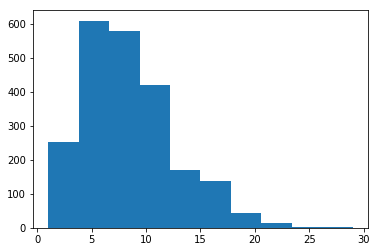

In [201]:
plt.hist(np.array([info["ainu_train-2_3_4_5_6_7_8_9"][x]["en_w"] for x in info["ainu_train-2_3_4_5_6_7_8_9"]]))

## Create MFCCs

In [ ]:
from python_speech_features import delta

In [ ]:
def create_mfb(wav_fname, mfb_fname, mfb_std_fname, nfilt=40):
    rate, sig = wav.read(wav_fname)
    mfb_feat = logfbank(sig,rate, nfilt=nfilt)
    d_mfb_feat = delta(mfb_feat, 2)
    dd_mfb_feat = delta(d_mfb_feat, 2)
    mfb_feat = np.concatenate((mfb_feat, d_mfb_feat), axis=1)
    mfb_feat = np.concatenate((mfb_feat, dd_mfb_feat), axis=1)
    try:
        mfb_feat_std = (mfb_feat - np.mean(mfb_feat, axis=0)) / np.std(mfb_feat, axis=0)
    except:
        print(wav_fname)
    # save mfb files
#     np.save(open(mfb_fname, "wb"), mfb_feat)
    np.save(open(mfb_std_fname, "wb"), mfb_feat_std.astype(np.float32))

In [ ]:
def create_mfcc(wav_fname, mfcc_fname, mfcc_std_fname):
    rate, sig = wav.read(wav_fname)
    mfcc_feat = mfcc(sig,rate)
    d_mfcc_feat = delta(mfcc_feat, 2)
    dd_mfcc_feat = delta(d_mfcc_feat, 2)
    mfcc_feat = np.concatenate((mfcc_feat, d_mfcc_feat), axis=1)
    mfcc_feat = np.concatenate((mfcc_feat, dd_mfcc_feat), axis=1)
    std_vals = np.std(mfcc_feat, axis=0)
    mfcc_feat_std = (mfcc_feat - np.mean(mfcc_feat, axis=0)) / np.std(mfcc_feat, axis=0)
    if not np.isfinite(std_vals).all() or not np.isfinite(std_vals).all():
        print("HAAAALP", wav_fname)
    # save mfcc files
#     np.save(open(mfcc_fname, "wb"), mfcc_feat)
    np.save(open(mfcc_std_fname, "wb"), mfcc_feat_std.astype(np.float32))

In [ ]:
def create_all_speech_features(mffc1mfb0=True):
    with tqdm(total=len(align_dict)) as pbar:
        for wav_fil in sorted(align_dict.keys()):
            for j, uttr in enumerate(sorted(align_dict[wav_fil].keys())):
                wav_fname = os.path.join(fa_vad_wavs_path, "{0:s}_fa_vad.wav".format(uttr))
                if mffc1mfb0:
                    mfcc_fname = os.path.join(fa_vad_mfcc_path, "{0:s}_fa_vad.mfcc".format(uttr))
                    mfcc_std_fname = os.path.join(fa_vad_std_mfcc_path, "{0:s}_fa_vad.std.mfcc".format(uttr))
                    create_mfcc(wav_fname, mfcc_fname, mfcc_std_fname)
                else:
                    mfb_fname = os.path.join(fa_vad_mfb_path, "{0:s}_fa_vad.mfb".format(uttr))
                    mfb_std_fname = os.path.join(fa_vad_std_mfb_path, "{0:s}_fa_vad.std.mfb".format(uttr))
                    create_mfb(wav_fname, mfb_fname, mfb_std_fname)
                
            # end for uttr
            pbar.update(1)
        # end for file
    # end pbar

    print("Completed!")

In [ ]:
create_all_speech_features(mffc1mfb0=False)

In [ ]:
for j, uttr in enumerate(sorted(align_dict['038'].keys())[20:]):
    print(uttr, end=', ')
    wav_fname = os.path.join(fa_vad_wavs_path, "{0:s}_fa_vad.wav".format(uttr))
    mfcc_fname = os.path.join(fa_vad_mfcc_path, "{0:s}_fa_vad.mfcc".format(uttr))
    mfcc_std_fname = os.path.join(fa_vad_std_mfcc_path, "{0:s}_fa_vad.std.mfcc".format(uttr))
    create_mfcc(wav_fname, mfcc_fname, mfcc_std_fname)
    

In [ ]:
!ls ../uttr_fa_vad_wavs/mfcc/ | wc

In [ ]:
haha = np.load("../uttr_fa_vad_wavs/mfcc/001.002_fa_vad.mfcc")

In [ ]:
haha_mfb = np.load("../uttr_fa_vad_wavs/mfb/001.002_fa_vad.mfb")

In [ ]:
haha.shape, haha_mfb.shape

In [ ]:
haha_mfb[0,:5]

In [ ]:
np.expand_dims(haha_mfb, 0)[0,0,-5:]

In [ ]:
np.flipud(haha_mfb)[-1,:5]

### etc code

In [ ]:
wavfile = os.path.join(uttr_wavs_path, "001.002.wav")
(rate,sig) = wav.read(wavfile)
mfcc_feat = mfcc(sig,rate)
mfb = logfbank(sig, rate, nfilt=80)

In [ ]:
mfb.shape, mfcc_feat.shape

In [ ]:
(rate,sig) = wav.read(wavfile)
mfcc_feat = mfcc(sig,rate)
d_mfcc_feat = delta(mfcc_feat, 2)
dd_mfcc_feat = delta(d_mfcc_feat, 2)
mfcc_feat = np.concatenate((mfcc_feat, d_mfcc_feat), axis=1)
mfcc_feat = np.concatenate((mfcc_feat, dd_mfcc_feat), axis=1)
mfcc_feat_std = (mfcc_feat - np.mean(mfcc_feat, axis=0)) / np.std(mfcc_feat, axis=0)
mfcc_feat.shape

In [ ]:
mfcc_feat.shape

In [ ]:
create_mfcc(wavfile, fa_vad_mfcc_path)

In [ ]:
!ls ../uttr_fa_vad_wavs/mfcc/

In [ ]:
os.path.basename(wavfile)

In [ ]:
mfcc_feat.shape, d_mfcc_feat.shape, dd_mfcc_feat.shape

In [ ]:
mfcc_feat_base[0,:], mfcc_feat[0, :13]

In [ ]:
d_mfcc_feat[0,:], mfcc_feat[0, 13:26]

In [ ]:
np.mean(mfcc_feat, axis=0).shape, np.std(mfcc_feat, axis=0).shape

In [ ]:
mfcc_feat_std = (mfcc_feat - np.mean(mfcc_feat, axis=0)) / np.std(mfcc_feat, axis=0)

In [ ]:
mfcc_feat_std[0, 13:26]

In [ ]:
Audio(os.path.join(uttr_wavs_path, "001.002.wav"))

In [ ]:
Audio(os.path.join(fa_vad_wavs_path, "001.002_fa_vad.wav"))

In [ ]:
print(" ".join([w.word for w in align_dict["110"]["110.005"]["es"]]))

In [ ]:
!soxi ../uttr_fa_vad_wavs/fa_vad_wavs/110.005_fa_vad.wav
!soxi ../uttr_fa_vad_wavs/uttr_wavs/110.005.wav

### Use MFCCs and Log Mel Filterbanks generated using Kaldi

In [ ]:
kaldi_out_path = "../uttr_fa_vad_wavs/kaldi/"

In [ ]:
haha = np.load("../uttr_fa_vad_wavs/mfcc_std/001.002_fa_vad.std.mfcc")

In [ ]:
haha.shape, haha[0,:5]

In [ ]:
!ls $kaldi_out_path/mfcc_cmvn_dd_vad

In [ ]:
kaldi_test = np.load("../uttr_fa_vad_wavs/kaldi/mfcc_cmvn_dd_vad/test.npz")

In [ ]:
kaldi_dev['001.002'].shape, kaldi_dev['001.002'][0,:5]